<a id="top"></a>
# Interpreting Convolutional Neural Networks

***

## Learning Goals


**In this tutorial, you will practice analyzing and interpreting a convolutional neural network.**
 This tutorial assumes a basic knowledge of convolutional neural networks. We will utilize the model described in `Classifying_JWST-HST_galaxy_mergers_with_CNNs`, so it is recommended to complete that notebook before reading this one.

## Introduction
Machine learning techniques can be powerful tools for categorizing data and performing data analysis questions. However, machine learning techniques often involve a lot of hidden computation that is not immediately meaningful. The black-box nature of intermediary processes, especially in layered neural networks, can make it difficult to interpret and understand. The goal of this notebook is to familiarize you with some of the various techniques used to make sense of machine learning and convolutional neural networks (CNNs) in particular. CNNs in particular can be very difficult to interpret due to their multi-layered structure and convolutional layers. In this notebook, we will examine two methods of visualizing CNN results (Backpropagation and Grad-CAM) and another method for testing model architecture.

1. Load the data
2. Split the data into training, validation, and testing sets
3. Build and train a model
4. Apply some interpretation technique to understand your results from a physical perspective.


### Dependencies

This notebook uses the following packages:
- `numpy` to handle array functions
- `astropy` for downloading and accessing FITS files
- `matplotlib.pyplot` for plotting data
- `keras` and `tensorflow` for building the CNN
- `sklearn` for some utility functions

If you do not have these packages installed, you can install them using [`pip`](https://pip.pypa.io/en/stable/) or [`conda`](https://docs.conda.io/en/latest/).

Further information about the original model can be found at the [Hello Universe codebase](https://spacetelescope.github.io/hellouniverse/notebooks/hello-universe/Classifying_JWST-HST_galaxy_mergers_with_CNNs/Classifying_JWST-HST_galaxy_mergers_with_CNNs.html).


**Author:**  
Oliver Lin, oliverlin2004@gmail.com

**Additional Contributors:**  
Daisuke Nagai, daisuke.nagai@yale.edu.

Michelle Ntampaka, mntampaka@stsci.edu.

**Published:** 2024-05-08

In [1]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

# keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Convolution2D, MaxPooling2D
# from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2

# sklearn
from sklearn.model_selection import train_test_split

# tensorflow for saliency
import tensorflow as tf
import cv2

2025-07-14 18:43:41.860742: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 18:43:41.892111: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-14 18:43:41.892139: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-14 18:43:41.893162: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-14 18:43:41.898644: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 18:43:41.899107: I tensorflow/core/platform/cpu_feature_guard.cc:1

2025-07-14 18:43:42.630938: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Reloading our Model
To start, we need to reload our model from the previous galaxy classification notebook from the Mikulski Archive for Space Telescopes (MAST). The following code is directly copied over from that notebook. For a quick refresher, the model intakes a FITS file from a high level science product hosted by MAST. There are 15,426 observations in total, each taken with three filters (F814W from the Advanced Camera for Surveys and F160W from the Wide Field Camera 3 on the Hubble Space Telescope (HST), and F160W and F356W from Near Infrared Camera on the James Webb Space Telescope (JWST)). The model then applies a Convolutional Neural Network to classify whether a galaxy has undergone a merger.

In [2]:
version = 'pristine'
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

## Build and Compile the Convolutional Model
For the sake of transparency, we will rebuild the model using the same architecture as the original notebook. The model can also be loaded directly by using `save_model` and `load_model` from the [Keras](https://www.tensorflow.org/guide/keras/serialization_and_saving) package. 

In [3]:
X = hdu[0].data
y = hdu[1].data

Following the authors, we will split the data into 70:10:20 ratio of train:validate:test. As above, set the random seed to randomly split the images in a repeatable way. Feel free to try different values!



In [4]:
random_state = 42

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=random_state, shuffle=True)

In [5]:
imsize = np.shape(X_train)[2]

X_train = np.array([np.stack(x, axis=2) for x in X_train])
X_valid = np.array([np.stack(x, axis=2) for x in X_valid])
X_test = np.array([np.stack(x, axis=2) for x in X_test])

### Generate the model architecture (written for Keras 2)

In [6]:
# Define architecture for model
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation='sigmoid')(z1)

cnn = Model(inputs=x_in, outputs=y_out)

### Compile Model

In [7]:
optimizer = 'adam'
fit_metrics = ['accuracy']
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)

### Load pretrained weights


In [8]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_interpretability_best_weights.hdf5'
cnn.load_weights(download_file(file_url, cache=True, show_progress=True))

2025-07-14 18:43:44.969887: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open /home/runner/.astropy/cache/download/url/75479cba1a5e1313befcce7b9c2f3f36/contents: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


## 1. Saliency Maps
We will start by introducing the most popular and well known method of interpreting CNNs. A saliency map can help us identify which pixels are significant to the models final prediction. There are many methods of calculating saliency maps, but the most popular method utilizes gradient backpropagation to determine the significance of pixels at each layer of the model. To calculate the saliency map, the error gradient at each layer is calculated and then fed into the previous layer, repeating until we reach the original image. Then the pixels with the highest gradient values will also have the most effect on the model's activation. This methodology is described in detail by <a href='https://arxiv.org/abs/1312.6034'>Simonyan et al. 2013</a>. 

### Dependencies

`tensorflow.GradientTape()` is used to track the gradient of the function.


In [9]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [10]:
images = tf.Variable(img, dtype=float)

# Make a prediction and track gradients
with tf.GradientTape() as tape:
    pred = cnn(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
    loss = pred[class_idxs_sorted[0]]

grads = tape.gradient(loss, images)

### Plot the original image and the saliency map

Saliency maps provide an intuitive understanding of how the model works. The hot pixels represent higher activation and more importance. In the below model, the saliency maps demonstrates that the model focuses on the area around the center of the galaxy for the majority of galaxies. Our results are in line with a corroborating result by [Ntampaka et al. 2018](https://arxiv.org/abs/1810.07703), suggesting that the key features of a galaxy are found the ring around the galaxy rather than in the center of the galaxy.

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 93ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

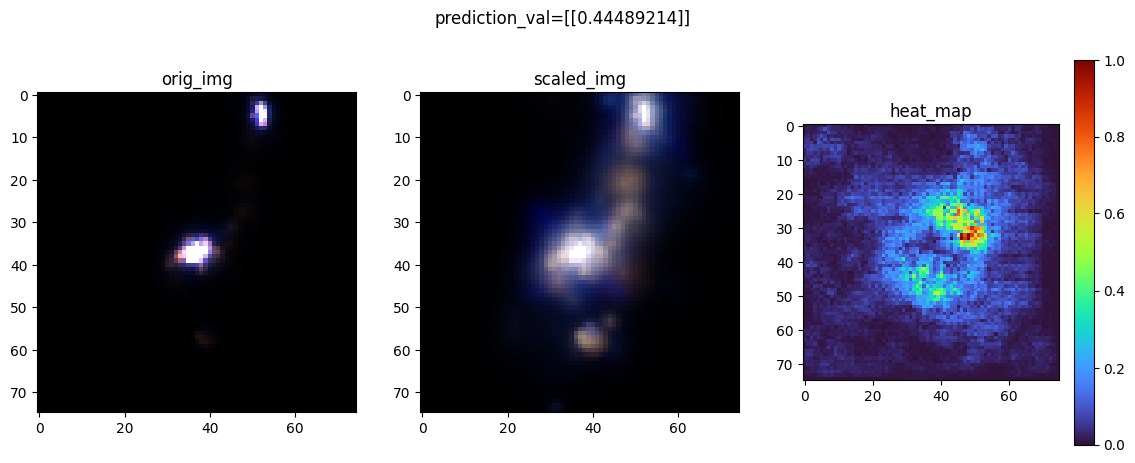

In [11]:
y_pred = cnn.predict(img)

dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

# normalize to range between 0 and 1
arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(grad_eval, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the saliency map.

### Create a stack of saliency images

To understand the overall behavior of our algorithm, we can stack some or all of the saliency maps in the test set to generate an overarching estimate of important pixels. For the sake of simplicity, we will stack the saliency maps for the first 100 images in the test set. Our results once again indicate that the region around a galaxy is particularly important to the model.

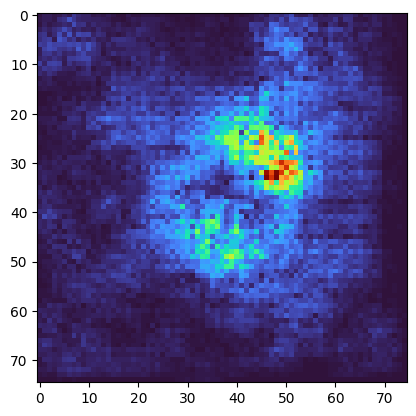

In [12]:
sum_map = np.zeros((75, 75))
# Summing the first 100 saliencies. We can change
# the range to sum more or less saliencies or pick 
# specific ones
for i in range(100):
    img = X_test[img_idx]
    img = img.reshape((1, *img.shape))
    images = tf.Variable(img, dtype=float)

    # Make a prediction and track gradients
    with tf.GradientTape() as tape:
        pred = cnn(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
        loss = pred[class_idxs_sorted[0]]

    grads = tape.gradient(loss, images)

    y_pred = cnn.predict(images, verbose=0)

    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

    # normalize to range between 0 and 1
    arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min)
    sum_map += grad_eval
plt.imshow(sum_map, cmap='turbo')

**Image caption**: The above image contains a single panel, and shows a stacked version of the saliency maps from 100 images.

## 2. Grad-CAM
While gradient backpropagation has historically been the most popular type of saliency map, the highly connected nature of backtracking has been shown to produce high variance under small changes to inputs. As such, gradient backpropagation is extremely sensitive to data manipulation (preprocessing, sensitivity analysis, GANs), raising questions about its reliability and validity. Gradient Class Activation Mapping (Grad-CAM) is an alternative method for generating saliency models that only examines the gradient of the final convolutional layer when producing the map. As a consequence, Grad-CAM maps have lower (coarser) resolution than backpropagation but are far more resilient to small changes and therefore more reliable when tuning a model. A full description of the technique can be found in <a href='https://arxiv.org/abs/1610.02391'>Selveraju et al. 2016</a>.

The code for Grad-CAM comes from a useful tutorial on the subject by Daniel Reiff. For more information, please visit the  <a href='https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353'>full tutorial</a>.

### Dependencies

`Open_CV` and `astropy.simple_norm` are used to do manipulate the image for display. Alternatively, we could allow Python to automatically clip the image when the heatmap is out of range.

In [13]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [14]:
# Note: recompiling the model will change the layer
# name. In that case, you can either restart the 
# kernel or change the layer_name.
# We can also change the layer selected here to pull out any layer of our model
gradModel = Model(inputs=[cnn.inputs], outputs=[cnn.get_layer("conv2d_2").output, cnn.output])

with tf.GradientTape() as tape:
    # get the loss with associated with the prediction
    inputs = tf.cast(X_test, tf.float32)
    (convOutputs, predictions) = gradModel(inputs)
    loss = predictions[:, 0]
    
# use automatic differentiation to compute the gradients
grads = tape.gradient(loss, convOutputs)

# compute the guided gradients by removing all nonpositive
# gradients
castConvOutputs = tf.cast(convOutputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads

# pick out the convolution and gradient of the chosen image
convOutputs = convOutputs[img_idx]
guidedGrads = guidedGrads[img_idx]

# compute the average of the gradient values, and using them
# as weights, compute the importance of the pieces
weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (X_test.shape[2], X_test.shape[1])
heatmap = cv2.resize(cam.numpy(), (w, h))

# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer

2025-07-14 18:43:47.945338: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-14 18:43:48.780405: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-14 18:43:48.852416: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-14 18:43:48.891804: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-14 18:43:50.357857: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

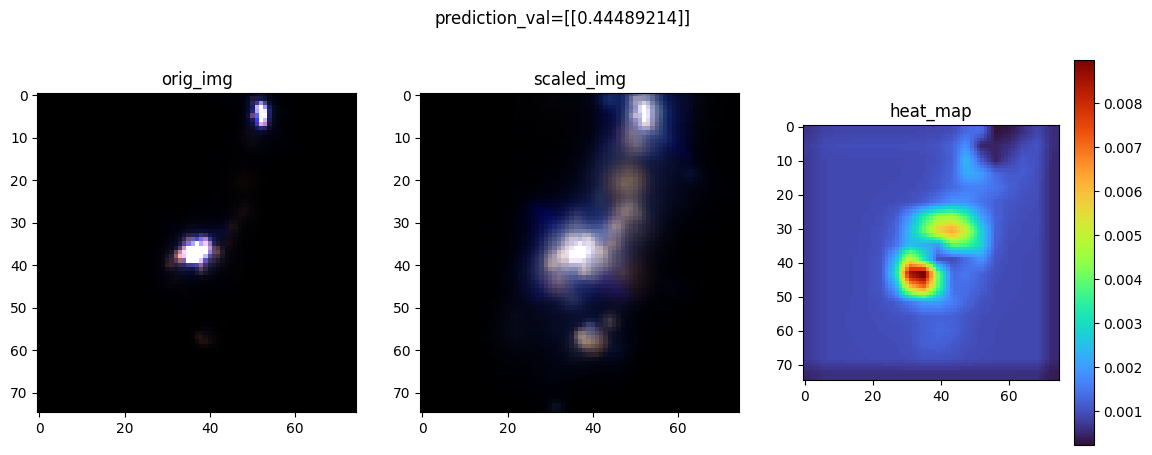

In [15]:
y_pred = cnn.predict(img)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the grad-cam map.

**The result is very similar** to our saliency map from backpropagation, although the image is coarser and also shows both the top and bottom of the galaxy. We can also play around with the selected layer to calculate the output at different steps in the model and see how activation changes throughout the model.

## 3. RISE Algorithm
The RISE (Randomized Input Sampling for Explanation) Algorithm is another interpretation technique for calculating saliency maps. Instead of calculating gradients from within the model, the RISE implementation works by covering up pieces of the input image, running it through the model, and calculating the average activation in order to determine what parts of the image are most important. As such, this method does not require any access to the inner workings of the model. The algorithm first generates a random sequence of binary grids (called masks), which are placed onto the image. Everything not covered by the mask is removed by multiplying the images together, and the resultant activations are averaged to get our final heatmap. A full description of the algorithm and its variations is provided by <a href='https://arxiv.org/abs/1806.07421'>Petsiuk et al. 2018</a>. 



In [16]:
# Choose the image to analyze
img_idx = 6

# We can change the index to any number in range of the test set
image = X_test[img_idx]

N = 1000  # Number of masks
s = 8     # Size of the grid
p1 = 0.5  # Probability of the cell being set to 1

cell_size = np.ceil(np.array(input_shape[:2]) / s).astype(int)
up_size = (s * cell_size).astype(int)

grid = np.random.rand(N, s, s) < p1
masks = np.empty((N, *input_shape[:2]))

for i in range(N):
    # Randomly place the grid on the image
    x = np.random.randint(0, input_shape[0]-s)
    y = np.random.randint(0, input_shape[1]-s)
    mask = np.pad(grid[i], ((x, input_shape[0]-x-s), (y, input_shape[0]-y-s)), 'constant', constant_values=(0, 0))
    mask = mask[:input_shape[0], :input_shape[1]]
    masks[i] = mask

masks = masks.reshape(-1, *input_shape[:2], 1)

N = len(masks)
pred_masks = cnn.predict(image * masks)
pred_masks = np.expand_dims(pred_masks, axis=-1)
pred_masks = np.expand_dims(pred_masks, axis=-1) # Reshape pred_masks for broadcasting
heatmap = (pred_masks * masks).sum(axis=0)
heatmap = heatmap / N / p1

 1/32 [..............................] - ETA: 0s

 4/32 [==>...........................] - ETA: 0s

 8/32 [======>.......................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

20/32 [=================>............] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 1s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00022207294..674.50696].


Text(0.5, 1.0, 'heat_map')

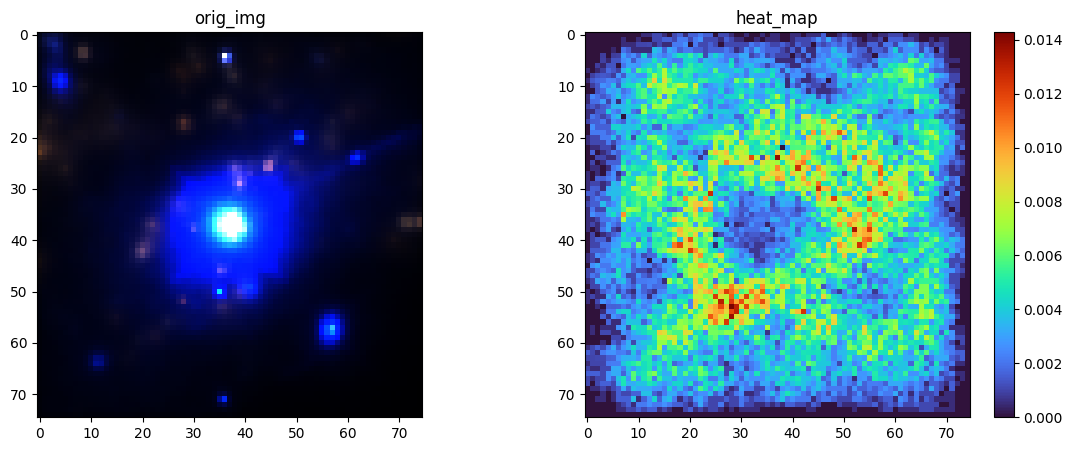

In [17]:
# Plot the results next to the original image
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(image)
axes[0].set_title("orig_img")
i = axes[1].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[1].set_title("heat_map")

**Image caption**: The above image contains two panels in a horizontal row. The first panel shows the original image of a merginig galaxy candidate, and the second panel shows a heat map of the RISE map.

**When examining the selected image**, we see a ring around the galactic center. Note that this is not the case for all astronomical images, or even all images in this dataset. Try playing around with the selected image to generate different saliency maps. For images where the central feature is relatively small, RISE's occlusion-based methodology can be unreliable.

## 4. Ablation Analysis
Saliency maps provide an intuitive visual understanding of our model's focus and can be useful for understanding the physical relevance of our classification scheme. In order to understand the efficacy of our model's architecture, we can instead use ablation analysis to determine the most important layers of our model. Ablation analysis works by rebuilding our model without a specified layer of interest and testing and comparing the performance of a partial model. Since we are focusing on our model's internal architecture rather than the features of the dataset we are looking at, we want to use this technique when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our mode

In the exercise below, we will build and train four mini-models on the same data set as before. As this is an educational notebook, we will limit the training time of each model to five epochs. Results with these models may vary considerably due to these training constraints, but we highly encourage you to try modifying this section of the notebook for different results (see [Exercises](#Exercises/Extensions))

Note that performing an ablation analysis will require training multiple models with the same architecture. This can be quite compute intensive on personal computers, so if you are running this notebook locally it is recommended that your device be plugged in before running the analysis.

### Dependencies

`Tensorflow` is used build our model and train it.

In [18]:
def create_model(ablate=None):
    x_in = Input(shape=input_shape)
    
    if ablate != 'c0':
        c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
    else:
        c0 = x_in
    b0 = BatchNormalization()(c0)
    d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
    e0 = Dropout(0.5)(d0)

    if ablate != 'c1':
        c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
    else:
        c1 = e0
    b1 = BatchNormalization()(c1)
    d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
    e1 = Dropout(0.5)(d1)

    if ablate != 'c2':
        c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
    else:
        c2 = e1
    b2 = BatchNormalization()(c2)
    d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
    e2 = Dropout(0.5)(d2)

    f = Flatten()(e2)
    z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
    z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
    y_out = Dense(1, activation='sigmoid')(z1)

    cnn = Model(inputs=x_in, outputs=y_out)
    return cnn

**Since ablation analysis requires training multiple models**, it can often be more resource intensive than other methods. However, it can also provide useful information on the way features are organized during training. The following cell can be edited to change how much we want to train our mini-models.

In [19]:
# You can change how much to train each model
# 5 epochs is chosen due to time and computation constraints
num_epochs = 5

# Train the original model
model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Get baseline performance
baseline_score = model.evaluate(X_test, y_test)

# Ablate each layer and compare performance
layers_to_ablate = ['c0', 'c1', 'c2']
for layer in layers_to_ablate:
    model_ablated = create_model(ablate=layer)
    model_ablated.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_ablated.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))
    ablated_score = model_ablated.evaluate(X_test, y_test)
    
    print(f"Performance drop after ablating {layer}: {baseline_score[1] - ablated_score[1]}")

Epoch 1/5


  1/338 [..............................] - ETA: 6:17 - loss: 0.7151 - accuracy: 0.4062

  2/338 [..............................] - ETA: 20s - loss: 0.7131 - accuracy: 0.4375 

  3/338 [..............................] - ETA: 19s - loss: 0.7119 - accuracy: 0.4583

  4/338 [..............................] - ETA: 19s - loss: 0.7120 - accuracy: 0.4453

  5/338 [..............................] - ETA: 19s - loss: 0.7115 - accuracy: 0.4500

  6/338 [..............................] - ETA: 18s - loss: 0.7108 - accuracy: 0.4583

  7/338 [..............................] - ETA: 18s - loss: 0.7106 - accuracy: 0.4554

  8/338 [..............................] - ETA: 18s - loss: 0.7098 - accuracy: 0.4688

  9/338 [..............................] - ETA: 18s - loss: 0.7096 - accuracy: 0.4653

 10/338 [..............................] - ETA: 18s - loss: 0.7085 - accuracy: 0.4875

 11/338 [..............................] - ETA: 18s - loss: 0.7081 - accuracy: 0.4915

 12/338 [>.............................] - ETA: 18s - loss: 0.7074 - accuracy: 0.5052

 13/338 [>.............................] - ETA: 18s - loss: 0.7073 - accuracy: 0.5000

 14/338 [>.............................] - ETA: 18s - loss: 0.7067 - accuracy: 0.5089

 15/338 [>.............................] - ETA: 18s - loss: 0.7065 - accuracy: 0.5083

 16/338 [>.............................] - ETA: 18s - loss: 0.7062 - accuracy: 0.5098

 17/338 [>.............................] - ETA: 18s - loss: 0.7059 - accuracy: 0.5110

 18/338 [>.............................] - ETA: 17s - loss: 0.7057 - accuracy: 0.5104

 19/338 [>.............................] - ETA: 17s - loss: 0.7057 - accuracy: 0.5033

 20/338 [>.............................] - ETA: 17s - loss: 0.7054 - accuracy: 0.5063

 21/338 [>.............................] - ETA: 17s - loss: 0.7053 - accuracy: 0.5030

 22/338 [>.............................] - ETA: 17s - loss: 0.7051 - accuracy: 0.5014

 23/338 [=>............................] - ETA: 17s - loss: 0.7050 - accuracy: 0.5000

 24/338 [=>............................] - ETA: 17s - loss: 0.7048 - accuracy: 0.4987

 25/338 [=>............................] - ETA: 17s - loss: 0.7047 - accuracy: 0.4963

 26/338 [=>............................] - ETA: 17s - loss: 0.7044 - accuracy: 0.5000

 27/338 [=>............................] - ETA: 17s - loss: 0.7040 - accuracy: 0.5046

 28/338 [=>............................] - ETA: 17s - loss: 0.7039 - accuracy: 0.5033

 29/338 [=>............................] - ETA: 17s - loss: 0.7038 - accuracy: 0.5022

 30/338 [=>............................] - ETA: 17s - loss: 0.7036 - accuracy: 0.5021

 31/338 [=>............................] - ETA: 17s - loss: 0.7033 - accuracy: 0.5050

 32/338 [=>............................] - ETA: 17s - loss: 0.7030 - accuracy: 0.5078

 33/338 [=>............................] - ETA: 17s - loss: 0.7028 - accuracy: 0.5104

 34/338 [==>...........................] - ETA: 16s - loss: 0.7026 - accuracy: 0.5129

 35/338 [==>...........................] - ETA: 16s - loss: 0.7025 - accuracy: 0.5116

 36/338 [==>...........................] - ETA: 16s - loss: 0.7022 - accuracy: 0.5139

 37/338 [==>...........................] - ETA: 16s - loss: 0.7021 - accuracy: 0.5135

 38/338 [==>...........................] - ETA: 16s - loss: 0.7020 - accuracy: 0.5132

 39/338 [==>...........................] - ETA: 16s - loss: 0.7017 - accuracy: 0.5176

 40/338 [==>...........................] - ETA: 16s - loss: 0.7014 - accuracy: 0.5219

 41/338 [==>...........................] - ETA: 16s - loss: 0.7012 - accuracy: 0.5229

 42/338 [==>...........................] - ETA: 16s - loss: 0.7010 - accuracy: 0.5246

 43/338 [==>...........................] - ETA: 16s - loss: 0.7008 - accuracy: 0.5262

 44/338 [==>...........................] - ETA: 16s - loss: 0.7007 - accuracy: 0.5256

 45/338 [==>...........................] - ETA: 16s - loss: 0.7005 - accuracy: 0.5278

 46/338 [===>..........................] - ETA: 16s - loss: 0.7003 - accuracy: 0.5285

 47/338 [===>..........................] - ETA: 16s - loss: 0.7002 - accuracy: 0.5286

 48/338 [===>..........................] - ETA: 16s - loss: 0.7003 - accuracy: 0.5260

 49/338 [===>..........................] - ETA: 16s - loss: 0.7002 - accuracy: 0.5255

 50/338 [===>..........................] - ETA: 16s - loss: 0.7000 - accuracy: 0.5275

 51/338 [===>..........................] - ETA: 16s - loss: 0.6997 - accuracy: 0.5300

 52/338 [===>..........................] - ETA: 16s - loss: 0.6996 - accuracy: 0.5300

 53/338 [===>..........................] - ETA: 15s - loss: 0.6995 - accuracy: 0.5301

 54/338 [===>..........................] - ETA: 15s - loss: 0.6994 - accuracy: 0.5301

 55/338 [===>..........................] - ETA: 15s - loss: 0.6993 - accuracy: 0.5307

 56/338 [===>..........................] - ETA: 15s - loss: 0.6994 - accuracy: 0.5273

 57/338 [====>.........................] - ETA: 15s - loss: 0.6993 - accuracy: 0.5280

 58/338 [====>.........................] - ETA: 15s - loss: 0.6992 - accuracy: 0.5280

 59/338 [====>.........................] - ETA: 15s - loss: 0.6992 - accuracy: 0.5275

 60/338 [====>.........................] - ETA: 15s - loss: 0.6991 - accuracy: 0.5276

 61/338 [====>.........................] - ETA: 15s - loss: 0.6990 - accuracy: 0.5277

 62/338 [====>.........................] - ETA: 15s - loss: 0.6989 - accuracy: 0.5277

 63/338 [====>.........................] - ETA: 15s - loss: 0.6987 - accuracy: 0.5303

 64/338 [====>.........................] - ETA: 15s - loss: 0.6986 - accuracy: 0.5312

 65/338 [====>.........................] - ETA: 15s - loss: 0.6985 - accuracy: 0.5317

 66/338 [====>.........................] - ETA: 15s - loss: 0.6985 - accuracy: 0.5308

 67/338 [====>.........................] - ETA: 15s - loss: 0.6986 - accuracy: 0.5280

 68/338 [=====>........................] - ETA: 15s - loss: 0.6986 - accuracy: 0.5271

 69/338 [=====>........................] - ETA: 15s - loss: 0.6985 - accuracy: 0.5272

 70/338 [=====>........................] - ETA: 14s - loss: 0.6984 - accuracy: 0.5277

 71/338 [=====>........................] - ETA: 14s - loss: 0.6984 - accuracy: 0.5273

 72/338 [=====>........................] - ETA: 14s - loss: 0.6985 - accuracy: 0.5252

 73/338 [=====>........................] - ETA: 14s - loss: 0.6985 - accuracy: 0.5240

 74/338 [=====>........................] - ETA: 14s - loss: 0.6985 - accuracy: 0.5236

 75/338 [=====>........................] - ETA: 14s - loss: 0.6984 - accuracy: 0.5238

 76/338 [=====>........................] - ETA: 14s - loss: 0.6983 - accuracy: 0.5243

 77/338 [=====>........................] - ETA: 14s - loss: 0.6982 - accuracy: 0.5252

 78/338 [=====>........................] - ETA: 14s - loss: 0.6983 - accuracy: 0.5236

 79/338 [======>.......................] - ETA: 14s - loss: 0.6982 - accuracy: 0.5241

 80/338 [======>.......................] - ETA: 14s - loss: 0.6983 - accuracy: 0.5215

 81/338 [======>.......................] - ETA: 14s - loss: 0.6983 - accuracy: 0.5216

 82/338 [======>.......................] - ETA: 14s - loss: 0.6980 - accuracy: 0.5240

 83/338 [======>.......................] - ETA: 14s - loss: 0.6979 - accuracy: 0.5248

 84/338 [======>.......................] - ETA: 14s - loss: 0.6979 - accuracy: 0.5249

 85/338 [======>.......................] - ETA: 14s - loss: 0.6977 - accuracy: 0.5272

 86/338 [======>.......................] - ETA: 14s - loss: 0.6977 - accuracy: 0.5265

 87/338 [======>.......................] - ETA: 13s - loss: 0.6976 - accuracy: 0.5269

 88/338 [======>.......................] - ETA: 13s - loss: 0.6975 - accuracy: 0.5273

 89/338 [======>.......................] - ETA: 13s - loss: 0.6975 - accuracy: 0.5274

 90/338 [======>.......................] - ETA: 13s - loss: 0.6974 - accuracy: 0.5281

 91/338 [=======>......................] - ETA: 13s - loss: 0.6973 - accuracy: 0.5285

 92/338 [=======>......................] - ETA: 13s - loss: 0.6973 - accuracy: 0.5282

 93/338 [=======>......................] - ETA: 13s - loss: 0.6973 - accuracy: 0.5272

 94/338 [=======>......................] - ETA: 13s - loss: 0.6972 - accuracy: 0.5283

 95/338 [=======>......................] - ETA: 13s - loss: 0.6972 - accuracy: 0.5280

 96/338 [=======>......................] - ETA: 13s - loss: 0.6971 - accuracy: 0.5286

 97/338 [=======>......................] - ETA: 13s - loss: 0.6972 - accuracy: 0.5271

 98/338 [=======>......................] - ETA: 13s - loss: 0.6971 - accuracy: 0.5274

 99/338 [=======>......................] - ETA: 13s - loss: 0.6971 - accuracy: 0.5275

100/338 [=======>......................] - ETA: 13s - loss: 0.6971 - accuracy: 0.5266

101/338 [=======>......................] - ETA: 13s - loss: 0.6970 - accuracy: 0.5275

102/338 [========>.....................] - ETA: 13s - loss: 0.6970 - accuracy: 0.5267

103/338 [========>.....................] - ETA: 13s - loss: 0.6970 - accuracy: 0.5273

104/338 [========>.....................] - ETA: 13s - loss: 0.6970 - accuracy: 0.5264

105/338 [========>.....................] - ETA: 12s - loss: 0.6969 - accuracy: 0.5268

106/338 [========>.....................] - ETA: 12s - loss: 0.6969 - accuracy: 0.5265

107/338 [========>.....................] - ETA: 12s - loss: 0.6969 - accuracy: 0.5260

108/338 [========>.....................] - ETA: 12s - loss: 0.6969 - accuracy: 0.5255

109/338 [========>.....................] - ETA: 12s - loss: 0.6968 - accuracy: 0.5261

110/338 [========>.....................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5267

111/338 [========>.....................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5265

112/338 [========>.....................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5262

113/338 [=========>....................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5257

114/338 [=========>....................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5258

115/338 [=========>....................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5255

116/338 [=========>....................] - ETA: 12s - loss: 0.6966 - accuracy: 0.5256

117/338 [=========>....................] - ETA: 12s - loss: 0.6966 - accuracy: 0.5254

118/338 [=========>....................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5244

119/338 [=========>....................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5242

120/338 [=========>....................] - ETA: 12s - loss: 0.6965 - accuracy: 0.5253

121/338 [=========>....................] - ETA: 12s - loss: 0.6965 - accuracy: 0.5253

122/338 [=========>....................] - ETA: 12s - loss: 0.6965 - accuracy: 0.5254

123/338 [=========>....................] - ETA: 12s - loss: 0.6964 - accuracy: 0.5257

124/338 [==========>...................] - ETA: 11s - loss: 0.6964 - accuracy: 0.5260

125/338 [==========>...................] - ETA: 11s - loss: 0.6963 - accuracy: 0.5265

126/338 [==========>...................] - ETA: 11s - loss: 0.6963 - accuracy: 0.5255

127/338 [==========>...................] - ETA: 11s - loss: 0.6964 - accuracy: 0.5244

128/338 [==========>...................] - ETA: 11s - loss: 0.6963 - accuracy: 0.5251

129/338 [==========>...................] - ETA: 11s - loss: 0.6962 - accuracy: 0.5259

130/338 [==========>...................] - ETA: 11s - loss: 0.6962 - accuracy: 0.5257

131/338 [==========>...................] - ETA: 11s - loss: 0.6962 - accuracy: 0.5255

132/338 [==========>...................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5263

133/338 [==========>...................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5268

134/338 [==========>...................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5268

135/338 [==========>...................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5259

136/338 [===========>..................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5250

137/338 [===========>..................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5249

138/338 [===========>..................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5263

139/338 [===========>..................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5254

140/338 [===========>..................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5248

141/338 [===========>..................] - ETA: 10s - loss: 0.6960 - accuracy: 0.5246

142/338 [===========>..................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5253

143/338 [===========>..................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5258

144/338 [===========>..................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5256

145/338 [===========>..................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5254

146/338 [===========>..................] - ETA: 10s - loss: 0.6957 - accuracy: 0.5268

147/338 [============>.................] - ETA: 10s - loss: 0.6957 - accuracy: 0.5268

148/338 [============>.................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5255

149/338 [============>.................] - ETA: 10s - loss: 0.6957 - accuracy: 0.5256

150/338 [============>.................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5246

151/338 [============>.................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5240

152/338 [============>.................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5243

153/338 [============>.................] - ETA: 10s - loss: 0.6957 - accuracy: 0.5249

154/338 [============>.................] - ETA: 10s - loss: 0.6957 - accuracy: 0.5250

155/338 [============>.................] - ETA: 10s - loss: 0.6957 - accuracy: 0.5242

156/338 [============>.................] - ETA: 10s - loss: 0.6956 - accuracy: 0.5254

157/338 [============>.................] - ETA: 10s - loss: 0.6955 - accuracy: 0.5259

158/338 [=============>................] - ETA: 10s - loss: 0.6954 - accuracy: 0.5271

159/338 [=============>................] - ETA: 9s - loss: 0.6954 - accuracy: 0.5275 

160/338 [=============>................] - ETA: 9s - loss: 0.6953 - accuracy: 0.5283

161/338 [=============>................] - ETA: 9s - loss: 0.6954 - accuracy: 0.5270

162/338 [=============>................] - ETA: 9s - loss: 0.6954 - accuracy: 0.5266

163/338 [=============>................] - ETA: 9s - loss: 0.6953 - accuracy: 0.5268

164/338 [=============>................] - ETA: 9s - loss: 0.6953 - accuracy: 0.5274

165/338 [=============>................] - ETA: 9s - loss: 0.6953 - accuracy: 0.5271

166/338 [=============>................] - ETA: 9s - loss: 0.6954 - accuracy: 0.5260

167/338 [=============>................] - ETA: 9s - loss: 0.6953 - accuracy: 0.5264

168/338 [=============>................] - ETA: 9s - loss: 0.6953 - accuracy: 0.5260

169/338 [==============>...............] - ETA: 9s - loss: 0.6953 - accuracy: 0.5266

170/338 [==============>...............] - ETA: 9s - loss: 0.6952 - accuracy: 0.5265

171/338 [==============>...............] - ETA: 9s - loss: 0.6953 - accuracy: 0.5260

172/338 [==============>...............] - ETA: 9s - loss: 0.6952 - accuracy: 0.5258

173/338 [==============>...............] - ETA: 9s - loss: 0.6952 - accuracy: 0.5258

174/338 [==============>...............] - ETA: 9s - loss: 0.6952 - accuracy: 0.5259

175/338 [==============>...............] - ETA: 9s - loss: 0.6951 - accuracy: 0.5264

176/338 [==============>...............] - ETA: 9s - loss: 0.6951 - accuracy: 0.5265

177/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5260

178/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5263

179/338 [==============>...............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5274

180/338 [==============>...............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5276

181/338 [===============>..............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5275

182/338 [===============>..............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5275

183/338 [===============>..............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5278

184/338 [===============>..............] - ETA: 8s - loss: 0.6948 - accuracy: 0.5280

185/338 [===============>..............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5275

186/338 [===============>..............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5269

187/338 [===============>..............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5267

188/338 [===============>..............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5261

189/338 [===============>..............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5258

190/338 [===============>..............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5257

191/338 [===============>..............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5260

192/338 [================>.............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5267

193/338 [================>.............] - ETA: 8s - loss: 0.6948 - accuracy: 0.5267

194/338 [================>.............] - ETA: 8s - loss: 0.6948 - accuracy: 0.5267

195/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5264

196/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5266

197/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5257

198/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5254

199/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5251

200/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5252

201/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5247

202/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5249

203/338 [=================>............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5252

204/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5260

205/338 [=================>............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5258

206/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5259

207/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5258

208/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5254

209/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5253

210/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5251

211/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5255

212/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5255

213/338 [=================>............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5248

214/338 [=================>............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5247

215/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5241

216/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5242

217/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5240

218/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5234

219/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5231

220/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5236

221/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5226

222/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5227

223/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5226

224/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5230

225/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5232

226/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5239

227/338 [===================>..........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5230

228/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5236

229/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5237

230/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5236

231/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5233

232/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5237

233/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5239

234/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5236

235/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5233

236/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5233

237/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5225

238/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5225

239/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5220

240/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5225

241/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5228

242/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5222

243/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5226

244/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5228

245/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5230

246/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5229

247/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5226

248/338 [=====================>........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5219

249/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5226

250/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5231

251/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5228

252/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5232

253/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5240

254/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5239

255/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5234

256/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5242

257/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5247

258/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5250

259/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5251

260/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5249

261/338 [======================>.......] - ETA: 4s - loss: 0.6941 - accuracy: 0.5250

262/338 [======================>.......] - ETA: 4s - loss: 0.6941 - accuracy: 0.5254

263/338 [======================>.......] - ETA: 4s - loss: 0.6941 - accuracy: 0.5255

264/338 [======================>.......] - ETA: 4s - loss: 0.6940 - accuracy: 0.5259

265/338 [======================>.......] - ETA: 4s - loss: 0.6940 - accuracy: 0.5263

266/338 [======================>.......] - ETA: 4s - loss: 0.6940 - accuracy: 0.5262

267/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5266

268/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5267

269/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5265

270/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5266

271/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5269

272/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5272

273/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5276

274/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5275

275/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5272

276/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5279

277/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5279

278/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5279

279/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5278

280/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5276

281/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5276

282/338 [========================>.....] - ETA: 3s - loss: 0.6937 - accuracy: 0.5274

283/338 [========================>.....] - ETA: 3s - loss: 0.6937 - accuracy: 0.5274

284/338 [========================>.....] - ETA: 3s - loss: 0.6937 - accuracy: 0.5275

285/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5273

286/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5276

287/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5275

288/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5273

289/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5272

290/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5274

291/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5273

292/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5271

293/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5270

294/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5264

295/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5261

296/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5263

297/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5263

298/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5264

299/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5272

300/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5271

301/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5268

302/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5264

303/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5268

304/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5267

305/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5270

306/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5267

307/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5269

308/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5269

309/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5265

310/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5268

311/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5270

312/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5275

313/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5281

314/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5286

315/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5284

316/338 [===========================>..] - ETA: 1s - loss: 0.6933 - accuracy: 0.5286

317/338 [===========================>..] - ETA: 1s - loss: 0.6933 - accuracy: 0.5283

318/338 [===========================>..] - ETA: 1s - loss: 0.6933 - accuracy: 0.5280

319/338 [===========================>..] - ETA: 1s - loss: 0.6933 - accuracy: 0.5276

320/338 [===========================>..] - ETA: 1s - loss: 0.6933 - accuracy: 0.5275

321/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5276

322/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5272

323/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5270

324/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5271

325/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5271

326/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5271

327/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5267

328/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5267

329/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5271

330/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5272

331/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5269

332/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5270

333/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5268

334/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5267

335/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5268

336/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5271

337/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5271

338/338 [==============================] - 22s 61ms/step - loss: 0.6933 - accuracy: 0.5271 - val_loss: 0.6913 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 18s - loss: 0.6818 - accuracy: 0.5938

  2/338 [..............................] - ETA: 18s - loss: 0.6933 - accuracy: 0.4844

  3/338 [..............................] - ETA: 18s - loss: 0.6908 - accuracy: 0.5104

  4/338 [..............................] - ETA: 18s - loss: 0.6863 - accuracy: 0.5469

  5/338 [..............................] - ETA: 18s - loss: 0.6834 - accuracy: 0.5750

  6/338 [..............................] - ETA: 18s - loss: 0.6842 - accuracy: 0.5729

  7/338 [..............................] - ETA: 18s - loss: 0.6873 - accuracy: 0.5491

  8/338 [..............................] - ETA: 18s - loss: 0.6889 - accuracy: 0.5352

  9/338 [..............................] - ETA: 18s - loss: 0.6876 - accuracy: 0.5451

 10/338 [..............................] - ETA: 18s - loss: 0.6896 - accuracy: 0.5312

 11/338 [..............................] - ETA: 18s - loss: 0.6918 - accuracy: 0.5142

 12/338 [>.............................] - ETA: 18s - loss: 0.6921 - accuracy: 0.5130

 13/338 [>.............................] - ETA: 18s - loss: 0.6911 - accuracy: 0.5216

 14/338 [>.............................] - ETA: 17s - loss: 0.6916 - accuracy: 0.5179

 15/338 [>.............................] - ETA: 17s - loss: 0.6910 - accuracy: 0.5229

 16/338 [>.............................] - ETA: 17s - loss: 0.6913 - accuracy: 0.5215

 17/338 [>.............................] - ETA: 17s - loss: 0.6915 - accuracy: 0.5202

 18/338 [>.............................] - ETA: 17s - loss: 0.6917 - accuracy: 0.5191

 19/338 [>.............................] - ETA: 17s - loss: 0.6915 - accuracy: 0.5197

 20/338 [>.............................] - ETA: 17s - loss: 0.6912 - accuracy: 0.5219

 21/338 [>.............................] - ETA: 17s - loss: 0.6912 - accuracy: 0.5208

 22/338 [>.............................] - ETA: 17s - loss: 0.6907 - accuracy: 0.5256

 23/338 [=>............................] - ETA: 17s - loss: 0.6909 - accuracy: 0.5231

 24/338 [=>............................] - ETA: 17s - loss: 0.6918 - accuracy: 0.5156

 25/338 [=>............................] - ETA: 17s - loss: 0.6914 - accuracy: 0.5188

 26/338 [=>............................] - ETA: 17s - loss: 0.6915 - accuracy: 0.5180

 27/338 [=>............................] - ETA: 17s - loss: 0.6911 - accuracy: 0.5220

 28/338 [=>............................] - ETA: 17s - loss: 0.6913 - accuracy: 0.5201

 29/338 [=>............................] - ETA: 17s - loss: 0.6914 - accuracy: 0.5183

 30/338 [=>............................] - ETA: 17s - loss: 0.6910 - accuracy: 0.5219

 31/338 [=>............................] - ETA: 17s - loss: 0.6910 - accuracy: 0.5222

 32/338 [=>............................] - ETA: 16s - loss: 0.6914 - accuracy: 0.5186

 33/338 [=>............................] - ETA: 16s - loss: 0.6914 - accuracy: 0.5180

 34/338 [==>...........................] - ETA: 16s - loss: 0.6918 - accuracy: 0.5138

 35/338 [==>...........................] - ETA: 16s - loss: 0.6915 - accuracy: 0.5152

 36/338 [==>...........................] - ETA: 16s - loss: 0.6917 - accuracy: 0.5130

 37/338 [==>...........................] - ETA: 16s - loss: 0.6922 - accuracy: 0.5084

 38/338 [==>...........................] - ETA: 16s - loss: 0.6922 - accuracy: 0.5082

 39/338 [==>...........................] - ETA: 16s - loss: 0.6924 - accuracy: 0.5064

 40/338 [==>...........................] - ETA: 16s - loss: 0.6923 - accuracy: 0.5078

 41/338 [==>...........................] - ETA: 16s - loss: 0.6924 - accuracy: 0.5061

 42/338 [==>...........................] - ETA: 16s - loss: 0.6923 - accuracy: 0.5082

 43/338 [==>...........................] - ETA: 16s - loss: 0.6922 - accuracy: 0.5080

 44/338 [==>...........................] - ETA: 16s - loss: 0.6925 - accuracy: 0.5057

 45/338 [==>...........................] - ETA: 16s - loss: 0.6925 - accuracy: 0.5056

 46/338 [===>..........................] - ETA: 16s - loss: 0.6927 - accuracy: 0.5041

 47/338 [===>..........................] - ETA: 16s - loss: 0.6927 - accuracy: 0.5033

 48/338 [===>..........................] - ETA: 16s - loss: 0.6925 - accuracy: 0.5059

 49/338 [===>..........................] - ETA: 16s - loss: 0.6922 - accuracy: 0.5096

 50/338 [===>..........................] - ETA: 16s - loss: 0.6923 - accuracy: 0.5075

 51/338 [===>..........................] - ETA: 15s - loss: 0.6924 - accuracy: 0.5067

 52/338 [===>..........................] - ETA: 15s - loss: 0.6923 - accuracy: 0.5072

 53/338 [===>..........................] - ETA: 15s - loss: 0.6923 - accuracy: 0.5083

 54/338 [===>..........................] - ETA: 15s - loss: 0.6923 - accuracy: 0.5075

 55/338 [===>..........................] - ETA: 15s - loss: 0.6921 - accuracy: 0.5097

 56/338 [===>..........................] - ETA: 15s - loss: 0.6919 - accuracy: 0.5123

 57/338 [====>.........................] - ETA: 15s - loss: 0.6919 - accuracy: 0.5110

 58/338 [====>.........................] - ETA: 15s - loss: 0.6918 - accuracy: 0.5129

 59/338 [====>.........................] - ETA: 15s - loss: 0.6919 - accuracy: 0.5111

 60/338 [====>.........................] - ETA: 15s - loss: 0.6919 - accuracy: 0.5115

 61/338 [====>.........................] - ETA: 15s - loss: 0.6919 - accuracy: 0.5113

 62/338 [====>.........................] - ETA: 15s - loss: 0.6921 - accuracy: 0.5091

 63/338 [====>.........................] - ETA: 15s - loss: 0.6919 - accuracy: 0.5109

 64/338 [====>.........................] - ETA: 15s - loss: 0.6919 - accuracy: 0.5107

 65/338 [====>.........................] - ETA: 15s - loss: 0.6917 - accuracy: 0.5130

 66/338 [====>.........................] - ETA: 15s - loss: 0.6919 - accuracy: 0.5109

 67/338 [====>.........................] - ETA: 15s - loss: 0.6918 - accuracy: 0.5117

 68/338 [=====>........................] - ETA: 14s - loss: 0.6919 - accuracy: 0.5106

 69/338 [=====>........................] - ETA: 14s - loss: 0.6918 - accuracy: 0.5118

 70/338 [=====>........................] - ETA: 14s - loss: 0.6919 - accuracy: 0.5103

 71/338 [=====>........................] - ETA: 14s - loss: 0.6918 - accuracy: 0.5110

 72/338 [=====>........................] - ETA: 14s - loss: 0.6918 - accuracy: 0.5109

 73/338 [=====>........................] - ETA: 14s - loss: 0.6917 - accuracy: 0.5120

 74/338 [=====>........................] - ETA: 14s - loss: 0.6919 - accuracy: 0.5106

 75/338 [=====>........................] - ETA: 14s - loss: 0.6918 - accuracy: 0.5117

 76/338 [=====>........................] - ETA: 14s - loss: 0.6918 - accuracy: 0.5115

 77/338 [=====>........................] - ETA: 14s - loss: 0.6918 - accuracy: 0.5122

 78/338 [=====>........................] - ETA: 14s - loss: 0.6917 - accuracy: 0.5128

 79/338 [======>.......................] - ETA: 14s - loss: 0.6916 - accuracy: 0.5134

 80/338 [======>.......................] - ETA: 14s - loss: 0.6916 - accuracy: 0.5137

 81/338 [======>.......................] - ETA: 14s - loss: 0.6914 - accuracy: 0.5158

 82/338 [======>.......................] - ETA: 14s - loss: 0.6913 - accuracy: 0.5175

 83/338 [======>.......................] - ETA: 14s - loss: 0.6913 - accuracy: 0.5169

 84/338 [======>.......................] - ETA: 14s - loss: 0.6915 - accuracy: 0.5156

 85/338 [======>.......................] - ETA: 14s - loss: 0.6913 - accuracy: 0.5169

 86/338 [======>.......................] - ETA: 13s - loss: 0.6914 - accuracy: 0.5160

 87/338 [======>.......................] - ETA: 13s - loss: 0.6915 - accuracy: 0.5154

 88/338 [======>.......................] - ETA: 13s - loss: 0.6915 - accuracy: 0.5146

 89/338 [======>.......................] - ETA: 13s - loss: 0.6915 - accuracy: 0.5147

 90/338 [======>.......................] - ETA: 13s - loss: 0.6914 - accuracy: 0.5160

 91/338 [=======>......................] - ETA: 13s - loss: 0.6915 - accuracy: 0.5144

 92/338 [=======>......................] - ETA: 13s - loss: 0.6916 - accuracy: 0.5136

 93/338 [=======>......................] - ETA: 13s - loss: 0.6915 - accuracy: 0.5141

 94/338 [=======>......................] - ETA: 13s - loss: 0.6917 - accuracy: 0.5133

 95/338 [=======>......................] - ETA: 13s - loss: 0.6916 - accuracy: 0.5135

 96/338 [=======>......................] - ETA: 13s - loss: 0.6915 - accuracy: 0.5146

 97/338 [=======>......................] - ETA: 13s - loss: 0.6915 - accuracy: 0.5145

 98/338 [=======>......................] - ETA: 13s - loss: 0.6915 - accuracy: 0.5147

 99/338 [=======>......................] - ETA: 13s - loss: 0.6915 - accuracy: 0.5142

100/338 [=======>......................] - ETA: 13s - loss: 0.6915 - accuracy: 0.5144

101/338 [=======>......................] - ETA: 13s - loss: 0.6916 - accuracy: 0.5136

102/338 [========>.....................] - ETA: 13s - loss: 0.6915 - accuracy: 0.5144

103/338 [========>.....................] - ETA: 13s - loss: 0.6915 - accuracy: 0.5143

104/338 [========>.....................] - ETA: 12s - loss: 0.6915 - accuracy: 0.5147

105/338 [========>.....................] - ETA: 12s - loss: 0.6913 - accuracy: 0.5167

106/338 [========>.....................] - ETA: 12s - loss: 0.6912 - accuracy: 0.5171

107/338 [========>.....................] - ETA: 12s - loss: 0.6912 - accuracy: 0.5169

108/338 [========>.....................] - ETA: 12s - loss: 0.6912 - accuracy: 0.5174

109/338 [========>.....................] - ETA: 12s - loss: 0.6912 - accuracy: 0.5172

110/338 [========>.....................] - ETA: 12s - loss: 0.6912 - accuracy: 0.5168

111/338 [========>.....................] - ETA: 12s - loss: 0.6912 - accuracy: 0.5172

112/338 [========>.....................] - ETA: 12s - loss: 0.6912 - accuracy: 0.5173

113/338 [=========>....................] - ETA: 12s - loss: 0.6911 - accuracy: 0.5180

114/338 [=========>....................] - ETA: 12s - loss: 0.6911 - accuracy: 0.5178

115/338 [=========>....................] - ETA: 12s - loss: 0.6911 - accuracy: 0.5179

116/338 [=========>....................] - ETA: 12s - loss: 0.6911 - accuracy: 0.5178

117/338 [=========>....................] - ETA: 12s - loss: 0.6912 - accuracy: 0.5174

118/338 [=========>....................] - ETA: 12s - loss: 0.6912 - accuracy: 0.5175

119/338 [=========>....................] - ETA: 12s - loss: 0.6912 - accuracy: 0.5168

120/338 [=========>....................] - ETA: 12s - loss: 0.6913 - accuracy: 0.5156

121/338 [=========>....................] - ETA: 12s - loss: 0.6913 - accuracy: 0.5155

122/338 [=========>....................] - ETA: 11s - loss: 0.6913 - accuracy: 0.5159

123/338 [=========>....................] - ETA: 11s - loss: 0.6913 - accuracy: 0.5150

124/338 [==========>...................] - ETA: 11s - loss: 0.6913 - accuracy: 0.5154

125/338 [==========>...................] - ETA: 11s - loss: 0.6913 - accuracy: 0.5153

126/338 [==========>...................] - ETA: 11s - loss: 0.6913 - accuracy: 0.5156

127/338 [==========>...................] - ETA: 11s - loss: 0.6913 - accuracy: 0.5157

128/338 [==========>...................] - ETA: 11s - loss: 0.6913 - accuracy: 0.5161

129/338 [==========>...................] - ETA: 11s - loss: 0.6913 - accuracy: 0.5157

130/338 [==========>...................] - ETA: 11s - loss: 0.6912 - accuracy: 0.5161

131/338 [==========>...................] - ETA: 11s - loss: 0.6912 - accuracy: 0.5162

132/338 [==========>...................] - ETA: 11s - loss: 0.6911 - accuracy: 0.5170

133/338 [==========>...................] - ETA: 11s - loss: 0.6911 - accuracy: 0.5176

134/338 [==========>...................] - ETA: 11s - loss: 0.6910 - accuracy: 0.5180

135/338 [==========>...................] - ETA: 11s - loss: 0.6910 - accuracy: 0.5188

136/338 [===========>..................] - ETA: 11s - loss: 0.6909 - accuracy: 0.5202

137/338 [===========>..................] - ETA: 11s - loss: 0.6909 - accuracy: 0.5201

138/338 [===========>..................] - ETA: 11s - loss: 0.6909 - accuracy: 0.5197

139/338 [===========>..................] - ETA: 11s - loss: 0.6909 - accuracy: 0.5196

140/338 [===========>..................] - ETA: 10s - loss: 0.6908 - accuracy: 0.5203

141/338 [===========>..................] - ETA: 10s - loss: 0.6908 - accuracy: 0.5199

142/338 [===========>..................] - ETA: 10s - loss: 0.6907 - accuracy: 0.5207

143/338 [===========>..................] - ETA: 10s - loss: 0.6906 - accuracy: 0.5214

144/338 [===========>..................] - ETA: 10s - loss: 0.6906 - accuracy: 0.5215

145/338 [===========>..................] - ETA: 10s - loss: 0.6905 - accuracy: 0.5224

146/338 [===========>..................] - ETA: 10s - loss: 0.6905 - accuracy: 0.5218

147/338 [============>.................] - ETA: 10s - loss: 0.6905 - accuracy: 0.5215

148/338 [============>.................] - ETA: 10s - loss: 0.6905 - accuracy: 0.5211

149/338 [============>.................] - ETA: 10s - loss: 0.6905 - accuracy: 0.5210

150/338 [============>.................] - ETA: 10s - loss: 0.6904 - accuracy: 0.5221

151/338 [============>.................] - ETA: 10s - loss: 0.6904 - accuracy: 0.5213

152/338 [============>.................] - ETA: 10s - loss: 0.6903 - accuracy: 0.5222

153/338 [============>.................] - ETA: 10s - loss: 0.6903 - accuracy: 0.5227

154/338 [============>.................] - ETA: 10s - loss: 0.6903 - accuracy: 0.5229

155/338 [============>.................] - ETA: 10s - loss: 0.6903 - accuracy: 0.5230

156/338 [============>.................] - ETA: 10s - loss: 0.6904 - accuracy: 0.5222

157/338 [============>.................] - ETA: 10s - loss: 0.6904 - accuracy: 0.5215

158/338 [=============>................] - ETA: 9s - loss: 0.6904 - accuracy: 0.5214 

159/338 [=============>................] - ETA: 9s - loss: 0.6904 - accuracy: 0.5216

160/338 [=============>................] - ETA: 9s - loss: 0.6904 - accuracy: 0.5213

161/338 [=============>................] - ETA: 9s - loss: 0.6903 - accuracy: 0.5223

162/338 [=============>................] - ETA: 9s - loss: 0.6902 - accuracy: 0.5228

163/338 [=============>................] - ETA: 9s - loss: 0.6903 - accuracy: 0.5222

164/338 [=============>................] - ETA: 9s - loss: 0.6902 - accuracy: 0.5232

165/338 [=============>................] - ETA: 9s - loss: 0.6902 - accuracy: 0.5233

166/338 [=============>................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5239

167/338 [=============>................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5238

168/338 [=============>................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5240

169/338 [==============>...............] - ETA: 9s - loss: 0.6900 - accuracy: 0.5242

170/338 [==============>...............] - ETA: 9s - loss: 0.6899 - accuracy: 0.5248

171/338 [==============>...............] - ETA: 9s - loss: 0.6899 - accuracy: 0.5250

172/338 [==============>...............] - ETA: 9s - loss: 0.6900 - accuracy: 0.5243

173/338 [==============>...............] - ETA: 9s - loss: 0.6900 - accuracy: 0.5242

174/338 [==============>...............] - ETA: 9s - loss: 0.6900 - accuracy: 0.5242

175/338 [==============>...............] - ETA: 9s - loss: 0.6900 - accuracy: 0.5234

176/338 [==============>...............] - ETA: 8s - loss: 0.6901 - accuracy: 0.5233

177/338 [==============>...............] - ETA: 8s - loss: 0.6902 - accuracy: 0.5222

178/338 [==============>...............] - ETA: 8s - loss: 0.6901 - accuracy: 0.5228

179/338 [==============>...............] - ETA: 8s - loss: 0.6901 - accuracy: 0.5229

180/338 [==============>...............] - ETA: 8s - loss: 0.6901 - accuracy: 0.5229

181/338 [===============>..............] - ETA: 8s - loss: 0.6900 - accuracy: 0.5237

182/338 [===============>..............] - ETA: 8s - loss: 0.6900 - accuracy: 0.5230

183/338 [===============>..............] - ETA: 8s - loss: 0.6901 - accuracy: 0.5229

184/338 [===============>..............] - ETA: 8s - loss: 0.6900 - accuracy: 0.5234

185/338 [===============>..............] - ETA: 8s - loss: 0.6900 - accuracy: 0.5235

186/338 [===============>..............] - ETA: 8s - loss: 0.6900 - accuracy: 0.5234

187/338 [===============>..............] - ETA: 8s - loss: 0.6899 - accuracy: 0.5237

188/338 [===============>..............] - ETA: 8s - loss: 0.6899 - accuracy: 0.5233

189/338 [===============>..............] - ETA: 8s - loss: 0.6901 - accuracy: 0.5223

190/338 [===============>..............] - ETA: 8s - loss: 0.6901 - accuracy: 0.5224

191/338 [===============>..............] - ETA: 8s - loss: 0.6901 - accuracy: 0.5226

192/338 [================>.............] - ETA: 8s - loss: 0.6901 - accuracy: 0.5226

193/338 [================>.............] - ETA: 8s - loss: 0.6900 - accuracy: 0.5233

194/338 [================>.............] - ETA: 7s - loss: 0.6899 - accuracy: 0.5232

195/338 [================>.............] - ETA: 7s - loss: 0.6899 - accuracy: 0.5232

196/338 [================>.............] - ETA: 7s - loss: 0.6898 - accuracy: 0.5239

197/338 [================>.............] - ETA: 7s - loss: 0.6899 - accuracy: 0.5238

198/338 [================>.............] - ETA: 7s - loss: 0.6899 - accuracy: 0.5235

199/338 [================>.............] - ETA: 7s - loss: 0.6899 - accuracy: 0.5234

200/338 [================>.............] - ETA: 7s - loss: 0.6898 - accuracy: 0.5241

201/338 [================>.............] - ETA: 7s - loss: 0.6897 - accuracy: 0.5246

202/338 [================>.............] - ETA: 7s - loss: 0.6896 - accuracy: 0.5254

203/338 [=================>............] - ETA: 7s - loss: 0.6896 - accuracy: 0.5256

204/338 [=================>............] - ETA: 7s - loss: 0.6895 - accuracy: 0.5259

205/338 [=================>............] - ETA: 7s - loss: 0.6894 - accuracy: 0.5264

206/338 [=================>............] - ETA: 7s - loss: 0.6894 - accuracy: 0.5261

207/338 [=================>............] - ETA: 7s - loss: 0.6894 - accuracy: 0.5264

208/338 [=================>............] - ETA: 7s - loss: 0.6894 - accuracy: 0.5263

209/338 [=================>............] - ETA: 7s - loss: 0.6893 - accuracy: 0.5266

210/338 [=================>............] - ETA: 7s - loss: 0.6894 - accuracy: 0.5260

211/338 [=================>............] - ETA: 7s - loss: 0.6893 - accuracy: 0.5267

212/338 [=================>............] - ETA: 6s - loss: 0.6893 - accuracy: 0.5268

213/338 [=================>............] - ETA: 6s - loss: 0.6893 - accuracy: 0.5271

214/338 [=================>............] - ETA: 6s - loss: 0.6892 - accuracy: 0.5270

215/338 [==================>...........] - ETA: 6s - loss: 0.6893 - accuracy: 0.5266

216/338 [==================>...........] - ETA: 6s - loss: 0.6892 - accuracy: 0.5266

217/338 [==================>...........] - ETA: 6s - loss: 0.6891 - accuracy: 0.5274

218/338 [==================>...........] - ETA: 6s - loss: 0.6891 - accuracy: 0.5275

219/338 [==================>...........] - ETA: 6s - loss: 0.6891 - accuracy: 0.5275

220/338 [==================>...........] - ETA: 6s - loss: 0.6890 - accuracy: 0.5277

221/338 [==================>...........] - ETA: 6s - loss: 0.6890 - accuracy: 0.5279

222/338 [==================>...........] - ETA: 6s - loss: 0.6890 - accuracy: 0.5277

223/338 [==================>...........] - ETA: 6s - loss: 0.6889 - accuracy: 0.5284

224/338 [==================>...........] - ETA: 6s - loss: 0.6889 - accuracy: 0.5283

225/338 [==================>...........] - ETA: 6s - loss: 0.6889 - accuracy: 0.5283

226/338 [===================>..........] - ETA: 6s - loss: 0.6889 - accuracy: 0.5282

227/338 [===================>..........] - ETA: 6s - loss: 0.6890 - accuracy: 0.5277

228/338 [===================>..........] - ETA: 6s - loss: 0.6890 - accuracy: 0.5278

229/338 [===================>..........] - ETA: 6s - loss: 0.6890 - accuracy: 0.5277

230/338 [===================>..........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5274

231/338 [===================>..........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5272

232/338 [===================>..........] - ETA: 5s - loss: 0.6891 - accuracy: 0.5268

233/338 [===================>..........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5271

234/338 [===================>..........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5274

235/338 [===================>..........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5273

236/338 [===================>..........] - ETA: 5s - loss: 0.6891 - accuracy: 0.5269

237/338 [====================>.........] - ETA: 5s - loss: 0.6892 - accuracy: 0.5260

238/338 [====================>.........] - ETA: 5s - loss: 0.6891 - accuracy: 0.5260

239/338 [====================>.........] - ETA: 5s - loss: 0.6891 - accuracy: 0.5262

240/338 [====================>.........] - ETA: 5s - loss: 0.6891 - accuracy: 0.5259

241/338 [====================>.........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5263

242/338 [====================>.........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5263

243/338 [====================>.........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5265

244/338 [====================>.........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5264

245/338 [====================>.........] - ETA: 5s - loss: 0.6889 - accuracy: 0.5268

246/338 [====================>.........] - ETA: 5s - loss: 0.6888 - accuracy: 0.5273

247/338 [====================>.........] - ETA: 5s - loss: 0.6888 - accuracy: 0.5272

248/338 [=====================>........] - ETA: 4s - loss: 0.6888 - accuracy: 0.5270

249/338 [=====================>........] - ETA: 4s - loss: 0.6888 - accuracy: 0.5266

250/338 [=====================>........] - ETA: 4s - loss: 0.6887 - accuracy: 0.5274

251/338 [=====================>........] - ETA: 4s - loss: 0.6887 - accuracy: 0.5273

252/338 [=====================>........] - ETA: 4s - loss: 0.6888 - accuracy: 0.5273

253/338 [=====================>........] - ETA: 4s - loss: 0.6888 - accuracy: 0.5273

254/338 [=====================>........] - ETA: 4s - loss: 0.6888 - accuracy: 0.5272

255/338 [=====================>........] - ETA: 4s - loss: 0.6887 - accuracy: 0.5277

256/338 [=====================>........] - ETA: 4s - loss: 0.6887 - accuracy: 0.5275

257/338 [=====================>........] - ETA: 4s - loss: 0.6888 - accuracy: 0.5271

258/338 [=====================>........] - ETA: 4s - loss: 0.6888 - accuracy: 0.5273

259/338 [=====================>........] - ETA: 4s - loss: 0.6888 - accuracy: 0.5270

260/338 [======================>.......] - ETA: 4s - loss: 0.6888 - accuracy: 0.5276

261/338 [======================>.......] - ETA: 4s - loss: 0.6888 - accuracy: 0.5274

262/338 [======================>.......] - ETA: 4s - loss: 0.6888 - accuracy: 0.5271

263/338 [======================>.......] - ETA: 4s - loss: 0.6888 - accuracy: 0.5273

264/338 [======================>.......] - ETA: 4s - loss: 0.6888 - accuracy: 0.5271

265/338 [======================>.......] - ETA: 4s - loss: 0.6887 - accuracy: 0.5272

266/338 [======================>.......] - ETA: 3s - loss: 0.6887 - accuracy: 0.5268

267/338 [======================>.......] - ETA: 3s - loss: 0.6887 - accuracy: 0.5268

268/338 [======================>.......] - ETA: 3s - loss: 0.6888 - accuracy: 0.5262

269/338 [======================>.......] - ETA: 3s - loss: 0.6888 - accuracy: 0.5260

270/338 [======================>.......] - ETA: 3s - loss: 0.6888 - accuracy: 0.5260

271/338 [=======================>......] - ETA: 3s - loss: 0.6888 - accuracy: 0.5265

272/338 [=======================>......] - ETA: 3s - loss: 0.6888 - accuracy: 0.5263

273/338 [=======================>......] - ETA: 3s - loss: 0.6888 - accuracy: 0.5264

274/338 [=======================>......] - ETA: 3s - loss: 0.6887 - accuracy: 0.5262

275/338 [=======================>......] - ETA: 3s - loss: 0.6887 - accuracy: 0.5260

276/338 [=======================>......] - ETA: 3s - loss: 0.6888 - accuracy: 0.5258

277/338 [=======================>......] - ETA: 3s - loss: 0.6887 - accuracy: 0.5266

278/338 [=======================>......] - ETA: 3s - loss: 0.6887 - accuracy: 0.5264

279/338 [=======================>......] - ETA: 3s - loss: 0.6886 - accuracy: 0.5267

280/338 [=======================>......] - ETA: 3s - loss: 0.6886 - accuracy: 0.5271

281/338 [=======================>......] - ETA: 3s - loss: 0.6885 - accuracy: 0.5271

282/338 [========================>.....] - ETA: 3s - loss: 0.6885 - accuracy: 0.5275

283/338 [========================>.....] - ETA: 3s - loss: 0.6885 - accuracy: 0.5273

284/338 [========================>.....] - ETA: 2s - loss: 0.6884 - accuracy: 0.5281

285/338 [========================>.....] - ETA: 2s - loss: 0.6884 - accuracy: 0.5280

286/338 [========================>.....] - ETA: 2s - loss: 0.6884 - accuracy: 0.5276

287/338 [========================>.....] - ETA: 2s - loss: 0.6884 - accuracy: 0.5275

288/338 [========================>.....] - ETA: 2s - loss: 0.6883 - accuracy: 0.5278

289/338 [========================>.....] - ETA: 2s - loss: 0.6883 - accuracy: 0.5278

290/338 [========================>.....] - ETA: 2s - loss: 0.6884 - accuracy: 0.5277

291/338 [========================>.....] - ETA: 2s - loss: 0.6884 - accuracy: 0.5278

292/338 [========================>.....] - ETA: 2s - loss: 0.6884 - accuracy: 0.5275

293/338 [=========================>....] - ETA: 2s - loss: 0.6883 - accuracy: 0.5276

294/338 [=========================>....] - ETA: 2s - loss: 0.6884 - accuracy: 0.5272

295/338 [=========================>....] - ETA: 2s - loss: 0.6883 - accuracy: 0.5272

296/338 [=========================>....] - ETA: 2s - loss: 0.6882 - accuracy: 0.5273

297/338 [=========================>....] - ETA: 2s - loss: 0.6882 - accuracy: 0.5274

298/338 [=========================>....] - ETA: 2s - loss: 0.6883 - accuracy: 0.5270

299/338 [=========================>....] - ETA: 2s - loss: 0.6883 - accuracy: 0.5272

300/338 [=========================>....] - ETA: 2s - loss: 0.6883 - accuracy: 0.5273

301/338 [=========================>....] - ETA: 2s - loss: 0.6882 - accuracy: 0.5277

302/338 [=========================>....] - ETA: 1s - loss: 0.6882 - accuracy: 0.5273

303/338 [=========================>....] - ETA: 1s - loss: 0.6883 - accuracy: 0.5272

304/338 [=========================>....] - ETA: 1s - loss: 0.6883 - accuracy: 0.5271

305/338 [==========================>...] - ETA: 1s - loss: 0.6884 - accuracy: 0.5266

306/338 [==========================>...] - ETA: 1s - loss: 0.6883 - accuracy: 0.5267

307/338 [==========================>...] - ETA: 1s - loss: 0.6882 - accuracy: 0.5272

308/338 [==========================>...] - ETA: 1s - loss: 0.6882 - accuracy: 0.5272

309/338 [==========================>...] - ETA: 1s - loss: 0.6881 - accuracy: 0.5277

310/338 [==========================>...] - ETA: 1s - loss: 0.6881 - accuracy: 0.5278

311/338 [==========================>...] - ETA: 1s - loss: 0.6881 - accuracy: 0.5284

312/338 [==========================>...] - ETA: 1s - loss: 0.6881 - accuracy: 0.5281

313/338 [==========================>...] - ETA: 1s - loss: 0.6881 - accuracy: 0.5278

314/338 [==========================>...] - ETA: 1s - loss: 0.6881 - accuracy: 0.5276

315/338 [==========================>...] - ETA: 1s - loss: 0.6881 - accuracy: 0.5275

316/338 [===========================>..] - ETA: 1s - loss: 0.6880 - accuracy: 0.5280

317/338 [===========================>..] - ETA: 1s - loss: 0.6879 - accuracy: 0.5282

318/338 [===========================>..] - ETA: 1s - loss: 0.6880 - accuracy: 0.5281

319/338 [===========================>..] - ETA: 1s - loss: 0.6880 - accuracy: 0.5280

320/338 [===========================>..] - ETA: 0s - loss: 0.6880 - accuracy: 0.5277

321/338 [===========================>..] - ETA: 0s - loss: 0.6881 - accuracy: 0.5272

322/338 [===========================>..] - ETA: 0s - loss: 0.6880 - accuracy: 0.5275

323/338 [===========================>..] - ETA: 0s - loss: 0.6880 - accuracy: 0.5277

324/338 [===========================>..] - ETA: 0s - loss: 0.6880 - accuracy: 0.5273

325/338 [===========================>..] - ETA: 0s - loss: 0.6879 - accuracy: 0.5273

326/338 [===========================>..] - ETA: 0s - loss: 0.6879 - accuracy: 0.5274

327/338 [============================>.] - ETA: 0s - loss: 0.6879 - accuracy: 0.5271

328/338 [============================>.] - ETA: 0s - loss: 0.6879 - accuracy: 0.5270

329/338 [============================>.] - ETA: 0s - loss: 0.6879 - accuracy: 0.5269

330/338 [============================>.] - ETA: 0s - loss: 0.6878 - accuracy: 0.5271

331/338 [============================>.] - ETA: 0s - loss: 0.6878 - accuracy: 0.5274

332/338 [============================>.] - ETA: 0s - loss: 0.6877 - accuracy: 0.5277

333/338 [============================>.] - ETA: 0s - loss: 0.6877 - accuracy: 0.5272

334/338 [============================>.] - ETA: 0s - loss: 0.6877 - accuracy: 0.5277

335/338 [============================>.] - ETA: 0s - loss: 0.6877 - accuracy: 0.5283

336/338 [============================>.] - ETA: 0s - loss: 0.6877 - accuracy: 0.5287

337/338 [============================>.] - ETA: 0s - loss: 0.6877 - accuracy: 0.5294

338/338 [==============================] - 21s 63ms/step - loss: 0.6877 - accuracy: 0.5294 - val_loss: 0.6847 - val_accuracy: 0.6280


Epoch 3/5


  1/338 [..............................] - ETA: 19s - loss: 0.6656 - accuracy: 0.7188

  2/338 [..............................] - ETA: 18s - loss: 0.6842 - accuracy: 0.6406

  3/338 [..............................] - ETA: 18s - loss: 0.6825 - accuracy: 0.6146

  4/338 [..............................] - ETA: 18s - loss: 0.6788 - accuracy: 0.6016

  5/338 [..............................] - ETA: 18s - loss: 0.6753 - accuracy: 0.6250

  6/338 [..............................] - ETA: 18s - loss: 0.6733 - accuracy: 0.6458

  7/338 [..............................] - ETA: 18s - loss: 0.6757 - accuracy: 0.6250

  8/338 [..............................] - ETA: 18s - loss: 0.6729 - accuracy: 0.6406

  9/338 [..............................] - ETA: 18s - loss: 0.6717 - accuracy: 0.6458

 10/338 [..............................] - ETA: 18s - loss: 0.6730 - accuracy: 0.6375

 11/338 [..............................] - ETA: 18s - loss: 0.6741 - accuracy: 0.6364

 12/338 [>.............................] - ETA: 18s - loss: 0.6746 - accuracy: 0.6328

 13/338 [>.............................] - ETA: 18s - loss: 0.6743 - accuracy: 0.6370

 14/338 [>.............................] - ETA: 18s - loss: 0.6742 - accuracy: 0.6339

 15/338 [>.............................] - ETA: 17s - loss: 0.6744 - accuracy: 0.6354

 16/338 [>.............................] - ETA: 17s - loss: 0.6747 - accuracy: 0.6289

 17/338 [>.............................] - ETA: 17s - loss: 0.6752 - accuracy: 0.6287

 18/338 [>.............................] - ETA: 17s - loss: 0.6772 - accuracy: 0.6163

 19/338 [>.............................] - ETA: 17s - loss: 0.6783 - accuracy: 0.6118

 20/338 [>.............................] - ETA: 17s - loss: 0.6787 - accuracy: 0.6094

 21/338 [>.............................] - ETA: 17s - loss: 0.6793 - accuracy: 0.6071

 22/338 [>.............................] - ETA: 17s - loss: 0.6783 - accuracy: 0.6165

 23/338 [=>............................] - ETA: 17s - loss: 0.6792 - accuracy: 0.6114

 24/338 [=>............................] - ETA: 17s - loss: 0.6791 - accuracy: 0.6159

 25/338 [=>............................] - ETA: 17s - loss: 0.6791 - accuracy: 0.6150

 26/338 [=>............................] - ETA: 17s - loss: 0.6787 - accuracy: 0.6178

 27/338 [=>............................] - ETA: 17s - loss: 0.6776 - accuracy: 0.6238

 28/338 [=>............................] - ETA: 17s - loss: 0.6774 - accuracy: 0.6228

 29/338 [=>............................] - ETA: 17s - loss: 0.6779 - accuracy: 0.6228

 30/338 [=>............................] - ETA: 17s - loss: 0.6777 - accuracy: 0.6250

 31/338 [=>............................] - ETA: 16s - loss: 0.6778 - accuracy: 0.6240

 32/338 [=>............................] - ETA: 16s - loss: 0.6782 - accuracy: 0.6240

 33/338 [=>............................] - ETA: 16s - loss: 0.6786 - accuracy: 0.6212

 34/338 [==>...........................] - ETA: 16s - loss: 0.6793 - accuracy: 0.6186

 35/338 [==>...........................] - ETA: 16s - loss: 0.6797 - accuracy: 0.6179

 36/338 [==>...........................] - ETA: 16s - loss: 0.6795 - accuracy: 0.6224

 37/338 [==>...........................] - ETA: 16s - loss: 0.6796 - accuracy: 0.6216

 38/338 [==>...........................] - ETA: 16s - loss: 0.6797 - accuracy: 0.6242

 39/338 [==>...........................] - ETA: 16s - loss: 0.6796 - accuracy: 0.6258

 40/338 [==>...........................] - ETA: 16s - loss: 0.6794 - accuracy: 0.6289

 41/338 [==>...........................] - ETA: 16s - loss: 0.6792 - accuracy: 0.6319

 42/338 [==>...........................] - ETA: 16s - loss: 0.6792 - accuracy: 0.6302

 43/338 [==>...........................] - ETA: 16s - loss: 0.6791 - accuracy: 0.6294

 44/338 [==>...........................] - ETA: 16s - loss: 0.6790 - accuracy: 0.6314

 45/338 [==>...........................] - ETA: 16s - loss: 0.6787 - accuracy: 0.6326

 46/338 [===>..........................] - ETA: 16s - loss: 0.6790 - accuracy: 0.6298

 47/338 [===>..........................] - ETA: 16s - loss: 0.6790 - accuracy: 0.6283

 48/338 [===>..........................] - ETA: 16s - loss: 0.6792 - accuracy: 0.6296

 49/338 [===>..........................] - ETA: 15s - loss: 0.6788 - accuracy: 0.6333

 50/338 [===>..........................] - ETA: 15s - loss: 0.6788 - accuracy: 0.6338

 51/338 [===>..........................] - ETA: 15s - loss: 0.6786 - accuracy: 0.6354

 52/338 [===>..........................] - ETA: 15s - loss: 0.6784 - accuracy: 0.6346

 53/338 [===>..........................] - ETA: 15s - loss: 0.6784 - accuracy: 0.6338

 54/338 [===>..........................] - ETA: 15s - loss: 0.6785 - accuracy: 0.6319

 55/338 [===>..........................] - ETA: 15s - loss: 0.6785 - accuracy: 0.6307

 56/338 [===>..........................] - ETA: 15s - loss: 0.6785 - accuracy: 0.6311

 57/338 [====>.........................] - ETA: 15s - loss: 0.6787 - accuracy: 0.6294

 58/338 [====>.........................] - ETA: 15s - loss: 0.6785 - accuracy: 0.6293

 59/338 [====>.........................] - ETA: 15s - loss: 0.6786 - accuracy: 0.6303

 60/338 [====>.........................] - ETA: 15s - loss: 0.6780 - accuracy: 0.6328

 61/338 [====>.........................] - ETA: 15s - loss: 0.6776 - accuracy: 0.6352

 62/338 [====>.........................] - ETA: 15s - loss: 0.6774 - accuracy: 0.6366

 63/338 [====>.........................] - ETA: 15s - loss: 0.6776 - accuracy: 0.6369

 64/338 [====>.........................] - ETA: 15s - loss: 0.6774 - accuracy: 0.6372

 65/338 [====>.........................] - ETA: 15s - loss: 0.6771 - accuracy: 0.6399

 66/338 [====>.........................] - ETA: 15s - loss: 0.6776 - accuracy: 0.6383

 67/338 [====>.........................] - ETA: 15s - loss: 0.6777 - accuracy: 0.6390

 68/338 [=====>........................] - ETA: 15s - loss: 0.6781 - accuracy: 0.6347

 69/338 [=====>........................] - ETA: 14s - loss: 0.6783 - accuracy: 0.6332

 70/338 [=====>........................] - ETA: 14s - loss: 0.6783 - accuracy: 0.6330

 71/338 [=====>........................] - ETA: 14s - loss: 0.6779 - accuracy: 0.6338

 72/338 [=====>........................] - ETA: 14s - loss: 0.6778 - accuracy: 0.6350

 73/338 [=====>........................] - ETA: 14s - loss: 0.6780 - accuracy: 0.6336

 74/338 [=====>........................] - ETA: 14s - loss: 0.6781 - accuracy: 0.6339

 75/338 [=====>........................] - ETA: 14s - loss: 0.6782 - accuracy: 0.6342

 76/338 [=====>........................] - ETA: 14s - loss: 0.6782 - accuracy: 0.6345

 77/338 [=====>........................] - ETA: 14s - loss: 0.6780 - accuracy: 0.6356

 78/338 [=====>........................] - ETA: 14s - loss: 0.6779 - accuracy: 0.6366

 79/338 [======>.......................] - ETA: 14s - loss: 0.6777 - accuracy: 0.6381

 80/338 [======>.......................] - ETA: 14s - loss: 0.6777 - accuracy: 0.6383

 81/338 [======>.......................] - ETA: 14s - loss: 0.6777 - accuracy: 0.6385

 82/338 [======>.......................] - ETA: 14s - loss: 0.6773 - accuracy: 0.6410

 83/338 [======>.......................] - ETA: 14s - loss: 0.6772 - accuracy: 0.6416

 84/338 [======>.......................] - ETA: 14s - loss: 0.6773 - accuracy: 0.6406

 85/338 [======>.......................] - ETA: 14s - loss: 0.6770 - accuracy: 0.6415

 86/338 [======>.......................] - ETA: 14s - loss: 0.6771 - accuracy: 0.6410

 87/338 [======>.......................] - ETA: 13s - loss: 0.6771 - accuracy: 0.6401

 88/338 [======>.......................] - ETA: 13s - loss: 0.6770 - accuracy: 0.6413

 89/338 [======>.......................] - ETA: 13s - loss: 0.6770 - accuracy: 0.6415

 90/338 [======>.......................] - ETA: 13s - loss: 0.6772 - accuracy: 0.6399

 91/338 [=======>......................] - ETA: 13s - loss: 0.6768 - accuracy: 0.6415

 92/338 [=======>......................] - ETA: 13s - loss: 0.6767 - accuracy: 0.6420

 93/338 [=======>......................] - ETA: 13s - loss: 0.6769 - accuracy: 0.6415

 94/338 [=======>......................] - ETA: 13s - loss: 0.6768 - accuracy: 0.6420

 95/338 [=======>......................] - ETA: 13s - loss: 0.6766 - accuracy: 0.6424

 96/338 [=======>......................] - ETA: 13s - loss: 0.6764 - accuracy: 0.6432

 97/338 [=======>......................] - ETA: 13s - loss: 0.6764 - accuracy: 0.6437

 98/338 [=======>......................] - ETA: 13s - loss: 0.6762 - accuracy: 0.6451

 99/338 [=======>......................] - ETA: 13s - loss: 0.6763 - accuracy: 0.6443

100/338 [=======>......................] - ETA: 13s - loss: 0.6761 - accuracy: 0.6450

101/338 [=======>......................] - ETA: 13s - loss: 0.6760 - accuracy: 0.6457

102/338 [========>.....................] - ETA: 13s - loss: 0.6758 - accuracy: 0.6464

103/338 [========>.....................] - ETA: 13s - loss: 0.6756 - accuracy: 0.6475

104/338 [========>.....................] - ETA: 13s - loss: 0.6761 - accuracy: 0.6451

105/338 [========>.....................] - ETA: 12s - loss: 0.6759 - accuracy: 0.6458

106/338 [========>.....................] - ETA: 12s - loss: 0.6763 - accuracy: 0.6448

107/338 [========>.....................] - ETA: 12s - loss: 0.6760 - accuracy: 0.6460

108/338 [========>.....................] - ETA: 12s - loss: 0.6765 - accuracy: 0.6438

109/338 [========>.....................] - ETA: 12s - loss: 0.6765 - accuracy: 0.6442

110/338 [========>.....................] - ETA: 12s - loss: 0.6768 - accuracy: 0.6435

111/338 [========>.....................] - ETA: 12s - loss: 0.6767 - accuracy: 0.6439

112/338 [========>.....................] - ETA: 12s - loss: 0.6767 - accuracy: 0.6440

113/338 [=========>....................] - ETA: 12s - loss: 0.6768 - accuracy: 0.6433

114/338 [=========>....................] - ETA: 12s - loss: 0.6766 - accuracy: 0.6436

115/338 [=========>....................] - ETA: 12s - loss: 0.6765 - accuracy: 0.6438

116/338 [=========>....................] - ETA: 12s - loss: 0.6765 - accuracy: 0.6433

117/338 [=========>....................] - ETA: 12s - loss: 0.6764 - accuracy: 0.6437

118/338 [=========>....................] - ETA: 12s - loss: 0.6764 - accuracy: 0.6438

119/338 [=========>....................] - ETA: 12s - loss: 0.6765 - accuracy: 0.6423

120/338 [=========>....................] - ETA: 12s - loss: 0.6765 - accuracy: 0.6430

121/338 [=========>....................] - ETA: 12s - loss: 0.6766 - accuracy: 0.6428

122/338 [=========>....................] - ETA: 12s - loss: 0.6769 - accuracy: 0.6414

123/338 [=========>....................] - ETA: 11s - loss: 0.6768 - accuracy: 0.6410

124/338 [==========>...................] - ETA: 11s - loss: 0.6767 - accuracy: 0.6419

125/338 [==========>...................] - ETA: 11s - loss: 0.6767 - accuracy: 0.6413

126/338 [==========>...................] - ETA: 11s - loss: 0.6769 - accuracy: 0.6406

127/338 [==========>...................] - ETA: 11s - loss: 0.6768 - accuracy: 0.6412

128/338 [==========>...................] - ETA: 11s - loss: 0.6768 - accuracy: 0.6416

129/338 [==========>...................] - ETA: 11s - loss: 0.6769 - accuracy: 0.6407

130/338 [==========>...................] - ETA: 11s - loss: 0.6769 - accuracy: 0.6411

131/338 [==========>...................] - ETA: 11s - loss: 0.6769 - accuracy: 0.6410

132/338 [==========>...................] - ETA: 11s - loss: 0.6769 - accuracy: 0.6411

133/338 [==========>...................] - ETA: 11s - loss: 0.6768 - accuracy: 0.6414

134/338 [==========>...................] - ETA: 11s - loss: 0.6766 - accuracy: 0.6423

135/338 [==========>...................] - ETA: 11s - loss: 0.6765 - accuracy: 0.6428

136/338 [===========>..................] - ETA: 11s - loss: 0.6764 - accuracy: 0.6427

137/338 [===========>..................] - ETA: 11s - loss: 0.6763 - accuracy: 0.6430

138/338 [===========>..................] - ETA: 11s - loss: 0.6764 - accuracy: 0.6429

139/338 [===========>..................] - ETA: 11s - loss: 0.6762 - accuracy: 0.6439

140/338 [===========>..................] - ETA: 10s - loss: 0.6764 - accuracy: 0.6424

141/338 [===========>..................] - ETA: 10s - loss: 0.6765 - accuracy: 0.6421

142/338 [===========>..................] - ETA: 10s - loss: 0.6764 - accuracy: 0.6422

143/338 [===========>..................] - ETA: 10s - loss: 0.6765 - accuracy: 0.6416

144/338 [===========>..................] - ETA: 10s - loss: 0.6767 - accuracy: 0.6402

145/338 [===========>..................] - ETA: 10s - loss: 0.6767 - accuracy: 0.6401

146/338 [===========>..................] - ETA: 10s - loss: 0.6767 - accuracy: 0.6396

147/338 [============>.................] - ETA: 10s - loss: 0.6768 - accuracy: 0.6390

148/338 [============>.................] - ETA: 10s - loss: 0.6768 - accuracy: 0.6389

149/338 [============>.................] - ETA: 10s - loss: 0.6767 - accuracy: 0.6393

150/338 [============>.................] - ETA: 10s - loss: 0.6766 - accuracy: 0.6394

151/338 [============>.................] - ETA: 10s - loss: 0.6765 - accuracy: 0.6395

152/338 [============>.................] - ETA: 10s - loss: 0.6767 - accuracy: 0.6388

153/338 [============>.................] - ETA: 10s - loss: 0.6768 - accuracy: 0.6383

154/338 [============>.................] - ETA: 10s - loss: 0.6770 - accuracy: 0.6374

155/338 [============>.................] - ETA: 10s - loss: 0.6770 - accuracy: 0.6373

156/338 [============>.................] - ETA: 10s - loss: 0.6772 - accuracy: 0.6364

157/338 [============>.................] - ETA: 10s - loss: 0.6773 - accuracy: 0.6357

158/338 [=============>................] - ETA: 9s - loss: 0.6771 - accuracy: 0.6363 

159/338 [=============>................] - ETA: 9s - loss: 0.6770 - accuracy: 0.6368

160/338 [=============>................] - ETA: 9s - loss: 0.6771 - accuracy: 0.6363

161/338 [=============>................] - ETA: 9s - loss: 0.6772 - accuracy: 0.6355

162/338 [=============>................] - ETA: 9s - loss: 0.6772 - accuracy: 0.6354

163/338 [=============>................] - ETA: 9s - loss: 0.6773 - accuracy: 0.6350

164/338 [=============>................] - ETA: 9s - loss: 0.6774 - accuracy: 0.6345

165/338 [=============>................] - ETA: 9s - loss: 0.6771 - accuracy: 0.6354

166/338 [=============>................] - ETA: 9s - loss: 0.6771 - accuracy: 0.6357

167/338 [=============>................] - ETA: 9s - loss: 0.6768 - accuracy: 0.6366

168/338 [=============>................] - ETA: 9s - loss: 0.6768 - accuracy: 0.6367

169/338 [==============>...............] - ETA: 9s - loss: 0.6767 - accuracy: 0.6372

170/338 [==============>...............] - ETA: 9s - loss: 0.6766 - accuracy: 0.6375

171/338 [==============>...............] - ETA: 9s - loss: 0.6765 - accuracy: 0.6380

172/338 [==============>...............] - ETA: 9s - loss: 0.6765 - accuracy: 0.6377

173/338 [==============>...............] - ETA: 9s - loss: 0.6765 - accuracy: 0.6375

174/338 [==============>...............] - ETA: 9s - loss: 0.6766 - accuracy: 0.6376

175/338 [==============>...............] - ETA: 9s - loss: 0.6766 - accuracy: 0.6377

176/338 [==============>...............] - ETA: 8s - loss: 0.6765 - accuracy: 0.6376

177/338 [==============>...............] - ETA: 8s - loss: 0.6763 - accuracy: 0.6386

178/338 [==============>...............] - ETA: 8s - loss: 0.6761 - accuracy: 0.6394

179/338 [==============>...............] - ETA: 8s - loss: 0.6761 - accuracy: 0.6393

180/338 [==============>...............] - ETA: 8s - loss: 0.6761 - accuracy: 0.6391

181/338 [===============>..............] - ETA: 8s - loss: 0.6762 - accuracy: 0.6388

182/338 [===============>..............] - ETA: 8s - loss: 0.6760 - accuracy: 0.6396

183/338 [===============>..............] - ETA: 8s - loss: 0.6759 - accuracy: 0.6399

184/338 [===============>..............] - ETA: 8s - loss: 0.6758 - accuracy: 0.6403

185/338 [===============>..............] - ETA: 8s - loss: 0.6757 - accuracy: 0.6407

186/338 [===============>..............] - ETA: 8s - loss: 0.6757 - accuracy: 0.6408

187/338 [===============>..............] - ETA: 8s - loss: 0.6757 - accuracy: 0.6409

188/338 [===============>..............] - ETA: 8s - loss: 0.6757 - accuracy: 0.6405

189/338 [===============>..............] - ETA: 8s - loss: 0.6757 - accuracy: 0.6407

190/338 [===============>..............] - ETA: 8s - loss: 0.6758 - accuracy: 0.6405

191/338 [===============>..............] - ETA: 8s - loss: 0.6758 - accuracy: 0.6405

192/338 [================>.............] - ETA: 8s - loss: 0.6757 - accuracy: 0.6405

193/338 [================>.............] - ETA: 8s - loss: 0.6760 - accuracy: 0.6392

194/338 [================>.............] - ETA: 7s - loss: 0.6758 - accuracy: 0.6397

195/338 [================>.............] - ETA: 7s - loss: 0.6759 - accuracy: 0.6394

196/338 [================>.............] - ETA: 7s - loss: 0.6759 - accuracy: 0.6395

197/338 [================>.............] - ETA: 7s - loss: 0.6759 - accuracy: 0.6393

198/338 [================>.............] - ETA: 7s - loss: 0.6760 - accuracy: 0.6392

199/338 [================>.............] - ETA: 7s - loss: 0.6760 - accuracy: 0.6390

200/338 [================>.............] - ETA: 7s - loss: 0.6759 - accuracy: 0.6391

201/338 [================>.............] - ETA: 7s - loss: 0.6759 - accuracy: 0.6393

202/338 [================>.............] - ETA: 7s - loss: 0.6760 - accuracy: 0.6388

203/338 [=================>............] - ETA: 7s - loss: 0.6760 - accuracy: 0.6385

204/338 [=================>............] - ETA: 7s - loss: 0.6760 - accuracy: 0.6383

205/338 [=================>............] - ETA: 7s - loss: 0.6760 - accuracy: 0.6381

206/338 [=================>............] - ETA: 7s - loss: 0.6760 - accuracy: 0.6385

207/338 [=================>............] - ETA: 7s - loss: 0.6760 - accuracy: 0.6381

208/338 [=================>............] - ETA: 7s - loss: 0.6759 - accuracy: 0.6385

209/338 [=================>............] - ETA: 7s - loss: 0.6758 - accuracy: 0.6386

210/338 [=================>............] - ETA: 7s - loss: 0.6758 - accuracy: 0.6385

211/338 [=================>............] - ETA: 7s - loss: 0.6757 - accuracy: 0.6388

212/338 [=================>............] - ETA: 6s - loss: 0.6757 - accuracy: 0.6389

213/338 [=================>............] - ETA: 6s - loss: 0.6755 - accuracy: 0.6394

214/338 [=================>............] - ETA: 6s - loss: 0.6755 - accuracy: 0.6395

215/338 [==================>...........] - ETA: 6s - loss: 0.6755 - accuracy: 0.6392

216/338 [==================>...........] - ETA: 6s - loss: 0.6754 - accuracy: 0.6398

217/338 [==================>...........] - ETA: 6s - loss: 0.6754 - accuracy: 0.6398

218/338 [==================>...........] - ETA: 6s - loss: 0.6755 - accuracy: 0.6393

219/338 [==================>...........] - ETA: 6s - loss: 0.6755 - accuracy: 0.6391

220/338 [==================>...........] - ETA: 6s - loss: 0.6757 - accuracy: 0.6384

221/338 [==================>...........] - ETA: 6s - loss: 0.6757 - accuracy: 0.6383

222/338 [==================>...........] - ETA: 6s - loss: 0.6757 - accuracy: 0.6378

223/338 [==================>...........] - ETA: 6s - loss: 0.6758 - accuracy: 0.6372

224/338 [==================>...........] - ETA: 6s - loss: 0.6758 - accuracy: 0.6371

225/338 [==================>...........] - ETA: 6s - loss: 0.6758 - accuracy: 0.6371

226/338 [===================>..........] - ETA: 6s - loss: 0.6756 - accuracy: 0.6380

227/338 [===================>..........] - ETA: 6s - loss: 0.6754 - accuracy: 0.6385

228/338 [===================>..........] - ETA: 6s - loss: 0.6754 - accuracy: 0.6384

229/338 [===================>..........] - ETA: 6s - loss: 0.6756 - accuracy: 0.6376

230/338 [===================>..........] - ETA: 5s - loss: 0.6757 - accuracy: 0.6372

231/338 [===================>..........] - ETA: 5s - loss: 0.6757 - accuracy: 0.6372

232/338 [===================>..........] - ETA: 5s - loss: 0.6756 - accuracy: 0.6377

233/338 [===================>..........] - ETA: 5s - loss: 0.6755 - accuracy: 0.6381

234/338 [===================>..........] - ETA: 5s - loss: 0.6756 - accuracy: 0.6380

235/338 [===================>..........] - ETA: 5s - loss: 0.6757 - accuracy: 0.6374

236/338 [===================>..........] - ETA: 5s - loss: 0.6757 - accuracy: 0.6374

237/338 [====================>.........] - ETA: 5s - loss: 0.6757 - accuracy: 0.6377

238/338 [====================>.........] - ETA: 5s - loss: 0.6756 - accuracy: 0.6377

239/338 [====================>.........] - ETA: 5s - loss: 0.6755 - accuracy: 0.6383

240/338 [====================>.........] - ETA: 5s - loss: 0.6754 - accuracy: 0.6383

241/338 [====================>.........] - ETA: 5s - loss: 0.6756 - accuracy: 0.6377

242/338 [====================>.........] - ETA: 5s - loss: 0.6755 - accuracy: 0.6377

243/338 [====================>.........] - ETA: 5s - loss: 0.6755 - accuracy: 0.6377

244/338 [====================>.........] - ETA: 5s - loss: 0.6754 - accuracy: 0.6379

245/338 [====================>.........] - ETA: 5s - loss: 0.6753 - accuracy: 0.6383

246/338 [====================>.........] - ETA: 5s - loss: 0.6752 - accuracy: 0.6386

247/338 [====================>.........] - ETA: 5s - loss: 0.6752 - accuracy: 0.6388

248/338 [=====================>........] - ETA: 4s - loss: 0.6749 - accuracy: 0.6395

249/338 [=====================>........] - ETA: 4s - loss: 0.6748 - accuracy: 0.6398

250/338 [=====================>........] - ETA: 4s - loss: 0.6748 - accuracy: 0.6399

251/338 [=====================>........] - ETA: 4s - loss: 0.6747 - accuracy: 0.6401

252/338 [=====================>........] - ETA: 4s - loss: 0.6748 - accuracy: 0.6398

253/338 [=====================>........] - ETA: 4s - loss: 0.6747 - accuracy: 0.6398

254/338 [=====================>........] - ETA: 4s - loss: 0.6747 - accuracy: 0.6399

255/338 [=====================>........] - ETA: 4s - loss: 0.6747 - accuracy: 0.6397

256/338 [=====================>........] - ETA: 4s - loss: 0.6747 - accuracy: 0.6398

257/338 [=====================>........] - ETA: 4s - loss: 0.6746 - accuracy: 0.6400

258/338 [=====================>........] - ETA: 4s - loss: 0.6747 - accuracy: 0.6398

259/338 [=====================>........] - ETA: 4s - loss: 0.6748 - accuracy: 0.6391

260/338 [======================>.......] - ETA: 4s - loss: 0.6747 - accuracy: 0.6394

261/338 [======================>.......] - ETA: 4s - loss: 0.6749 - accuracy: 0.6388

262/338 [======================>.......] - ETA: 4s - loss: 0.6748 - accuracy: 0.6390

263/338 [======================>.......] - ETA: 4s - loss: 0.6748 - accuracy: 0.6385

264/338 [======================>.......] - ETA: 4s - loss: 0.6748 - accuracy: 0.6386

265/338 [======================>.......] - ETA: 4s - loss: 0.6747 - accuracy: 0.6388

266/338 [======================>.......] - ETA: 3s - loss: 0.6748 - accuracy: 0.6383

267/338 [======================>.......] - ETA: 3s - loss: 0.6747 - accuracy: 0.6386

268/338 [======================>.......] - ETA: 3s - loss: 0.6747 - accuracy: 0.6386

269/338 [======================>.......] - ETA: 3s - loss: 0.6748 - accuracy: 0.6382

270/338 [======================>.......] - ETA: 3s - loss: 0.6747 - accuracy: 0.6384

271/338 [=======================>......] - ETA: 3s - loss: 0.6746 - accuracy: 0.6388

272/338 [=======================>......] - ETA: 3s - loss: 0.6747 - accuracy: 0.6384

273/338 [=======================>......] - ETA: 3s - loss: 0.6747 - accuracy: 0.6385

274/338 [=======================>......] - ETA: 3s - loss: 0.6746 - accuracy: 0.6385

275/338 [=======================>......] - ETA: 3s - loss: 0.6746 - accuracy: 0.6388

276/338 [=======================>......] - ETA: 3s - loss: 0.6746 - accuracy: 0.6385

277/338 [=======================>......] - ETA: 3s - loss: 0.6746 - accuracy: 0.6385

278/338 [=======================>......] - ETA: 3s - loss: 0.6746 - accuracy: 0.6386

279/338 [=======================>......] - ETA: 3s - loss: 0.6745 - accuracy: 0.6387

280/338 [=======================>......] - ETA: 3s - loss: 0.6745 - accuracy: 0.6386

281/338 [=======================>......] - ETA: 3s - loss: 0.6745 - accuracy: 0.6386

282/338 [========================>.....] - ETA: 3s - loss: 0.6743 - accuracy: 0.6392

283/338 [========================>.....] - ETA: 3s - loss: 0.6744 - accuracy: 0.6388

284/338 [========================>.....] - ETA: 2s - loss: 0.6742 - accuracy: 0.6393

285/338 [========================>.....] - ETA: 2s - loss: 0.6741 - accuracy: 0.6396

286/338 [========================>.....] - ETA: 2s - loss: 0.6741 - accuracy: 0.6394

287/338 [========================>.....] - ETA: 2s - loss: 0.6741 - accuracy: 0.6395

288/338 [========================>.....] - ETA: 2s - loss: 0.6742 - accuracy: 0.6391

289/338 [========================>.....] - ETA: 2s - loss: 0.6741 - accuracy: 0.6392

290/338 [========================>.....] - ETA: 2s - loss: 0.6742 - accuracy: 0.6390

291/338 [========================>.....] - ETA: 2s - loss: 0.6742 - accuracy: 0.6387

292/338 [========================>.....] - ETA: 2s - loss: 0.6741 - accuracy: 0.6392

293/338 [=========================>....] - ETA: 2s - loss: 0.6741 - accuracy: 0.6390

294/338 [=========================>....] - ETA: 2s - loss: 0.6741 - accuracy: 0.6388

295/338 [=========================>....] - ETA: 2s - loss: 0.6742 - accuracy: 0.6386

296/338 [=========================>....] - ETA: 2s - loss: 0.6742 - accuracy: 0.6385

297/338 [=========================>....] - ETA: 2s - loss: 0.6741 - accuracy: 0.6385

298/338 [=========================>....] - ETA: 2s - loss: 0.6740 - accuracy: 0.6388

299/338 [=========================>....] - ETA: 2s - loss: 0.6740 - accuracy: 0.6389

300/338 [=========================>....] - ETA: 2s - loss: 0.6739 - accuracy: 0.6391

301/338 [=========================>....] - ETA: 2s - loss: 0.6737 - accuracy: 0.6394

302/338 [=========================>....] - ETA: 1s - loss: 0.6736 - accuracy: 0.6399

303/338 [=========================>....] - ETA: 1s - loss: 0.6736 - accuracy: 0.6400

304/338 [=========================>....] - ETA: 1s - loss: 0.6737 - accuracy: 0.6393

305/338 [==========================>...] - ETA: 1s - loss: 0.6737 - accuracy: 0.6395

306/338 [==========================>...] - ETA: 1s - loss: 0.6736 - accuracy: 0.6396

307/338 [==========================>...] - ETA: 1s - loss: 0.6737 - accuracy: 0.6396

308/338 [==========================>...] - ETA: 1s - loss: 0.6737 - accuracy: 0.6395

309/338 [==========================>...] - ETA: 1s - loss: 0.6736 - accuracy: 0.6395

310/338 [==========================>...] - ETA: 1s - loss: 0.6736 - accuracy: 0.6396

311/338 [==========================>...] - ETA: 1s - loss: 0.6735 - accuracy: 0.6397

312/338 [==========================>...] - ETA: 1s - loss: 0.6735 - accuracy: 0.6397

313/338 [==========================>...] - ETA: 1s - loss: 0.6733 - accuracy: 0.6402

314/338 [==========================>...] - ETA: 1s - loss: 0.6733 - accuracy: 0.6403

315/338 [==========================>...] - ETA: 1s - loss: 0.6733 - accuracy: 0.6402

316/338 [===========================>..] - ETA: 1s - loss: 0.6733 - accuracy: 0.6399

317/338 [===========================>..] - ETA: 1s - loss: 0.6732 - accuracy: 0.6401

318/338 [===========================>..] - ETA: 1s - loss: 0.6733 - accuracy: 0.6396

319/338 [===========================>..] - ETA: 1s - loss: 0.6733 - accuracy: 0.6397

320/338 [===========================>..] - ETA: 0s - loss: 0.6732 - accuracy: 0.6398

321/338 [===========================>..] - ETA: 0s - loss: 0.6732 - accuracy: 0.6395

322/338 [===========================>..] - ETA: 0s - loss: 0.6732 - accuracy: 0.6398

323/338 [===========================>..] - ETA: 0s - loss: 0.6731 - accuracy: 0.6398

324/338 [===========================>..] - ETA: 0s - loss: 0.6731 - accuracy: 0.6399

325/338 [===========================>..] - ETA: 0s - loss: 0.6732 - accuracy: 0.6394

326/338 [===========================>..] - ETA: 0s - loss: 0.6733 - accuracy: 0.6390

327/338 [============================>.] - ETA: 0s - loss: 0.6733 - accuracy: 0.6388

328/338 [============================>.] - ETA: 0s - loss: 0.6732 - accuracy: 0.6389

329/338 [============================>.] - ETA: 0s - loss: 0.6732 - accuracy: 0.6388

330/338 [============================>.] - ETA: 0s - loss: 0.6732 - accuracy: 0.6389

331/338 [============================>.] - ETA: 0s - loss: 0.6732 - accuracy: 0.6389

332/338 [============================>.] - ETA: 0s - loss: 0.6732 - accuracy: 0.6386

333/338 [============================>.] - ETA: 0s - loss: 0.6732 - accuracy: 0.6384

334/338 [============================>.] - ETA: 0s - loss: 0.6732 - accuracy: 0.6382

335/338 [============================>.] - ETA: 0s - loss: 0.6734 - accuracy: 0.6375

336/338 [============================>.] - ETA: 0s - loss: 0.6734 - accuracy: 0.6375

337/338 [============================>.] - ETA: 0s - loss: 0.6734 - accuracy: 0.6373

338/338 [==============================] - 20s 60ms/step - loss: 0.6734 - accuracy: 0.6372 - val_loss: 0.6700 - val_accuracy: 0.6312


Epoch 4/5


  1/338 [..............................] - ETA: 18s - loss: 0.6826 - accuracy: 0.5938

  2/338 [..............................] - ETA: 19s - loss: 0.6764 - accuracy: 0.6094

  3/338 [..............................] - ETA: 18s - loss: 0.6677 - accuracy: 0.6458

  4/338 [..............................] - ETA: 18s - loss: 0.6596 - accuracy: 0.6797

  5/338 [..............................] - ETA: 18s - loss: 0.6607 - accuracy: 0.6687

  6/338 [..............................] - ETA: 18s - loss: 0.6553 - accuracy: 0.6875

  7/338 [..............................] - ETA: 18s - loss: 0.6544 - accuracy: 0.6830

  8/338 [..............................] - ETA: 18s - loss: 0.6612 - accuracy: 0.6641

  9/338 [..............................] - ETA: 18s - loss: 0.6612 - accuracy: 0.6667

 10/338 [..............................] - ETA: 18s - loss: 0.6635 - accuracy: 0.6594

 11/338 [..............................] - ETA: 18s - loss: 0.6636 - accuracy: 0.6534

 12/338 [>.............................] - ETA: 18s - loss: 0.6627 - accuracy: 0.6536

 13/338 [>.............................] - ETA: 18s - loss: 0.6616 - accuracy: 0.6562

 14/338 [>.............................] - ETA: 17s - loss: 0.6625 - accuracy: 0.6518

 15/338 [>.............................] - ETA: 17s - loss: 0.6622 - accuracy: 0.6521

 16/338 [>.............................] - ETA: 17s - loss: 0.6623 - accuracy: 0.6504

 17/338 [>.............................] - ETA: 17s - loss: 0.6624 - accuracy: 0.6507

 18/338 [>.............................] - ETA: 17s - loss: 0.6636 - accuracy: 0.6476

 19/338 [>.............................] - ETA: 17s - loss: 0.6641 - accuracy: 0.6447

 20/338 [>.............................] - ETA: 17s - loss: 0.6610 - accuracy: 0.6531

 21/338 [>.............................] - ETA: 17s - loss: 0.6609 - accuracy: 0.6518

 22/338 [>.............................] - ETA: 17s - loss: 0.6601 - accuracy: 0.6534

 23/338 [=>............................] - ETA: 17s - loss: 0.6613 - accuracy: 0.6508

 24/338 [=>............................] - ETA: 17s - loss: 0.6613 - accuracy: 0.6510

 25/338 [=>............................] - ETA: 17s - loss: 0.6623 - accuracy: 0.6488

 26/338 [=>............................] - ETA: 17s - loss: 0.6630 - accuracy: 0.6466

 27/338 [=>............................] - ETA: 17s - loss: 0.6625 - accuracy: 0.6481

 28/338 [=>............................] - ETA: 17s - loss: 0.6616 - accuracy: 0.6507

 29/338 [=>............................] - ETA: 17s - loss: 0.6623 - accuracy: 0.6476

 30/338 [=>............................] - ETA: 16s - loss: 0.6615 - accuracy: 0.6500

 31/338 [=>............................] - ETA: 16s - loss: 0.6618 - accuracy: 0.6492

 32/338 [=>............................] - ETA: 16s - loss: 0.6617 - accuracy: 0.6484

 33/338 [=>............................] - ETA: 16s - loss: 0.6631 - accuracy: 0.6449

 34/338 [==>...........................] - ETA: 16s - loss: 0.6633 - accuracy: 0.6434

 35/338 [==>...........................] - ETA: 16s - loss: 0.6634 - accuracy: 0.6438

 36/338 [==>...........................] - ETA: 16s - loss: 0.6642 - accuracy: 0.6415

 37/338 [==>...........................] - ETA: 16s - loss: 0.6625 - accuracy: 0.6461

 38/338 [==>...........................] - ETA: 16s - loss: 0.6622 - accuracy: 0.6472

 39/338 [==>...........................] - ETA: 16s - loss: 0.6618 - accuracy: 0.6482

 40/338 [==>...........................] - ETA: 16s - loss: 0.6616 - accuracy: 0.6484

 41/338 [==>...........................] - ETA: 16s - loss: 0.6622 - accuracy: 0.6463

 42/338 [==>...........................] - ETA: 16s - loss: 0.6623 - accuracy: 0.6458

 43/338 [==>...........................] - ETA: 16s - loss: 0.6632 - accuracy: 0.6439

 44/338 [==>...........................] - ETA: 16s - loss: 0.6643 - accuracy: 0.6413

 45/338 [==>...........................] - ETA: 16s - loss: 0.6636 - accuracy: 0.6438

 46/338 [===>..........................] - ETA: 16s - loss: 0.6634 - accuracy: 0.6440

 47/338 [===>..........................] - ETA: 16s - loss: 0.6636 - accuracy: 0.6436

 48/338 [===>..........................] - ETA: 16s - loss: 0.6641 - accuracy: 0.6426

 49/338 [===>..........................] - ETA: 16s - loss: 0.6642 - accuracy: 0.6422

 50/338 [===>..........................] - ETA: 16s - loss: 0.6641 - accuracy: 0.6425

 51/338 [===>..........................] - ETA: 16s - loss: 0.6635 - accuracy: 0.6440

 52/338 [===>..........................] - ETA: 15s - loss: 0.6630 - accuracy: 0.6460

 53/338 [===>..........................] - ETA: 15s - loss: 0.6630 - accuracy: 0.6456

 54/338 [===>..........................] - ETA: 15s - loss: 0.6630 - accuracy: 0.6458

 55/338 [===>..........................] - ETA: 15s - loss: 0.6630 - accuracy: 0.6455

 56/338 [===>..........................] - ETA: 15s - loss: 0.6627 - accuracy: 0.6462

 57/338 [====>.........................] - ETA: 15s - loss: 0.6625 - accuracy: 0.6458

 58/338 [====>.........................] - ETA: 15s - loss: 0.6618 - accuracy: 0.6476

 59/338 [====>.........................] - ETA: 15s - loss: 0.6623 - accuracy: 0.6462

 60/338 [====>.........................] - ETA: 15s - loss: 0.6618 - accuracy: 0.6479

 61/338 [====>.........................] - ETA: 15s - loss: 0.6616 - accuracy: 0.6486

 62/338 [====>.........................] - ETA: 15s - loss: 0.6620 - accuracy: 0.6477

 63/338 [====>.........................] - ETA: 15s - loss: 0.6616 - accuracy: 0.6488

 64/338 [====>.........................] - ETA: 15s - loss: 0.6612 - accuracy: 0.6489

 65/338 [====>.........................] - ETA: 15s - loss: 0.6615 - accuracy: 0.6476

 66/338 [====>.........................] - ETA: 15s - loss: 0.6617 - accuracy: 0.6473

 67/338 [====>.........................] - ETA: 15s - loss: 0.6617 - accuracy: 0.6469

 68/338 [=====>........................] - ETA: 15s - loss: 0.6623 - accuracy: 0.6448

 69/338 [=====>........................] - ETA: 15s - loss: 0.6619 - accuracy: 0.6463

 70/338 [=====>........................] - ETA: 14s - loss: 0.6626 - accuracy: 0.6433

 71/338 [=====>........................] - ETA: 14s - loss: 0.6627 - accuracy: 0.6444

 72/338 [=====>........................] - ETA: 14s - loss: 0.6624 - accuracy: 0.6454

 73/338 [=====>........................] - ETA: 14s - loss: 0.6630 - accuracy: 0.6434

 74/338 [=====>........................] - ETA: 14s - loss: 0.6628 - accuracy: 0.6436

 75/338 [=====>........................] - ETA: 14s - loss: 0.6628 - accuracy: 0.6429

 76/338 [=====>........................] - ETA: 14s - loss: 0.6630 - accuracy: 0.6423

 77/338 [=====>........................] - ETA: 14s - loss: 0.6632 - accuracy: 0.6420

 78/338 [=====>........................] - ETA: 14s - loss: 0.6629 - accuracy: 0.6430

 79/338 [======>.......................] - ETA: 14s - loss: 0.6636 - accuracy: 0.6412

 80/338 [======>.......................] - ETA: 14s - loss: 0.6634 - accuracy: 0.6418

 81/338 [======>.......................] - ETA: 14s - loss: 0.6641 - accuracy: 0.6397

 82/338 [======>.......................] - ETA: 14s - loss: 0.6643 - accuracy: 0.6395

 83/338 [======>.......................] - ETA: 14s - loss: 0.6642 - accuracy: 0.6401

 84/338 [======>.......................] - ETA: 14s - loss: 0.6645 - accuracy: 0.6395

 85/338 [======>.......................] - ETA: 14s - loss: 0.6644 - accuracy: 0.6397

 86/338 [======>.......................] - ETA: 14s - loss: 0.6647 - accuracy: 0.6388

 87/338 [======>.......................] - ETA: 13s - loss: 0.6650 - accuracy: 0.6383

 88/338 [======>.......................] - ETA: 13s - loss: 0.6655 - accuracy: 0.6371

 89/338 [======>.......................] - ETA: 13s - loss: 0.6654 - accuracy: 0.6376

 90/338 [======>.......................] - ETA: 13s - loss: 0.6650 - accuracy: 0.6385

 91/338 [=======>......................] - ETA: 13s - loss: 0.6649 - accuracy: 0.6387

 92/338 [=======>......................] - ETA: 13s - loss: 0.6647 - accuracy: 0.6393

 93/338 [=======>......................] - ETA: 13s - loss: 0.6644 - accuracy: 0.6401

 94/338 [=======>......................] - ETA: 13s - loss: 0.6639 - accuracy: 0.6410

 95/338 [=======>......................] - ETA: 13s - loss: 0.6636 - accuracy: 0.6418

 96/338 [=======>......................] - ETA: 13s - loss: 0.6639 - accuracy: 0.6406

 97/338 [=======>......................] - ETA: 13s - loss: 0.6640 - accuracy: 0.6398

 98/338 [=======>......................] - ETA: 13s - loss: 0.6639 - accuracy: 0.6406

 99/338 [=======>......................] - ETA: 13s - loss: 0.6640 - accuracy: 0.6405

100/338 [=======>......................] - ETA: 13s - loss: 0.6637 - accuracy: 0.6416

101/338 [=======>......................] - ETA: 13s - loss: 0.6635 - accuracy: 0.6417

102/338 [========>.....................] - ETA: 13s - loss: 0.6638 - accuracy: 0.6406

103/338 [========>.....................] - ETA: 13s - loss: 0.6642 - accuracy: 0.6396

104/338 [========>.....................] - ETA: 13s - loss: 0.6647 - accuracy: 0.6382

105/338 [========>.....................] - ETA: 12s - loss: 0.6642 - accuracy: 0.6393

106/338 [========>.....................] - ETA: 12s - loss: 0.6649 - accuracy: 0.6374

107/338 [========>.....................] - ETA: 12s - loss: 0.6648 - accuracy: 0.6376

108/338 [========>.....................] - ETA: 12s - loss: 0.6648 - accuracy: 0.6374

109/338 [========>.....................] - ETA: 12s - loss: 0.6642 - accuracy: 0.6390

110/338 [========>.....................] - ETA: 12s - loss: 0.6639 - accuracy: 0.6401

111/338 [========>.....................] - ETA: 12s - loss: 0.6637 - accuracy: 0.6408

112/338 [========>.....................] - ETA: 12s - loss: 0.6635 - accuracy: 0.6415

113/338 [=========>....................] - ETA: 12s - loss: 0.6637 - accuracy: 0.6408

114/338 [=========>....................] - ETA: 12s - loss: 0.6639 - accuracy: 0.6401

115/338 [=========>....................] - ETA: 12s - loss: 0.6637 - accuracy: 0.6408

116/338 [=========>....................] - ETA: 12s - loss: 0.6635 - accuracy: 0.6414

117/338 [=========>....................] - ETA: 12s - loss: 0.6641 - accuracy: 0.6397

118/338 [=========>....................] - ETA: 12s - loss: 0.6642 - accuracy: 0.6396

119/338 [=========>....................] - ETA: 12s - loss: 0.6644 - accuracy: 0.6387

120/338 [=========>....................] - ETA: 12s - loss: 0.6642 - accuracy: 0.6398

121/338 [=========>....................] - ETA: 12s - loss: 0.6645 - accuracy: 0.6395

122/338 [=========>....................] - ETA: 12s - loss: 0.6642 - accuracy: 0.6401

123/338 [=========>....................] - ETA: 11s - loss: 0.6643 - accuracy: 0.6395

124/338 [==========>...................] - ETA: 11s - loss: 0.6644 - accuracy: 0.6391

125/338 [==========>...................] - ETA: 11s - loss: 0.6646 - accuracy: 0.6385

126/338 [==========>...................] - ETA: 11s - loss: 0.6652 - accuracy: 0.6364

127/338 [==========>...................] - ETA: 11s - loss: 0.6656 - accuracy: 0.6353

128/338 [==========>...................] - ETA: 11s - loss: 0.6655 - accuracy: 0.6360

129/338 [==========>...................] - ETA: 11s - loss: 0.6654 - accuracy: 0.6361

130/338 [==========>...................] - ETA: 11s - loss: 0.6656 - accuracy: 0.6356

131/338 [==========>...................] - ETA: 11s - loss: 0.6655 - accuracy: 0.6357

132/338 [==========>...................] - ETA: 11s - loss: 0.6657 - accuracy: 0.6349

133/338 [==========>...................] - ETA: 11s - loss: 0.6660 - accuracy: 0.6342

134/338 [==========>...................] - ETA: 11s - loss: 0.6661 - accuracy: 0.6339

135/338 [==========>...................] - ETA: 11s - loss: 0.6661 - accuracy: 0.6338

136/338 [===========>..................] - ETA: 11s - loss: 0.6662 - accuracy: 0.6340

137/338 [===========>..................] - ETA: 11s - loss: 0.6661 - accuracy: 0.6339

138/338 [===========>..................] - ETA: 11s - loss: 0.6660 - accuracy: 0.6343

139/338 [===========>..................] - ETA: 11s - loss: 0.6658 - accuracy: 0.6347

140/338 [===========>..................] - ETA: 10s - loss: 0.6658 - accuracy: 0.6348

141/338 [===========>..................] - ETA: 10s - loss: 0.6656 - accuracy: 0.6354

142/338 [===========>..................] - ETA: 10s - loss: 0.6652 - accuracy: 0.6367

143/338 [===========>..................] - ETA: 10s - loss: 0.6651 - accuracy: 0.6368

144/338 [===========>..................] - ETA: 10s - loss: 0.6648 - accuracy: 0.6376

145/338 [===========>..................] - ETA: 10s - loss: 0.6647 - accuracy: 0.6379

146/338 [===========>..................] - ETA: 10s - loss: 0.6643 - accuracy: 0.6391

147/338 [============>.................] - ETA: 10s - loss: 0.6643 - accuracy: 0.6392

148/338 [============>.................] - ETA: 10s - loss: 0.6642 - accuracy: 0.6396

149/338 [============>.................] - ETA: 10s - loss: 0.6642 - accuracy: 0.6395

150/338 [============>.................] - ETA: 10s - loss: 0.6645 - accuracy: 0.6388

151/338 [============>.................] - ETA: 10s - loss: 0.6644 - accuracy: 0.6391

152/338 [============>.................] - ETA: 10s - loss: 0.6643 - accuracy: 0.6396

153/338 [============>.................] - ETA: 10s - loss: 0.6642 - accuracy: 0.6399

154/338 [============>.................] - ETA: 10s - loss: 0.6641 - accuracy: 0.6400

155/338 [============>.................] - ETA: 10s - loss: 0.6640 - accuracy: 0.6403

156/338 [============>.................] - ETA: 10s - loss: 0.6643 - accuracy: 0.6394

157/338 [============>.................] - ETA: 10s - loss: 0.6642 - accuracy: 0.6399

158/338 [=============>................] - ETA: 9s - loss: 0.6641 - accuracy: 0.6402 

159/338 [=============>................] - ETA: 9s - loss: 0.6642 - accuracy: 0.6397

160/338 [=============>................] - ETA: 9s - loss: 0.6640 - accuracy: 0.6402

161/338 [=============>................] - ETA: 9s - loss: 0.6639 - accuracy: 0.6403

162/338 [=============>................] - ETA: 9s - loss: 0.6640 - accuracy: 0.6399

163/338 [=============>................] - ETA: 9s - loss: 0.6639 - accuracy: 0.6403

164/338 [=============>................] - ETA: 9s - loss: 0.6637 - accuracy: 0.6406

165/338 [=============>................] - ETA: 9s - loss: 0.6638 - accuracy: 0.6405

166/338 [=============>................] - ETA: 9s - loss: 0.6636 - accuracy: 0.6412

167/338 [=============>................] - ETA: 9s - loss: 0.6632 - accuracy: 0.6422

168/338 [=============>................] - ETA: 9s - loss: 0.6632 - accuracy: 0.6423

169/338 [==============>...............] - ETA: 9s - loss: 0.6629 - accuracy: 0.6429

170/338 [==============>...............] - ETA: 9s - loss: 0.6628 - accuracy: 0.6432

171/338 [==============>...............] - ETA: 9s - loss: 0.6629 - accuracy: 0.6431

172/338 [==============>...............] - ETA: 9s - loss: 0.6627 - accuracy: 0.6435

173/338 [==============>...............] - ETA: 9s - loss: 0.6627 - accuracy: 0.6438

174/338 [==============>...............] - ETA: 9s - loss: 0.6625 - accuracy: 0.6444

175/338 [==============>...............] - ETA: 9s - loss: 0.6622 - accuracy: 0.6452

176/338 [==============>...............] - ETA: 8s - loss: 0.6624 - accuracy: 0.6449

177/338 [==============>...............] - ETA: 8s - loss: 0.6622 - accuracy: 0.6453

178/338 [==============>...............] - ETA: 8s - loss: 0.6618 - accuracy: 0.6461

179/338 [==============>...............] - ETA: 8s - loss: 0.6621 - accuracy: 0.6454

180/338 [==============>...............] - ETA: 8s - loss: 0.6620 - accuracy: 0.6455

181/338 [===============>..............] - ETA: 8s - loss: 0.6620 - accuracy: 0.6454

182/338 [===============>..............] - ETA: 8s - loss: 0.6619 - accuracy: 0.6456

183/338 [===============>..............] - ETA: 8s - loss: 0.6617 - accuracy: 0.6460

184/338 [===============>..............] - ETA: 8s - loss: 0.6617 - accuracy: 0.6461

185/338 [===============>..............] - ETA: 8s - loss: 0.6616 - accuracy: 0.6463

186/338 [===============>..............] - ETA: 8s - loss: 0.6616 - accuracy: 0.6463

187/338 [===============>..............] - ETA: 8s - loss: 0.6617 - accuracy: 0.6461

188/338 [===============>..............] - ETA: 8s - loss: 0.6620 - accuracy: 0.6451

189/338 [===============>..............] - ETA: 8s - loss: 0.6619 - accuracy: 0.6453

190/338 [===============>..............] - ETA: 8s - loss: 0.6622 - accuracy: 0.6446

191/338 [===============>..............] - ETA: 8s - loss: 0.6620 - accuracy: 0.6450

192/338 [================>.............] - ETA: 8s - loss: 0.6622 - accuracy: 0.6445

193/338 [================>.............] - ETA: 8s - loss: 0.6621 - accuracy: 0.6444

194/338 [================>.............] - ETA: 7s - loss: 0.6624 - accuracy: 0.6437

195/338 [================>.............] - ETA: 7s - loss: 0.6625 - accuracy: 0.6434

196/338 [================>.............] - ETA: 7s - loss: 0.6624 - accuracy: 0.6437

197/338 [================>.............] - ETA: 7s - loss: 0.6626 - accuracy: 0.6432

198/338 [================>.............] - ETA: 7s - loss: 0.6626 - accuracy: 0.6432

199/338 [================>.............] - ETA: 7s - loss: 0.6621 - accuracy: 0.6443

200/338 [================>.............] - ETA: 7s - loss: 0.6623 - accuracy: 0.6439

201/338 [================>.............] - ETA: 7s - loss: 0.6622 - accuracy: 0.6443

202/338 [================>.............] - ETA: 7s - loss: 0.6622 - accuracy: 0.6440

203/338 [=================>............] - ETA: 7s - loss: 0.6621 - accuracy: 0.6442

204/338 [=================>............] - ETA: 7s - loss: 0.6618 - accuracy: 0.6451

205/338 [=================>............] - ETA: 7s - loss: 0.6616 - accuracy: 0.6456

206/338 [=================>............] - ETA: 7s - loss: 0.6617 - accuracy: 0.6453

207/338 [=================>............] - ETA: 7s - loss: 0.6619 - accuracy: 0.6448

208/338 [=================>............] - ETA: 7s - loss: 0.6619 - accuracy: 0.6448

209/338 [=================>............] - ETA: 7s - loss: 0.6621 - accuracy: 0.6446

210/338 [=================>............] - ETA: 7s - loss: 0.6620 - accuracy: 0.6448

211/338 [=================>............] - ETA: 7s - loss: 0.6618 - accuracy: 0.6453

212/338 [=================>............] - ETA: 6s - loss: 0.6622 - accuracy: 0.6445

213/338 [=================>............] - ETA: 6s - loss: 0.6622 - accuracy: 0.6444

214/338 [=================>............] - ETA: 6s - loss: 0.6622 - accuracy: 0.6446

215/338 [==================>...........] - ETA: 6s - loss: 0.6621 - accuracy: 0.6448

216/338 [==================>...........] - ETA: 6s - loss: 0.6623 - accuracy: 0.6441

217/338 [==================>...........] - ETA: 6s - loss: 0.6622 - accuracy: 0.6443

218/338 [==================>...........] - ETA: 6s - loss: 0.6624 - accuracy: 0.6438

219/338 [==================>...........] - ETA: 6s - loss: 0.6622 - accuracy: 0.6444

220/338 [==================>...........] - ETA: 6s - loss: 0.6618 - accuracy: 0.6453

221/338 [==================>...........] - ETA: 6s - loss: 0.6618 - accuracy: 0.6452

222/338 [==================>...........] - ETA: 6s - loss: 0.6618 - accuracy: 0.6451

223/338 [==================>...........] - ETA: 6s - loss: 0.6617 - accuracy: 0.6453

224/338 [==================>...........] - ETA: 6s - loss: 0.6617 - accuracy: 0.6454

225/338 [==================>...........] - ETA: 6s - loss: 0.6614 - accuracy: 0.6460

226/338 [===================>..........] - ETA: 6s - loss: 0.6614 - accuracy: 0.6460

227/338 [===================>..........] - ETA: 6s - loss: 0.6615 - accuracy: 0.6459

228/338 [===================>..........] - ETA: 6s - loss: 0.6613 - accuracy: 0.6465

229/338 [===================>..........] - ETA: 6s - loss: 0.6613 - accuracy: 0.6466

230/338 [===================>..........] - ETA: 5s - loss: 0.6610 - accuracy: 0.6471

231/338 [===================>..........] - ETA: 5s - loss: 0.6610 - accuracy: 0.6472

232/338 [===================>..........] - ETA: 5s - loss: 0.6613 - accuracy: 0.6466

233/338 [===================>..........] - ETA: 5s - loss: 0.6612 - accuracy: 0.6466

234/338 [===================>..........] - ETA: 5s - loss: 0.6614 - accuracy: 0.6462

235/338 [===================>..........] - ETA: 5s - loss: 0.6614 - accuracy: 0.6461

236/338 [===================>..........] - ETA: 5s - loss: 0.6615 - accuracy: 0.6458

237/338 [====================>.........] - ETA: 5s - loss: 0.6615 - accuracy: 0.6458

238/338 [====================>.........] - ETA: 5s - loss: 0.6614 - accuracy: 0.6460

239/338 [====================>.........] - ETA: 5s - loss: 0.6612 - accuracy: 0.6463

240/338 [====================>.........] - ETA: 5s - loss: 0.6613 - accuracy: 0.6462

241/338 [====================>.........] - ETA: 5s - loss: 0.6613 - accuracy: 0.6463

242/338 [====================>.........] - ETA: 5s - loss: 0.6614 - accuracy: 0.6458

243/338 [====================>.........] - ETA: 5s - loss: 0.6614 - accuracy: 0.6457

244/338 [====================>.........] - ETA: 5s - loss: 0.6616 - accuracy: 0.6451

245/338 [====================>.........] - ETA: 5s - loss: 0.6616 - accuracy: 0.6450

246/338 [====================>.........] - ETA: 5s - loss: 0.6617 - accuracy: 0.6451

247/338 [====================>.........] - ETA: 5s - loss: 0.6618 - accuracy: 0.6447

248/338 [=====================>........] - ETA: 4s - loss: 0.6618 - accuracy: 0.6448

249/338 [=====================>........] - ETA: 4s - loss: 0.6616 - accuracy: 0.6453

250/338 [=====================>........] - ETA: 4s - loss: 0.6615 - accuracy: 0.6455

251/338 [=====================>........] - ETA: 4s - loss: 0.6615 - accuracy: 0.6455

252/338 [=====================>........] - ETA: 4s - loss: 0.6614 - accuracy: 0.6456

253/338 [=====================>........] - ETA: 4s - loss: 0.6614 - accuracy: 0.6458

254/338 [=====================>........] - ETA: 4s - loss: 0.6614 - accuracy: 0.6454

255/338 [=====================>........] - ETA: 4s - loss: 0.6614 - accuracy: 0.6453

256/338 [=====================>........] - ETA: 4s - loss: 0.6615 - accuracy: 0.6451

257/338 [=====================>........] - ETA: 4s - loss: 0.6616 - accuracy: 0.6449

258/338 [=====================>........] - ETA: 4s - loss: 0.6616 - accuracy: 0.6450

259/338 [=====================>........] - ETA: 4s - loss: 0.6615 - accuracy: 0.6450

260/338 [======================>.......] - ETA: 4s - loss: 0.6615 - accuracy: 0.6450

261/338 [======================>.......] - ETA: 4s - loss: 0.6615 - accuracy: 0.6449

262/338 [======================>.......] - ETA: 4s - loss: 0.6615 - accuracy: 0.6449

263/338 [======================>.......] - ETA: 4s - loss: 0.6614 - accuracy: 0.6450

264/338 [======================>.......] - ETA: 4s - loss: 0.6613 - accuracy: 0.6454

265/338 [======================>.......] - ETA: 4s - loss: 0.6613 - accuracy: 0.6452

266/338 [======================>.......] - ETA: 3s - loss: 0.6610 - accuracy: 0.6459

267/338 [======================>.......] - ETA: 3s - loss: 0.6608 - accuracy: 0.6464

268/338 [======================>.......] - ETA: 3s - loss: 0.6607 - accuracy: 0.6467

269/338 [======================>.......] - ETA: 3s - loss: 0.6605 - accuracy: 0.6470

270/338 [======================>.......] - ETA: 3s - loss: 0.6608 - accuracy: 0.6463

271/338 [=======================>......] - ETA: 3s - loss: 0.6607 - accuracy: 0.6466

272/338 [=======================>......] - ETA: 3s - loss: 0.6606 - accuracy: 0.6467

273/338 [=======================>......] - ETA: 3s - loss: 0.6604 - accuracy: 0.6471

274/338 [=======================>......] - ETA: 3s - loss: 0.6605 - accuracy: 0.6467

275/338 [=======================>......] - ETA: 3s - loss: 0.6607 - accuracy: 0.6461

276/338 [=======================>......] - ETA: 3s - loss: 0.6610 - accuracy: 0.6455

277/338 [=======================>......] - ETA: 3s - loss: 0.6609 - accuracy: 0.6456

278/338 [=======================>......] - ETA: 3s - loss: 0.6607 - accuracy: 0.6464

279/338 [=======================>......] - ETA: 3s - loss: 0.6605 - accuracy: 0.6467

280/338 [=======================>......] - ETA: 3s - loss: 0.6605 - accuracy: 0.6467

281/338 [=======================>......] - ETA: 3s - loss: 0.6606 - accuracy: 0.6466

282/338 [========================>.....] - ETA: 3s - loss: 0.6606 - accuracy: 0.6466

283/338 [========================>.....] - ETA: 3s - loss: 0.6605 - accuracy: 0.6466

284/338 [========================>.....] - ETA: 2s - loss: 0.6604 - accuracy: 0.6469

285/338 [========================>.....] - ETA: 2s - loss: 0.6604 - accuracy: 0.6469

286/338 [========================>.....] - ETA: 2s - loss: 0.6603 - accuracy: 0.6471

287/338 [========================>.....] - ETA: 2s - loss: 0.6604 - accuracy: 0.6470

288/338 [========================>.....] - ETA: 2s - loss: 0.6604 - accuracy: 0.6468

289/338 [========================>.....] - ETA: 2s - loss: 0.6604 - accuracy: 0.6468

290/338 [========================>.....] - ETA: 2s - loss: 0.6604 - accuracy: 0.6468

291/338 [========================>.....] - ETA: 2s - loss: 0.6603 - accuracy: 0.6470

292/338 [========================>.....] - ETA: 2s - loss: 0.6601 - accuracy: 0.6475

293/338 [=========================>....] - ETA: 2s - loss: 0.6600 - accuracy: 0.6477

294/338 [=========================>....] - ETA: 2s - loss: 0.6600 - accuracy: 0.6476

295/338 [=========================>....] - ETA: 2s - loss: 0.6599 - accuracy: 0.6480

296/338 [=========================>....] - ETA: 2s - loss: 0.6598 - accuracy: 0.6482

297/338 [=========================>....] - ETA: 2s - loss: 0.6599 - accuracy: 0.6478

298/338 [=========================>....] - ETA: 2s - loss: 0.6601 - accuracy: 0.6475

299/338 [=========================>....] - ETA: 2s - loss: 0.6601 - accuracy: 0.6475

300/338 [=========================>....] - ETA: 2s - loss: 0.6602 - accuracy: 0.6473

301/338 [=========================>....] - ETA: 2s - loss: 0.6601 - accuracy: 0.6474

302/338 [=========================>....] - ETA: 1s - loss: 0.6602 - accuracy: 0.6472

303/338 [=========================>....] - ETA: 1s - loss: 0.6602 - accuracy: 0.6472

304/338 [=========================>....] - ETA: 1s - loss: 0.6602 - accuracy: 0.6472

305/338 [==========================>...] - ETA: 1s - loss: 0.6600 - accuracy: 0.6475

306/338 [==========================>...] - ETA: 1s - loss: 0.6602 - accuracy: 0.6471

307/338 [==========================>...] - ETA: 1s - loss: 0.6600 - accuracy: 0.6474

308/338 [==========================>...] - ETA: 1s - loss: 0.6599 - accuracy: 0.6475

309/338 [==========================>...] - ETA: 1s - loss: 0.6600 - accuracy: 0.6475

310/338 [==========================>...] - ETA: 1s - loss: 0.6601 - accuracy: 0.6472

311/338 [==========================>...] - ETA: 1s - loss: 0.6600 - accuracy: 0.6473

312/338 [==========================>...] - ETA: 1s - loss: 0.6600 - accuracy: 0.6472

313/338 [==========================>...] - ETA: 1s - loss: 0.6599 - accuracy: 0.6475

314/338 [==========================>...] - ETA: 1s - loss: 0.6599 - accuracy: 0.6475

315/338 [==========================>...] - ETA: 1s - loss: 0.6597 - accuracy: 0.6477

316/338 [===========================>..] - ETA: 1s - loss: 0.6597 - accuracy: 0.6477

317/338 [===========================>..] - ETA: 1s - loss: 0.6597 - accuracy: 0.6478

318/338 [===========================>..] - ETA: 1s - loss: 0.6598 - accuracy: 0.6475

319/338 [===========================>..] - ETA: 1s - loss: 0.6600 - accuracy: 0.6472

320/338 [===========================>..] - ETA: 0s - loss: 0.6598 - accuracy: 0.6475

321/338 [===========================>..] - ETA: 0s - loss: 0.6598 - accuracy: 0.6475

322/338 [===========================>..] - ETA: 0s - loss: 0.6600 - accuracy: 0.6471

323/338 [===========================>..] - ETA: 0s - loss: 0.6601 - accuracy: 0.6469

324/338 [===========================>..] - ETA: 0s - loss: 0.6600 - accuracy: 0.6471

325/338 [===========================>..] - ETA: 0s - loss: 0.6599 - accuracy: 0.6473

326/338 [===========================>..] - ETA: 0s - loss: 0.6596 - accuracy: 0.6478

327/338 [============================>.] - ETA: 0s - loss: 0.6597 - accuracy: 0.6476

328/338 [============================>.] - ETA: 0s - loss: 0.6596 - accuracy: 0.6477

329/338 [============================>.] - ETA: 0s - loss: 0.6597 - accuracy: 0.6474

330/338 [============================>.] - ETA: 0s - loss: 0.6597 - accuracy: 0.6474

331/338 [============================>.] - ETA: 0s - loss: 0.6595 - accuracy: 0.6478

332/338 [============================>.] - ETA: 0s - loss: 0.6595 - accuracy: 0.6479

333/338 [============================>.] - ETA: 0s - loss: 0.6595 - accuracy: 0.6480

334/338 [============================>.] - ETA: 0s - loss: 0.6595 - accuracy: 0.6478

335/338 [============================>.] - ETA: 0s - loss: 0.6597 - accuracy: 0.6473

336/338 [============================>.] - ETA: 0s - loss: 0.6598 - accuracy: 0.6470

337/338 [============================>.] - ETA: 0s - loss: 0.6599 - accuracy: 0.6468

338/338 [==============================] - 20s 60ms/step - loss: 0.6600 - accuracy: 0.6467 - val_loss: 0.7138 - val_accuracy: 0.5222


Epoch 5/5


  1/338 [..............................] - ETA: 18s - loss: 0.6862 - accuracy: 0.5938

  2/338 [..............................] - ETA: 18s - loss: 0.6702 - accuracy: 0.6250

  3/338 [..............................] - ETA: 18s - loss: 0.6601 - accuracy: 0.6354

  4/338 [..............................] - ETA: 18s - loss: 0.6814 - accuracy: 0.5938

  5/338 [..............................] - ETA: 18s - loss: 0.6688 - accuracy: 0.6250

  6/338 [..............................] - ETA: 18s - loss: 0.6645 - accuracy: 0.6302

  7/338 [..............................] - ETA: 18s - loss: 0.6644 - accuracy: 0.6250

  8/338 [..............................] - ETA: 18s - loss: 0.6647 - accuracy: 0.6289

  9/338 [..............................] - ETA: 18s - loss: 0.6657 - accuracy: 0.6285

 10/338 [..............................] - ETA: 18s - loss: 0.6573 - accuracy: 0.6469

 11/338 [..............................] - ETA: 17s - loss: 0.6540 - accuracy: 0.6534

 12/338 [>.............................] - ETA: 17s - loss: 0.6551 - accuracy: 0.6510

 13/338 [>.............................] - ETA: 17s - loss: 0.6538 - accuracy: 0.6538

 14/338 [>.............................] - ETA: 17s - loss: 0.6500 - accuracy: 0.6607

 15/338 [>.............................] - ETA: 17s - loss: 0.6542 - accuracy: 0.6521

 16/338 [>.............................] - ETA: 17s - loss: 0.6517 - accuracy: 0.6582

 17/338 [>.............................] - ETA: 17s - loss: 0.6509 - accuracy: 0.6618

 18/338 [>.............................] - ETA: 17s - loss: 0.6481 - accuracy: 0.6684

 19/338 [>.............................] - ETA: 17s - loss: 0.6484 - accuracy: 0.6678

 20/338 [>.............................] - ETA: 17s - loss: 0.6489 - accuracy: 0.6672

 21/338 [>.............................] - ETA: 17s - loss: 0.6479 - accuracy: 0.6682

 22/338 [>.............................] - ETA: 17s - loss: 0.6488 - accuracy: 0.6662

 23/338 [=>............................] - ETA: 17s - loss: 0.6486 - accuracy: 0.6671

 24/338 [=>............................] - ETA: 17s - loss: 0.6491 - accuracy: 0.6667

 25/338 [=>............................] - ETA: 17s - loss: 0.6515 - accuracy: 0.6612

 26/338 [=>............................] - ETA: 17s - loss: 0.6504 - accuracy: 0.6635

 27/338 [=>............................] - ETA: 17s - loss: 0.6507 - accuracy: 0.6620

 28/338 [=>............................] - ETA: 17s - loss: 0.6500 - accuracy: 0.6641

 29/338 [=>............................] - ETA: 17s - loss: 0.6501 - accuracy: 0.6638

 30/338 [=>............................] - ETA: 17s - loss: 0.6498 - accuracy: 0.6646

 31/338 [=>............................] - ETA: 16s - loss: 0.6500 - accuracy: 0.6643

 32/338 [=>............................] - ETA: 16s - loss: 0.6496 - accuracy: 0.6650

 33/338 [=>............................] - ETA: 16s - loss: 0.6502 - accuracy: 0.6629

 34/338 [==>...........................] - ETA: 16s - loss: 0.6496 - accuracy: 0.6645

 35/338 [==>...........................] - ETA: 16s - loss: 0.6492 - accuracy: 0.6652

 36/338 [==>...........................] - ETA: 16s - loss: 0.6475 - accuracy: 0.6684

 37/338 [==>...........................] - ETA: 16s - loss: 0.6489 - accuracy: 0.6647

 38/338 [==>...........................] - ETA: 16s - loss: 0.6497 - accuracy: 0.6628

 39/338 [==>...........................] - ETA: 16s - loss: 0.6509 - accuracy: 0.6603

 40/338 [==>...........................] - ETA: 16s - loss: 0.6508 - accuracy: 0.6609

 41/338 [==>...........................] - ETA: 16s - loss: 0.6516 - accuracy: 0.6593

 42/338 [==>...........................] - ETA: 16s - loss: 0.6509 - accuracy: 0.6607

 43/338 [==>...........................] - ETA: 16s - loss: 0.6508 - accuracy: 0.6613

 44/338 [==>...........................] - ETA: 16s - loss: 0.6500 - accuracy: 0.6634

 45/338 [==>...........................] - ETA: 16s - loss: 0.6520 - accuracy: 0.6590

 46/338 [===>..........................] - ETA: 16s - loss: 0.6525 - accuracy: 0.6583

 47/338 [===>..........................] - ETA: 16s - loss: 0.6522 - accuracy: 0.6589

 48/338 [===>..........................] - ETA: 16s - loss: 0.6526 - accuracy: 0.6582

 49/338 [===>..........................] - ETA: 15s - loss: 0.6516 - accuracy: 0.6601

 50/338 [===>..........................] - ETA: 15s - loss: 0.6509 - accuracy: 0.6612

 51/338 [===>..........................] - ETA: 15s - loss: 0.6510 - accuracy: 0.6612

 52/338 [===>..........................] - ETA: 15s - loss: 0.6507 - accuracy: 0.6617

 53/338 [===>..........................] - ETA: 15s - loss: 0.6511 - accuracy: 0.6610

 54/338 [===>..........................] - ETA: 15s - loss: 0.6511 - accuracy: 0.6615

 55/338 [===>..........................] - ETA: 15s - loss: 0.6509 - accuracy: 0.6619

 56/338 [===>..........................] - ETA: 15s - loss: 0.6510 - accuracy: 0.6618

 57/338 [====>.........................] - ETA: 15s - loss: 0.6498 - accuracy: 0.6639

 58/338 [====>.........................] - ETA: 15s - loss: 0.6494 - accuracy: 0.6649

 59/338 [====>.........................] - ETA: 15s - loss: 0.6499 - accuracy: 0.6637

 60/338 [====>.........................] - ETA: 15s - loss: 0.6496 - accuracy: 0.6646

 61/338 [====>.........................] - ETA: 15s - loss: 0.6488 - accuracy: 0.6660

 62/338 [====>.........................] - ETA: 15s - loss: 0.6496 - accuracy: 0.6648

 63/338 [====>.........................] - ETA: 15s - loss: 0.6495 - accuracy: 0.6647

 64/338 [====>.........................] - ETA: 15s - loss: 0.6492 - accuracy: 0.6650

 65/338 [====>.........................] - ETA: 15s - loss: 0.6497 - accuracy: 0.6639

 66/338 [====>.........................] - ETA: 15s - loss: 0.6491 - accuracy: 0.6652

 67/338 [====>.........................] - ETA: 14s - loss: 0.6491 - accuracy: 0.6651

 68/338 [=====>........................] - ETA: 14s - loss: 0.6485 - accuracy: 0.6664

 69/338 [=====>........................] - ETA: 14s - loss: 0.6483 - accuracy: 0.6667

 70/338 [=====>........................] - ETA: 14s - loss: 0.6480 - accuracy: 0.6670

 71/338 [=====>........................] - ETA: 14s - loss: 0.6476 - accuracy: 0.6677

 72/338 [=====>........................] - ETA: 14s - loss: 0.6481 - accuracy: 0.6667

 73/338 [=====>........................] - ETA: 14s - loss: 0.6475 - accuracy: 0.6674

 74/338 [=====>........................] - ETA: 14s - loss: 0.6476 - accuracy: 0.6668

 75/338 [=====>........................] - ETA: 14s - loss: 0.6471 - accuracy: 0.6679

 76/338 [=====>........................] - ETA: 14s - loss: 0.6470 - accuracy: 0.6682

 77/338 [=====>........................] - ETA: 14s - loss: 0.6467 - accuracy: 0.6688

 78/338 [=====>........................] - ETA: 14s - loss: 0.6460 - accuracy: 0.6703

 79/338 [======>.......................] - ETA: 14s - loss: 0.6466 - accuracy: 0.6689

 80/338 [======>.......................] - ETA: 14s - loss: 0.6468 - accuracy: 0.6684

 81/338 [======>.......................] - ETA: 14s - loss: 0.6474 - accuracy: 0.6667

 82/338 [======>.......................] - ETA: 14s - loss: 0.6472 - accuracy: 0.6669

 83/338 [======>.......................] - ETA: 14s - loss: 0.6469 - accuracy: 0.6679

 84/338 [======>.......................] - ETA: 14s - loss: 0.6461 - accuracy: 0.6693

 85/338 [======>.......................] - ETA: 14s - loss: 0.6462 - accuracy: 0.6691

 86/338 [======>.......................] - ETA: 13s - loss: 0.6464 - accuracy: 0.6686

 87/338 [======>.......................] - ETA: 13s - loss: 0.6460 - accuracy: 0.6695

 88/338 [======>.......................] - ETA: 13s - loss: 0.6454 - accuracy: 0.6708

 89/338 [======>.......................] - ETA: 13s - loss: 0.6451 - accuracy: 0.6713

 90/338 [======>.......................] - ETA: 13s - loss: 0.6456 - accuracy: 0.6698

 91/338 [=======>......................] - ETA: 13s - loss: 0.6461 - accuracy: 0.6686

 92/338 [=======>......................] - ETA: 13s - loss: 0.6458 - accuracy: 0.6695

 93/338 [=======>......................] - ETA: 13s - loss: 0.6457 - accuracy: 0.6697

 94/338 [=======>......................] - ETA: 13s - loss: 0.6458 - accuracy: 0.6695

 95/338 [=======>......................] - ETA: 13s - loss: 0.6452 - accuracy: 0.6707

 96/338 [=======>......................] - ETA: 13s - loss: 0.6450 - accuracy: 0.6715

 97/338 [=======>......................] - ETA: 13s - loss: 0.6454 - accuracy: 0.6707

 98/338 [=======>......................] - ETA: 13s - loss: 0.6453 - accuracy: 0.6709

 99/338 [=======>......................] - ETA: 13s - loss: 0.6458 - accuracy: 0.6698

100/338 [=======>......................] - ETA: 13s - loss: 0.6456 - accuracy: 0.6700

101/338 [=======>......................] - ETA: 13s - loss: 0.6451 - accuracy: 0.6711

102/338 [========>.....................] - ETA: 13s - loss: 0.6454 - accuracy: 0.6703

103/338 [========>.....................] - ETA: 12s - loss: 0.6449 - accuracy: 0.6717

104/338 [========>.....................] - ETA: 12s - loss: 0.6449 - accuracy: 0.6719

105/338 [========>.....................] - ETA: 12s - loss: 0.6448 - accuracy: 0.6723

106/338 [========>.....................] - ETA: 12s - loss: 0.6445 - accuracy: 0.6725

107/338 [========>.....................] - ETA: 12s - loss: 0.6450 - accuracy: 0.6711

108/338 [========>.....................] - ETA: 12s - loss: 0.6452 - accuracy: 0.6707

109/338 [========>.....................] - ETA: 12s - loss: 0.6448 - accuracy: 0.6717

110/338 [========>.....................] - ETA: 12s - loss: 0.6441 - accuracy: 0.6730

111/338 [========>.....................] - ETA: 12s - loss: 0.6436 - accuracy: 0.6737

112/338 [========>.....................] - ETA: 12s - loss: 0.6428 - accuracy: 0.6752

113/338 [=========>....................] - ETA: 12s - loss: 0.6429 - accuracy: 0.6748

114/338 [=========>....................] - ETA: 12s - loss: 0.6424 - accuracy: 0.6754

115/338 [=========>....................] - ETA: 12s - loss: 0.6429 - accuracy: 0.6745

116/338 [=========>....................] - ETA: 12s - loss: 0.6431 - accuracy: 0.6738

117/338 [=========>....................] - ETA: 12s - loss: 0.6433 - accuracy: 0.6733

118/338 [=========>....................] - ETA: 12s - loss: 0.6432 - accuracy: 0.6735

119/338 [=========>....................] - ETA: 12s - loss: 0.6430 - accuracy: 0.6736

120/338 [=========>....................] - ETA: 12s - loss: 0.6432 - accuracy: 0.6734

121/338 [=========>....................] - ETA: 12s - loss: 0.6431 - accuracy: 0.6736

122/338 [=========>....................] - ETA: 11s - loss: 0.6435 - accuracy: 0.6726

123/338 [=========>....................] - ETA: 11s - loss: 0.6439 - accuracy: 0.6717

124/338 [==========>...................] - ETA: 11s - loss: 0.6443 - accuracy: 0.6711

125/338 [==========>...................] - ETA: 11s - loss: 0.6436 - accuracy: 0.6722

126/338 [==========>...................] - ETA: 11s - loss: 0.6435 - accuracy: 0.6724

127/338 [==========>...................] - ETA: 11s - loss: 0.6438 - accuracy: 0.6720

128/338 [==========>...................] - ETA: 11s - loss: 0.6440 - accuracy: 0.6716

129/338 [==========>...................] - ETA: 11s - loss: 0.6442 - accuracy: 0.6713

130/338 [==========>...................] - ETA: 11s - loss: 0.6442 - accuracy: 0.6712

131/338 [==========>...................] - ETA: 11s - loss: 0.6437 - accuracy: 0.6722

132/338 [==========>...................] - ETA: 11s - loss: 0.6441 - accuracy: 0.6714

133/338 [==========>...................] - ETA: 11s - loss: 0.6444 - accuracy: 0.6708

134/338 [==========>...................] - ETA: 11s - loss: 0.6440 - accuracy: 0.6716

135/338 [==========>...................] - ETA: 11s - loss: 0.6433 - accuracy: 0.6731

136/338 [===========>..................] - ETA: 11s - loss: 0.6432 - accuracy: 0.6733

137/338 [===========>..................] - ETA: 11s - loss: 0.6439 - accuracy: 0.6715

138/338 [===========>..................] - ETA: 11s - loss: 0.6435 - accuracy: 0.6721

139/338 [===========>..................] - ETA: 11s - loss: 0.6436 - accuracy: 0.6720

140/338 [===========>..................] - ETA: 10s - loss: 0.6441 - accuracy: 0.6712

141/338 [===========>..................] - ETA: 10s - loss: 0.6446 - accuracy: 0.6700

142/338 [===========>..................] - ETA: 10s - loss: 0.6450 - accuracy: 0.6690

143/338 [===========>..................] - ETA: 10s - loss: 0.6454 - accuracy: 0.6683

144/338 [===========>..................] - ETA: 10s - loss: 0.6457 - accuracy: 0.6675

145/338 [===========>..................] - ETA: 10s - loss: 0.6453 - accuracy: 0.6685

146/338 [===========>..................] - ETA: 10s - loss: 0.6453 - accuracy: 0.6685

147/338 [============>.................] - ETA: 10s - loss: 0.6456 - accuracy: 0.6677

148/338 [============>.................] - ETA: 10s - loss: 0.6452 - accuracy: 0.6685

149/338 [============>.................] - ETA: 10s - loss: 0.6455 - accuracy: 0.6680

150/338 [============>.................] - ETA: 10s - loss: 0.6452 - accuracy: 0.6687

151/338 [============>.................] - ETA: 10s - loss: 0.6452 - accuracy: 0.6685

152/338 [============>.................] - ETA: 10s - loss: 0.6451 - accuracy: 0.6688

153/338 [============>.................] - ETA: 10s - loss: 0.6449 - accuracy: 0.6689

154/338 [============>.................] - ETA: 10s - loss: 0.6449 - accuracy: 0.6688

155/338 [============>.................] - ETA: 10s - loss: 0.6450 - accuracy: 0.6685

156/338 [============>.................] - ETA: 10s - loss: 0.6453 - accuracy: 0.6679

157/338 [============>.................] - ETA: 10s - loss: 0.6452 - accuracy: 0.6684

158/338 [=============>................] - ETA: 9s - loss: 0.6450 - accuracy: 0.6685 

159/338 [=============>................] - ETA: 9s - loss: 0.6448 - accuracy: 0.6688

160/338 [=============>................] - ETA: 9s - loss: 0.6453 - accuracy: 0.6678

161/338 [=============>................] - ETA: 9s - loss: 0.6454 - accuracy: 0.6673

162/338 [=============>................] - ETA: 9s - loss: 0.6458 - accuracy: 0.6665

163/338 [=============>................] - ETA: 9s - loss: 0.6457 - accuracy: 0.6668

164/338 [=============>................] - ETA: 9s - loss: 0.6454 - accuracy: 0.6671

165/338 [=============>................] - ETA: 9s - loss: 0.6456 - accuracy: 0.6670

166/338 [=============>................] - ETA: 9s - loss: 0.6457 - accuracy: 0.6668

167/338 [=============>................] - ETA: 9s - loss: 0.6457 - accuracy: 0.6665

168/338 [=============>................] - ETA: 9s - loss: 0.6458 - accuracy: 0.6663

169/338 [==============>...............] - ETA: 9s - loss: 0.6458 - accuracy: 0.6662

170/338 [==============>...............] - ETA: 9s - loss: 0.6457 - accuracy: 0.6665

171/338 [==============>...............] - ETA: 9s - loss: 0.6458 - accuracy: 0.6665

172/338 [==============>...............] - ETA: 9s - loss: 0.6463 - accuracy: 0.6653

173/338 [==============>...............] - ETA: 9s - loss: 0.6464 - accuracy: 0.6651

174/338 [==============>...............] - ETA: 9s - loss: 0.6465 - accuracy: 0.6647

175/338 [==============>...............] - ETA: 9s - loss: 0.6466 - accuracy: 0.6645

176/338 [==============>...............] - ETA: 8s - loss: 0.6467 - accuracy: 0.6644

177/338 [==============>...............] - ETA: 8s - loss: 0.6469 - accuracy: 0.6640

178/338 [==============>...............] - ETA: 8s - loss: 0.6464 - accuracy: 0.6650

179/338 [==============>...............] - ETA: 8s - loss: 0.6465 - accuracy: 0.6646

180/338 [==============>...............] - ETA: 8s - loss: 0.6462 - accuracy: 0.6655

181/338 [===============>..............] - ETA: 8s - loss: 0.6462 - accuracy: 0.6654

182/338 [===============>..............] - ETA: 8s - loss: 0.6461 - accuracy: 0.6655

183/338 [===============>..............] - ETA: 8s - loss: 0.6459 - accuracy: 0.6658

184/338 [===============>..............] - ETA: 8s - loss: 0.6457 - accuracy: 0.6661

185/338 [===============>..............] - ETA: 8s - loss: 0.6455 - accuracy: 0.6662

186/338 [===============>..............] - ETA: 8s - loss: 0.6454 - accuracy: 0.6665

187/338 [===============>..............] - ETA: 8s - loss: 0.6454 - accuracy: 0.6668

188/338 [===============>..............] - ETA: 8s - loss: 0.6454 - accuracy: 0.6666

189/338 [===============>..............] - ETA: 8s - loss: 0.6454 - accuracy: 0.6665

190/338 [===============>..............] - ETA: 8s - loss: 0.6454 - accuracy: 0.6666

191/338 [===============>..............] - ETA: 8s - loss: 0.6453 - accuracy: 0.6666

192/338 [================>.............] - ETA: 8s - loss: 0.6454 - accuracy: 0.6667

193/338 [================>.............] - ETA: 8s - loss: 0.6455 - accuracy: 0.6665

194/338 [================>.............] - ETA: 7s - loss: 0.6454 - accuracy: 0.6667

195/338 [================>.............] - ETA: 7s - loss: 0.6459 - accuracy: 0.6659

196/338 [================>.............] - ETA: 7s - loss: 0.6460 - accuracy: 0.6657

197/338 [================>.............] - ETA: 7s - loss: 0.6459 - accuracy: 0.6658

198/338 [================>.............] - ETA: 7s - loss: 0.6459 - accuracy: 0.6657

199/338 [================>.............] - ETA: 7s - loss: 0.6460 - accuracy: 0.6655

200/338 [================>.............] - ETA: 7s - loss: 0.6460 - accuracy: 0.6655

201/338 [================>.............] - ETA: 7s - loss: 0.6459 - accuracy: 0.6656

202/338 [================>.............] - ETA: 7s - loss: 0.6456 - accuracy: 0.6662

203/338 [=================>............] - ETA: 7s - loss: 0.6459 - accuracy: 0.6656

204/338 [=================>............] - ETA: 7s - loss: 0.6462 - accuracy: 0.6650

205/338 [=================>............] - ETA: 7s - loss: 0.6462 - accuracy: 0.6649

206/338 [=================>............] - ETA: 7s - loss: 0.6464 - accuracy: 0.6646

207/338 [=================>............] - ETA: 7s - loss: 0.6464 - accuracy: 0.6644

208/338 [=================>............] - ETA: 7s - loss: 0.6465 - accuracy: 0.6642

209/338 [=================>............] - ETA: 7s - loss: 0.6465 - accuracy: 0.6642

210/338 [=================>............] - ETA: 7s - loss: 0.6462 - accuracy: 0.6646

211/338 [=================>............] - ETA: 7s - loss: 0.6466 - accuracy: 0.6637

212/338 [=================>............] - ETA: 6s - loss: 0.6467 - accuracy: 0.6635

213/338 [=================>............] - ETA: 6s - loss: 0.6468 - accuracy: 0.6633

214/338 [=================>............] - ETA: 6s - loss: 0.6472 - accuracy: 0.6627

215/338 [==================>...........] - ETA: 6s - loss: 0.6471 - accuracy: 0.6628

216/338 [==================>...........] - ETA: 6s - loss: 0.6471 - accuracy: 0.6629

217/338 [==================>...........] - ETA: 6s - loss: 0.6475 - accuracy: 0.6620

218/338 [==================>...........] - ETA: 6s - loss: 0.6478 - accuracy: 0.6614

219/338 [==================>...........] - ETA: 6s - loss: 0.6479 - accuracy: 0.6610

220/338 [==================>...........] - ETA: 6s - loss: 0.6476 - accuracy: 0.6616

221/338 [==================>...........] - ETA: 6s - loss: 0.6471 - accuracy: 0.6623

222/338 [==================>...........] - ETA: 6s - loss: 0.6473 - accuracy: 0.6617

223/338 [==================>...........] - ETA: 6s - loss: 0.6473 - accuracy: 0.6616

224/338 [==================>...........] - ETA: 6s - loss: 0.6476 - accuracy: 0.6607

225/338 [==================>...........] - ETA: 6s - loss: 0.6476 - accuracy: 0.6607

226/338 [===================>..........] - ETA: 6s - loss: 0.6479 - accuracy: 0.6601

227/338 [===================>..........] - ETA: 6s - loss: 0.6480 - accuracy: 0.6598

228/338 [===================>..........] - ETA: 6s - loss: 0.6479 - accuracy: 0.6601

229/338 [===================>..........] - ETA: 6s - loss: 0.6479 - accuracy: 0.6601

230/338 [===================>..........] - ETA: 5s - loss: 0.6480 - accuracy: 0.6599

231/338 [===================>..........] - ETA: 5s - loss: 0.6482 - accuracy: 0.6596

232/338 [===================>..........] - ETA: 5s - loss: 0.6481 - accuracy: 0.6598

233/338 [===================>..........] - ETA: 5s - loss: 0.6479 - accuracy: 0.6600

234/338 [===================>..........] - ETA: 5s - loss: 0.6476 - accuracy: 0.6607

235/338 [===================>..........] - ETA: 5s - loss: 0.6477 - accuracy: 0.6604

236/338 [===================>..........] - ETA: 5s - loss: 0.6480 - accuracy: 0.6597

237/338 [====================>.........] - ETA: 5s - loss: 0.6478 - accuracy: 0.6599

238/338 [====================>.........] - ETA: 5s - loss: 0.6479 - accuracy: 0.6599

239/338 [====================>.........] - ETA: 5s - loss: 0.6479 - accuracy: 0.6600

240/338 [====================>.........] - ETA: 5s - loss: 0.6481 - accuracy: 0.6596

241/338 [====================>.........] - ETA: 5s - loss: 0.6479 - accuracy: 0.6598

242/338 [====================>.........] - ETA: 5s - loss: 0.6482 - accuracy: 0.6592

243/338 [====================>.........] - ETA: 5s - loss: 0.6482 - accuracy: 0.6591

244/338 [====================>.........] - ETA: 5s - loss: 0.6483 - accuracy: 0.6587

245/338 [====================>.........] - ETA: 5s - loss: 0.6482 - accuracy: 0.6587

246/338 [====================>.........] - ETA: 5s - loss: 0.6480 - accuracy: 0.6587

247/338 [====================>.........] - ETA: 5s - loss: 0.6481 - accuracy: 0.6585

248/338 [=====================>........] - ETA: 4s - loss: 0.6481 - accuracy: 0.6585

249/338 [=====================>........] - ETA: 4s - loss: 0.6482 - accuracy: 0.6585

250/338 [=====================>........] - ETA: 4s - loss: 0.6482 - accuracy: 0.6585

251/338 [=====================>........] - ETA: 4s - loss: 0.6481 - accuracy: 0.6587

252/338 [=====================>........] - ETA: 4s - loss: 0.6478 - accuracy: 0.6592

253/338 [=====================>........] - ETA: 4s - loss: 0.6478 - accuracy: 0.6591

254/338 [=====================>........] - ETA: 4s - loss: 0.6482 - accuracy: 0.6586

255/338 [=====================>........] - ETA: 4s - loss: 0.6480 - accuracy: 0.6591

256/338 [=====================>........] - ETA: 4s - loss: 0.6479 - accuracy: 0.6593

257/338 [=====================>........] - ETA: 4s - loss: 0.6477 - accuracy: 0.6598

258/338 [=====================>........] - ETA: 4s - loss: 0.6474 - accuracy: 0.6601

259/338 [=====================>........] - ETA: 4s - loss: 0.6475 - accuracy: 0.6599

260/338 [======================>.......] - ETA: 4s - loss: 0.6479 - accuracy: 0.6590

261/338 [======================>.......] - ETA: 4s - loss: 0.6478 - accuracy: 0.6594

262/338 [======================>.......] - ETA: 4s - loss: 0.6481 - accuracy: 0.6589

263/338 [======================>.......] - ETA: 4s - loss: 0.6482 - accuracy: 0.6586

264/338 [======================>.......] - ETA: 4s - loss: 0.6478 - accuracy: 0.6596

265/338 [======================>.......] - ETA: 4s - loss: 0.6476 - accuracy: 0.6599

266/338 [======================>.......] - ETA: 3s - loss: 0.6476 - accuracy: 0.6599

267/338 [======================>.......] - ETA: 3s - loss: 0.6475 - accuracy: 0.6600

268/338 [======================>.......] - ETA: 3s - loss: 0.6472 - accuracy: 0.6604

269/338 [======================>.......] - ETA: 3s - loss: 0.6474 - accuracy: 0.6601

270/338 [======================>.......] - ETA: 3s - loss: 0.6474 - accuracy: 0.6602

271/338 [=======================>......] - ETA: 3s - loss: 0.6473 - accuracy: 0.6604

272/338 [=======================>......] - ETA: 3s - loss: 0.6472 - accuracy: 0.6605

273/338 [=======================>......] - ETA: 3s - loss: 0.6472 - accuracy: 0.6605

274/338 [=======================>......] - ETA: 3s - loss: 0.6471 - accuracy: 0.6607

275/338 [=======================>......] - ETA: 3s - loss: 0.6469 - accuracy: 0.6612

276/338 [=======================>......] - ETA: 3s - loss: 0.6468 - accuracy: 0.6613

277/338 [=======================>......] - ETA: 3s - loss: 0.6470 - accuracy: 0.6611

278/338 [=======================>......] - ETA: 3s - loss: 0.6469 - accuracy: 0.6613

279/338 [=======================>......] - ETA: 3s - loss: 0.6469 - accuracy: 0.6613

280/338 [=======================>......] - ETA: 3s - loss: 0.6469 - accuracy: 0.6613

281/338 [=======================>......] - ETA: 3s - loss: 0.6469 - accuracy: 0.6614

282/338 [========================>.....] - ETA: 3s - loss: 0.6469 - accuracy: 0.6615

283/338 [========================>.....] - ETA: 3s - loss: 0.6468 - accuracy: 0.6617

284/338 [========================>.....] - ETA: 2s - loss: 0.6468 - accuracy: 0.6615

285/338 [========================>.....] - ETA: 2s - loss: 0.6468 - accuracy: 0.6615

286/338 [========================>.....] - ETA: 2s - loss: 0.6470 - accuracy: 0.6612

287/338 [========================>.....] - ETA: 2s - loss: 0.6468 - accuracy: 0.6615

288/338 [========================>.....] - ETA: 2s - loss: 0.6469 - accuracy: 0.6615

289/338 [========================>.....] - ETA: 2s - loss: 0.6469 - accuracy: 0.6614

290/338 [========================>.....] - ETA: 2s - loss: 0.6468 - accuracy: 0.6615

291/338 [========================>.....] - ETA: 2s - loss: 0.6469 - accuracy: 0.6614

292/338 [========================>.....] - ETA: 2s - loss: 0.6468 - accuracy: 0.6615

293/338 [=========================>....] - ETA: 2s - loss: 0.6472 - accuracy: 0.6608

294/338 [=========================>....] - ETA: 2s - loss: 0.6470 - accuracy: 0.6611

295/338 [=========================>....] - ETA: 2s - loss: 0.6473 - accuracy: 0.6606

296/338 [=========================>....] - ETA: 2s - loss: 0.6474 - accuracy: 0.6603

297/338 [=========================>....] - ETA: 2s - loss: 0.6474 - accuracy: 0.6602

298/338 [=========================>....] - ETA: 2s - loss: 0.6476 - accuracy: 0.6599

299/338 [=========================>....] - ETA: 2s - loss: 0.6475 - accuracy: 0.6600

300/338 [=========================>....] - ETA: 2s - loss: 0.6475 - accuracy: 0.6600

301/338 [=========================>....] - ETA: 2s - loss: 0.6474 - accuracy: 0.6603

302/338 [=========================>....] - ETA: 1s - loss: 0.6474 - accuracy: 0.6602

303/338 [=========================>....] - ETA: 1s - loss: 0.6474 - accuracy: 0.6603

304/338 [=========================>....] - ETA: 1s - loss: 0.6472 - accuracy: 0.6606

305/338 [==========================>...] - ETA: 1s - loss: 0.6472 - accuracy: 0.6606

306/338 [==========================>...] - ETA: 1s - loss: 0.6471 - accuracy: 0.6606

307/338 [==========================>...] - ETA: 1s - loss: 0.6472 - accuracy: 0.6606

308/338 [==========================>...] - ETA: 1s - loss: 0.6473 - accuracy: 0.6604

309/338 [==========================>...] - ETA: 1s - loss: 0.6472 - accuracy: 0.6605

310/338 [==========================>...] - ETA: 1s - loss: 0.6474 - accuracy: 0.6604

311/338 [==========================>...] - ETA: 1s - loss: 0.6476 - accuracy: 0.6600

312/338 [==========================>...] - ETA: 1s - loss: 0.6478 - accuracy: 0.6597

313/338 [==========================>...] - ETA: 1s - loss: 0.6476 - accuracy: 0.6598

314/338 [==========================>...] - ETA: 1s - loss: 0.6478 - accuracy: 0.6596

315/338 [==========================>...] - ETA: 1s - loss: 0.6476 - accuracy: 0.6599

316/338 [===========================>..] - ETA: 1s - loss: 0.6474 - accuracy: 0.6603

317/338 [===========================>..] - ETA: 1s - loss: 0.6474 - accuracy: 0.6603

318/338 [===========================>..] - ETA: 1s - loss: 0.6472 - accuracy: 0.6609

319/338 [===========================>..] - ETA: 1s - loss: 0.6472 - accuracy: 0.6609

320/338 [===========================>..] - ETA: 0s - loss: 0.6470 - accuracy: 0.6611

321/338 [===========================>..] - ETA: 0s - loss: 0.6471 - accuracy: 0.6609

322/338 [===========================>..] - ETA: 0s - loss: 0.6469 - accuracy: 0.6613

323/338 [===========================>..] - ETA: 0s - loss: 0.6471 - accuracy: 0.6609

324/338 [===========================>..] - ETA: 0s - loss: 0.6472 - accuracy: 0.6608

325/338 [===========================>..] - ETA: 0s - loss: 0.6470 - accuracy: 0.6611

326/338 [===========================>..] - ETA: 0s - loss: 0.6470 - accuracy: 0.6610

327/338 [============================>.] - ETA: 0s - loss: 0.6471 - accuracy: 0.6610

328/338 [============================>.] - ETA: 0s - loss: 0.6471 - accuracy: 0.6610

329/338 [============================>.] - ETA: 0s - loss: 0.6469 - accuracy: 0.6614

330/338 [============================>.] - ETA: 0s - loss: 0.6466 - accuracy: 0.6619

331/338 [============================>.] - ETA: 0s - loss: 0.6466 - accuracy: 0.6619

332/338 [============================>.] - ETA: 0s - loss: 0.6466 - accuracy: 0.6619

333/338 [============================>.] - ETA: 0s - loss: 0.6464 - accuracy: 0.6622

334/338 [============================>.] - ETA: 0s - loss: 0.6466 - accuracy: 0.6619

335/338 [============================>.] - ETA: 0s - loss: 0.6463 - accuracy: 0.6623

336/338 [============================>.] - ETA: 0s - loss: 0.6462 - accuracy: 0.6626

337/338 [============================>.] - ETA: 0s - loss: 0.6461 - accuracy: 0.6626

338/338 [==============================] - 20s 60ms/step - loss: 0.6463 - accuracy: 0.6623 - val_loss: 0.7207 - val_accuracy: 0.5397


 1/97 [..............................] - ETA: 2s - loss: 0.8472 - accuracy: 0.3438

 5/97 [>.............................] - ETA: 1s - loss: 0.7650 - accuracy: 0.4688

 9/97 [=>............................] - ETA: 1s - loss: 0.7348 - accuracy: 0.5208

13/97 [===>..........................] - ETA: 1s - loss: 0.7346 - accuracy: 0.5168

17/97 [====>.........................] - ETA: 1s - loss: 0.7290 - accuracy: 0.5294

21/97 [=====>........................] - ETA: 1s - loss: 0.7233 - accuracy: 0.5357

25/97 [======>.......................] - ETA: 1s - loss: 0.7166 - accuracy: 0.5475

29/97 [=======>......................] - ETA: 1s - loss: 0.7209 - accuracy: 0.5388

33/97 [=========>....................] - ETA: 1s - loss: 0.7203 - accuracy: 0.5398

36/97 [==========>...................] - ETA: 0s - loss: 0.7219 - accuracy: 0.5365

40/97 [===========>..................] - ETA: 0s - loss: 0.7225 - accuracy: 0.5359

44/97 [============>.................] - ETA: 0s - loss: 0.7226 - accuracy: 0.5355

48/97 [=============>................] - ETA: 0s - loss: 0.7188 - accuracy: 0.5417

52/97 [===============>..............] - ETA: 0s - loss: 0.7213 - accuracy: 0.5373

56/97 [================>.............] - ETA: 0s - loss: 0.7230 - accuracy: 0.5352

60/97 [=================>............] - ETA: 0s - loss: 0.7200 - accuracy: 0.5417

64/97 [==================>...........] - ETA: 0s - loss: 0.7190 - accuracy: 0.5435

68/97 [====================>.........] - ETA: 0s - loss: 0.7184 - accuracy: 0.5441

72/97 [=====================>........] - ETA: 0s - loss: 0.7192 - accuracy: 0.5430

76/97 [======================>.......] - ETA: 0s - loss: 0.7197 - accuracy: 0.5424

80/97 [=======================>......] - ETA: 0s - loss: 0.7216 - accuracy: 0.5383

84/97 [========================>.....] - ETA: 0s - loss: 0.7201 - accuracy: 0.5402

88/97 [==========================>...] - ETA: 0s - loss: 0.7205 - accuracy: 0.5401

92/97 [===========================>..] - ETA: 0s - loss: 0.7205 - accuracy: 0.5401

96/97 [============================>.] - ETA: 0s - loss: 0.7208 - accuracy: 0.5397

97/97 [==============================] - 2s 16ms/step - loss: 0.7207 - accuracy: 0.5397


Epoch 1/5


  1/338 [..............................] - ETA: 5:32 - loss: 0.7104 - accuracy: 0.4375

  3/338 [..............................] - ETA: 11s - loss: 0.7098 - accuracy: 0.4583 

  5/338 [..............................] - ETA: 11s - loss: 0.7090 - accuracy: 0.5250

  7/338 [..............................] - ETA: 11s - loss: 0.7083 - accuracy: 0.5134

  9/338 [..............................] - ETA: 11s - loss: 0.7078 - accuracy: 0.5000

 11/338 [..............................] - ETA: 11s - loss: 0.7072 - accuracy: 0.5057

 13/338 [>.............................] - ETA: 10s - loss: 0.7067 - accuracy: 0.5048

 15/338 [>.............................] - ETA: 10s - loss: 0.7061 - accuracy: 0.5167

 17/338 [>.............................] - ETA: 10s - loss: 0.7055 - accuracy: 0.5184

 19/338 [>.............................] - ETA: 10s - loss: 0.7052 - accuracy: 0.5132

 21/338 [>.............................] - ETA: 10s - loss: 0.7046 - accuracy: 0.5208

 23/338 [=>............................] - ETA: 10s - loss: 0.7043 - accuracy: 0.5163

 25/338 [=>............................] - ETA: 10s - loss: 0.7037 - accuracy: 0.5263

 27/338 [=>............................] - ETA: 10s - loss: 0.7033 - accuracy: 0.5243

 29/338 [=>............................] - ETA: 10s - loss: 0.7030 - accuracy: 0.5216

 31/338 [=>............................] - ETA: 10s - loss: 0.7026 - accuracy: 0.5262

 33/338 [=>............................] - ETA: 10s - loss: 0.7022 - accuracy: 0.5284

 35/338 [==>...........................] - ETA: 10s - loss: 0.7019 - accuracy: 0.5268

 37/338 [==>...........................] - ETA: 10s - loss: 0.7017 - accuracy: 0.5262

 39/338 [==>...........................] - ETA: 10s - loss: 0.7013 - accuracy: 0.5272

 41/338 [==>...........................] - ETA: 10s - loss: 0.7012 - accuracy: 0.5229

 43/338 [==>...........................] - ETA: 9s - loss: 0.7007 - accuracy: 0.5298 

 45/338 [==>...........................] - ETA: 9s - loss: 0.7006 - accuracy: 0.5285

 47/338 [===>..........................] - ETA: 9s - loss: 0.7005 - accuracy: 0.5253

 49/338 [===>..........................] - ETA: 9s - loss: 0.7003 - accuracy: 0.5242

 51/338 [===>..........................] - ETA: 9s - loss: 0.7000 - accuracy: 0.5257

 53/338 [===>..........................] - ETA: 9s - loss: 0.6998 - accuracy: 0.5259

 55/338 [===>..........................] - ETA: 9s - loss: 0.6997 - accuracy: 0.5256

 57/338 [====>.........................] - ETA: 9s - loss: 0.6996 - accuracy: 0.5241

 59/338 [====>.........................] - ETA: 9s - loss: 0.6994 - accuracy: 0.5238

 61/338 [====>.........................] - ETA: 9s - loss: 0.6994 - accuracy: 0.5210

 63/338 [====>.........................] - ETA: 9s - loss: 0.6991 - accuracy: 0.5238

 65/338 [====>.........................] - ETA: 9s - loss: 0.6990 - accuracy: 0.5245

 67/338 [====>.........................] - ETA: 9s - loss: 0.6988 - accuracy: 0.5247

 69/338 [=====>........................] - ETA: 9s - loss: 0.6986 - accuracy: 0.5254

 71/338 [=====>........................] - ETA: 8s - loss: 0.6985 - accuracy: 0.5246

 73/338 [=====>........................] - ETA: 8s - loss: 0.6985 - accuracy: 0.5227

 75/338 [=====>........................] - ETA: 8s - loss: 0.6984 - accuracy: 0.5233

 77/338 [=====>........................] - ETA: 8s - loss: 0.6983 - accuracy: 0.5223

 79/338 [======>.......................] - ETA: 8s - loss: 0.6982 - accuracy: 0.5222

 81/338 [======>.......................] - ETA: 8s - loss: 0.6980 - accuracy: 0.5239

 83/338 [======>.......................] - ETA: 8s - loss: 0.6978 - accuracy: 0.5260

 85/338 [======>.......................] - ETA: 8s - loss: 0.6978 - accuracy: 0.5246

 87/338 [======>.......................] - ETA: 8s - loss: 0.6978 - accuracy: 0.5237

 89/338 [======>.......................] - ETA: 8s - loss: 0.6976 - accuracy: 0.5253

 91/338 [=======>......................] - ETA: 8s - loss: 0.6975 - accuracy: 0.5244

 93/338 [=======>......................] - ETA: 8s - loss: 0.6974 - accuracy: 0.5252

 95/338 [=======>......................] - ETA: 8s - loss: 0.6973 - accuracy: 0.5253

 97/338 [=======>......................] - ETA: 8s - loss: 0.6972 - accuracy: 0.5251

 99/338 [=======>......................] - ETA: 8s - loss: 0.6972 - accuracy: 0.5243

101/338 [=======>......................] - ETA: 8s - loss: 0.6972 - accuracy: 0.5238

103/338 [========>.....................] - ETA: 7s - loss: 0.6972 - accuracy: 0.5215

105/338 [========>.....................] - ETA: 7s - loss: 0.6972 - accuracy: 0.5217

107/338 [========>.....................] - ETA: 7s - loss: 0.6971 - accuracy: 0.5216

109/338 [========>.....................] - ETA: 7s - loss: 0.6971 - accuracy: 0.5204

111/338 [========>.....................] - ETA: 7s - loss: 0.6970 - accuracy: 0.5206

113/338 [=========>....................] - ETA: 7s - loss: 0.6970 - accuracy: 0.5199

115/338 [=========>....................] - ETA: 7s - loss: 0.6970 - accuracy: 0.5190

117/338 [=========>....................] - ETA: 7s - loss: 0.6969 - accuracy: 0.5184

119/338 [=========>....................] - ETA: 7s - loss: 0.6969 - accuracy: 0.5186

121/338 [=========>....................] - ETA: 7s - loss: 0.6969 - accuracy: 0.5176

123/338 [=========>....................] - ETA: 7s - loss: 0.6969 - accuracy: 0.5160

125/338 [==========>...................] - ETA: 7s - loss: 0.6968 - accuracy: 0.5165

127/338 [==========>...................] - ETA: 7s - loss: 0.6967 - accuracy: 0.5180

129/338 [==========>...................] - ETA: 7s - loss: 0.6966 - accuracy: 0.5184

131/338 [==========>...................] - ETA: 6s - loss: 0.6965 - accuracy: 0.5188

133/338 [==========>...................] - ETA: 6s - loss: 0.6965 - accuracy: 0.5181

135/338 [==========>...................] - ETA: 6s - loss: 0.6964 - accuracy: 0.5188

137/338 [===========>..................] - ETA: 6s - loss: 0.6963 - accuracy: 0.5192

139/338 [===========>..................] - ETA: 6s - loss: 0.6963 - accuracy: 0.5180

141/338 [===========>..................] - ETA: 6s - loss: 0.6962 - accuracy: 0.5202

143/338 [===========>..................] - ETA: 6s - loss: 0.6962 - accuracy: 0.5190

145/338 [===========>..................] - ETA: 6s - loss: 0.6961 - accuracy: 0.5196

147/338 [============>.................] - ETA: 6s - loss: 0.6961 - accuracy: 0.5189

149/338 [============>.................] - ETA: 6s - loss: 0.6961 - accuracy: 0.5191

151/338 [============>.................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5192

153/338 [============>.................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5196

155/338 [============>.................] - ETA: 6s - loss: 0.6959 - accuracy: 0.5204

157/338 [============>.................] - ETA: 6s - loss: 0.6959 - accuracy: 0.5209

159/338 [=============>................] - ETA: 6s - loss: 0.6958 - accuracy: 0.5206

161/338 [=============>................] - ETA: 5s - loss: 0.6958 - accuracy: 0.5217

163/338 [=============>................] - ETA: 5s - loss: 0.6957 - accuracy: 0.5215

165/338 [=============>................] - ETA: 5s - loss: 0.6956 - accuracy: 0.5225

167/338 [=============>................] - ETA: 5s - loss: 0.6956 - accuracy: 0.5228

169/338 [==============>...............] - ETA: 5s - loss: 0.6956 - accuracy: 0.5218

171/338 [==============>...............] - ETA: 5s - loss: 0.6956 - accuracy: 0.5212

173/338 [==============>...............] - ETA: 5s - loss: 0.6956 - accuracy: 0.5208

175/338 [==============>...............] - ETA: 5s - loss: 0.6955 - accuracy: 0.5211

177/338 [==============>...............] - ETA: 5s - loss: 0.6955 - accuracy: 0.5208

179/338 [==============>...............] - ETA: 5s - loss: 0.6955 - accuracy: 0.5209

181/338 [===============>..............] - ETA: 5s - loss: 0.6955 - accuracy: 0.5205

183/338 [===============>..............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5212

185/338 [===============>..............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5208

187/338 [===============>..............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5214

189/338 [===============>..............] - ETA: 5s - loss: 0.6952 - accuracy: 0.5222

191/338 [===============>..............] - ETA: 4s - loss: 0.6952 - accuracy: 0.5221

193/338 [================>.............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5223

195/338 [================>.............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5226

197/338 [================>.............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5217

199/338 [================>.............] - ETA: 4s - loss: 0.6952 - accuracy: 0.5196

201/338 [================>.............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5201

203/338 [=================>............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5197

205/338 [=================>............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5191

207/338 [=================>............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5193

209/338 [=================>............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5184

211/338 [=================>............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5181

213/338 [=================>............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5182

215/338 [==================>...........] - ETA: 4s - loss: 0.6951 - accuracy: 0.5174

217/338 [==================>...........] - ETA: 4s - loss: 0.6951 - accuracy: 0.5170

219/338 [==================>...........] - ETA: 4s - loss: 0.6951 - accuracy: 0.5170

221/338 [==================>...........] - ETA: 3s - loss: 0.6950 - accuracy: 0.5170

223/338 [==================>...........] - ETA: 3s - loss: 0.6950 - accuracy: 0.5163

225/338 [==================>...........] - ETA: 3s - loss: 0.6950 - accuracy: 0.5156

227/338 [===================>..........] - ETA: 3s - loss: 0.6950 - accuracy: 0.5162

229/338 [===================>..........] - ETA: 3s - loss: 0.6950 - accuracy: 0.5156

231/338 [===================>..........] - ETA: 3s - loss: 0.6950 - accuracy: 0.5146

233/338 [===================>..........] - ETA: 3s - loss: 0.6950 - accuracy: 0.5135

235/338 [===================>..........] - ETA: 3s - loss: 0.6950 - accuracy: 0.5134

237/338 [====================>.........] - ETA: 3s - loss: 0.6950 - accuracy: 0.5128

239/338 [====================>.........] - ETA: 3s - loss: 0.6949 - accuracy: 0.5144

241/338 [====================>.........] - ETA: 3s - loss: 0.6949 - accuracy: 0.5145

243/338 [====================>.........] - ETA: 3s - loss: 0.6948 - accuracy: 0.5152

245/338 [====================>.........] - ETA: 3s - loss: 0.6948 - accuracy: 0.5156

247/338 [====================>.........] - ETA: 3s - loss: 0.6948 - accuracy: 0.5158

249/338 [=====================>........] - ETA: 3s - loss: 0.6948 - accuracy: 0.5158

251/338 [=====================>........] - ETA: 2s - loss: 0.6947 - accuracy: 0.5153

253/338 [=====================>........] - ETA: 2s - loss: 0.6948 - accuracy: 0.5149

255/338 [=====================>........] - ETA: 2s - loss: 0.6947 - accuracy: 0.5159

257/338 [=====================>........] - ETA: 2s - loss: 0.6947 - accuracy: 0.5162

259/338 [=====================>........] - ETA: 2s - loss: 0.6946 - accuracy: 0.5169

261/338 [======================>.......] - ETA: 2s - loss: 0.6946 - accuracy: 0.5169

263/338 [======================>.......] - ETA: 2s - loss: 0.6946 - accuracy: 0.5175

265/338 [======================>.......] - ETA: 2s - loss: 0.6945 - accuracy: 0.5180

267/338 [======================>.......] - ETA: 2s - loss: 0.6944 - accuracy: 0.5190

269/338 [======================>.......] - ETA: 2s - loss: 0.6944 - accuracy: 0.5195

271/338 [=======================>......] - ETA: 2s - loss: 0.6943 - accuracy: 0.5199

273/338 [=======================>......] - ETA: 2s - loss: 0.6943 - accuracy: 0.5200

275/338 [=======================>......] - ETA: 2s - loss: 0.6943 - accuracy: 0.5199

277/338 [=======================>......] - ETA: 2s - loss: 0.6942 - accuracy: 0.5203

279/338 [=======================>......] - ETA: 1s - loss: 0.6942 - accuracy: 0.5206

281/338 [=======================>......] - ETA: 1s - loss: 0.6942 - accuracy: 0.5201

283/338 [========================>.....] - ETA: 1s - loss: 0.6941 - accuracy: 0.5205

285/338 [========================>.....] - ETA: 1s - loss: 0.6942 - accuracy: 0.5201

287/338 [========================>.....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5211

289/338 [========================>.....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5211

291/338 [========================>.....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5215

293/338 [=========================>....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5213

295/338 [=========================>....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5206

297/338 [=========================>....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5204

299/338 [=========================>....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5207

301/338 [=========================>....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5206

303/338 [=========================>....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5205

305/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5206

307/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5218

309/338 [==========================>...] - ETA: 0s - loss: 0.6938 - accuracy: 0.5217

311/338 [==========================>...] - ETA: 0s - loss: 0.6937 - accuracy: 0.5220

313/338 [==========================>...] - ETA: 0s - loss: 0.6937 - accuracy: 0.5221

315/338 [==========================>...] - ETA: 0s - loss: 0.6937 - accuracy: 0.5220

317/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5224

319/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5222

321/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5229

323/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5234

325/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5236

327/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5238

329/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5244

331/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5256

333/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5257

335/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5261

337/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5262

338/338 [==============================] - 13s 37ms/step - loss: 0.6930 - accuracy: 0.5261 - val_loss: 0.6906 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5312

  3/338 [..............................] - ETA: 11s - loss: 0.6872 - accuracy: 0.5417

  5/338 [..............................] - ETA: 11s - loss: 0.6910 - accuracy: 0.5188

  7/338 [..............................] - ETA: 11s - loss: 0.6917 - accuracy: 0.5134

  9/338 [..............................] - ETA: 11s - loss: 0.6915 - accuracy: 0.5139

 11/338 [..............................] - ETA: 11s - loss: 0.6924 - accuracy: 0.5085

 13/338 [>.............................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5240

 15/338 [>.............................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5250

 17/338 [>.............................] - ETA: 10s - loss: 0.6903 - accuracy: 0.5239

 19/338 [>.............................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5296

 21/338 [>.............................] - ETA: 10s - loss: 0.6900 - accuracy: 0.5238

 23/338 [=>............................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5272

 25/338 [=>............................] - ETA: 10s - loss: 0.6884 - accuracy: 0.5337

 27/338 [=>............................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5301

 29/338 [=>............................] - ETA: 10s - loss: 0.6892 - accuracy: 0.5291

 31/338 [=>............................] - ETA: 10s - loss: 0.6882 - accuracy: 0.5383

 33/338 [=>............................] - ETA: 10s - loss: 0.6878 - accuracy: 0.5398

 35/338 [==>...........................] - ETA: 10s - loss: 0.6884 - accuracy: 0.5330

 37/338 [==>...........................] - ETA: 10s - loss: 0.6888 - accuracy: 0.5304

 39/338 [==>...........................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5312

 41/338 [==>...........................] - ETA: 10s - loss: 0.6884 - accuracy: 0.5320

 43/338 [==>...........................] - ETA: 9s - loss: 0.6880 - accuracy: 0.5349 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6880 - accuracy: 0.5347

 47/338 [===>..........................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5286

 49/338 [===>..........................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5300

 51/338 [===>..........................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5300

 53/338 [===>..........................] - ETA: 9s - loss: 0.6882 - accuracy: 0.5336

 55/338 [===>..........................] - ETA: 9s - loss: 0.6883 - accuracy: 0.5335

 57/338 [====>.........................] - ETA: 9s - loss: 0.6880 - accuracy: 0.5356

 59/338 [====>.........................] - ETA: 9s - loss: 0.6881 - accuracy: 0.5334

 61/338 [====>.........................] - ETA: 9s - loss: 0.6879 - accuracy: 0.5353

 63/338 [====>.........................] - ETA: 9s - loss: 0.6880 - accuracy: 0.5342

 65/338 [====>.........................] - ETA: 9s - loss: 0.6881 - accuracy: 0.5337

 67/338 [====>.........................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5364

 69/338 [=====>........................] - ETA: 9s - loss: 0.6878 - accuracy: 0.5353

 71/338 [=====>........................] - ETA: 9s - loss: 0.6878 - accuracy: 0.5352

 73/338 [=====>........................] - ETA: 8s - loss: 0.6876 - accuracy: 0.5368

 75/338 [=====>........................] - ETA: 8s - loss: 0.6873 - accuracy: 0.5392

 77/338 [=====>........................] - ETA: 8s - loss: 0.6873 - accuracy: 0.5386

 79/338 [======>.......................] - ETA: 8s - loss: 0.6872 - accuracy: 0.5388

 81/338 [======>.......................] - ETA: 8s - loss: 0.6875 - accuracy: 0.5374

 83/338 [======>.......................] - ETA: 8s - loss: 0.6874 - accuracy: 0.5373

 85/338 [======>.......................] - ETA: 8s - loss: 0.6873 - accuracy: 0.5364

 87/338 [======>.......................] - ETA: 8s - loss: 0.6877 - accuracy: 0.5338

 89/338 [======>.......................] - ETA: 8s - loss: 0.6874 - accuracy: 0.5351

 91/338 [=======>......................] - ETA: 8s - loss: 0.6876 - accuracy: 0.5326

 93/338 [=======>......................] - ETA: 8s - loss: 0.6874 - accuracy: 0.5339

 95/338 [=======>......................] - ETA: 8s - loss: 0.6872 - accuracy: 0.5355

 97/338 [=======>......................] - ETA: 8s - loss: 0.6872 - accuracy: 0.5358

 99/338 [=======>......................] - ETA: 8s - loss: 0.6872 - accuracy: 0.5360

101/338 [=======>......................] - ETA: 8s - loss: 0.6872 - accuracy: 0.5350

103/338 [========>.....................] - ETA: 7s - loss: 0.6873 - accuracy: 0.5346

105/338 [========>.....................] - ETA: 7s - loss: 0.6874 - accuracy: 0.5327

107/338 [========>.....................] - ETA: 7s - loss: 0.6874 - accuracy: 0.5333

109/338 [========>.....................] - ETA: 7s - loss: 0.6874 - accuracy: 0.5330

111/338 [========>.....................] - ETA: 7s - loss: 0.6877 - accuracy: 0.5310

113/338 [=========>....................] - ETA: 7s - loss: 0.6878 - accuracy: 0.5299

115/338 [=========>....................] - ETA: 7s - loss: 0.6880 - accuracy: 0.5291

117/338 [=========>....................] - ETA: 7s - loss: 0.6878 - accuracy: 0.5304

119/338 [=========>....................] - ETA: 7s - loss: 0.6880 - accuracy: 0.5289

121/338 [=========>....................] - ETA: 7s - loss: 0.6880 - accuracy: 0.5282

123/338 [=========>....................] - ETA: 7s - loss: 0.6879 - accuracy: 0.5290

125/338 [==========>...................] - ETA: 7s - loss: 0.6877 - accuracy: 0.5295

127/338 [==========>...................] - ETA: 7s - loss: 0.6876 - accuracy: 0.5303

129/338 [==========>...................] - ETA: 7s - loss: 0.6878 - accuracy: 0.5291

131/338 [==========>...................] - ETA: 6s - loss: 0.6875 - accuracy: 0.5305

133/338 [==========>...................] - ETA: 6s - loss: 0.6873 - accuracy: 0.5317

135/338 [==========>...................] - ETA: 6s - loss: 0.6873 - accuracy: 0.5315

137/338 [===========>..................] - ETA: 6s - loss: 0.6874 - accuracy: 0.5310

139/338 [===========>..................] - ETA: 6s - loss: 0.6876 - accuracy: 0.5297

141/338 [===========>..................] - ETA: 6s - loss: 0.6877 - accuracy: 0.5286

143/338 [===========>..................] - ETA: 6s - loss: 0.6876 - accuracy: 0.5291

145/338 [===========>..................] - ETA: 6s - loss: 0.6877 - accuracy: 0.5287

147/338 [============>.................] - ETA: 6s - loss: 0.6876 - accuracy: 0.5283

149/338 [============>.................] - ETA: 6s - loss: 0.6876 - accuracy: 0.5275

151/338 [============>.................] - ETA: 6s - loss: 0.6876 - accuracy: 0.5279

153/338 [============>.................] - ETA: 6s - loss: 0.6876 - accuracy: 0.5276

155/338 [============>.................] - ETA: 6s - loss: 0.6877 - accuracy: 0.5268

157/338 [============>.................] - ETA: 6s - loss: 0.6878 - accuracy: 0.5259

159/338 [=============>................] - ETA: 6s - loss: 0.6878 - accuracy: 0.5261

161/338 [=============>................] - ETA: 5s - loss: 0.6877 - accuracy: 0.5268

163/338 [=============>................] - ETA: 5s - loss: 0.6876 - accuracy: 0.5266

165/338 [=============>................] - ETA: 5s - loss: 0.6877 - accuracy: 0.5261

167/338 [=============>................] - ETA: 5s - loss: 0.6876 - accuracy: 0.5266

169/338 [==============>...............] - ETA: 5s - loss: 0.6876 - accuracy: 0.5255

171/338 [==============>...............] - ETA: 5s - loss: 0.6876 - accuracy: 0.5256

173/338 [==============>...............] - ETA: 5s - loss: 0.6876 - accuracy: 0.5258

175/338 [==============>...............] - ETA: 5s - loss: 0.6877 - accuracy: 0.5241

177/338 [==============>...............] - ETA: 5s - loss: 0.6877 - accuracy: 0.5235

179/338 [==============>...............] - ETA: 5s - loss: 0.6877 - accuracy: 0.5229

181/338 [===============>..............] - ETA: 5s - loss: 0.6877 - accuracy: 0.5216

183/338 [===============>..............] - ETA: 5s - loss: 0.6878 - accuracy: 0.5212

185/338 [===============>..............] - ETA: 5s - loss: 0.6878 - accuracy: 0.5208

187/338 [===============>..............] - ETA: 5s - loss: 0.6879 - accuracy: 0.5217

189/338 [===============>..............] - ETA: 5s - loss: 0.6878 - accuracy: 0.5231

191/338 [===============>..............] - ETA: 4s - loss: 0.6878 - accuracy: 0.5249

193/338 [================>.............] - ETA: 4s - loss: 0.6878 - accuracy: 0.5256

195/338 [================>.............] - ETA: 4s - loss: 0.6878 - accuracy: 0.5269

197/338 [================>.............] - ETA: 4s - loss: 0.6878 - accuracy: 0.5273

199/338 [================>.............] - ETA: 4s - loss: 0.6879 - accuracy: 0.5269

201/338 [================>.............] - ETA: 4s - loss: 0.6878 - accuracy: 0.5272

203/338 [=================>............] - ETA: 4s - loss: 0.6879 - accuracy: 0.5272

205/338 [=================>............] - ETA: 4s - loss: 0.6879 - accuracy: 0.5273

207/338 [=================>............] - ETA: 4s - loss: 0.6878 - accuracy: 0.5285

209/338 [=================>............] - ETA: 4s - loss: 0.6879 - accuracy: 0.5281

211/338 [=================>............] - ETA: 4s - loss: 0.6878 - accuracy: 0.5295

213/338 [=================>............] - ETA: 4s - loss: 0.6877 - accuracy: 0.5301

215/338 [==================>...........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5301

217/338 [==================>...........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5307

219/338 [==================>...........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5304

221/338 [==================>...........] - ETA: 3s - loss: 0.6876 - accuracy: 0.5327

223/338 [==================>...........] - ETA: 3s - loss: 0.6877 - accuracy: 0.5329

225/338 [==================>...........] - ETA: 3s - loss: 0.6877 - accuracy: 0.5333

227/338 [===================>..........] - ETA: 3s - loss: 0.6877 - accuracy: 0.5341

229/338 [===================>..........] - ETA: 3s - loss: 0.6877 - accuracy: 0.5347

231/338 [===================>..........] - ETA: 3s - loss: 0.6877 - accuracy: 0.5356

233/338 [===================>..........] - ETA: 3s - loss: 0.6877 - accuracy: 0.5359

235/338 [===================>..........] - ETA: 3s - loss: 0.6876 - accuracy: 0.5375

237/338 [====================>.........] - ETA: 3s - loss: 0.6875 - accuracy: 0.5386

239/338 [====================>.........] - ETA: 3s - loss: 0.6875 - accuracy: 0.5388

241/338 [====================>.........] - ETA: 3s - loss: 0.6876 - accuracy: 0.5394

243/338 [====================>.........] - ETA: 3s - loss: 0.6874 - accuracy: 0.5403

245/338 [====================>.........] - ETA: 3s - loss: 0.6874 - accuracy: 0.5404

247/338 [====================>.........] - ETA: 3s - loss: 0.6874 - accuracy: 0.5411

249/338 [=====================>........] - ETA: 3s - loss: 0.6874 - accuracy: 0.5417

251/338 [=====================>........] - ETA: 2s - loss: 0.6874 - accuracy: 0.5418

253/338 [=====================>........] - ETA: 2s - loss: 0.6874 - accuracy: 0.5426

255/338 [=====================>........] - ETA: 2s - loss: 0.6873 - accuracy: 0.5434

257/338 [=====================>........] - ETA: 2s - loss: 0.6874 - accuracy: 0.5439

259/338 [=====================>........] - ETA: 2s - loss: 0.6874 - accuracy: 0.5443

261/338 [======================>.......] - ETA: 2s - loss: 0.6873 - accuracy: 0.5454

263/338 [======================>.......] - ETA: 2s - loss: 0.6873 - accuracy: 0.5457

265/338 [======================>.......] - ETA: 2s - loss: 0.6872 - accuracy: 0.5468

267/338 [======================>.......] - ETA: 2s - loss: 0.6871 - accuracy: 0.5475

269/338 [======================>.......] - ETA: 2s - loss: 0.6871 - accuracy: 0.5480

271/338 [=======================>......] - ETA: 2s - loss: 0.6871 - accuracy: 0.5481

273/338 [=======================>......] - ETA: 2s - loss: 0.6870 - accuracy: 0.5488

275/338 [=======================>......] - ETA: 2s - loss: 0.6870 - accuracy: 0.5486

277/338 [=======================>......] - ETA: 2s - loss: 0.6869 - accuracy: 0.5499

279/338 [=======================>......] - ETA: 1s - loss: 0.6869 - accuracy: 0.5502

281/338 [=======================>......] - ETA: 1s - loss: 0.6868 - accuracy: 0.5508

283/338 [========================>.....] - ETA: 1s - loss: 0.6868 - accuracy: 0.5513

285/338 [========================>.....] - ETA: 1s - loss: 0.6867 - accuracy: 0.5519

287/338 [========================>.....] - ETA: 1s - loss: 0.6867 - accuracy: 0.5524

289/338 [========================>.....] - ETA: 1s - loss: 0.6866 - accuracy: 0.5531

291/338 [========================>.....] - ETA: 1s - loss: 0.6865 - accuracy: 0.5534

293/338 [=========================>....] - ETA: 1s - loss: 0.6865 - accuracy: 0.5538

295/338 [=========================>....] - ETA: 1s - loss: 0.6864 - accuracy: 0.5543

297/338 [=========================>....] - ETA: 1s - loss: 0.6863 - accuracy: 0.5553

299/338 [=========================>....] - ETA: 1s - loss: 0.6861 - accuracy: 0.5563

301/338 [=========================>....] - ETA: 1s - loss: 0.6862 - accuracy: 0.5565

303/338 [=========================>....] - ETA: 1s - loss: 0.6862 - accuracy: 0.5562

305/338 [==========================>...] - ETA: 1s - loss: 0.6862 - accuracy: 0.5569

307/338 [==========================>...] - ETA: 1s - loss: 0.6862 - accuracy: 0.5567

309/338 [==========================>...] - ETA: 0s - loss: 0.6862 - accuracy: 0.5573

311/338 [==========================>...] - ETA: 0s - loss: 0.6862 - accuracy: 0.5577

313/338 [==========================>...] - ETA: 0s - loss: 0.6861 - accuracy: 0.5584

315/338 [==========================>...] - ETA: 0s - loss: 0.6861 - accuracy: 0.5589

317/338 [===========================>..] - ETA: 0s - loss: 0.6859 - accuracy: 0.5600

319/338 [===========================>..] - ETA: 0s - loss: 0.6859 - accuracy: 0.5605

321/338 [===========================>..] - ETA: 0s - loss: 0.6858 - accuracy: 0.5611

323/338 [===========================>..] - ETA: 0s - loss: 0.6858 - accuracy: 0.5619

325/338 [===========================>..] - ETA: 0s - loss: 0.6858 - accuracy: 0.5621

327/338 [============================>.] - ETA: 0s - loss: 0.6859 - accuracy: 0.5623

329/338 [============================>.] - ETA: 0s - loss: 0.6858 - accuracy: 0.5628

331/338 [============================>.] - ETA: 0s - loss: 0.6858 - accuracy: 0.5627

333/338 [============================>.] - ETA: 0s - loss: 0.6859 - accuracy: 0.5617

335/338 [============================>.] - ETA: 0s - loss: 0.6859 - accuracy: 0.5619

337/338 [============================>.] - ETA: 0s - loss: 0.6857 - accuracy: 0.5622

338/338 [==============================] - 12s 36ms/step - loss: 0.6857 - accuracy: 0.5623 - val_loss: 0.6815 - val_accuracy: 0.6306


Epoch 3/5


  1/338 [..............................] - ETA: 11s - loss: 0.6662 - accuracy: 0.7188

  3/338 [..............................] - ETA: 11s - loss: 0.6748 - accuracy: 0.6354

  5/338 [..............................] - ETA: 11s - loss: 0.6788 - accuracy: 0.6313

  7/338 [..............................] - ETA: 11s - loss: 0.6739 - accuracy: 0.6562

  9/338 [..............................] - ETA: 11s - loss: 0.6731 - accuracy: 0.6562

 11/338 [..............................] - ETA: 11s - loss: 0.6731 - accuracy: 0.6534

 13/338 [>.............................] - ETA: 11s - loss: 0.6769 - accuracy: 0.6370

 15/338 [>.............................] - ETA: 10s - loss: 0.6740 - accuracy: 0.6500

 17/338 [>.............................] - ETA: 10s - loss: 0.6728 - accuracy: 0.6544

 19/338 [>.............................] - ETA: 10s - loss: 0.6738 - accuracy: 0.6464

 21/338 [>.............................] - ETA: 10s - loss: 0.6749 - accuracy: 0.6399

 23/338 [=>............................] - ETA: 10s - loss: 0.6758 - accuracy: 0.6318

 25/338 [=>............................] - ETA: 10s - loss: 0.6772 - accuracy: 0.6300

 27/338 [=>............................] - ETA: 10s - loss: 0.6784 - accuracy: 0.6262

 29/338 [=>............................] - ETA: 10s - loss: 0.6782 - accuracy: 0.6315

 31/338 [=>............................] - ETA: 10s - loss: 0.6786 - accuracy: 0.6290

 33/338 [=>............................] - ETA: 10s - loss: 0.6791 - accuracy: 0.6269

 35/338 [==>...........................] - ETA: 10s - loss: 0.6795 - accuracy: 0.6277

 37/338 [==>...........................] - ETA: 10s - loss: 0.6789 - accuracy: 0.6334

 39/338 [==>...........................] - ETA: 10s - loss: 0.6792 - accuracy: 0.6306

 41/338 [==>...........................] - ETA: 10s - loss: 0.6793 - accuracy: 0.6326

 43/338 [==>...........................] - ETA: 9s - loss: 0.6787 - accuracy: 0.6344 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6773 - accuracy: 0.6403

 47/338 [===>..........................] - ETA: 9s - loss: 0.6774 - accuracy: 0.6416

 49/338 [===>..........................] - ETA: 9s - loss: 0.6772 - accuracy: 0.6435

 51/338 [===>..........................] - ETA: 9s - loss: 0.6768 - accuracy: 0.6471

 53/338 [===>..........................] - ETA: 9s - loss: 0.6767 - accuracy: 0.6462

 55/338 [===>..........................] - ETA: 9s - loss: 0.6770 - accuracy: 0.6449

 57/338 [====>.........................] - ETA: 9s - loss: 0.6771 - accuracy: 0.6447

 59/338 [====>.........................] - ETA: 9s - loss: 0.6769 - accuracy: 0.6441

 61/338 [====>.........................] - ETA: 9s - loss: 0.6764 - accuracy: 0.6460

 63/338 [====>.........................] - ETA: 9s - loss: 0.6761 - accuracy: 0.6473

 65/338 [====>.........................] - ETA: 9s - loss: 0.6770 - accuracy: 0.6447

 67/338 [====>.........................] - ETA: 9s - loss: 0.6764 - accuracy: 0.6483

 69/338 [=====>........................] - ETA: 9s - loss: 0.6763 - accuracy: 0.6490

 71/338 [=====>........................] - ETA: 9s - loss: 0.6763 - accuracy: 0.6479

 73/338 [=====>........................] - ETA: 8s - loss: 0.6768 - accuracy: 0.6447

 75/338 [=====>........................] - ETA: 8s - loss: 0.6772 - accuracy: 0.6408

 77/338 [=====>........................] - ETA: 8s - loss: 0.6773 - accuracy: 0.6404

 79/338 [======>.......................] - ETA: 8s - loss: 0.6774 - accuracy: 0.6396

 81/338 [======>.......................] - ETA: 8s - loss: 0.6771 - accuracy: 0.6397

 83/338 [======>.......................] - ETA: 8s - loss: 0.6774 - accuracy: 0.6386

 85/338 [======>.......................] - ETA: 8s - loss: 0.6774 - accuracy: 0.6390

 87/338 [======>.......................] - ETA: 8s - loss: 0.6772 - accuracy: 0.6419

 89/338 [======>.......................] - ETA: 8s - loss: 0.6770 - accuracy: 0.6429

 91/338 [=======>......................] - ETA: 8s - loss: 0.6769 - accuracy: 0.6418

 93/338 [=======>......................] - ETA: 8s - loss: 0.6765 - accuracy: 0.6438

 95/338 [=======>......................] - ETA: 8s - loss: 0.6766 - accuracy: 0.6414

 97/338 [=======>......................] - ETA: 8s - loss: 0.6766 - accuracy: 0.6427

 99/338 [=======>......................] - ETA: 8s - loss: 0.6765 - accuracy: 0.6427

101/338 [=======>......................] - ETA: 7s - loss: 0.6766 - accuracy: 0.6411

103/338 [========>.....................] - ETA: 7s - loss: 0.6767 - accuracy: 0.6396

105/338 [========>.....................] - ETA: 7s - loss: 0.6770 - accuracy: 0.6384

107/338 [========>.....................] - ETA: 7s - loss: 0.6773 - accuracy: 0.6364

109/338 [========>.....................] - ETA: 7s - loss: 0.6774 - accuracy: 0.6365

111/338 [========>.....................] - ETA: 7s - loss: 0.6771 - accuracy: 0.6382

113/338 [=========>....................] - ETA: 7s - loss: 0.6769 - accuracy: 0.6386

115/338 [=========>....................] - ETA: 7s - loss: 0.6767 - accuracy: 0.6383

117/338 [=========>....................] - ETA: 7s - loss: 0.6767 - accuracy: 0.6386

119/338 [=========>....................] - ETA: 7s - loss: 0.6767 - accuracy: 0.6379

121/338 [=========>....................] - ETA: 7s - loss: 0.6767 - accuracy: 0.6358

123/338 [=========>....................] - ETA: 7s - loss: 0.6771 - accuracy: 0.6344

125/338 [==========>...................] - ETA: 7s - loss: 0.6768 - accuracy: 0.6360

127/338 [==========>...................] - ETA: 7s - loss: 0.6769 - accuracy: 0.6346

129/338 [==========>...................] - ETA: 7s - loss: 0.6770 - accuracy: 0.6347

131/338 [==========>...................] - ETA: 6s - loss: 0.6771 - accuracy: 0.6343

133/338 [==========>...................] - ETA: 6s - loss: 0.6773 - accuracy: 0.6337

135/338 [==========>...................] - ETA: 6s - loss: 0.6770 - accuracy: 0.6350

137/338 [===========>..................] - ETA: 6s - loss: 0.6766 - accuracy: 0.6362

139/338 [===========>..................] - ETA: 6s - loss: 0.6768 - accuracy: 0.6358

141/338 [===========>..................] - ETA: 6s - loss: 0.6769 - accuracy: 0.6350

143/338 [===========>..................] - ETA: 6s - loss: 0.6772 - accuracy: 0.6333

145/338 [===========>..................] - ETA: 6s - loss: 0.6776 - accuracy: 0.6321

147/338 [============>.................] - ETA: 6s - loss: 0.6775 - accuracy: 0.6327

149/338 [============>.................] - ETA: 6s - loss: 0.6773 - accuracy: 0.6328

151/338 [============>.................] - ETA: 6s - loss: 0.6771 - accuracy: 0.6337

153/338 [============>.................] - ETA: 6s - loss: 0.6773 - accuracy: 0.6321

155/338 [============>.................] - ETA: 6s - loss: 0.6772 - accuracy: 0.6325

157/338 [============>.................] - ETA: 6s - loss: 0.6771 - accuracy: 0.6324

159/338 [=============>................] - ETA: 6s - loss: 0.6770 - accuracy: 0.6323

161/338 [=============>................] - ETA: 5s - loss: 0.6770 - accuracy: 0.6320

163/338 [=============>................] - ETA: 5s - loss: 0.6774 - accuracy: 0.6296

165/338 [=============>................] - ETA: 5s - loss: 0.6773 - accuracy: 0.6305

167/338 [=============>................] - ETA: 5s - loss: 0.6774 - accuracy: 0.6287

169/338 [==============>...............] - ETA: 5s - loss: 0.6772 - accuracy: 0.6289

171/338 [==============>...............] - ETA: 5s - loss: 0.6774 - accuracy: 0.6281

173/338 [==============>...............] - ETA: 5s - loss: 0.6774 - accuracy: 0.6275

175/338 [==============>...............] - ETA: 5s - loss: 0.6774 - accuracy: 0.6277

177/338 [==============>...............] - ETA: 5s - loss: 0.6772 - accuracy: 0.6282

179/338 [==============>...............] - ETA: 5s - loss: 0.6775 - accuracy: 0.6267

181/338 [===============>..............] - ETA: 5s - loss: 0.6773 - accuracy: 0.6286

183/338 [===============>..............] - ETA: 5s - loss: 0.6772 - accuracy: 0.6286

185/338 [===============>..............] - ETA: 5s - loss: 0.6771 - accuracy: 0.6291

187/338 [===============>..............] - ETA: 5s - loss: 0.6772 - accuracy: 0.6287

189/338 [===============>..............] - ETA: 5s - loss: 0.6772 - accuracy: 0.6286

191/338 [===============>..............] - ETA: 4s - loss: 0.6773 - accuracy: 0.6281

193/338 [================>.............] - ETA: 4s - loss: 0.6772 - accuracy: 0.6287

195/338 [================>.............] - ETA: 4s - loss: 0.6772 - accuracy: 0.6287

197/338 [================>.............] - ETA: 4s - loss: 0.6774 - accuracy: 0.6279

199/338 [================>.............] - ETA: 4s - loss: 0.6775 - accuracy: 0.6270

201/338 [================>.............] - ETA: 4s - loss: 0.6772 - accuracy: 0.6283

203/338 [=================>............] - ETA: 4s - loss: 0.6771 - accuracy: 0.6284

205/338 [=================>............] - ETA: 4s - loss: 0.6771 - accuracy: 0.6288

207/338 [=================>............] - ETA: 4s - loss: 0.6773 - accuracy: 0.6279

209/338 [=================>............] - ETA: 4s - loss: 0.6774 - accuracy: 0.6277

211/338 [=================>............] - ETA: 4s - loss: 0.6774 - accuracy: 0.6274

213/338 [=================>............] - ETA: 4s - loss: 0.6774 - accuracy: 0.6273

215/338 [==================>...........] - ETA: 4s - loss: 0.6773 - accuracy: 0.6272

217/338 [==================>...........] - ETA: 4s - loss: 0.6771 - accuracy: 0.6279

219/338 [==================>...........] - ETA: 4s - loss: 0.6772 - accuracy: 0.6277

221/338 [==================>...........] - ETA: 3s - loss: 0.6770 - accuracy: 0.6283

223/338 [==================>...........] - ETA: 3s - loss: 0.6770 - accuracy: 0.6282

225/338 [==================>...........] - ETA: 3s - loss: 0.6771 - accuracy: 0.6276

227/338 [===================>..........] - ETA: 3s - loss: 0.6769 - accuracy: 0.6282

229/338 [===================>..........] - ETA: 3s - loss: 0.6768 - accuracy: 0.6281

231/338 [===================>..........] - ETA: 3s - loss: 0.6767 - accuracy: 0.6285

233/338 [===================>..........] - ETA: 3s - loss: 0.6765 - accuracy: 0.6292

235/338 [===================>..........] - ETA: 3s - loss: 0.6764 - accuracy: 0.6294

237/338 [====================>.........] - ETA: 3s - loss: 0.6765 - accuracy: 0.6291

239/338 [====================>.........] - ETA: 3s - loss: 0.6764 - accuracy: 0.6292

241/338 [====================>.........] - ETA: 3s - loss: 0.6764 - accuracy: 0.6290

243/338 [====================>.........] - ETA: 3s - loss: 0.6763 - accuracy: 0.6292

245/338 [====================>.........] - ETA: 3s - loss: 0.6764 - accuracy: 0.6288

247/338 [====================>.........] - ETA: 3s - loss: 0.6762 - accuracy: 0.6296

249/338 [=====================>........] - ETA: 2s - loss: 0.6762 - accuracy: 0.6298

251/338 [=====================>........] - ETA: 2s - loss: 0.6759 - accuracy: 0.6307

253/338 [=====================>........] - ETA: 2s - loss: 0.6758 - accuracy: 0.6312

255/338 [=====================>........] - ETA: 2s - loss: 0.6756 - accuracy: 0.6317

257/338 [=====================>........] - ETA: 2s - loss: 0.6756 - accuracy: 0.6312

259/338 [=====================>........] - ETA: 2s - loss: 0.6755 - accuracy: 0.6314

261/338 [======================>.......] - ETA: 2s - loss: 0.6754 - accuracy: 0.6317

263/338 [======================>.......] - ETA: 2s - loss: 0.6755 - accuracy: 0.6315

265/338 [======================>.......] - ETA: 2s - loss: 0.6755 - accuracy: 0.6311

267/338 [======================>.......] - ETA: 2s - loss: 0.6756 - accuracy: 0.6310

269/338 [======================>.......] - ETA: 2s - loss: 0.6757 - accuracy: 0.6303

271/338 [=======================>......] - ETA: 2s - loss: 0.6757 - accuracy: 0.6307

273/338 [=======================>......] - ETA: 2s - loss: 0.6758 - accuracy: 0.6302

275/338 [=======================>......] - ETA: 2s - loss: 0.6758 - accuracy: 0.6301

277/338 [=======================>......] - ETA: 2s - loss: 0.6758 - accuracy: 0.6301

279/338 [=======================>......] - ETA: 1s - loss: 0.6757 - accuracy: 0.6305

281/338 [=======================>......] - ETA: 1s - loss: 0.6757 - accuracy: 0.6306

283/338 [========================>.....] - ETA: 1s - loss: 0.6755 - accuracy: 0.6312

285/338 [========================>.....] - ETA: 1s - loss: 0.6753 - accuracy: 0.6321

287/338 [========================>.....] - ETA: 1s - loss: 0.6753 - accuracy: 0.6316

289/338 [========================>.....] - ETA: 1s - loss: 0.6754 - accuracy: 0.6315

291/338 [========================>.....] - ETA: 1s - loss: 0.6754 - accuracy: 0.6314

293/338 [=========================>....] - ETA: 1s - loss: 0.6754 - accuracy: 0.6312

295/338 [=========================>....] - ETA: 1s - loss: 0.6754 - accuracy: 0.6310

297/338 [=========================>....] - ETA: 1s - loss: 0.6753 - accuracy: 0.6313

299/338 [=========================>....] - ETA: 1s - loss: 0.6753 - accuracy: 0.6313

301/338 [=========================>....] - ETA: 1s - loss: 0.6751 - accuracy: 0.6320

303/338 [=========================>....] - ETA: 1s - loss: 0.6751 - accuracy: 0.6318

305/338 [==========================>...] - ETA: 1s - loss: 0.6750 - accuracy: 0.6317

307/338 [==========================>...] - ETA: 1s - loss: 0.6749 - accuracy: 0.6315

309/338 [==========================>...] - ETA: 0s - loss: 0.6749 - accuracy: 0.6314

311/338 [==========================>...] - ETA: 0s - loss: 0.6747 - accuracy: 0.6320

313/338 [==========================>...] - ETA: 0s - loss: 0.6749 - accuracy: 0.6314

315/338 [==========================>...] - ETA: 0s - loss: 0.6748 - accuracy: 0.6313

317/338 [===========================>..] - ETA: 0s - loss: 0.6749 - accuracy: 0.6308

319/338 [===========================>..] - ETA: 0s - loss: 0.6748 - accuracy: 0.6312

321/338 [===========================>..] - ETA: 0s - loss: 0.6749 - accuracy: 0.6308

323/338 [===========================>..] - ETA: 0s - loss: 0.6747 - accuracy: 0.6311

325/338 [===========================>..] - ETA: 0s - loss: 0.6746 - accuracy: 0.6316

327/338 [============================>.] - ETA: 0s - loss: 0.6746 - accuracy: 0.6313

329/338 [============================>.] - ETA: 0s - loss: 0.6745 - accuracy: 0.6313

331/338 [============================>.] - ETA: 0s - loss: 0.6746 - accuracy: 0.6308

333/338 [============================>.] - ETA: 0s - loss: 0.6748 - accuracy: 0.6300

335/338 [============================>.] - ETA: 0s - loss: 0.6748 - accuracy: 0.6299

337/338 [============================>.] - ETA: 0s - loss: 0.6747 - accuracy: 0.6302

338/338 [==============================] - 12s 36ms/step - loss: 0.6747 - accuracy: 0.6300 - val_loss: 0.6674 - val_accuracy: 0.6367


Epoch 4/5


  1/338 [..............................] - ETA: 11s - loss: 0.6964 - accuracy: 0.5312

  3/338 [..............................] - ETA: 11s - loss: 0.6792 - accuracy: 0.5938

  5/338 [..............................] - ETA: 11s - loss: 0.6811 - accuracy: 0.5813

  7/338 [..............................] - ETA: 11s - loss: 0.6817 - accuracy: 0.5759

  9/338 [..............................] - ETA: 11s - loss: 0.6764 - accuracy: 0.5938

 11/338 [..............................] - ETA: 11s - loss: 0.6770 - accuracy: 0.5881

 13/338 [>.............................] - ETA: 10s - loss: 0.6743 - accuracy: 0.5986

 15/338 [>.............................] - ETA: 10s - loss: 0.6720 - accuracy: 0.6062

 17/338 [>.............................] - ETA: 10s - loss: 0.6716 - accuracy: 0.6103

 19/338 [>.............................] - ETA: 10s - loss: 0.6716 - accuracy: 0.6151

 21/338 [>.............................] - ETA: 10s - loss: 0.6708 - accuracy: 0.6146

 23/338 [=>............................] - ETA: 10s - loss: 0.6720 - accuracy: 0.6114

 25/338 [=>............................] - ETA: 10s - loss: 0.6699 - accuracy: 0.6175

 27/338 [=>............................] - ETA: 10s - loss: 0.6708 - accuracy: 0.6146

 29/338 [=>............................] - ETA: 10s - loss: 0.6719 - accuracy: 0.6121

 31/338 [=>............................] - ETA: 10s - loss: 0.6705 - accuracy: 0.6159

 33/338 [=>............................] - ETA: 10s - loss: 0.6693 - accuracy: 0.6203

 35/338 [==>...........................] - ETA: 10s - loss: 0.6693 - accuracy: 0.6205

 37/338 [==>...........................] - ETA: 10s - loss: 0.6686 - accuracy: 0.6233

 39/338 [==>...........................] - ETA: 10s - loss: 0.6693 - accuracy: 0.6218

 41/338 [==>...........................] - ETA: 9s - loss: 0.6679 - accuracy: 0.6273 

 43/338 [==>...........................] - ETA: 9s - loss: 0.6671 - accuracy: 0.6294

 45/338 [==>...........................] - ETA: 9s - loss: 0.6678 - accuracy: 0.6257

 47/338 [===>..........................] - ETA: 9s - loss: 0.6675 - accuracy: 0.6277

 49/338 [===>..........................] - ETA: 9s - loss: 0.6681 - accuracy: 0.6263

 51/338 [===>..........................] - ETA: 9s - loss: 0.6690 - accuracy: 0.6225

 53/338 [===>..........................] - ETA: 9s - loss: 0.6695 - accuracy: 0.6215

 55/338 [===>..........................] - ETA: 9s - loss: 0.6686 - accuracy: 0.6233

 57/338 [====>.........................] - ETA: 9s - loss: 0.6689 - accuracy: 0.6228

 59/338 [====>.........................] - ETA: 9s - loss: 0.6692 - accuracy: 0.6213

 61/338 [====>.........................] - ETA: 9s - loss: 0.6682 - accuracy: 0.6235

 63/338 [====>.........................] - ETA: 9s - loss: 0.6683 - accuracy: 0.6235

 65/338 [====>.........................] - ETA: 9s - loss: 0.6679 - accuracy: 0.6250

 67/338 [====>.........................] - ETA: 9s - loss: 0.6687 - accuracy: 0.6227

 69/338 [=====>........................] - ETA: 9s - loss: 0.6686 - accuracy: 0.6209

 71/338 [=====>........................] - ETA: 8s - loss: 0.6690 - accuracy: 0.6193

 73/338 [=====>........................] - ETA: 8s - loss: 0.6688 - accuracy: 0.6207

 75/338 [=====>........................] - ETA: 8s - loss: 0.6691 - accuracy: 0.6200

 77/338 [=====>........................] - ETA: 8s - loss: 0.6683 - accuracy: 0.6230

 79/338 [======>.......................] - ETA: 8s - loss: 0.6683 - accuracy: 0.6226

 81/338 [======>.......................] - ETA: 8s - loss: 0.6681 - accuracy: 0.6238

 83/338 [======>.......................] - ETA: 8s - loss: 0.6682 - accuracy: 0.6246

 85/338 [======>.......................] - ETA: 8s - loss: 0.6682 - accuracy: 0.6250

 87/338 [======>.......................] - ETA: 8s - loss: 0.6684 - accuracy: 0.6257

 89/338 [======>.......................] - ETA: 8s - loss: 0.6677 - accuracy: 0.6275

 91/338 [=======>......................] - ETA: 8s - loss: 0.6674 - accuracy: 0.6281

 93/338 [=======>......................] - ETA: 8s - loss: 0.6666 - accuracy: 0.6310

 95/338 [=======>......................] - ETA: 8s - loss: 0.6661 - accuracy: 0.6329

 97/338 [=======>......................] - ETA: 8s - loss: 0.6662 - accuracy: 0.6318

 99/338 [=======>......................] - ETA: 8s - loss: 0.6660 - accuracy: 0.6326

101/338 [=======>......................] - ETA: 7s - loss: 0.6662 - accuracy: 0.6321

103/338 [========>.....................] - ETA: 7s - loss: 0.6672 - accuracy: 0.6299

105/338 [========>.....................] - ETA: 7s - loss: 0.6673 - accuracy: 0.6301

107/338 [========>.....................] - ETA: 7s - loss: 0.6672 - accuracy: 0.6297

109/338 [========>.....................] - ETA: 7s - loss: 0.6672 - accuracy: 0.6302

111/338 [========>.....................] - ETA: 7s - loss: 0.6677 - accuracy: 0.6292

113/338 [=========>....................] - ETA: 7s - loss: 0.6679 - accuracy: 0.6291

115/338 [=========>....................] - ETA: 7s - loss: 0.6676 - accuracy: 0.6315

117/338 [=========>....................] - ETA: 7s - loss: 0.6673 - accuracy: 0.6317

119/338 [=========>....................] - ETA: 7s - loss: 0.6671 - accuracy: 0.6318

121/338 [=========>....................] - ETA: 7s - loss: 0.6669 - accuracy: 0.6320

123/338 [=========>....................] - ETA: 7s - loss: 0.6676 - accuracy: 0.6303

125/338 [==========>...................] - ETA: 7s - loss: 0.6684 - accuracy: 0.6280

127/338 [==========>...................] - ETA: 7s - loss: 0.6688 - accuracy: 0.6270

129/338 [==========>...................] - ETA: 7s - loss: 0.6686 - accuracy: 0.6279

131/338 [==========>...................] - ETA: 6s - loss: 0.6681 - accuracy: 0.6286

133/338 [==========>...................] - ETA: 6s - loss: 0.6679 - accuracy: 0.6292

135/338 [==========>...................] - ETA: 6s - loss: 0.6677 - accuracy: 0.6294

137/338 [===========>..................] - ETA: 6s - loss: 0.6676 - accuracy: 0.6298

139/338 [===========>..................] - ETA: 6s - loss: 0.6678 - accuracy: 0.6290

141/338 [===========>..................] - ETA: 6s - loss: 0.6676 - accuracy: 0.6297

143/338 [===========>..................] - ETA: 6s - loss: 0.6671 - accuracy: 0.6316

145/338 [===========>..................] - ETA: 6s - loss: 0.6666 - accuracy: 0.6325

147/338 [============>.................] - ETA: 6s - loss: 0.6665 - accuracy: 0.6329

149/338 [============>.................] - ETA: 6s - loss: 0.6664 - accuracy: 0.6334

151/338 [============>.................] - ETA: 6s - loss: 0.6668 - accuracy: 0.6322

153/338 [============>.................] - ETA: 6s - loss: 0.6665 - accuracy: 0.6324

155/338 [============>.................] - ETA: 6s - loss: 0.6660 - accuracy: 0.6335

157/338 [============>.................] - ETA: 6s - loss: 0.6664 - accuracy: 0.6326

159/338 [=============>................] - ETA: 6s - loss: 0.6662 - accuracy: 0.6327

161/338 [=============>................] - ETA: 5s - loss: 0.6664 - accuracy: 0.6324

163/338 [=============>................] - ETA: 5s - loss: 0.6663 - accuracy: 0.6325

165/338 [=============>................] - ETA: 5s - loss: 0.6663 - accuracy: 0.6324

167/338 [=============>................] - ETA: 5s - loss: 0.6663 - accuracy: 0.6325

169/338 [==============>...............] - ETA: 5s - loss: 0.6661 - accuracy: 0.6335

171/338 [==============>...............] - ETA: 5s - loss: 0.6663 - accuracy: 0.6330

173/338 [==============>...............] - ETA: 5s - loss: 0.6663 - accuracy: 0.6328

175/338 [==============>...............] - ETA: 5s - loss: 0.6661 - accuracy: 0.6334

177/338 [==============>...............] - ETA: 5s - loss: 0.6666 - accuracy: 0.6319

179/338 [==============>...............] - ETA: 5s - loss: 0.6668 - accuracy: 0.6316

181/338 [===============>..............] - ETA: 5s - loss: 0.6668 - accuracy: 0.6316

183/338 [===============>..............] - ETA: 5s - loss: 0.6664 - accuracy: 0.6329

185/338 [===============>..............] - ETA: 5s - loss: 0.6669 - accuracy: 0.6314

187/338 [===============>..............] - ETA: 5s - loss: 0.6667 - accuracy: 0.6315

189/338 [===============>..............] - ETA: 5s - loss: 0.6668 - accuracy: 0.6314

191/338 [===============>..............] - ETA: 4s - loss: 0.6666 - accuracy: 0.6319

193/338 [================>.............] - ETA: 4s - loss: 0.6668 - accuracy: 0.6315

195/338 [================>.............] - ETA: 4s - loss: 0.6667 - accuracy: 0.6316

197/338 [================>.............] - ETA: 4s - loss: 0.6668 - accuracy: 0.6310

199/338 [================>.............] - ETA: 4s - loss: 0.6666 - accuracy: 0.6314

201/338 [================>.............] - ETA: 4s - loss: 0.6665 - accuracy: 0.6320

203/338 [=================>............] - ETA: 4s - loss: 0.6666 - accuracy: 0.6315

205/338 [=================>............] - ETA: 4s - loss: 0.6663 - accuracy: 0.6323

207/338 [=================>............] - ETA: 4s - loss: 0.6663 - accuracy: 0.6324

209/338 [=================>............] - ETA: 4s - loss: 0.6660 - accuracy: 0.6329

211/338 [=================>............] - ETA: 4s - loss: 0.6664 - accuracy: 0.6320

213/338 [=================>............] - ETA: 4s - loss: 0.6667 - accuracy: 0.6309

215/338 [==================>...........] - ETA: 4s - loss: 0.6668 - accuracy: 0.6307

217/338 [==================>...........] - ETA: 4s - loss: 0.6667 - accuracy: 0.6309

219/338 [==================>...........] - ETA: 3s - loss: 0.6665 - accuracy: 0.6314

221/338 [==================>...........] - ETA: 3s - loss: 0.6664 - accuracy: 0.6318

223/338 [==================>...........] - ETA: 3s - loss: 0.6664 - accuracy: 0.6319

225/338 [==================>...........] - ETA: 3s - loss: 0.6664 - accuracy: 0.6318

227/338 [===================>..........] - ETA: 3s - loss: 0.6664 - accuracy: 0.6317

229/338 [===================>..........] - ETA: 3s - loss: 0.6662 - accuracy: 0.6322

231/338 [===================>..........] - ETA: 3s - loss: 0.6662 - accuracy: 0.6322

233/338 [===================>..........] - ETA: 3s - loss: 0.6664 - accuracy: 0.6314

235/338 [===================>..........] - ETA: 3s - loss: 0.6661 - accuracy: 0.6320

237/338 [====================>.........] - ETA: 3s - loss: 0.6661 - accuracy: 0.6321

239/338 [====================>.........] - ETA: 3s - loss: 0.6660 - accuracy: 0.6319

241/338 [====================>.........] - ETA: 3s - loss: 0.6661 - accuracy: 0.6317

243/338 [====================>.........] - ETA: 3s - loss: 0.6663 - accuracy: 0.6313

245/338 [====================>.........] - ETA: 3s - loss: 0.6666 - accuracy: 0.6302

247/338 [====================>.........] - ETA: 3s - loss: 0.6667 - accuracy: 0.6298

249/338 [=====================>........] - ETA: 2s - loss: 0.6666 - accuracy: 0.6301

251/338 [=====================>........] - ETA: 2s - loss: 0.6665 - accuracy: 0.6305

253/338 [=====================>........] - ETA: 2s - loss: 0.6666 - accuracy: 0.6301

255/338 [=====================>........] - ETA: 2s - loss: 0.6667 - accuracy: 0.6299

257/338 [=====================>........] - ETA: 2s - loss: 0.6665 - accuracy: 0.6304

259/338 [=====================>........] - ETA: 2s - loss: 0.6665 - accuracy: 0.6303

261/338 [======================>.......] - ETA: 2s - loss: 0.6662 - accuracy: 0.6311

263/338 [======================>.......] - ETA: 2s - loss: 0.6661 - accuracy: 0.6311

265/338 [======================>.......] - ETA: 2s - loss: 0.6658 - accuracy: 0.6318

267/338 [======================>.......] - ETA: 2s - loss: 0.6657 - accuracy: 0.6321

269/338 [======================>.......] - ETA: 2s - loss: 0.6659 - accuracy: 0.6316

271/338 [=======================>......] - ETA: 2s - loss: 0.6659 - accuracy: 0.6317

273/338 [=======================>......] - ETA: 2s - loss: 0.6659 - accuracy: 0.6319

275/338 [=======================>......] - ETA: 2s - loss: 0.6656 - accuracy: 0.6323

277/338 [=======================>......] - ETA: 2s - loss: 0.6657 - accuracy: 0.6323

279/338 [=======================>......] - ETA: 1s - loss: 0.6660 - accuracy: 0.6315

281/338 [=======================>......] - ETA: 1s - loss: 0.6656 - accuracy: 0.6323

283/338 [========================>.....] - ETA: 1s - loss: 0.6657 - accuracy: 0.6321

285/338 [========================>.....] - ETA: 1s - loss: 0.6656 - accuracy: 0.6322

287/338 [========================>.....] - ETA: 1s - loss: 0.6654 - accuracy: 0.6328

289/338 [========================>.....] - ETA: 1s - loss: 0.6654 - accuracy: 0.6328

291/338 [========================>.....] - ETA: 1s - loss: 0.6653 - accuracy: 0.6329

293/338 [=========================>....] - ETA: 1s - loss: 0.6654 - accuracy: 0.6328

295/338 [=========================>....] - ETA: 1s - loss: 0.6652 - accuracy: 0.6332

297/338 [=========================>....] - ETA: 1s - loss: 0.6653 - accuracy: 0.6328

299/338 [=========================>....] - ETA: 1s - loss: 0.6652 - accuracy: 0.6330

301/338 [=========================>....] - ETA: 1s - loss: 0.6654 - accuracy: 0.6326

303/338 [=========================>....] - ETA: 1s - loss: 0.6653 - accuracy: 0.6329

305/338 [==========================>...] - ETA: 1s - loss: 0.6653 - accuracy: 0.6329

307/338 [==========================>...] - ETA: 1s - loss: 0.6654 - accuracy: 0.6325

309/338 [==========================>...] - ETA: 0s - loss: 0.6654 - accuracy: 0.6323

311/338 [==========================>...] - ETA: 0s - loss: 0.6655 - accuracy: 0.6320

313/338 [==========================>...] - ETA: 0s - loss: 0.6654 - accuracy: 0.6322

315/338 [==========================>...] - ETA: 0s - loss: 0.6651 - accuracy: 0.6330

317/338 [===========================>..] - ETA: 0s - loss: 0.6651 - accuracy: 0.6328

319/338 [===========================>..] - ETA: 0s - loss: 0.6651 - accuracy: 0.6330

321/338 [===========================>..] - ETA: 0s - loss: 0.6651 - accuracy: 0.6330

323/338 [===========================>..] - ETA: 0s - loss: 0.6649 - accuracy: 0.6333

325/338 [===========================>..] - ETA: 0s - loss: 0.6648 - accuracy: 0.6336

327/338 [============================>.] - ETA: 0s - loss: 0.6650 - accuracy: 0.6331

329/338 [============================>.] - ETA: 0s - loss: 0.6648 - accuracy: 0.6334

331/338 [============================>.] - ETA: 0s - loss: 0.6648 - accuracy: 0.6335

333/338 [============================>.] - ETA: 0s - loss: 0.6646 - accuracy: 0.6339

335/338 [============================>.] - ETA: 0s - loss: 0.6644 - accuracy: 0.6343

337/338 [============================>.] - ETA: 0s - loss: 0.6644 - accuracy: 0.6342

338/338 [==============================] - 12s 36ms/step - loss: 0.6644 - accuracy: 0.6342 - val_loss: 0.6687 - val_accuracy: 0.6244


Epoch 5/5


  1/338 [..............................] - ETA: 11s - loss: 0.6457 - accuracy: 0.6875

  3/338 [..............................] - ETA: 11s - loss: 0.6634 - accuracy: 0.6458

  5/338 [..............................] - ETA: 11s - loss: 0.6622 - accuracy: 0.6375

  7/338 [..............................] - ETA: 11s - loss: 0.6582 - accuracy: 0.6473

  9/338 [..............................] - ETA: 11s - loss: 0.6525 - accuracy: 0.6667

 11/338 [..............................] - ETA: 11s - loss: 0.6567 - accuracy: 0.6534

 13/338 [>.............................] - ETA: 10s - loss: 0.6553 - accuracy: 0.6587

 15/338 [>.............................] - ETA: 10s - loss: 0.6597 - accuracy: 0.6458

 17/338 [>.............................] - ETA: 10s - loss: 0.6629 - accuracy: 0.6379

 19/338 [>.............................] - ETA: 10s - loss: 0.6628 - accuracy: 0.6382

 21/338 [>.............................] - ETA: 10s - loss: 0.6614 - accuracy: 0.6414

 23/338 [=>............................] - ETA: 10s - loss: 0.6613 - accuracy: 0.6413

 25/338 [=>............................] - ETA: 10s - loss: 0.6583 - accuracy: 0.6475

 27/338 [=>............................] - ETA: 10s - loss: 0.6574 - accuracy: 0.6493

 29/338 [=>............................] - ETA: 10s - loss: 0.6560 - accuracy: 0.6519

 31/338 [=>............................] - ETA: 10s - loss: 0.6538 - accuracy: 0.6583

 33/338 [=>............................] - ETA: 10s - loss: 0.6541 - accuracy: 0.6572

 35/338 [==>...........................] - ETA: 10s - loss: 0.6545 - accuracy: 0.6562

 37/338 [==>...........................] - ETA: 10s - loss: 0.6561 - accuracy: 0.6529

 39/338 [==>...........................] - ETA: 10s - loss: 0.6560 - accuracy: 0.6530

 41/338 [==>...........................] - ETA: 10s - loss: 0.6567 - accuracy: 0.6517

 43/338 [==>...........................] - ETA: 9s - loss: 0.6555 - accuracy: 0.6548 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6544 - accuracy: 0.6569

 47/338 [===>..........................] - ETA: 9s - loss: 0.6549 - accuracy: 0.6562

 49/338 [===>..........................] - ETA: 9s - loss: 0.6553 - accuracy: 0.6556

 51/338 [===>..........................] - ETA: 9s - loss: 0.6536 - accuracy: 0.6593

 53/338 [===>..........................] - ETA: 9s - loss: 0.6531 - accuracy: 0.6598

 55/338 [===>..........................] - ETA: 9s - loss: 0.6548 - accuracy: 0.6557

 57/338 [====>.........................] - ETA: 9s - loss: 0.6536 - accuracy: 0.6584

 59/338 [====>.........................] - ETA: 9s - loss: 0.6527 - accuracy: 0.6605

 61/338 [====>.........................] - ETA: 9s - loss: 0.6515 - accuracy: 0.6644

 63/338 [====>.........................] - ETA: 9s - loss: 0.6521 - accuracy: 0.6637

 65/338 [====>.........................] - ETA: 9s - loss: 0.6540 - accuracy: 0.6591

 67/338 [====>.........................] - ETA: 9s - loss: 0.6543 - accuracy: 0.6586

 69/338 [=====>........................] - ETA: 9s - loss: 0.6540 - accuracy: 0.6590

 71/338 [=====>........................] - ETA: 8s - loss: 0.6531 - accuracy: 0.6615

 73/338 [=====>........................] - ETA: 8s - loss: 0.6530 - accuracy: 0.6610

 75/338 [=====>........................] - ETA: 8s - loss: 0.6532 - accuracy: 0.6604

 77/338 [=====>........................] - ETA: 8s - loss: 0.6541 - accuracy: 0.6587

 79/338 [======>.......................] - ETA: 8s - loss: 0.6538 - accuracy: 0.6598

 81/338 [======>.......................] - ETA: 8s - loss: 0.6541 - accuracy: 0.6582

 83/338 [======>.......................] - ETA: 8s - loss: 0.6540 - accuracy: 0.6589

 85/338 [======>.......................] - ETA: 8s - loss: 0.6546 - accuracy: 0.6570

 87/338 [======>.......................] - ETA: 8s - loss: 0.6550 - accuracy: 0.6562

 89/338 [======>.......................] - ETA: 8s - loss: 0.6565 - accuracy: 0.6520

 91/338 [=======>......................] - ETA: 8s - loss: 0.6558 - accuracy: 0.6538

 93/338 [=======>......................] - ETA: 8s - loss: 0.6557 - accuracy: 0.6542

 95/338 [=======>......................] - ETA: 8s - loss: 0.6562 - accuracy: 0.6520

 97/338 [=======>......................] - ETA: 8s - loss: 0.6560 - accuracy: 0.6524

 99/338 [=======>......................] - ETA: 8s - loss: 0.6567 - accuracy: 0.6506

101/338 [=======>......................] - ETA: 7s - loss: 0.6561 - accuracy: 0.6513

103/338 [========>.....................] - ETA: 7s - loss: 0.6554 - accuracy: 0.6529

105/338 [========>.....................] - ETA: 7s - loss: 0.6550 - accuracy: 0.6542

107/338 [========>.....................] - ETA: 7s - loss: 0.6549 - accuracy: 0.6536

109/338 [========>.....................] - ETA: 7s - loss: 0.6550 - accuracy: 0.6525

111/338 [========>.....................] - ETA: 7s - loss: 0.6546 - accuracy: 0.6537

113/338 [=========>....................] - ETA: 7s - loss: 0.6548 - accuracy: 0.6529

115/338 [=========>....................] - ETA: 7s - loss: 0.6546 - accuracy: 0.6535

117/338 [=========>....................] - ETA: 7s - loss: 0.6543 - accuracy: 0.6533

119/338 [=========>....................] - ETA: 7s - loss: 0.6547 - accuracy: 0.6523

121/338 [=========>....................] - ETA: 7s - loss: 0.6542 - accuracy: 0.6537

123/338 [=========>....................] - ETA: 7s - loss: 0.6542 - accuracy: 0.6537

125/338 [==========>...................] - ETA: 7s - loss: 0.6541 - accuracy: 0.6543

127/338 [==========>...................] - ETA: 7s - loss: 0.6540 - accuracy: 0.6543

129/338 [==========>...................] - ETA: 7s - loss: 0.6539 - accuracy: 0.6548

131/338 [==========>...................] - ETA: 6s - loss: 0.6543 - accuracy: 0.6534

133/338 [==========>...................] - ETA: 6s - loss: 0.6550 - accuracy: 0.6513

135/338 [==========>...................] - ETA: 6s - loss: 0.6551 - accuracy: 0.6505

137/338 [===========>..................] - ETA: 6s - loss: 0.6557 - accuracy: 0.6490

139/338 [===========>..................] - ETA: 6s - loss: 0.6548 - accuracy: 0.6506

141/338 [===========>..................] - ETA: 6s - loss: 0.6552 - accuracy: 0.6487

143/338 [===========>..................] - ETA: 6s - loss: 0.6547 - accuracy: 0.6501

145/338 [===========>..................] - ETA: 6s - loss: 0.6546 - accuracy: 0.6500

147/338 [============>.................] - ETA: 6s - loss: 0.6551 - accuracy: 0.6482

149/338 [============>.................] - ETA: 6s - loss: 0.6551 - accuracy: 0.6479

151/338 [============>.................] - ETA: 6s - loss: 0.6555 - accuracy: 0.6461

153/338 [============>.................] - ETA: 6s - loss: 0.6559 - accuracy: 0.6440

155/338 [============>.................] - ETA: 6s - loss: 0.6567 - accuracy: 0.6413

157/338 [============>.................] - ETA: 6s - loss: 0.6570 - accuracy: 0.6397

159/338 [=============>................] - ETA: 6s - loss: 0.6571 - accuracy: 0.6393

161/338 [=============>................] - ETA: 5s - loss: 0.6570 - accuracy: 0.6394

163/338 [=============>................] - ETA: 5s - loss: 0.6571 - accuracy: 0.6382

165/338 [=============>................] - ETA: 5s - loss: 0.6572 - accuracy: 0.6375

167/338 [=============>................] - ETA: 5s - loss: 0.6572 - accuracy: 0.6381

169/338 [==============>...............] - ETA: 5s - loss: 0.6576 - accuracy: 0.6372

171/338 [==============>...............] - ETA: 5s - loss: 0.6578 - accuracy: 0.6367

173/338 [==============>...............] - ETA: 5s - loss: 0.6582 - accuracy: 0.6360

175/338 [==============>...............] - ETA: 5s - loss: 0.6582 - accuracy: 0.6361

177/338 [==============>...............] - ETA: 5s - loss: 0.6590 - accuracy: 0.6345

179/338 [==============>...............] - ETA: 5s - loss: 0.6589 - accuracy: 0.6355

181/338 [===============>..............] - ETA: 5s - loss: 0.6593 - accuracy: 0.6350

183/338 [===============>..............] - ETA: 5s - loss: 0.6595 - accuracy: 0.6349

185/338 [===============>..............] - ETA: 5s - loss: 0.6595 - accuracy: 0.6348

187/338 [===============>..............] - ETA: 5s - loss: 0.6595 - accuracy: 0.6345

189/338 [===============>..............] - ETA: 5s - loss: 0.6596 - accuracy: 0.6343

191/338 [===============>..............] - ETA: 4s - loss: 0.6595 - accuracy: 0.6347

193/338 [================>.............] - ETA: 4s - loss: 0.6597 - accuracy: 0.6339

195/338 [================>.............] - ETA: 4s - loss: 0.6594 - accuracy: 0.6345

197/338 [================>.............] - ETA: 4s - loss: 0.6594 - accuracy: 0.6347

199/338 [================>.............] - ETA: 4s - loss: 0.6593 - accuracy: 0.6346

201/338 [================>.............] - ETA: 4s - loss: 0.6593 - accuracy: 0.6343

203/338 [=================>............] - ETA: 4s - loss: 0.6591 - accuracy: 0.6345

205/338 [=================>............] - ETA: 4s - loss: 0.6590 - accuracy: 0.6346

207/338 [=================>............] - ETA: 4s - loss: 0.6589 - accuracy: 0.6351

209/338 [=================>............] - ETA: 4s - loss: 0.6591 - accuracy: 0.6347

211/338 [=================>............] - ETA: 4s - loss: 0.6589 - accuracy: 0.6349

213/338 [=================>............] - ETA: 4s - loss: 0.6588 - accuracy: 0.6351

215/338 [==================>...........] - ETA: 4s - loss: 0.6589 - accuracy: 0.6353

217/338 [==================>...........] - ETA: 4s - loss: 0.6585 - accuracy: 0.6361

219/338 [==================>...........] - ETA: 4s - loss: 0.6585 - accuracy: 0.6361

221/338 [==================>...........] - ETA: 3s - loss: 0.6588 - accuracy: 0.6355

223/338 [==================>...........] - ETA: 3s - loss: 0.6587 - accuracy: 0.6357

225/338 [==================>...........] - ETA: 3s - loss: 0.6585 - accuracy: 0.6360

227/338 [===================>..........] - ETA: 3s - loss: 0.6586 - accuracy: 0.6356

229/338 [===================>..........] - ETA: 3s - loss: 0.6585 - accuracy: 0.6359

231/338 [===================>..........] - ETA: 3s - loss: 0.6582 - accuracy: 0.6365

233/338 [===================>..........] - ETA: 3s - loss: 0.6581 - accuracy: 0.6368

235/338 [===================>..........] - ETA: 3s - loss: 0.6585 - accuracy: 0.6358

237/338 [====================>.........] - ETA: 3s - loss: 0.6586 - accuracy: 0.6357

239/338 [====================>.........] - ETA: 3s - loss: 0.6587 - accuracy: 0.6355

241/338 [====================>.........] - ETA: 3s - loss: 0.6588 - accuracy: 0.6354

243/338 [====================>.........] - ETA: 3s - loss: 0.6587 - accuracy: 0.6355

245/338 [====================>.........] - ETA: 3s - loss: 0.6586 - accuracy: 0.6360

247/338 [====================>.........] - ETA: 3s - loss: 0.6588 - accuracy: 0.6356

249/338 [=====================>........] - ETA: 2s - loss: 0.6588 - accuracy: 0.6355

251/338 [=====================>........] - ETA: 2s - loss: 0.6588 - accuracy: 0.6352

253/338 [=====================>........] - ETA: 2s - loss: 0.6582 - accuracy: 0.6366

255/338 [=====================>........] - ETA: 2s - loss: 0.6582 - accuracy: 0.6368

257/338 [=====================>........] - ETA: 2s - loss: 0.6578 - accuracy: 0.6375

259/338 [=====================>........] - ETA: 2s - loss: 0.6580 - accuracy: 0.6371

261/338 [======================>.......] - ETA: 2s - loss: 0.6577 - accuracy: 0.6376

263/338 [======================>.......] - ETA: 2s - loss: 0.6579 - accuracy: 0.6372

265/338 [======================>.......] - ETA: 2s - loss: 0.6576 - accuracy: 0.6381

267/338 [======================>.......] - ETA: 2s - loss: 0.6578 - accuracy: 0.6378

269/338 [======================>.......] - ETA: 2s - loss: 0.6578 - accuracy: 0.6379

271/338 [=======================>......] - ETA: 2s - loss: 0.6574 - accuracy: 0.6386

273/338 [=======================>......] - ETA: 2s - loss: 0.6578 - accuracy: 0.6379

275/338 [=======================>......] - ETA: 2s - loss: 0.6577 - accuracy: 0.6377

277/338 [=======================>......] - ETA: 2s - loss: 0.6576 - accuracy: 0.6380

279/338 [=======================>......] - ETA: 1s - loss: 0.6572 - accuracy: 0.6389

281/338 [=======================>......] - ETA: 1s - loss: 0.6573 - accuracy: 0.6387

283/338 [========================>.....] - ETA: 1s - loss: 0.6572 - accuracy: 0.6391

285/338 [========================>.....] - ETA: 1s - loss: 0.6573 - accuracy: 0.6389

287/338 [========================>.....] - ETA: 1s - loss: 0.6572 - accuracy: 0.6390

289/338 [========================>.....] - ETA: 1s - loss: 0.6572 - accuracy: 0.6391

291/338 [========================>.....] - ETA: 1s - loss: 0.6572 - accuracy: 0.6389

293/338 [=========================>....] - ETA: 1s - loss: 0.6569 - accuracy: 0.6394

295/338 [=========================>....] - ETA: 1s - loss: 0.6573 - accuracy: 0.6387

297/338 [=========================>....] - ETA: 1s - loss: 0.6573 - accuracy: 0.6387

299/338 [=========================>....] - ETA: 1s - loss: 0.6576 - accuracy: 0.6382

301/338 [=========================>....] - ETA: 1s - loss: 0.6577 - accuracy: 0.6380

303/338 [=========================>....] - ETA: 1s - loss: 0.6578 - accuracy: 0.6377

305/338 [==========================>...] - ETA: 1s - loss: 0.6577 - accuracy: 0.6380

307/338 [==========================>...] - ETA: 1s - loss: 0.6576 - accuracy: 0.6380

309/338 [==========================>...] - ETA: 0s - loss: 0.6576 - accuracy: 0.6382

311/338 [==========================>...] - ETA: 0s - loss: 0.6577 - accuracy: 0.6381

313/338 [==========================>...] - ETA: 0s - loss: 0.6575 - accuracy: 0.6385

315/338 [==========================>...] - ETA: 0s - loss: 0.6576 - accuracy: 0.6381

317/338 [===========================>..] - ETA: 0s - loss: 0.6577 - accuracy: 0.6378

319/338 [===========================>..] - ETA: 0s - loss: 0.6577 - accuracy: 0.6379

321/338 [===========================>..] - ETA: 0s - loss: 0.6575 - accuracy: 0.6382

323/338 [===========================>..] - ETA: 0s - loss: 0.6575 - accuracy: 0.6384

325/338 [===========================>..] - ETA: 0s - loss: 0.6575 - accuracy: 0.6381

327/338 [============================>.] - ETA: 0s - loss: 0.6570 - accuracy: 0.6393

329/338 [============================>.] - ETA: 0s - loss: 0.6570 - accuracy: 0.6393

331/338 [============================>.] - ETA: 0s - loss: 0.6570 - accuracy: 0.6394

333/338 [============================>.] - ETA: 0s - loss: 0.6570 - accuracy: 0.6394

335/338 [============================>.] - ETA: 0s - loss: 0.6573 - accuracy: 0.6387

337/338 [============================>.] - ETA: 0s - loss: 0.6573 - accuracy: 0.6386

338/338 [==============================] - 12s 36ms/step - loss: 0.6572 - accuracy: 0.6388 - val_loss: 0.7116 - val_accuracy: 0.5326


 1/97 [..............................] - ETA: 1s - loss: 0.8235 - accuracy: 0.3438

 9/97 [=>............................] - ETA: 0s - loss: 0.7298 - accuracy: 0.5104

17/97 [====>.........................] - ETA: 0s - loss: 0.7199 - accuracy: 0.5239

25/97 [======>.......................] - ETA: 0s - loss: 0.7075 - accuracy: 0.5412

32/97 [========>.....................] - ETA: 0s - loss: 0.7118 - accuracy: 0.5322

40/97 [===========>..................] - ETA: 0s - loss: 0.7130 - accuracy: 0.5297

47/97 [=============>................] - ETA: 0s - loss: 0.7101 - accuracy: 0.5346

55/97 [================>.............] - ETA: 0s - loss: 0.7119 - accuracy: 0.5307

63/97 [==================>...........] - ETA: 0s - loss: 0.7099 - accuracy: 0.5337

71/97 [====================>.........] - ETA: 0s - loss: 0.7081 - accuracy: 0.5379

79/97 [=======================>......] - ETA: 0s - loss: 0.7104 - accuracy: 0.5332

87/97 [=========================>....] - ETA: 0s - loss: 0.7115 - accuracy: 0.5320

95/97 [============================>.] - ETA: 0s - loss: 0.7114 - accuracy: 0.5332

97/97 [==============================] - 1s 7ms/step - loss: 0.7116 - accuracy: 0.5326


Performance drop after ablating c0: 0.007135868072509766


Epoch 1/5


  1/338 [..............................] - ETA: 5:31 - loss: 0.7101 - accuracy: 0.5000

  2/338 [..............................] - ETA: 17s - loss: 0.7103 - accuracy: 0.4844 

  3/338 [..............................] - ETA: 16s - loss: 0.7087 - accuracy: 0.5417

  4/338 [..............................] - ETA: 16s - loss: 0.7075 - accuracy: 0.5781

  6/338 [..............................] - ETA: 16s - loss: 0.7071 - accuracy: 0.5677

  7/338 [..............................] - ETA: 16s - loss: 0.7070 - accuracy: 0.5580

  9/338 [..............................] - ETA: 16s - loss: 0.7066 - accuracy: 0.5521

 11/338 [..............................] - ETA: 16s - loss: 0.7053 - accuracy: 0.5710

 13/338 [>.............................] - ETA: 16s - loss: 0.7056 - accuracy: 0.5481

 14/338 [>.............................] - ETA: 16s - loss: 0.7055 - accuracy: 0.5424

 16/338 [>.............................] - ETA: 16s - loss: 0.7047 - accuracy: 0.5488

 18/338 [>.............................] - ETA: 15s - loss: 0.7044 - accuracy: 0.5434

 19/338 [>.............................] - ETA: 15s - loss: 0.7043 - accuracy: 0.5395

 20/338 [>.............................] - ETA: 15s - loss: 0.7042 - accuracy: 0.5359

 22/338 [>.............................] - ETA: 15s - loss: 0.7041 - accuracy: 0.5270

 23/338 [=>............................] - ETA: 15s - loss: 0.7040 - accuracy: 0.5258

 24/338 [=>............................] - ETA: 15s - loss: 0.7039 - accuracy: 0.5234

 25/338 [=>............................] - ETA: 15s - loss: 0.7038 - accuracy: 0.5213

 27/338 [=>............................] - ETA: 15s - loss: 0.7031 - accuracy: 0.5289

 28/338 [=>............................] - ETA: 15s - loss: 0.7031 - accuracy: 0.5257

 30/338 [=>............................] - ETA: 15s - loss: 0.7031 - accuracy: 0.5167

 31/338 [=>............................] - ETA: 15s - loss: 0.7028 - accuracy: 0.5192

 32/338 [=>............................] - ETA: 15s - loss: 0.7026 - accuracy: 0.5195

 34/338 [==>...........................] - ETA: 15s - loss: 0.7023 - accuracy: 0.5202

 36/338 [==>...........................] - ETA: 15s - loss: 0.7019 - accuracy: 0.5226

 38/338 [==>...........................] - ETA: 14s - loss: 0.7019 - accuracy: 0.5148

 40/338 [==>...........................] - ETA: 14s - loss: 0.7016 - accuracy: 0.5172

 41/338 [==>...........................] - ETA: 14s - loss: 0.7014 - accuracy: 0.5183

 43/338 [==>...........................] - ETA: 14s - loss: 0.7011 - accuracy: 0.5189

 45/338 [==>...........................] - ETA: 14s - loss: 0.7008 - accuracy: 0.5215

 47/338 [===>..........................] - ETA: 14s - loss: 0.7005 - accuracy: 0.5239

 48/338 [===>..........................] - ETA: 14s - loss: 0.7002 - accuracy: 0.5267

 49/338 [===>..........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.5293

 51/338 [===>..........................] - ETA: 14s - loss: 0.6997 - accuracy: 0.5319

 52/338 [===>..........................] - ETA: 14s - loss: 0.6995 - accuracy: 0.5349

 53/338 [===>..........................] - ETA: 14s - loss: 0.6995 - accuracy: 0.5324

 54/338 [===>..........................] - ETA: 14s - loss: 0.6994 - accuracy: 0.5324

 56/338 [===>..........................] - ETA: 13s - loss: 0.6993 - accuracy: 0.5324

 58/338 [====>.........................] - ETA: 13s - loss: 0.6992 - accuracy: 0.5307

 60/338 [====>.........................] - ETA: 13s - loss: 0.6988 - accuracy: 0.5354

 62/338 [====>.........................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5353

 64/338 [====>.........................] - ETA: 13s - loss: 0.6987 - accuracy: 0.5308

 66/338 [====>.........................] - ETA: 13s - loss: 0.6984 - accuracy: 0.5341

 67/338 [====>.........................] - ETA: 13s - loss: 0.6983 - accuracy: 0.5340

 69/338 [=====>........................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5367

 71/338 [=====>........................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5352

 73/338 [=====>........................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5338

 75/338 [=====>........................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5354

 77/338 [=====>........................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5365

 79/338 [======>.......................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5380

 81/338 [======>.......................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5343

 82/338 [======>.......................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5332

 84/338 [======>.......................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5339

 85/338 [======>.......................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5335

 87/338 [======>.......................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5356

 88/338 [======>.......................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5341

 89/338 [======>.......................] - ETA: 12s - loss: 0.6970 - accuracy: 0.5355

 90/338 [======>.......................] - ETA: 12s - loss: 0.6969 - accuracy: 0.5365

 92/338 [=======>......................] - ETA: 12s - loss: 0.6965 - accuracy: 0.5397

 93/338 [=======>......................] - ETA: 12s - loss: 0.6965 - accuracy: 0.5390

 94/338 [=======>......................] - ETA: 12s - loss: 0.6966 - accuracy: 0.5379

 96/338 [=======>......................] - ETA: 11s - loss: 0.6964 - accuracy: 0.5387

 98/338 [=======>......................] - ETA: 11s - loss: 0.6962 - accuracy: 0.5402

 99/338 [=======>......................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5410

100/338 [=======>......................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5400

101/338 [=======>......................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5408

102/338 [========>.....................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5417

103/338 [========>.....................] - ETA: 11s - loss: 0.6957 - accuracy: 0.5434

104/338 [========>.....................] - ETA: 11s - loss: 0.6956 - accuracy: 0.5436

105/338 [========>.....................] - ETA: 11s - loss: 0.6956 - accuracy: 0.5437

107/338 [========>.....................] - ETA: 11s - loss: 0.6956 - accuracy: 0.5423

109/338 [========>.....................] - ETA: 11s - loss: 0.6956 - accuracy: 0.5416

111/338 [========>.....................] - ETA: 11s - loss: 0.6957 - accuracy: 0.5400

113/338 [=========>....................] - ETA: 11s - loss: 0.6957 - accuracy: 0.5390

114/338 [=========>....................] - ETA: 11s - loss: 0.6957 - accuracy: 0.5389

116/338 [=========>....................] - ETA: 11s - loss: 0.6955 - accuracy: 0.5404

118/338 [=========>....................] - ETA: 10s - loss: 0.6954 - accuracy: 0.5405

120/338 [=========>....................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5411

122/338 [=========>....................] - ETA: 10s - loss: 0.6955 - accuracy: 0.5382

123/338 [=========>....................] - ETA: 10s - loss: 0.6954 - accuracy: 0.5386

125/338 [==========>...................] - ETA: 10s - loss: 0.6952 - accuracy: 0.5405

127/338 [==========>...................] - ETA: 10s - loss: 0.6951 - accuracy: 0.5401

128/338 [==========>...................] - ETA: 10s - loss: 0.6950 - accuracy: 0.5410

130/338 [==========>...................] - ETA: 10s - loss: 0.6950 - accuracy: 0.5409

132/338 [==========>...................] - ETA: 10s - loss: 0.6951 - accuracy: 0.5386

134/338 [==========>...................] - ETA: 10s - loss: 0.6950 - accuracy: 0.5389

136/338 [===========>..................] - ETA: 9s - loss: 0.6950 - accuracy: 0.5391 

137/338 [===========>..................] - ETA: 9s - loss: 0.6949 - accuracy: 0.5392

139/338 [===========>..................] - ETA: 9s - loss: 0.6948 - accuracy: 0.5402

140/338 [===========>..................] - ETA: 9s - loss: 0.6947 - accuracy: 0.5411

142/338 [===========>..................] - ETA: 9s - loss: 0.6946 - accuracy: 0.5414

143/338 [===========>..................] - ETA: 9s - loss: 0.6945 - accuracy: 0.5415

144/338 [===========>..................] - ETA: 9s - loss: 0.6945 - accuracy: 0.5421

146/338 [===========>..................] - ETA: 9s - loss: 0.6944 - accuracy: 0.5422

148/338 [============>.................] - ETA: 9s - loss: 0.6944 - accuracy: 0.5418

150/338 [============>.................] - ETA: 9s - loss: 0.6943 - accuracy: 0.5423

152/338 [============>.................] - ETA: 9s - loss: 0.6944 - accuracy: 0.5407

154/338 [============>.................] - ETA: 9s - loss: 0.6944 - accuracy: 0.5406

156/338 [============>.................] - ETA: 9s - loss: 0.6943 - accuracy: 0.5405

157/338 [============>.................] - ETA: 8s - loss: 0.6943 - accuracy: 0.5406

159/338 [=============>................] - ETA: 8s - loss: 0.6943 - accuracy: 0.5405

161/338 [=============>................] - ETA: 8s - loss: 0.6943 - accuracy: 0.5394

162/338 [=============>................] - ETA: 8s - loss: 0.6943 - accuracy: 0.5394

163/338 [=============>................] - ETA: 8s - loss: 0.6944 - accuracy: 0.5389

165/338 [=============>................] - ETA: 8s - loss: 0.6946 - accuracy: 0.5364

166/338 [=============>................] - ETA: 8s - loss: 0.6946 - accuracy: 0.5360

167/338 [=============>................] - ETA: 8s - loss: 0.6946 - accuracy: 0.5357

169/338 [==============>...............] - ETA: 8s - loss: 0.6947 - accuracy: 0.5351

170/338 [==============>...............] - ETA: 8s - loss: 0.6947 - accuracy: 0.5346

171/338 [==============>...............] - ETA: 8s - loss: 0.6947 - accuracy: 0.5345

173/338 [==============>...............] - ETA: 8s - loss: 0.6945 - accuracy: 0.5365

175/338 [==============>...............] - ETA: 8s - loss: 0.6944 - accuracy: 0.5364

177/338 [==============>...............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5355

179/338 [==============>...............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5351

180/338 [==============>...............] - ETA: 7s - loss: 0.6944 - accuracy: 0.5356

182/338 [===============>..............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5343

184/338 [===============>..............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5343

186/338 [===============>..............] - ETA: 7s - loss: 0.6944 - accuracy: 0.5349

187/338 [===============>..............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5339

189/338 [===============>..............] - ETA: 7s - loss: 0.6944 - accuracy: 0.5339

190/338 [===============>..............] - ETA: 7s - loss: 0.6944 - accuracy: 0.5340

191/338 [===============>..............] - ETA: 7s - loss: 0.6944 - accuracy: 0.5339

193/338 [================>.............] - ETA: 7s - loss: 0.6944 - accuracy: 0.5332

195/338 [================>.............] - ETA: 7s - loss: 0.6943 - accuracy: 0.5337

197/338 [================>.............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5325

199/338 [================>.............] - ETA: 6s - loss: 0.6943 - accuracy: 0.5330

201/338 [================>.............] - ETA: 6s - loss: 0.6942 - accuracy: 0.5336

203/338 [=================>............] - ETA: 6s - loss: 0.6943 - accuracy: 0.5328

204/338 [=================>............] - ETA: 6s - loss: 0.6943 - accuracy: 0.5331

206/338 [=================>............] - ETA: 6s - loss: 0.6942 - accuracy: 0.5332

208/338 [=================>............] - ETA: 6s - loss: 0.6942 - accuracy: 0.5332

210/338 [=================>............] - ETA: 6s - loss: 0.6942 - accuracy: 0.5329

212/338 [=================>............] - ETA: 6s - loss: 0.6942 - accuracy: 0.5321

214/338 [=================>............] - ETA: 6s - loss: 0.6942 - accuracy: 0.5321

216/338 [==================>...........] - ETA: 6s - loss: 0.6942 - accuracy: 0.5315

217/338 [==================>...........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5314

219/338 [==================>...........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5311

221/338 [==================>...........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5315

222/338 [==================>...........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5314

224/338 [==================>...........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5312

226/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5304

228/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5307

230/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5306

232/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5302

234/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5304

236/338 [===================>..........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5303

238/338 [====================>.........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5298

240/338 [====================>.........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5296

241/338 [====================>.........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5292

243/338 [====================>.........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5294

244/338 [====================>.........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5291

246/338 [====================>.........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5290

248/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5296

249/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5300

250/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5299

252/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5293

253/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5296

254/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5290

256/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5282

258/338 [=====================>........] - ETA: 3s - loss: 0.6939 - accuracy: 0.5285

260/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5279

262/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5277

263/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5274

265/338 [======================>.......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5268

266/338 [======================>.......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5264

268/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5269

270/338 [======================>.......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5262

271/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5259

272/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5267

273/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5266

275/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5268

277/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5264

279/338 [=======================>......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5265

281/338 [=======================>......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5265

283/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5266

285/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5266

287/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5268

288/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5265

289/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5264

291/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5268

293/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5261

295/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5257

296/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5259

298/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5257

300/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5258

302/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5254

303/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5253

304/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5252

305/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5252

307/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5252

308/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5253

309/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5253

311/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5257

313/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5262

314/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5268

315/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5270

317/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5269

319/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5267

320/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5263

321/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5269

323/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5267

324/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5267

326/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5266

328/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5266

330/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5264

332/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5269

333/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5270

334/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5271

335/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5271

337/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5274

338/338 [==============================] - 20s 58ms/step - loss: 0.6933 - accuracy: 0.5271 - val_loss: 0.6909 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 17s - loss: 0.6884 - accuracy: 0.5312

  2/338 [..............................] - ETA: 16s - loss: 0.6931 - accuracy: 0.4844

  3/338 [..............................] - ETA: 16s - loss: 0.6893 - accuracy: 0.5208

  4/338 [..............................] - ETA: 16s - loss: 0.6898 - accuracy: 0.5312

  6/338 [..............................] - ETA: 16s - loss: 0.6909 - accuracy: 0.5208

  7/338 [..............................] - ETA: 16s - loss: 0.6893 - accuracy: 0.5402

  8/338 [..............................] - ETA: 16s - loss: 0.6887 - accuracy: 0.5430

 10/338 [..............................] - ETA: 16s - loss: 0.6903 - accuracy: 0.5219

 11/338 [..............................] - ETA: 16s - loss: 0.6897 - accuracy: 0.5312

 12/338 [>.............................] - ETA: 16s - loss: 0.6900 - accuracy: 0.5260

 14/338 [>.............................] - ETA: 16s - loss: 0.6882 - accuracy: 0.5446

 16/338 [>.............................] - ETA: 16s - loss: 0.6879 - accuracy: 0.5449

 17/338 [>.............................] - ETA: 16s - loss: 0.6874 - accuracy: 0.5496

 18/338 [>.............................] - ETA: 15s - loss: 0.6884 - accuracy: 0.5399

 20/338 [>.............................] - ETA: 15s - loss: 0.6879 - accuracy: 0.5453

 21/338 [>.............................] - ETA: 15s - loss: 0.6875 - accuracy: 0.5491

 23/338 [=>............................] - ETA: 15s - loss: 0.6873 - accuracy: 0.5503

 24/338 [=>............................] - ETA: 15s - loss: 0.6878 - accuracy: 0.5456

 25/338 [=>............................] - ETA: 15s - loss: 0.6878 - accuracy: 0.5450

 27/338 [=>............................] - ETA: 15s - loss: 0.6889 - accuracy: 0.5359

 29/338 [=>............................] - ETA: 15s - loss: 0.6888 - accuracy: 0.5388

 31/338 [=>............................] - ETA: 15s - loss: 0.6891 - accuracy: 0.5363

 32/338 [=>............................] - ETA: 15s - loss: 0.6886 - accuracy: 0.5410

 34/338 [==>...........................] - ETA: 15s - loss: 0.6885 - accuracy: 0.5414

 36/338 [==>...........................] - ETA: 15s - loss: 0.6883 - accuracy: 0.5434

 38/338 [==>...........................] - ETA: 14s - loss: 0.6881 - accuracy: 0.5452

 40/338 [==>...........................] - ETA: 14s - loss: 0.6881 - accuracy: 0.5437

 42/338 [==>...........................] - ETA: 14s - loss: 0.6881 - accuracy: 0.5439

 43/338 [==>...........................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5414

 45/338 [==>...........................] - ETA: 14s - loss: 0.6882 - accuracy: 0.5431

 46/338 [===>..........................] - ETA: 14s - loss: 0.6881 - accuracy: 0.5435

 47/338 [===>..........................] - ETA: 14s - loss: 0.6882 - accuracy: 0.5426

 48/338 [===>..........................] - ETA: 14s - loss: 0.6880 - accuracy: 0.5436

 50/338 [===>..........................] - ETA: 14s - loss: 0.6878 - accuracy: 0.5456

 52/338 [===>..........................] - ETA: 14s - loss: 0.6882 - accuracy: 0.5421

 54/338 [===>..........................] - ETA: 14s - loss: 0.6883 - accuracy: 0.5405

 56/338 [===>..........................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5396

 57/338 [====>.........................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5389

 59/338 [====>.........................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5408

 60/338 [====>.........................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5401

 61/338 [====>.........................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5400

 63/338 [====>.........................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5392

 65/338 [====>.........................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5394

 67/338 [====>.........................] - ETA: 13s - loss: 0.6878 - accuracy: 0.5401

 68/338 [=====>........................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5354

 69/338 [=====>........................] - ETA: 13s - loss: 0.6885 - accuracy: 0.5340

 70/338 [=====>........................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5344

 72/338 [=====>........................] - ETA: 13s - loss: 0.6888 - accuracy: 0.5312

 74/338 [=====>........................] - ETA: 13s - loss: 0.6889 - accuracy: 0.5300

 76/338 [=====>........................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5312

 77/338 [=====>........................] - ETA: 12s - loss: 0.6887 - accuracy: 0.5312

 78/338 [=====>........................] - ETA: 12s - loss: 0.6889 - accuracy: 0.5288

 80/338 [======>.......................] - ETA: 12s - loss: 0.6889 - accuracy: 0.5293

 82/338 [======>.......................] - ETA: 12s - loss: 0.6889 - accuracy: 0.5297

 84/338 [======>.......................] - ETA: 12s - loss: 0.6889 - accuracy: 0.5298

 85/338 [======>.......................] - ETA: 12s - loss: 0.6890 - accuracy: 0.5290

 86/338 [======>.......................] - ETA: 12s - loss: 0.6891 - accuracy: 0.5280

 87/338 [======>.......................] - ETA: 12s - loss: 0.6891 - accuracy: 0.5280

 89/338 [======>.......................] - ETA: 12s - loss: 0.6890 - accuracy: 0.5288

 90/338 [======>.......................] - ETA: 12s - loss: 0.6890 - accuracy: 0.5288

 92/338 [=======>......................] - ETA: 12s - loss: 0.6887 - accuracy: 0.5309

 94/338 [=======>......................] - ETA: 12s - loss: 0.6887 - accuracy: 0.5309

 95/338 [=======>......................] - ETA: 12s - loss: 0.6887 - accuracy: 0.5309

 96/338 [=======>......................] - ETA: 11s - loss: 0.6886 - accuracy: 0.5319

 98/338 [=======>......................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5293

 99/338 [=======>......................] - ETA: 11s - loss: 0.6888 - accuracy: 0.5290

101/338 [=======>......................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5275

102/338 [========>.....................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5276

104/338 [========>.....................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5288

106/338 [========>.....................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5280

108/338 [========>.....................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5281

110/338 [========>.....................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5267

111/338 [========>.....................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5265

112/338 [========>.....................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5268

113/338 [=========>....................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5257

115/338 [=========>....................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5264

116/338 [=========>....................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5267

118/338 [=========>....................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5257

120/338 [=========>....................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5263

122/338 [=========>....................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5284

124/338 [==========>...................] - ETA: 10s - loss: 0.6888 - accuracy: 0.5310

126/338 [==========>...................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5303

127/338 [==========>...................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5295

128/338 [==========>...................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5308

130/338 [==========>...................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5322

132/338 [==========>...................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5327

134/338 [==========>...................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5306

136/338 [===========>..................] - ETA: 9s - loss: 0.6888 - accuracy: 0.5290 

138/338 [===========>..................] - ETA: 9s - loss: 0.6888 - accuracy: 0.5299

140/338 [===========>..................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5304

141/338 [===========>..................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5317

143/338 [===========>..................] - ETA: 9s - loss: 0.6885 - accuracy: 0.5323

145/338 [===========>..................] - ETA: 9s - loss: 0.6884 - accuracy: 0.5332

147/338 [============>.................] - ETA: 9s - loss: 0.6884 - accuracy: 0.5327

149/338 [============>.................] - ETA: 9s - loss: 0.6884 - accuracy: 0.5323

151/338 [============>.................] - ETA: 9s - loss: 0.6883 - accuracy: 0.5325

153/338 [============>.................] - ETA: 9s - loss: 0.6884 - accuracy: 0.5317

154/338 [============>.................] - ETA: 9s - loss: 0.6883 - accuracy: 0.5321

156/338 [============>.................] - ETA: 8s - loss: 0.6883 - accuracy: 0.5319

157/338 [============>.................] - ETA: 8s - loss: 0.6884 - accuracy: 0.5311

158/338 [=============>................] - ETA: 8s - loss: 0.6884 - accuracy: 0.5307

160/338 [=============>................] - ETA: 8s - loss: 0.6883 - accuracy: 0.5311

161/338 [=============>................] - ETA: 8s - loss: 0.6882 - accuracy: 0.5311

162/338 [=============>................] - ETA: 8s - loss: 0.6882 - accuracy: 0.5312

164/338 [=============>................] - ETA: 8s - loss: 0.6883 - accuracy: 0.5297

165/338 [=============>................] - ETA: 8s - loss: 0.6883 - accuracy: 0.5295

167/338 [=============>................] - ETA: 8s - loss: 0.6883 - accuracy: 0.5292

168/338 [=============>................] - ETA: 8s - loss: 0.6883 - accuracy: 0.5296

170/338 [==============>...............] - ETA: 8s - loss: 0.6882 - accuracy: 0.5294

172/338 [==============>...............] - ETA: 8s - loss: 0.6881 - accuracy: 0.5296

174/338 [==============>...............] - ETA: 8s - loss: 0.6882 - accuracy: 0.5293

176/338 [==============>...............] - ETA: 8s - loss: 0.6882 - accuracy: 0.5289

178/338 [==============>...............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5283

179/338 [==============>...............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5281

181/338 [===============>..............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5268

183/338 [===============>..............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5280

185/338 [===============>..............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5277

187/338 [===============>..............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5274

189/338 [===============>..............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5279

190/338 [===============>..............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5278

191/338 [===============>..............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5275

193/338 [================>.............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5274

194/338 [================>.............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5274

196/338 [================>.............] - ETA: 7s - loss: 0.6881 - accuracy: 0.5279

197/338 [================>.............] - ETA: 6s - loss: 0.6881 - accuracy: 0.5279

198/338 [================>.............] - ETA: 6s - loss: 0.6881 - accuracy: 0.5278

200/338 [================>.............] - ETA: 6s - loss: 0.6881 - accuracy: 0.5277

201/338 [================>.............] - ETA: 6s - loss: 0.6881 - accuracy: 0.5278

203/338 [=================>............] - ETA: 6s - loss: 0.6881 - accuracy: 0.5282

204/338 [=================>............] - ETA: 6s - loss: 0.6881 - accuracy: 0.5282

205/338 [=================>............] - ETA: 6s - loss: 0.6881 - accuracy: 0.5285

207/338 [=================>............] - ETA: 6s - loss: 0.6880 - accuracy: 0.5290

209/338 [=================>............] - ETA: 6s - loss: 0.6880 - accuracy: 0.5290

211/338 [=================>............] - ETA: 6s - loss: 0.6880 - accuracy: 0.5296

212/338 [=================>............] - ETA: 6s - loss: 0.6879 - accuracy: 0.5299

213/338 [=================>............] - ETA: 6s - loss: 0.6879 - accuracy: 0.5299

215/338 [==================>...........] - ETA: 6s - loss: 0.6878 - accuracy: 0.5302

216/338 [==================>...........] - ETA: 6s - loss: 0.6878 - accuracy: 0.5308

218/338 [==================>...........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5317

220/338 [==================>...........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5317

222/338 [==================>...........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5320

223/338 [==================>...........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5315

225/338 [==================>...........] - ETA: 5s - loss: 0.6879 - accuracy: 0.5308

227/338 [===================>..........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5318

229/338 [===================>..........] - ETA: 5s - loss: 0.6876 - accuracy: 0.5323

230/338 [===================>..........] - ETA: 5s - loss: 0.6876 - accuracy: 0.5322

232/338 [===================>..........] - ETA: 5s - loss: 0.6877 - accuracy: 0.5317

233/338 [===================>..........] - ETA: 5s - loss: 0.6876 - accuracy: 0.5327

234/338 [===================>..........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5330

236/338 [===================>..........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5324

238/338 [====================>.........] - ETA: 4s - loss: 0.6875 - accuracy: 0.5326

240/338 [====================>.........] - ETA: 4s - loss: 0.6875 - accuracy: 0.5327

241/338 [====================>.........] - ETA: 4s - loss: 0.6875 - accuracy: 0.5328

243/338 [====================>.........] - ETA: 4s - loss: 0.6876 - accuracy: 0.5318

245/338 [====================>.........] - ETA: 4s - loss: 0.6876 - accuracy: 0.5319

247/338 [====================>.........] - ETA: 4s - loss: 0.6877 - accuracy: 0.5312

249/338 [=====================>........] - ETA: 4s - loss: 0.6876 - accuracy: 0.5315

251/338 [=====================>........] - ETA: 4s - loss: 0.6877 - accuracy: 0.5315

253/338 [=====================>........] - ETA: 4s - loss: 0.6877 - accuracy: 0.5314

255/338 [=====================>........] - ETA: 4s - loss: 0.6876 - accuracy: 0.5316

256/338 [=====================>........] - ETA: 4s - loss: 0.6875 - accuracy: 0.5315

258/338 [=====================>........] - ETA: 3s - loss: 0.6874 - accuracy: 0.5323

260/338 [======================>.......] - ETA: 3s - loss: 0.6874 - accuracy: 0.5321

262/338 [======================>.......] - ETA: 3s - loss: 0.6873 - accuracy: 0.5324

264/338 [======================>.......] - ETA: 3s - loss: 0.6873 - accuracy: 0.5322

266/338 [======================>.......] - ETA: 3s - loss: 0.6872 - accuracy: 0.5324

268/338 [======================>.......] - ETA: 3s - loss: 0.6872 - accuracy: 0.5321

270/338 [======================>.......] - ETA: 3s - loss: 0.6872 - accuracy: 0.5324

272/338 [=======================>......] - ETA: 3s - loss: 0.6872 - accuracy: 0.5319

274/338 [=======================>......] - ETA: 3s - loss: 0.6871 - accuracy: 0.5323

275/338 [=======================>......] - ETA: 3s - loss: 0.6871 - accuracy: 0.5323

277/338 [=======================>......] - ETA: 3s - loss: 0.6871 - accuracy: 0.5320

278/338 [=======================>......] - ETA: 2s - loss: 0.6871 - accuracy: 0.5318

279/338 [=======================>......] - ETA: 2s - loss: 0.6871 - accuracy: 0.5317

280/338 [=======================>......] - ETA: 2s - loss: 0.6872 - accuracy: 0.5312

281/338 [=======================>......] - ETA: 2s - loss: 0.6871 - accuracy: 0.5317

283/338 [========================>.....] - ETA: 2s - loss: 0.6871 - accuracy: 0.5318

285/338 [========================>.....] - ETA: 2s - loss: 0.6871 - accuracy: 0.5320

287/338 [========================>.....] - ETA: 2s - loss: 0.6870 - accuracy: 0.5320

289/338 [========================>.....] - ETA: 2s - loss: 0.6869 - accuracy: 0.5325

290/338 [========================>.....] - ETA: 2s - loss: 0.6868 - accuracy: 0.5324

291/338 [========================>.....] - ETA: 2s - loss: 0.6869 - accuracy: 0.5322

292/338 [========================>.....] - ETA: 2s - loss: 0.6869 - accuracy: 0.5323

294/338 [=========================>....] - ETA: 2s - loss: 0.6870 - accuracy: 0.5320

295/338 [=========================>....] - ETA: 2s - loss: 0.6870 - accuracy: 0.5318

297/338 [=========================>....] - ETA: 2s - loss: 0.6869 - accuracy: 0.5320

299/338 [=========================>....] - ETA: 1s - loss: 0.6869 - accuracy: 0.5314

301/338 [=========================>....] - ETA: 1s - loss: 0.6870 - accuracy: 0.5308

302/338 [=========================>....] - ETA: 1s - loss: 0.6870 - accuracy: 0.5307

304/338 [=========================>....] - ETA: 1s - loss: 0.6871 - accuracy: 0.5292

306/338 [==========================>...] - ETA: 1s - loss: 0.6871 - accuracy: 0.5291

308/338 [==========================>...] - ETA: 1s - loss: 0.6871 - accuracy: 0.5285

309/338 [==========================>...] - ETA: 1s - loss: 0.6871 - accuracy: 0.5283

310/338 [==========================>...] - ETA: 1s - loss: 0.6870 - accuracy: 0.5285

311/338 [==========================>...] - ETA: 1s - loss: 0.6870 - accuracy: 0.5287

313/338 [==========================>...] - ETA: 1s - loss: 0.6870 - accuracy: 0.5292

314/338 [==========================>...] - ETA: 1s - loss: 0.6870 - accuracy: 0.5294

316/338 [===========================>..] - ETA: 1s - loss: 0.6870 - accuracy: 0.5298

317/338 [===========================>..] - ETA: 1s - loss: 0.6870 - accuracy: 0.5295

318/338 [===========================>..] - ETA: 0s - loss: 0.6870 - accuracy: 0.5295

320/338 [===========================>..] - ETA: 0s - loss: 0.6871 - accuracy: 0.5296

321/338 [===========================>..] - ETA: 0s - loss: 0.6871 - accuracy: 0.5296

322/338 [===========================>..] - ETA: 0s - loss: 0.6871 - accuracy: 0.5294

323/338 [===========================>..] - ETA: 0s - loss: 0.6871 - accuracy: 0.5294

325/338 [===========================>..] - ETA: 0s - loss: 0.6871 - accuracy: 0.5303

326/338 [===========================>..] - ETA: 0s - loss: 0.6870 - accuracy: 0.5308

328/338 [============================>.] - ETA: 0s - loss: 0.6871 - accuracy: 0.5309

330/338 [============================>.] - ETA: 0s - loss: 0.6871 - accuracy: 0.5308

331/338 [============================>.] - ETA: 0s - loss: 0.6871 - accuracy: 0.5313

333/338 [============================>.] - ETA: 0s - loss: 0.6871 - accuracy: 0.5316

334/338 [============================>.] - ETA: 0s - loss: 0.6871 - accuracy: 0.5314

336/338 [============================>.] - ETA: 0s - loss: 0.6871 - accuracy: 0.5317

338/338 [==============================] - ETA: 0s - loss: 0.6871 - accuracy: 0.5321

338/338 [==============================] - 18s 53ms/step - loss: 0.6871 - accuracy: 0.5321 - val_loss: 0.6854 - val_accuracy: 0.5913


Epoch 3/5


  1/338 [..............................] - ETA: 16s - loss: 0.6791 - accuracy: 0.7188

  2/338 [..............................] - ETA: 16s - loss: 0.6774 - accuracy: 0.6875

  4/338 [..............................] - ETA: 16s - loss: 0.6800 - accuracy: 0.6719

  5/338 [..............................] - ETA: 16s - loss: 0.6824 - accuracy: 0.6625

  7/338 [..............................] - ETA: 16s - loss: 0.6823 - accuracy: 0.6429

  9/338 [..............................] - ETA: 16s - loss: 0.6807 - accuracy: 0.6354

 10/338 [..............................] - ETA: 16s - loss: 0.6798 - accuracy: 0.6438

 11/338 [..............................] - ETA: 16s - loss: 0.6790 - accuracy: 0.6420

 12/338 [>.............................] - ETA: 16s - loss: 0.6798 - accuracy: 0.6328

 13/338 [>.............................] - ETA: 16s - loss: 0.6810 - accuracy: 0.6298

 14/338 [>.............................] - ETA: 16s - loss: 0.6828 - accuracy: 0.6138

 16/338 [>.............................] - ETA: 16s - loss: 0.6818 - accuracy: 0.6211

 17/338 [>.............................] - ETA: 16s - loss: 0.6817 - accuracy: 0.6195

 18/338 [>.............................] - ETA: 16s - loss: 0.6822 - accuracy: 0.6198

 20/338 [>.............................] - ETA: 15s - loss: 0.6820 - accuracy: 0.6172

 22/338 [>.............................] - ETA: 15s - loss: 0.6827 - accuracy: 0.6165

 24/338 [=>............................] - ETA: 15s - loss: 0.6830 - accuracy: 0.6159

 25/338 [=>............................] - ETA: 15s - loss: 0.6826 - accuracy: 0.6137

 26/338 [=>............................] - ETA: 15s - loss: 0.6834 - accuracy: 0.6106

 28/338 [=>............................] - ETA: 15s - loss: 0.6836 - accuracy: 0.6071

 30/338 [=>............................] - ETA: 15s - loss: 0.6831 - accuracy: 0.6062

 31/338 [=>............................] - ETA: 15s - loss: 0.6821 - accuracy: 0.6119

 33/338 [=>............................] - ETA: 15s - loss: 0.6827 - accuracy: 0.6080

 34/338 [==>...........................] - ETA: 15s - loss: 0.6825 - accuracy: 0.6094

 35/338 [==>...........................] - ETA: 15s - loss: 0.6828 - accuracy: 0.6071

 36/338 [==>...........................] - ETA: 15s - loss: 0.6821 - accuracy: 0.6111

 37/338 [==>...........................] - ETA: 15s - loss: 0.6820 - accuracy: 0.6090

 39/338 [==>...........................] - ETA: 14s - loss: 0.6825 - accuracy: 0.6090

 41/338 [==>...........................] - ETA: 14s - loss: 0.6824 - accuracy: 0.6090

 43/338 [==>...........................] - ETA: 14s - loss: 0.6821 - accuracy: 0.6112

 45/338 [==>...........................] - ETA: 14s - loss: 0.6816 - accuracy: 0.6125

 47/338 [===>..........................] - ETA: 14s - loss: 0.6812 - accuracy: 0.6137

 49/338 [===>..........................] - ETA: 14s - loss: 0.6809 - accuracy: 0.6142

 51/338 [===>..........................] - ETA: 14s - loss: 0.6802 - accuracy: 0.6176

 53/338 [===>..........................] - ETA: 14s - loss: 0.6799 - accuracy: 0.6162

 55/338 [===>..........................] - ETA: 14s - loss: 0.6799 - accuracy: 0.6142

 57/338 [====>.........................] - ETA: 13s - loss: 0.6796 - accuracy: 0.6151

 58/338 [====>.........................] - ETA: 13s - loss: 0.6794 - accuracy: 0.6164

 59/338 [====>.........................] - ETA: 13s - loss: 0.6791 - accuracy: 0.6171

 61/338 [====>.........................] - ETA: 13s - loss: 0.6790 - accuracy: 0.6163

 63/338 [====>.........................] - ETA: 13s - loss: 0.6794 - accuracy: 0.6136

 64/338 [====>.........................] - ETA: 13s - loss: 0.6798 - accuracy: 0.6133

 65/338 [====>.........................] - ETA: 13s - loss: 0.6795 - accuracy: 0.6149

 67/338 [====>.........................] - ETA: 13s - loss: 0.6794 - accuracy: 0.6166

 68/338 [=====>........................] - ETA: 13s - loss: 0.6794 - accuracy: 0.6163

 70/338 [=====>........................] - ETA: 13s - loss: 0.6787 - accuracy: 0.6214

 72/338 [=====>........................] - ETA: 13s - loss: 0.6788 - accuracy: 0.6211

 74/338 [=====>........................] - ETA: 13s - loss: 0.6789 - accuracy: 0.6204

 75/338 [=====>........................] - ETA: 13s - loss: 0.6788 - accuracy: 0.6208

 76/338 [=====>........................] - ETA: 13s - loss: 0.6787 - accuracy: 0.6205

 78/338 [=====>........................] - ETA: 12s - loss: 0.6793 - accuracy: 0.6182

 80/338 [======>.......................] - ETA: 12s - loss: 0.6793 - accuracy: 0.6187

 82/338 [======>.......................] - ETA: 12s - loss: 0.6797 - accuracy: 0.6170

 84/338 [======>.......................] - ETA: 12s - loss: 0.6798 - accuracy: 0.6168

 86/338 [======>.......................] - ETA: 12s - loss: 0.6799 - accuracy: 0.6163

 88/338 [======>.......................] - ETA: 12s - loss: 0.6801 - accuracy: 0.6154

 89/338 [======>.......................] - ETA: 12s - loss: 0.6802 - accuracy: 0.6159

 91/338 [=======>......................] - ETA: 12s - loss: 0.6804 - accuracy: 0.6157

 93/338 [=======>......................] - ETA: 12s - loss: 0.6804 - accuracy: 0.6132

 95/338 [=======>......................] - ETA: 12s - loss: 0.6805 - accuracy: 0.6128

 97/338 [=======>......................] - ETA: 11s - loss: 0.6803 - accuracy: 0.6144

 99/338 [=======>......................] - ETA: 11s - loss: 0.6801 - accuracy: 0.6152

100/338 [=======>......................] - ETA: 11s - loss: 0.6803 - accuracy: 0.6141

101/338 [=======>......................] - ETA: 11s - loss: 0.6804 - accuracy: 0.6139

103/338 [========>.....................] - ETA: 11s - loss: 0.6805 - accuracy: 0.6135

104/338 [========>.....................] - ETA: 11s - loss: 0.6805 - accuracy: 0.6136

105/338 [========>.....................] - ETA: 11s - loss: 0.6806 - accuracy: 0.6125

106/338 [========>.....................] - ETA: 11s - loss: 0.6808 - accuracy: 0.6117

108/338 [========>.....................] - ETA: 11s - loss: 0.6805 - accuracy: 0.6126

110/338 [========>.....................] - ETA: 11s - loss: 0.6803 - accuracy: 0.6131

112/338 [========>.....................] - ETA: 11s - loss: 0.6805 - accuracy: 0.6110

114/338 [=========>....................] - ETA: 11s - loss: 0.6803 - accuracy: 0.6118

116/338 [=========>....................] - ETA: 10s - loss: 0.6804 - accuracy: 0.6107

118/338 [=========>....................] - ETA: 10s - loss: 0.6803 - accuracy: 0.6107

120/338 [=========>....................] - ETA: 10s - loss: 0.6805 - accuracy: 0.6094

121/338 [=========>....................] - ETA: 10s - loss: 0.6805 - accuracy: 0.6100

122/338 [=========>....................] - ETA: 10s - loss: 0.6804 - accuracy: 0.6101

124/338 [==========>...................] - ETA: 10s - loss: 0.6805 - accuracy: 0.6094

126/338 [==========>...................] - ETA: 10s - loss: 0.6805 - accuracy: 0.6094

127/338 [==========>...................] - ETA: 10s - loss: 0.6804 - accuracy: 0.6090

128/338 [==========>...................] - ETA: 10s - loss: 0.6803 - accuracy: 0.6099

130/338 [==========>...................] - ETA: 10s - loss: 0.6801 - accuracy: 0.6115

132/338 [==========>...................] - ETA: 10s - loss: 0.6800 - accuracy: 0.6139

133/338 [==========>...................] - ETA: 10s - loss: 0.6799 - accuracy: 0.6144

134/338 [==========>...................] - ETA: 10s - loss: 0.6798 - accuracy: 0.6147

136/338 [===========>..................] - ETA: 9s - loss: 0.6797 - accuracy: 0.6158 

138/338 [===========>..................] - ETA: 9s - loss: 0.6796 - accuracy: 0.6168

140/338 [===========>..................] - ETA: 9s - loss: 0.6795 - accuracy: 0.6181

142/338 [===========>..................] - ETA: 9s - loss: 0.6797 - accuracy: 0.6175

144/338 [===========>..................] - ETA: 9s - loss: 0.6800 - accuracy: 0.6165

146/338 [===========>..................] - ETA: 9s - loss: 0.6801 - accuracy: 0.6158

148/338 [============>.................] - ETA: 9s - loss: 0.6801 - accuracy: 0.6151

150/338 [============>.................] - ETA: 9s - loss: 0.6800 - accuracy: 0.6160

152/338 [============>.................] - ETA: 9s - loss: 0.6801 - accuracy: 0.6149

154/338 [============>.................] - ETA: 9s - loss: 0.6800 - accuracy: 0.6149

156/338 [============>.................] - ETA: 8s - loss: 0.6799 - accuracy: 0.6152

157/338 [============>.................] - ETA: 8s - loss: 0.6799 - accuracy: 0.6150

158/338 [=============>................] - ETA: 8s - loss: 0.6799 - accuracy: 0.6149

159/338 [=============>................] - ETA: 8s - loss: 0.6798 - accuracy: 0.6154

161/338 [=============>................] - ETA: 8s - loss: 0.6798 - accuracy: 0.6157

163/338 [=============>................] - ETA: 8s - loss: 0.6797 - accuracy: 0.6164

165/338 [=============>................] - ETA: 8s - loss: 0.6795 - accuracy: 0.6174

166/338 [=============>................] - ETA: 8s - loss: 0.6794 - accuracy: 0.6178

168/338 [=============>................] - ETA: 8s - loss: 0.6794 - accuracy: 0.6179

170/338 [==============>...............] - ETA: 8s - loss: 0.6795 - accuracy: 0.6176

172/338 [==============>...............] - ETA: 8s - loss: 0.6797 - accuracy: 0.6172

174/338 [==============>...............] - ETA: 8s - loss: 0.6797 - accuracy: 0.6173

175/338 [==============>...............] - ETA: 8s - loss: 0.6798 - accuracy: 0.6164

177/338 [==============>...............] - ETA: 7s - loss: 0.6797 - accuracy: 0.6172

178/338 [==============>...............] - ETA: 7s - loss: 0.6797 - accuracy: 0.6175

180/338 [==============>...............] - ETA: 7s - loss: 0.6799 - accuracy: 0.6163

182/338 [===============>..............] - ETA: 7s - loss: 0.6798 - accuracy: 0.6169

184/338 [===============>..............] - ETA: 7s - loss: 0.6799 - accuracy: 0.6162

186/338 [===============>..............] - ETA: 7s - loss: 0.6800 - accuracy: 0.6158

188/338 [===============>..............] - ETA: 7s - loss: 0.6799 - accuracy: 0.6162

190/338 [===============>..............] - ETA: 7s - loss: 0.6798 - accuracy: 0.6164

192/338 [================>.............] - ETA: 7s - loss: 0.6797 - accuracy: 0.6170

194/338 [================>.............] - ETA: 7s - loss: 0.6798 - accuracy: 0.6165

196/338 [================>.............] - ETA: 7s - loss: 0.6798 - accuracy: 0.6159

198/338 [================>.............] - ETA: 6s - loss: 0.6796 - accuracy: 0.6165

200/338 [================>.............] - ETA: 6s - loss: 0.6795 - accuracy: 0.6172

202/338 [================>.............] - ETA: 6s - loss: 0.6796 - accuracy: 0.6163

204/338 [=================>............] - ETA: 6s - loss: 0.6795 - accuracy: 0.6167

205/338 [=================>............] - ETA: 6s - loss: 0.6796 - accuracy: 0.6166

207/338 [=================>............] - ETA: 6s - loss: 0.6795 - accuracy: 0.6170

209/338 [=================>............] - ETA: 6s - loss: 0.6795 - accuracy: 0.6166

210/338 [=================>............] - ETA: 6s - loss: 0.6794 - accuracy: 0.6167

212/338 [=================>............] - ETA: 6s - loss: 0.6793 - accuracy: 0.6166

214/338 [=================>............] - ETA: 6s - loss: 0.6795 - accuracy: 0.6154

216/338 [==================>...........] - ETA: 6s - loss: 0.6794 - accuracy: 0.6156

217/338 [==================>...........] - ETA: 5s - loss: 0.6795 - accuracy: 0.6156

218/338 [==================>...........] - ETA: 5s - loss: 0.6795 - accuracy: 0.6157

219/338 [==================>...........] - ETA: 5s - loss: 0.6795 - accuracy: 0.6153

221/338 [==================>...........] - ETA: 5s - loss: 0.6794 - accuracy: 0.6158

222/338 [==================>...........] - ETA: 5s - loss: 0.6794 - accuracy: 0.6150

224/338 [==================>...........] - ETA: 5s - loss: 0.6794 - accuracy: 0.6151

226/338 [===================>..........] - ETA: 5s - loss: 0.6792 - accuracy: 0.6155

227/338 [===================>..........] - ETA: 5s - loss: 0.6792 - accuracy: 0.6154

228/338 [===================>..........] - ETA: 5s - loss: 0.6792 - accuracy: 0.6155

230/338 [===================>..........] - ETA: 5s - loss: 0.6795 - accuracy: 0.6143

232/338 [===================>..........] - ETA: 5s - loss: 0.6797 - accuracy: 0.6136

233/338 [===================>..........] - ETA: 5s - loss: 0.6797 - accuracy: 0.6140

235/338 [===================>..........] - ETA: 5s - loss: 0.6796 - accuracy: 0.6141

237/338 [====================>.........] - ETA: 4s - loss: 0.6796 - accuracy: 0.6143

238/338 [====================>.........] - ETA: 4s - loss: 0.6795 - accuracy: 0.6144

240/338 [====================>.........] - ETA: 4s - loss: 0.6796 - accuracy: 0.6142

241/338 [====================>.........] - ETA: 4s - loss: 0.6795 - accuracy: 0.6144

242/338 [====================>.........] - ETA: 4s - loss: 0.6797 - accuracy: 0.6140

244/338 [====================>.........] - ETA: 4s - loss: 0.6795 - accuracy: 0.6150

246/338 [====================>.........] - ETA: 4s - loss: 0.6795 - accuracy: 0.6151

248/338 [=====================>........] - ETA: 4s - loss: 0.6795 - accuracy: 0.6149

249/338 [=====================>........] - ETA: 4s - loss: 0.6795 - accuracy: 0.6152

251/338 [=====================>........] - ETA: 4s - loss: 0.6794 - accuracy: 0.6153

253/338 [=====================>........] - ETA: 4s - loss: 0.6794 - accuracy: 0.6152

255/338 [=====================>........] - ETA: 4s - loss: 0.6797 - accuracy: 0.6138

257/338 [=====================>........] - ETA: 3s - loss: 0.6795 - accuracy: 0.6143

259/338 [=====================>........] - ETA: 3s - loss: 0.6793 - accuracy: 0.6150

261/338 [======================>.......] - ETA: 3s - loss: 0.6793 - accuracy: 0.6149

262/338 [======================>.......] - ETA: 3s - loss: 0.6793 - accuracy: 0.6150

263/338 [======================>.......] - ETA: 3s - loss: 0.6794 - accuracy: 0.6144

265/338 [======================>.......] - ETA: 3s - loss: 0.6796 - accuracy: 0.6139

267/338 [======================>.......] - ETA: 3s - loss: 0.6794 - accuracy: 0.6147

269/338 [======================>.......] - ETA: 3s - loss: 0.6793 - accuracy: 0.6147

270/338 [======================>.......] - ETA: 3s - loss: 0.6793 - accuracy: 0.6148

272/338 [=======================>......] - ETA: 3s - loss: 0.6794 - accuracy: 0.6143

274/338 [=======================>......] - ETA: 3s - loss: 0.6794 - accuracy: 0.6146

275/338 [=======================>......] - ETA: 3s - loss: 0.6793 - accuracy: 0.6147

277/338 [=======================>......] - ETA: 3s - loss: 0.6791 - accuracy: 0.6153

279/338 [=======================>......] - ETA: 2s - loss: 0.6791 - accuracy: 0.6157

281/338 [=======================>......] - ETA: 2s - loss: 0.6790 - accuracy: 0.6157

283/338 [========================>.....] - ETA: 2s - loss: 0.6791 - accuracy: 0.6152

284/338 [========================>.....] - ETA: 2s - loss: 0.6791 - accuracy: 0.6148

286/338 [========================>.....] - ETA: 2s - loss: 0.6791 - accuracy: 0.6149

287/338 [========================>.....] - ETA: 2s - loss: 0.6792 - accuracy: 0.6148

289/338 [========================>.....] - ETA: 2s - loss: 0.6792 - accuracy: 0.6146

291/338 [========================>.....] - ETA: 2s - loss: 0.6792 - accuracy: 0.6147

293/338 [=========================>....] - ETA: 2s - loss: 0.6791 - accuracy: 0.6151

295/338 [=========================>....] - ETA: 2s - loss: 0.6791 - accuracy: 0.6149

297/338 [=========================>....] - ETA: 2s - loss: 0.6791 - accuracy: 0.6149

299/338 [=========================>....] - ETA: 1s - loss: 0.6792 - accuracy: 0.6145

301/338 [=========================>....] - ETA: 1s - loss: 0.6791 - accuracy: 0.6145

303/338 [=========================>....] - ETA: 1s - loss: 0.6792 - accuracy: 0.6138

305/338 [==========================>...] - ETA: 1s - loss: 0.6794 - accuracy: 0.6130

306/338 [==========================>...] - ETA: 1s - loss: 0.6793 - accuracy: 0.6132

308/338 [==========================>...] - ETA: 1s - loss: 0.6792 - accuracy: 0.6135

309/338 [==========================>...] - ETA: 1s - loss: 0.6792 - accuracy: 0.6134

310/338 [==========================>...] - ETA: 1s - loss: 0.6791 - accuracy: 0.6135

312/338 [==========================>...] - ETA: 1s - loss: 0.6792 - accuracy: 0.6132

314/338 [==========================>...] - ETA: 1s - loss: 0.6792 - accuracy: 0.6128

315/338 [==========================>...] - ETA: 1s - loss: 0.6792 - accuracy: 0.6129

317/338 [===========================>..] - ETA: 1s - loss: 0.6792 - accuracy: 0.6121

318/338 [===========================>..] - ETA: 0s - loss: 0.6792 - accuracy: 0.6122

320/338 [===========================>..] - ETA: 0s - loss: 0.6792 - accuracy: 0.6124

321/338 [===========================>..] - ETA: 0s - loss: 0.6791 - accuracy: 0.6126

323/338 [===========================>..] - ETA: 0s - loss: 0.6791 - accuracy: 0.6125

325/338 [===========================>..] - ETA: 0s - loss: 0.6791 - accuracy: 0.6124

326/338 [===========================>..] - ETA: 0s - loss: 0.6790 - accuracy: 0.6131

328/338 [============================>.] - ETA: 0s - loss: 0.6790 - accuracy: 0.6130

330/338 [============================>.] - ETA: 0s - loss: 0.6791 - accuracy: 0.6125

332/338 [============================>.] - ETA: 0s - loss: 0.6790 - accuracy: 0.6126

334/338 [============================>.] - ETA: 0s - loss: 0.6790 - accuracy: 0.6122

336/338 [============================>.] - ETA: 0s - loss: 0.6790 - accuracy: 0.6122

338/338 [==============================] - ETA: 0s - loss: 0.6790 - accuracy: 0.6122

338/338 [==============================] - 19s 57ms/step - loss: 0.6790 - accuracy: 0.6122 - val_loss: 0.6805 - val_accuracy: 0.5796


Epoch 4/5


  1/338 [..............................] - ETA: 16s - loss: 0.6589 - accuracy: 0.6562

  3/338 [..............................] - ETA: 16s - loss: 0.6671 - accuracy: 0.6250

  4/338 [..............................] - ETA: 16s - loss: 0.6679 - accuracy: 0.6172

  6/338 [..............................] - ETA: 16s - loss: 0.6683 - accuracy: 0.6250

  7/338 [..............................] - ETA: 16s - loss: 0.6675 - accuracy: 0.6384

  8/338 [..............................] - ETA: 16s - loss: 0.6701 - accuracy: 0.6289

  9/338 [..............................] - ETA: 16s - loss: 0.6720 - accuracy: 0.6181

 10/338 [..............................] - ETA: 16s - loss: 0.6738 - accuracy: 0.6094

 12/338 [>.............................] - ETA: 16s - loss: 0.6753 - accuracy: 0.5990

 14/338 [>.............................] - ETA: 16s - loss: 0.6748 - accuracy: 0.6004

 15/338 [>.............................] - ETA: 16s - loss: 0.6745 - accuracy: 0.6000

 17/338 [>.............................] - ETA: 15s - loss: 0.6735 - accuracy: 0.6066

 19/338 [>.............................] - ETA: 15s - loss: 0.6752 - accuracy: 0.6003

 20/338 [>.............................] - ETA: 15s - loss: 0.6766 - accuracy: 0.5938

 22/338 [>.............................] - ETA: 15s - loss: 0.6766 - accuracy: 0.5923

 24/338 [=>............................] - ETA: 15s - loss: 0.6787 - accuracy: 0.5807

 26/338 [=>............................] - ETA: 15s - loss: 0.6776 - accuracy: 0.5853

 27/338 [=>............................] - ETA: 15s - loss: 0.6766 - accuracy: 0.5903

 29/338 [=>............................] - ETA: 15s - loss: 0.6759 - accuracy: 0.5938

 31/338 [=>............................] - ETA: 15s - loss: 0.6749 - accuracy: 0.5968

 33/338 [=>............................] - ETA: 15s - loss: 0.6742 - accuracy: 0.6023

 35/338 [==>...........................] - ETA: 14s - loss: 0.6745 - accuracy: 0.6027

 36/338 [==>...........................] - ETA: 14s - loss: 0.6739 - accuracy: 0.6050

 38/338 [==>...........................] - ETA: 14s - loss: 0.6736 - accuracy: 0.6069

 40/338 [==>...........................] - ETA: 14s - loss: 0.6719 - accuracy: 0.6156

 42/338 [==>...........................] - ETA: 14s - loss: 0.6725 - accuracy: 0.6146

 44/338 [==>...........................] - ETA: 14s - loss: 0.6731 - accuracy: 0.6151

 45/338 [==>...........................] - ETA: 14s - loss: 0.6736 - accuracy: 0.6125

 46/338 [===>..........................] - ETA: 14s - loss: 0.6733 - accuracy: 0.6128

 47/338 [===>..........................] - ETA: 14s - loss: 0.6727 - accuracy: 0.6144

 48/338 [===>..........................] - ETA: 14s - loss: 0.6720 - accuracy: 0.6172

 50/338 [===>..........................] - ETA: 14s - loss: 0.6719 - accuracy: 0.6169

 52/338 [===>..........................] - ETA: 14s - loss: 0.6728 - accuracy: 0.6148

 54/338 [===>..........................] - ETA: 14s - loss: 0.6724 - accuracy: 0.6163

 56/338 [===>..........................] - ETA: 13s - loss: 0.6718 - accuracy: 0.6183

 58/338 [====>.........................] - ETA: 13s - loss: 0.6718 - accuracy: 0.6169

 59/338 [====>.........................] - ETA: 13s - loss: 0.6721 - accuracy: 0.6160

 61/338 [====>.........................] - ETA: 13s - loss: 0.6719 - accuracy: 0.6163

 63/338 [====>.........................] - ETA: 13s - loss: 0.6720 - accuracy: 0.6166

 65/338 [====>.........................] - ETA: 13s - loss: 0.6716 - accuracy: 0.6192

 67/338 [====>.........................] - ETA: 13s - loss: 0.6722 - accuracy: 0.6185

 68/338 [=====>........................] - ETA: 13s - loss: 0.6719 - accuracy: 0.6195

 70/338 [=====>........................] - ETA: 13s - loss: 0.6719 - accuracy: 0.6183

 72/338 [=====>........................] - ETA: 13s - loss: 0.6714 - accuracy: 0.6202

 74/338 [=====>........................] - ETA: 13s - loss: 0.6710 - accuracy: 0.6216

 76/338 [=====>........................] - ETA: 12s - loss: 0.6712 - accuracy: 0.6201

 77/338 [=====>........................] - ETA: 12s - loss: 0.6710 - accuracy: 0.6213

 78/338 [=====>........................] - ETA: 12s - loss: 0.6708 - accuracy: 0.6226

 80/338 [======>.......................] - ETA: 12s - loss: 0.6712 - accuracy: 0.6211

 82/338 [======>.......................] - ETA: 12s - loss: 0.6714 - accuracy: 0.6204

 84/338 [======>.......................] - ETA: 12s - loss: 0.6713 - accuracy: 0.6224

 85/338 [======>.......................] - ETA: 12s - loss: 0.6713 - accuracy: 0.6224

 86/338 [======>.......................] - ETA: 12s - loss: 0.6709 - accuracy: 0.6239

 88/338 [======>.......................] - ETA: 12s - loss: 0.6709 - accuracy: 0.6236

 90/338 [======>.......................] - ETA: 12s - loss: 0.6706 - accuracy: 0.6250

 92/338 [=======>......................] - ETA: 12s - loss: 0.6709 - accuracy: 0.6236

 94/338 [=======>......................] - ETA: 12s - loss: 0.6709 - accuracy: 0.6223

 95/338 [=======>......................] - ETA: 11s - loss: 0.6706 - accuracy: 0.6227

 97/338 [=======>......................] - ETA: 11s - loss: 0.6706 - accuracy: 0.6221

 98/338 [=======>......................] - ETA: 11s - loss: 0.6707 - accuracy: 0.6218

100/338 [=======>......................] - ETA: 11s - loss: 0.6708 - accuracy: 0.6212

102/338 [========>.....................] - ETA: 11s - loss: 0.6706 - accuracy: 0.6229

104/338 [========>.....................] - ETA: 11s - loss: 0.6713 - accuracy: 0.6202

105/338 [========>.....................] - ETA: 11s - loss: 0.6716 - accuracy: 0.6182

107/338 [========>.....................] - ETA: 11s - loss: 0.6715 - accuracy: 0.6183

109/338 [========>.....................] - ETA: 11s - loss: 0.6713 - accuracy: 0.6193

111/338 [========>.....................] - ETA: 11s - loss: 0.6712 - accuracy: 0.6208

113/338 [=========>....................] - ETA: 11s - loss: 0.6716 - accuracy: 0.6189

114/338 [=========>....................] - ETA: 11s - loss: 0.6715 - accuracy: 0.6198

115/338 [=========>....................] - ETA: 10s - loss: 0.6715 - accuracy: 0.6196

117/338 [=========>....................] - ETA: 10s - loss: 0.6717 - accuracy: 0.6181

119/338 [=========>....................] - ETA: 10s - loss: 0.6718 - accuracy: 0.6179

121/338 [=========>....................] - ETA: 10s - loss: 0.6721 - accuracy: 0.6165

123/338 [=========>....................] - ETA: 10s - loss: 0.6723 - accuracy: 0.6156

125/338 [==========>...................] - ETA: 10s - loss: 0.6727 - accuracy: 0.6137

127/338 [==========>...................] - ETA: 10s - loss: 0.6725 - accuracy: 0.6142

129/338 [==========>...................] - ETA: 10s - loss: 0.6725 - accuracy: 0.6143

131/338 [==========>...................] - ETA: 10s - loss: 0.6729 - accuracy: 0.6126

132/338 [==========>...................] - ETA: 10s - loss: 0.6730 - accuracy: 0.6122

133/338 [==========>...................] - ETA: 10s - loss: 0.6730 - accuracy: 0.6125

135/338 [==========>...................] - ETA: 9s - loss: 0.6726 - accuracy: 0.6141 

137/338 [===========>..................] - ETA: 9s - loss: 0.6725 - accuracy: 0.6143

139/338 [===========>..................] - ETA: 9s - loss: 0.6723 - accuracy: 0.6149

141/338 [===========>..................] - ETA: 9s - loss: 0.6725 - accuracy: 0.6141

143/338 [===========>..................] - ETA: 9s - loss: 0.6724 - accuracy: 0.6143

145/338 [===========>..................] - ETA: 9s - loss: 0.6726 - accuracy: 0.6134

147/338 [============>.................] - ETA: 9s - loss: 0.6723 - accuracy: 0.6139

149/338 [============>.................] - ETA: 9s - loss: 0.6723 - accuracy: 0.6137

151/338 [============>.................] - ETA: 9s - loss: 0.6724 - accuracy: 0.6142

152/338 [============>.................] - ETA: 9s - loss: 0.6722 - accuracy: 0.6147

153/338 [============>.................] - ETA: 9s - loss: 0.6724 - accuracy: 0.6146

155/338 [============>.................] - ETA: 8s - loss: 0.6719 - accuracy: 0.6157

156/338 [============>.................] - ETA: 8s - loss: 0.6720 - accuracy: 0.6158

158/338 [=============>................] - ETA: 8s - loss: 0.6718 - accuracy: 0.6167

160/338 [=============>................] - ETA: 8s - loss: 0.6720 - accuracy: 0.6164

162/338 [=============>................] - ETA: 8s - loss: 0.6720 - accuracy: 0.6167

164/338 [=============>................] - ETA: 8s - loss: 0.6720 - accuracy: 0.6170

165/338 [=============>................] - ETA: 8s - loss: 0.6719 - accuracy: 0.6170

167/338 [=============>................] - ETA: 8s - loss: 0.6718 - accuracy: 0.6171

169/338 [==============>...............] - ETA: 8s - loss: 0.6712 - accuracy: 0.6191

170/338 [==============>...............] - ETA: 8s - loss: 0.6712 - accuracy: 0.6187

171/338 [==============>...............] - ETA: 8s - loss: 0.6713 - accuracy: 0.6184

173/338 [==============>...............] - ETA: 8s - loss: 0.6712 - accuracy: 0.6187

175/338 [==============>...............] - ETA: 8s - loss: 0.6714 - accuracy: 0.6184

177/338 [==============>...............] - ETA: 7s - loss: 0.6713 - accuracy: 0.6190

178/338 [==============>...............] - ETA: 7s - loss: 0.6711 - accuracy: 0.6197

180/338 [==============>...............] - ETA: 7s - loss: 0.6711 - accuracy: 0.6198

181/338 [===============>..............] - ETA: 7s - loss: 0.6709 - accuracy: 0.6203

182/338 [===============>..............] - ETA: 7s - loss: 0.6710 - accuracy: 0.6200

184/338 [===============>..............] - ETA: 7s - loss: 0.6710 - accuracy: 0.6199

186/338 [===============>..............] - ETA: 7s - loss: 0.6711 - accuracy: 0.6190

188/338 [===============>..............] - ETA: 7s - loss: 0.6710 - accuracy: 0.6192

190/338 [===============>..............] - ETA: 7s - loss: 0.6707 - accuracy: 0.6202

192/338 [================>.............] - ETA: 7s - loss: 0.6709 - accuracy: 0.6195

194/338 [================>.............] - ETA: 7s - loss: 0.6712 - accuracy: 0.6190

196/338 [================>.............] - ETA: 6s - loss: 0.6710 - accuracy: 0.6196

198/338 [================>.............] - ETA: 6s - loss: 0.6709 - accuracy: 0.6196

199/338 [================>.............] - ETA: 6s - loss: 0.6711 - accuracy: 0.6189

200/338 [================>.............] - ETA: 6s - loss: 0.6709 - accuracy: 0.6195

201/338 [================>.............] - ETA: 6s - loss: 0.6709 - accuracy: 0.6192

203/338 [=================>............] - ETA: 6s - loss: 0.6709 - accuracy: 0.6195

204/338 [=================>............] - ETA: 6s - loss: 0.6708 - accuracy: 0.6199

206/338 [=================>............] - ETA: 6s - loss: 0.6707 - accuracy: 0.6201

208/338 [=================>............] - ETA: 6s - loss: 0.6709 - accuracy: 0.6197

209/338 [=================>............] - ETA: 6s - loss: 0.6709 - accuracy: 0.6199

210/338 [=================>............] - ETA: 6s - loss: 0.6710 - accuracy: 0.6192

212/338 [=================>............] - ETA: 6s - loss: 0.6708 - accuracy: 0.6195

213/338 [=================>............] - ETA: 6s - loss: 0.6705 - accuracy: 0.6206

215/338 [==================>...........] - ETA: 6s - loss: 0.6705 - accuracy: 0.6206

217/338 [==================>...........] - ETA: 5s - loss: 0.6706 - accuracy: 0.6198

219/338 [==================>...........] - ETA: 5s - loss: 0.6704 - accuracy: 0.6199

220/338 [==================>...........] - ETA: 5s - loss: 0.6704 - accuracy: 0.6197

221/338 [==================>...........] - ETA: 5s - loss: 0.6703 - accuracy: 0.6199

223/338 [==================>...........] - ETA: 5s - loss: 0.6703 - accuracy: 0.6197

225/338 [==================>...........] - ETA: 5s - loss: 0.6704 - accuracy: 0.6194

227/338 [===================>..........] - ETA: 5s - loss: 0.6705 - accuracy: 0.6192

229/338 [===================>..........] - ETA: 5s - loss: 0.6705 - accuracy: 0.6194

231/338 [===================>..........] - ETA: 5s - loss: 0.6707 - accuracy: 0.6185

233/338 [===================>..........] - ETA: 5s - loss: 0.6706 - accuracy: 0.6187

234/338 [===================>..........] - ETA: 5s - loss: 0.6705 - accuracy: 0.6191

236/338 [===================>..........] - ETA: 5s - loss: 0.6708 - accuracy: 0.6189

238/338 [====================>.........] - ETA: 4s - loss: 0.6711 - accuracy: 0.6180

239/338 [====================>.........] - ETA: 4s - loss: 0.6711 - accuracy: 0.6181

241/338 [====================>.........] - ETA: 4s - loss: 0.6707 - accuracy: 0.6189

243/338 [====================>.........] - ETA: 4s - loss: 0.6706 - accuracy: 0.6196

245/338 [====================>.........] - ETA: 4s - loss: 0.6704 - accuracy: 0.6200

246/338 [====================>.........] - ETA: 4s - loss: 0.6703 - accuracy: 0.6202

248/338 [=====================>........] - ETA: 4s - loss: 0.6705 - accuracy: 0.6193

250/338 [=====================>........] - ETA: 4s - loss: 0.6706 - accuracy: 0.6190

252/338 [=====================>........] - ETA: 4s - loss: 0.6706 - accuracy: 0.6192

254/338 [=====================>........] - ETA: 4s - loss: 0.6704 - accuracy: 0.6191

256/338 [=====================>........] - ETA: 4s - loss: 0.6704 - accuracy: 0.6188

258/338 [=====================>........] - ETA: 3s - loss: 0.6702 - accuracy: 0.6193

260/338 [======================>.......] - ETA: 3s - loss: 0.6702 - accuracy: 0.6191

262/338 [======================>.......] - ETA: 3s - loss: 0.6703 - accuracy: 0.6186

264/338 [======================>.......] - ETA: 3s - loss: 0.6703 - accuracy: 0.6186

266/338 [======================>.......] - ETA: 3s - loss: 0.6703 - accuracy: 0.6183

268/338 [======================>.......] - ETA: 3s - loss: 0.6703 - accuracy: 0.6180

270/338 [======================>.......] - ETA: 3s - loss: 0.6704 - accuracy: 0.6179

272/338 [=======================>......] - ETA: 3s - loss: 0.6704 - accuracy: 0.6172

274/338 [=======================>......] - ETA: 3s - loss: 0.6704 - accuracy: 0.6172

276/338 [=======================>......] - ETA: 3s - loss: 0.6705 - accuracy: 0.6168

278/338 [=======================>......] - ETA: 2s - loss: 0.6703 - accuracy: 0.6172

280/338 [=======================>......] - ETA: 2s - loss: 0.6703 - accuracy: 0.6173

282/338 [========================>.....] - ETA: 2s - loss: 0.6705 - accuracy: 0.6162

283/338 [========================>.....] - ETA: 2s - loss: 0.6705 - accuracy: 0.6161

285/338 [========================>.....] - ETA: 2s - loss: 0.6701 - accuracy: 0.6173

287/338 [========================>.....] - ETA: 2s - loss: 0.6698 - accuracy: 0.6180

289/338 [========================>.....] - ETA: 2s - loss: 0.6699 - accuracy: 0.6178

290/338 [========================>.....] - ETA: 2s - loss: 0.6697 - accuracy: 0.6182

292/338 [========================>.....] - ETA: 2s - loss: 0.6699 - accuracy: 0.6177

294/338 [=========================>....] - ETA: 2s - loss: 0.6697 - accuracy: 0.6183

296/338 [=========================>....] - ETA: 2s - loss: 0.6699 - accuracy: 0.6176

298/338 [=========================>....] - ETA: 1s - loss: 0.6699 - accuracy: 0.6176

300/338 [=========================>....] - ETA: 1s - loss: 0.6700 - accuracy: 0.6173

302/338 [=========================>....] - ETA: 1s - loss: 0.6697 - accuracy: 0.6180

304/338 [=========================>....] - ETA: 1s - loss: 0.6697 - accuracy: 0.6180

306/338 [==========================>...] - ETA: 1s - loss: 0.6695 - accuracy: 0.6190

307/338 [==========================>...] - ETA: 1s - loss: 0.6695 - accuracy: 0.6188

309/338 [==========================>...] - ETA: 1s - loss: 0.6694 - accuracy: 0.6190

310/338 [==========================>...] - ETA: 1s - loss: 0.6694 - accuracy: 0.6189

312/338 [==========================>...] - ETA: 1s - loss: 0.6694 - accuracy: 0.6187

314/338 [==========================>...] - ETA: 1s - loss: 0.6695 - accuracy: 0.6185

316/338 [===========================>..] - ETA: 1s - loss: 0.6693 - accuracy: 0.6191

318/338 [===========================>..] - ETA: 0s - loss: 0.6695 - accuracy: 0.6184

320/338 [===========================>..] - ETA: 0s - loss: 0.6694 - accuracy: 0.6182

322/338 [===========================>..] - ETA: 0s - loss: 0.6694 - accuracy: 0.6184

324/338 [===========================>..] - ETA: 0s - loss: 0.6695 - accuracy: 0.6182

326/338 [===========================>..] - ETA: 0s - loss: 0.6695 - accuracy: 0.6181

328/338 [============================>.] - ETA: 0s - loss: 0.6695 - accuracy: 0.6186

330/338 [============================>.] - ETA: 0s - loss: 0.6696 - accuracy: 0.6183

332/338 [============================>.] - ETA: 0s - loss: 0.6696 - accuracy: 0.6183

334/338 [============================>.] - ETA: 0s - loss: 0.6695 - accuracy: 0.6185

335/338 [============================>.] - ETA: 0s - loss: 0.6695 - accuracy: 0.6186

337/338 [============================>.] - ETA: 0s - loss: 0.6693 - accuracy: 0.6193

338/338 [==============================] - 18s 53ms/step - loss: 0.6693 - accuracy: 0.6193 - val_loss: 0.6920 - val_accuracy: 0.5362


Epoch 5/5


  1/338 [..............................] - ETA: 16s - loss: 0.6707 - accuracy: 0.5938

  3/338 [..............................] - ETA: 16s - loss: 0.6757 - accuracy: 0.5833

  4/338 [..............................] - ETA: 16s - loss: 0.6718 - accuracy: 0.5938

  6/338 [..............................] - ETA: 16s - loss: 0.6683 - accuracy: 0.6146

  8/338 [..............................] - ETA: 16s - loss: 0.6715 - accuracy: 0.5938

 10/338 [..............................] - ETA: 16s - loss: 0.6706 - accuracy: 0.5969

 12/338 [>.............................] - ETA: 16s - loss: 0.6693 - accuracy: 0.5964

 13/338 [>.............................] - ETA: 16s - loss: 0.6686 - accuracy: 0.6010

 15/338 [>.............................] - ETA: 15s - loss: 0.6649 - accuracy: 0.6125

 16/338 [>.............................] - ETA: 15s - loss: 0.6626 - accuracy: 0.6191

 18/338 [>.............................] - ETA: 15s - loss: 0.6635 - accuracy: 0.6215

 20/338 [>.............................] - ETA: 15s - loss: 0.6626 - accuracy: 0.6234

 22/338 [>.............................] - ETA: 15s - loss: 0.6660 - accuracy: 0.6165

 24/338 [=>............................] - ETA: 15s - loss: 0.6657 - accuracy: 0.6172

 26/338 [=>............................] - ETA: 15s - loss: 0.6660 - accuracy: 0.6154

 27/338 [=>............................] - ETA: 15s - loss: 0.6665 - accuracy: 0.6134

 28/338 [=>............................] - ETA: 15s - loss: 0.6682 - accuracy: 0.6116

 30/338 [=>............................] - ETA: 15s - loss: 0.6674 - accuracy: 0.6115

 32/338 [=>............................] - ETA: 15s - loss: 0.6668 - accuracy: 0.6133

 34/338 [==>...........................] - ETA: 14s - loss: 0.6663 - accuracy: 0.6149

 36/338 [==>...........................] - ETA: 14s - loss: 0.6641 - accuracy: 0.6224

 37/338 [==>...........................] - ETA: 14s - loss: 0.6635 - accuracy: 0.6225

 38/338 [==>...........................] - ETA: 14s - loss: 0.6635 - accuracy: 0.6225

 40/338 [==>...........................] - ETA: 14s - loss: 0.6645 - accuracy: 0.6195

 41/338 [==>...........................] - ETA: 14s - loss: 0.6636 - accuracy: 0.6212

 43/338 [==>...........................] - ETA: 14s - loss: 0.6643 - accuracy: 0.6214

 44/338 [==>...........................] - ETA: 14s - loss: 0.6656 - accuracy: 0.6186

 45/338 [==>...........................] - ETA: 14s - loss: 0.6650 - accuracy: 0.6201

 46/338 [===>..........................] - ETA: 14s - loss: 0.6643 - accuracy: 0.6230

 47/338 [===>..........................] - ETA: 14s - loss: 0.6645 - accuracy: 0.6230

 49/338 [===>..........................] - ETA: 14s - loss: 0.6624 - accuracy: 0.6282

 50/338 [===>..........................] - ETA: 14s - loss: 0.6620 - accuracy: 0.6294

 51/338 [===>..........................] - ETA: 14s - loss: 0.6613 - accuracy: 0.6317

 53/338 [===>..........................] - ETA: 14s - loss: 0.6613 - accuracy: 0.6315

 54/338 [===>..........................] - ETA: 14s - loss: 0.6618 - accuracy: 0.6302

 56/338 [===>..........................] - ETA: 13s - loss: 0.6627 - accuracy: 0.6295

 58/338 [====>.........................] - ETA: 13s - loss: 0.6621 - accuracy: 0.6309

 59/338 [====>.........................] - ETA: 13s - loss: 0.6614 - accuracy: 0.6319

 61/338 [====>.........................] - ETA: 13s - loss: 0.6614 - accuracy: 0.6322

 63/338 [====>.........................] - ETA: 13s - loss: 0.6618 - accuracy: 0.6305

 65/338 [====>.........................] - ETA: 13s - loss: 0.6616 - accuracy: 0.6317

 67/338 [====>.........................] - ETA: 13s - loss: 0.6607 - accuracy: 0.6343

 69/338 [=====>........................] - ETA: 13s - loss: 0.6600 - accuracy: 0.6363

 70/338 [=====>........................] - ETA: 13s - loss: 0.6604 - accuracy: 0.6353

 72/338 [=====>........................] - ETA: 13s - loss: 0.6610 - accuracy: 0.6341

 74/338 [=====>........................] - ETA: 13s - loss: 0.6611 - accuracy: 0.6343

 76/338 [=====>........................] - ETA: 12s - loss: 0.6606 - accuracy: 0.6357

 78/338 [=====>........................] - ETA: 12s - loss: 0.6598 - accuracy: 0.6366

 79/338 [======>.......................] - ETA: 12s - loss: 0.6595 - accuracy: 0.6369

 81/338 [======>.......................] - ETA: 12s - loss: 0.6593 - accuracy: 0.6370

 83/338 [======>.......................] - ETA: 12s - loss: 0.6591 - accuracy: 0.6374

 85/338 [======>.......................] - ETA: 12s - loss: 0.6592 - accuracy: 0.6379

 86/338 [======>.......................] - ETA: 12s - loss: 0.6584 - accuracy: 0.6395

 88/338 [======>.......................] - ETA: 12s - loss: 0.6596 - accuracy: 0.6364

 90/338 [======>.......................] - ETA: 12s - loss: 0.6594 - accuracy: 0.6361

 92/338 [=======>......................] - ETA: 12s - loss: 0.6583 - accuracy: 0.6382

 94/338 [=======>......................] - ETA: 11s - loss: 0.6580 - accuracy: 0.6390

 96/338 [=======>......................] - ETA: 11s - loss: 0.6579 - accuracy: 0.6387

 98/338 [=======>......................] - ETA: 11s - loss: 0.6581 - accuracy: 0.6387

 99/338 [=======>......................] - ETA: 11s - loss: 0.6581 - accuracy: 0.6389

100/338 [=======>......................] - ETA: 11s - loss: 0.6579 - accuracy: 0.6391

102/338 [========>.....................] - ETA: 11s - loss: 0.6577 - accuracy: 0.6394

104/338 [========>.....................] - ETA: 11s - loss: 0.6579 - accuracy: 0.6397

106/338 [========>.....................] - ETA: 11s - loss: 0.6583 - accuracy: 0.6394

107/338 [========>.....................] - ETA: 11s - loss: 0.6587 - accuracy: 0.6387

108/338 [========>.....................] - ETA: 11s - loss: 0.6586 - accuracy: 0.6386

110/338 [========>.....................] - ETA: 11s - loss: 0.6589 - accuracy: 0.6384

111/338 [========>.....................] - ETA: 11s - loss: 0.6588 - accuracy: 0.6382

112/338 [========>.....................] - ETA: 11s - loss: 0.6584 - accuracy: 0.6390

113/338 [=========>....................] - ETA: 11s - loss: 0.6580 - accuracy: 0.6397

115/338 [=========>....................] - ETA: 10s - loss: 0.6581 - accuracy: 0.6391

116/338 [=========>....................] - ETA: 10s - loss: 0.6577 - accuracy: 0.6406

118/338 [=========>....................] - ETA: 10s - loss: 0.6582 - accuracy: 0.6393

120/338 [=========>....................] - ETA: 10s - loss: 0.6586 - accuracy: 0.6383

122/338 [=========>....................] - ETA: 10s - loss: 0.6590 - accuracy: 0.6370

124/338 [==========>...................] - ETA: 10s - loss: 0.6596 - accuracy: 0.6358

126/338 [==========>...................] - ETA: 10s - loss: 0.6597 - accuracy: 0.6352

127/338 [==========>...................] - ETA: 10s - loss: 0.6594 - accuracy: 0.6361

129/338 [==========>...................] - ETA: 10s - loss: 0.6590 - accuracy: 0.6366

131/338 [==========>...................] - ETA: 10s - loss: 0.6594 - accuracy: 0.6355

132/338 [==========>...................] - ETA: 10s - loss: 0.6594 - accuracy: 0.6352

134/338 [==========>...................] - ETA: 10s - loss: 0.6595 - accuracy: 0.6353

136/338 [===========>..................] - ETA: 9s - loss: 0.6598 - accuracy: 0.6342 

138/338 [===========>..................] - ETA: 9s - loss: 0.6597 - accuracy: 0.6341

140/338 [===========>..................] - ETA: 9s - loss: 0.6598 - accuracy: 0.6342

141/338 [===========>..................] - ETA: 9s - loss: 0.6598 - accuracy: 0.6345

143/338 [===========>..................] - ETA: 9s - loss: 0.6597 - accuracy: 0.6344

145/338 [===========>..................] - ETA: 9s - loss: 0.6601 - accuracy: 0.6338

146/338 [===========>..................] - ETA: 9s - loss: 0.6599 - accuracy: 0.6346

148/338 [============>.................] - ETA: 9s - loss: 0.6595 - accuracy: 0.6356

149/338 [============>.................] - ETA: 9s - loss: 0.6590 - accuracy: 0.6363

150/338 [============>.................] - ETA: 9s - loss: 0.6587 - accuracy: 0.6369

152/338 [============>.................] - ETA: 9s - loss: 0.6588 - accuracy: 0.6369

153/338 [============>.................] - ETA: 9s - loss: 0.6587 - accuracy: 0.6368

154/338 [============>.................] - ETA: 9s - loss: 0.6590 - accuracy: 0.6366

156/338 [============>.................] - ETA: 8s - loss: 0.6591 - accuracy: 0.6364

157/338 [============>.................] - ETA: 8s - loss: 0.6593 - accuracy: 0.6357

159/338 [=============>................] - ETA: 8s - loss: 0.6590 - accuracy: 0.6366

161/338 [=============>................] - ETA: 8s - loss: 0.6595 - accuracy: 0.6357

163/338 [=============>................] - ETA: 8s - loss: 0.6601 - accuracy: 0.6352

165/338 [=============>................] - ETA: 8s - loss: 0.6600 - accuracy: 0.6350

167/338 [=============>................] - ETA: 8s - loss: 0.6596 - accuracy: 0.6362

169/338 [==============>...............] - ETA: 8s - loss: 0.6590 - accuracy: 0.6372

171/338 [==============>...............] - ETA: 8s - loss: 0.6590 - accuracy: 0.6369

173/338 [==============>...............] - ETA: 8s - loss: 0.6587 - accuracy: 0.6376

175/338 [==============>...............] - ETA: 8s - loss: 0.6586 - accuracy: 0.6382

177/338 [==============>...............] - ETA: 7s - loss: 0.6590 - accuracy: 0.6372

179/338 [==============>...............] - ETA: 7s - loss: 0.6590 - accuracy: 0.6370

181/338 [===============>..............] - ETA: 7s - loss: 0.6590 - accuracy: 0.6369

183/338 [===============>..............] - ETA: 7s - loss: 0.6587 - accuracy: 0.6375

184/338 [===============>..............] - ETA: 7s - loss: 0.6585 - accuracy: 0.6379

186/338 [===============>..............] - ETA: 7s - loss: 0.6586 - accuracy: 0.6378

188/338 [===============>..............] - ETA: 7s - loss: 0.6585 - accuracy: 0.6378

190/338 [===============>..............] - ETA: 7s - loss: 0.6588 - accuracy: 0.6373

192/338 [================>.............] - ETA: 7s - loss: 0.6583 - accuracy: 0.6382

194/338 [================>.............] - ETA: 7s - loss: 0.6578 - accuracy: 0.6392

196/338 [================>.............] - ETA: 6s - loss: 0.6580 - accuracy: 0.6389

198/338 [================>.............] - ETA: 6s - loss: 0.6586 - accuracy: 0.6378

200/338 [================>.............] - ETA: 6s - loss: 0.6584 - accuracy: 0.6380

201/338 [================>.............] - ETA: 6s - loss: 0.6584 - accuracy: 0.6382

203/338 [=================>............] - ETA: 6s - loss: 0.6589 - accuracy: 0.6375

205/338 [=================>............] - ETA: 6s - loss: 0.6588 - accuracy: 0.6380

207/338 [=================>............] - ETA: 6s - loss: 0.6587 - accuracy: 0.6381

208/338 [=================>............] - ETA: 6s - loss: 0.6590 - accuracy: 0.6375

210/338 [=================>............] - ETA: 6s - loss: 0.6586 - accuracy: 0.6382

212/338 [=================>............] - ETA: 6s - loss: 0.6581 - accuracy: 0.6392

214/338 [=================>............] - ETA: 6s - loss: 0.6580 - accuracy: 0.6395

216/338 [==================>...........] - ETA: 5s - loss: 0.6579 - accuracy: 0.6399

217/338 [==================>...........] - ETA: 5s - loss: 0.6577 - accuracy: 0.6401

219/338 [==================>...........] - ETA: 5s - loss: 0.6580 - accuracy: 0.6393

221/338 [==================>...........] - ETA: 5s - loss: 0.6579 - accuracy: 0.6398

222/338 [==================>...........] - ETA: 5s - loss: 0.6582 - accuracy: 0.6394

224/338 [==================>...........] - ETA: 5s - loss: 0.6587 - accuracy: 0.6383

225/338 [==================>...........] - ETA: 5s - loss: 0.6586 - accuracy: 0.6385

227/338 [===================>..........] - ETA: 5s - loss: 0.6585 - accuracy: 0.6388

229/338 [===================>..........] - ETA: 5s - loss: 0.6585 - accuracy: 0.6386

230/338 [===================>..........] - ETA: 5s - loss: 0.6584 - accuracy: 0.6389

231/338 [===================>..........] - ETA: 5s - loss: 0.6586 - accuracy: 0.6385

232/338 [===================>..........] - ETA: 5s - loss: 0.6585 - accuracy: 0.6386

233/338 [===================>..........] - ETA: 5s - loss: 0.6584 - accuracy: 0.6388

234/338 [===================>..........] - ETA: 5s - loss: 0.6587 - accuracy: 0.6381

236/338 [===================>..........] - ETA: 5s - loss: 0.6586 - accuracy: 0.6384

238/338 [====================>.........] - ETA: 4s - loss: 0.6586 - accuracy: 0.6383

239/338 [====================>.........] - ETA: 4s - loss: 0.6584 - accuracy: 0.6389

241/338 [====================>.........] - ETA: 4s - loss: 0.6586 - accuracy: 0.6386

243/338 [====================>.........] - ETA: 4s - loss: 0.6588 - accuracy: 0.6385

245/338 [====================>.........] - ETA: 4s - loss: 0.6589 - accuracy: 0.6384

247/338 [====================>.........] - ETA: 4s - loss: 0.6590 - accuracy: 0.6383

249/338 [=====================>........] - ETA: 4s - loss: 0.6590 - accuracy: 0.6384

251/338 [=====================>........] - ETA: 4s - loss: 0.6591 - accuracy: 0.6382

252/338 [=====================>........] - ETA: 4s - loss: 0.6588 - accuracy: 0.6388

254/338 [=====================>........] - ETA: 4s - loss: 0.6592 - accuracy: 0.6378

256/338 [=====================>........] - ETA: 4s - loss: 0.6592 - accuracy: 0.6377

258/338 [=====================>........] - ETA: 3s - loss: 0.6593 - accuracy: 0.6375

260/338 [======================>.......] - ETA: 3s - loss: 0.6593 - accuracy: 0.6370

261/338 [======================>.......] - ETA: 3s - loss: 0.6591 - accuracy: 0.6373

263/338 [======================>.......] - ETA: 3s - loss: 0.6594 - accuracy: 0.6368

265/338 [======================>.......] - ETA: 3s - loss: 0.6593 - accuracy: 0.6369

267/338 [======================>.......] - ETA: 3s - loss: 0.6594 - accuracy: 0.6366

269/338 [======================>.......] - ETA: 3s - loss: 0.6593 - accuracy: 0.6370

271/338 [=======================>......] - ETA: 3s - loss: 0.6592 - accuracy: 0.6369

273/338 [=======================>......] - ETA: 3s - loss: 0.6594 - accuracy: 0.6363

275/338 [=======================>......] - ETA: 3s - loss: 0.6596 - accuracy: 0.6358

277/338 [=======================>......] - ETA: 2s - loss: 0.6598 - accuracy: 0.6354

279/338 [=======================>......] - ETA: 2s - loss: 0.6598 - accuracy: 0.6353

281/338 [=======================>......] - ETA: 2s - loss: 0.6597 - accuracy: 0.6353

283/338 [========================>.....] - ETA: 2s - loss: 0.6598 - accuracy: 0.6349

285/338 [========================>.....] - ETA: 2s - loss: 0.6599 - accuracy: 0.6346

287/338 [========================>.....] - ETA: 2s - loss: 0.6603 - accuracy: 0.6339

288/338 [========================>.....] - ETA: 2s - loss: 0.6603 - accuracy: 0.6340

290/338 [========================>.....] - ETA: 2s - loss: 0.6605 - accuracy: 0.6336

291/338 [========================>.....] - ETA: 2s - loss: 0.6606 - accuracy: 0.6334

293/338 [=========================>....] - ETA: 2s - loss: 0.6608 - accuracy: 0.6328

295/338 [=========================>....] - ETA: 2s - loss: 0.6609 - accuracy: 0.6326

297/338 [=========================>....] - ETA: 2s - loss: 0.6607 - accuracy: 0.6331

299/338 [=========================>....] - ETA: 1s - loss: 0.6606 - accuracy: 0.6329

301/338 [=========================>....] - ETA: 1s - loss: 0.6606 - accuracy: 0.6328

303/338 [=========================>....] - ETA: 1s - loss: 0.6604 - accuracy: 0.6330

304/338 [=========================>....] - ETA: 1s - loss: 0.6605 - accuracy: 0.6327

306/338 [==========================>...] - ETA: 1s - loss: 0.6606 - accuracy: 0.6324

307/338 [==========================>...] - ETA: 1s - loss: 0.6607 - accuracy: 0.6322

309/338 [==========================>...] - ETA: 1s - loss: 0.6608 - accuracy: 0.6320

311/338 [==========================>...] - ETA: 1s - loss: 0.6604 - accuracy: 0.6327

313/338 [==========================>...] - ETA: 1s - loss: 0.6602 - accuracy: 0.6333

314/338 [==========================>...] - ETA: 1s - loss: 0.6600 - accuracy: 0.6338

316/338 [===========================>..] - ETA: 1s - loss: 0.6599 - accuracy: 0.6337

318/338 [===========================>..] - ETA: 0s - loss: 0.6599 - accuracy: 0.6337

320/338 [===========================>..] - ETA: 0s - loss: 0.6600 - accuracy: 0.6336

322/338 [===========================>..] - ETA: 0s - loss: 0.6601 - accuracy: 0.6334

324/338 [===========================>..] - ETA: 0s - loss: 0.6603 - accuracy: 0.6332

326/338 [===========================>..] - ETA: 0s - loss: 0.6603 - accuracy: 0.6331

328/338 [============================>.] - ETA: 0s - loss: 0.6601 - accuracy: 0.6336

330/338 [============================>.] - ETA: 0s - loss: 0.6602 - accuracy: 0.6334

332/338 [============================>.] - ETA: 0s - loss: 0.6601 - accuracy: 0.6336

334/338 [============================>.] - ETA: 0s - loss: 0.6599 - accuracy: 0.6341

336/338 [============================>.] - ETA: 0s - loss: 0.6597 - accuracy: 0.6345

337/338 [============================>.] - ETA: 0s - loss: 0.6598 - accuracy: 0.6344

338/338 [==============================] - 18s 53ms/step - loss: 0.6598 - accuracy: 0.6344 - val_loss: 0.6486 - val_accuracy: 0.6520


 1/97 [..............................] - ETA: 2s - loss: 0.6798 - accuracy: 0.6562

 5/97 [>.............................] - ETA: 1s - loss: 0.6584 - accuracy: 0.6562

 9/97 [=>............................] - ETA: 1s - loss: 0.6643 - accuracy: 0.6215

13/97 [===>..........................] - ETA: 1s - loss: 0.6591 - accuracy: 0.6322

17/97 [====>.........................] - ETA: 1s - loss: 0.6520 - accuracy: 0.6434

21/97 [=====>........................] - ETA: 1s - loss: 0.6491 - accuracy: 0.6518

25/97 [======>.......................] - ETA: 1s - loss: 0.6463 - accuracy: 0.6612

29/97 [=======>......................] - ETA: 0s - loss: 0.6515 - accuracy: 0.6476

33/97 [=========>....................] - ETA: 0s - loss: 0.6490 - accuracy: 0.6544

37/97 [==========>...................] - ETA: 0s - loss: 0.6473 - accuracy: 0.6579

41/97 [===========>..................] - ETA: 0s - loss: 0.6466 - accuracy: 0.6601

45/97 [============>.................] - ETA: 0s - loss: 0.6477 - accuracy: 0.6549

49/97 [==============>...............] - ETA: 0s - loss: 0.6473 - accuracy: 0.6556

53/97 [===============>..............] - ETA: 0s - loss: 0.6479 - accuracy: 0.6551

57/97 [================>.............] - ETA: 0s - loss: 0.6468 - accuracy: 0.6562

61/97 [=================>............] - ETA: 0s - loss: 0.6474 - accuracy: 0.6547

65/97 [===================>..........] - ETA: 0s - loss: 0.6481 - accuracy: 0.6510

69/97 [====================>.........] - ETA: 0s - loss: 0.6460 - accuracy: 0.6572

73/97 [=====================>........] - ETA: 0s - loss: 0.6463 - accuracy: 0.6571

77/97 [======================>.......] - ETA: 0s - loss: 0.6466 - accuracy: 0.6558

81/97 [========================>.....] - ETA: 0s - loss: 0.6470 - accuracy: 0.6555

85/97 [=========================>....] - ETA: 0s - loss: 0.6475 - accuracy: 0.6529

89/97 [==========================>...] - ETA: 0s - loss: 0.6480 - accuracy: 0.6527

93/97 [===========================>..] - ETA: 0s - loss: 0.6486 - accuracy: 0.6505

97/97 [==============================] - 1s 14ms/step - loss: 0.6486 - accuracy: 0.6520


Performance drop after ablating c1: -0.1122283935546875


Epoch 1/5


  1/338 [..............................] - ETA: 5:27 - loss: 0.7112 - accuracy: 0.3125

  2/338 [..............................] - ETA: 18s - loss: 0.7105 - accuracy: 0.3594 

  3/338 [..............................] - ETA: 17s - loss: 0.7098 - accuracy: 0.4271

  4/338 [..............................] - ETA: 17s - loss: 0.7096 - accuracy: 0.4219

  5/338 [..............................] - ETA: 17s - loss: 0.7092 - accuracy: 0.4437

  6/338 [..............................] - ETA: 17s - loss: 0.7089 - accuracy: 0.4583

  7/338 [..............................] - ETA: 17s - loss: 0.7086 - accuracy: 0.4643

  8/338 [..............................] - ETA: 17s - loss: 0.7084 - accuracy: 0.4727

  9/338 [..............................] - ETA: 17s - loss: 0.7082 - accuracy: 0.4826

 10/338 [..............................] - ETA: 17s - loss: 0.7078 - accuracy: 0.5125

 11/338 [..............................] - ETA: 17s - loss: 0.7076 - accuracy: 0.5142

 12/338 [>.............................] - ETA: 17s - loss: 0.7073 - accuracy: 0.5182

 13/338 [>.............................] - ETA: 17s - loss: 0.7071 - accuracy: 0.5216

 14/338 [>.............................] - ETA: 17s - loss: 0.7068 - accuracy: 0.5246

 15/338 [>.............................] - ETA: 16s - loss: 0.7067 - accuracy: 0.5167

 16/338 [>.............................] - ETA: 16s - loss: 0.7066 - accuracy: 0.5137

 17/338 [>.............................] - ETA: 16s - loss: 0.7064 - accuracy: 0.5165

 18/338 [>.............................] - ETA: 16s - loss: 0.7062 - accuracy: 0.5139

 19/338 [>.............................] - ETA: 16s - loss: 0.7061 - accuracy: 0.5115

 20/338 [>.............................] - ETA: 16s - loss: 0.7060 - accuracy: 0.5078

 21/338 [>.............................] - ETA: 16s - loss: 0.7057 - accuracy: 0.5104

 22/338 [>.............................] - ETA: 16s - loss: 0.7056 - accuracy: 0.5099

 23/338 [=>............................] - ETA: 16s - loss: 0.7053 - accuracy: 0.5149

 24/338 [=>............................] - ETA: 16s - loss: 0.7052 - accuracy: 0.5117

 25/338 [=>............................] - ETA: 16s - loss: 0.7050 - accuracy: 0.5150

 26/338 [=>............................] - ETA: 16s - loss: 0.7048 - accuracy: 0.5156

 27/338 [=>............................] - ETA: 16s - loss: 0.7047 - accuracy: 0.5093

 29/338 [=>............................] - ETA: 16s - loss: 0.7044 - accuracy: 0.5097

 30/338 [=>............................] - ETA: 16s - loss: 0.7043 - accuracy: 0.5094

 31/338 [=>............................] - ETA: 16s - loss: 0.7041 - accuracy: 0.5131

 32/338 [=>............................] - ETA: 15s - loss: 0.7040 - accuracy: 0.5117

 33/338 [=>............................] - ETA: 15s - loss: 0.7038 - accuracy: 0.5114

 34/338 [==>...........................] - ETA: 15s - loss: 0.7037 - accuracy: 0.5101

 35/338 [==>...........................] - ETA: 15s - loss: 0.7035 - accuracy: 0.5152

 36/338 [==>...........................] - ETA: 15s - loss: 0.7033 - accuracy: 0.5148

 37/338 [==>...........................] - ETA: 15s - loss: 0.7032 - accuracy: 0.5169

 38/338 [==>...........................] - ETA: 15s - loss: 0.7031 - accuracy: 0.5148

 39/338 [==>...........................] - ETA: 15s - loss: 0.7029 - accuracy: 0.5176

 40/338 [==>...........................] - ETA: 15s - loss: 0.7028 - accuracy: 0.5180

 41/338 [==>...........................] - ETA: 15s - loss: 0.7027 - accuracy: 0.5175

 42/338 [==>...........................] - ETA: 15s - loss: 0.7026 - accuracy: 0.5164

 43/338 [==>...........................] - ETA: 15s - loss: 0.7024 - accuracy: 0.5196

 44/338 [==>...........................] - ETA: 15s - loss: 0.7022 - accuracy: 0.5220

 45/338 [==>...........................] - ETA: 15s - loss: 0.7021 - accuracy: 0.5201

 46/338 [===>..........................] - ETA: 15s - loss: 0.7020 - accuracy: 0.5224

 47/338 [===>..........................] - ETA: 15s - loss: 0.7018 - accuracy: 0.5226

 48/338 [===>..........................] - ETA: 15s - loss: 0.7017 - accuracy: 0.5247

 49/338 [===>..........................] - ETA: 15s - loss: 0.7015 - accuracy: 0.5261

 50/338 [===>..........................] - ETA: 15s - loss: 0.7014 - accuracy: 0.5263

 51/338 [===>..........................] - ETA: 14s - loss: 0.7013 - accuracy: 0.5257

 52/338 [===>..........................] - ETA: 14s - loss: 0.7014 - accuracy: 0.5222

 53/338 [===>..........................] - ETA: 14s - loss: 0.7012 - accuracy: 0.5242

 54/338 [===>..........................] - ETA: 14s - loss: 0.7010 - accuracy: 0.5260

 55/338 [===>..........................] - ETA: 14s - loss: 0.7010 - accuracy: 0.5256

 56/338 [===>..........................] - ETA: 14s - loss: 0.7010 - accuracy: 0.5234

 57/338 [====>.........................] - ETA: 14s - loss: 0.7009 - accuracy: 0.5236

 58/338 [====>.........................] - ETA: 14s - loss: 0.7008 - accuracy: 0.5221

 59/338 [====>.........................] - ETA: 14s - loss: 0.7008 - accuracy: 0.5207

 60/338 [====>.........................] - ETA: 14s - loss: 0.7006 - accuracy: 0.5229

 61/338 [====>.........................] - ETA: 14s - loss: 0.7005 - accuracy: 0.5241

 62/338 [====>.........................] - ETA: 14s - loss: 0.7004 - accuracy: 0.5237

 63/338 [====>.........................] - ETA: 14s - loss: 0.7004 - accuracy: 0.5238

 64/338 [====>.........................] - ETA: 14s - loss: 0.7003 - accuracy: 0.5229

 65/338 [====>.........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.5250

 66/338 [====>.........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.5260

 67/338 [====>.........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.5257

 68/338 [=====>........................] - ETA: 14s - loss: 0.6999 - accuracy: 0.5253

 69/338 [=====>........................] - ETA: 14s - loss: 0.6998 - accuracy: 0.5254

 71/338 [=====>........................] - ETA: 13s - loss: 0.6997 - accuracy: 0.5246

 72/338 [=====>........................] - ETA: 13s - loss: 0.6996 - accuracy: 0.5265

 73/338 [=====>........................] - ETA: 13s - loss: 0.6995 - accuracy: 0.5261

 74/338 [=====>........................] - ETA: 13s - loss: 0.6994 - accuracy: 0.5279

 75/338 [=====>........................] - ETA: 13s - loss: 0.6994 - accuracy: 0.5263

 76/338 [=====>........................] - ETA: 13s - loss: 0.6993 - accuracy: 0.5275

 77/338 [=====>........................] - ETA: 13s - loss: 0.6992 - accuracy: 0.5272

 78/338 [=====>........................] - ETA: 13s - loss: 0.6991 - accuracy: 0.5276

 79/338 [======>.......................] - ETA: 13s - loss: 0.6990 - accuracy: 0.5297

 80/338 [======>.......................] - ETA: 13s - loss: 0.6989 - accuracy: 0.5301

 82/338 [======>.......................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5324

 83/338 [======>.......................] - ETA: 13s - loss: 0.6987 - accuracy: 0.5309

 84/338 [======>.......................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5305

 85/338 [======>.......................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5294

 86/338 [======>.......................] - ETA: 13s - loss: 0.6985 - accuracy: 0.5302

 87/338 [======>.......................] - ETA: 13s - loss: 0.6985 - accuracy: 0.5298

 88/338 [======>.......................] - ETA: 13s - loss: 0.6985 - accuracy: 0.5291

 89/338 [======>.......................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5305

 90/338 [======>.......................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5309

 91/338 [=======>......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5312

 92/338 [=======>......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5299

 93/338 [=======>......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5302

 94/338 [=======>......................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5322

 95/338 [=======>......................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5306

 96/338 [=======>......................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5303

 97/338 [=======>......................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5306

 98/338 [=======>......................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5300

100/338 [=======>......................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5288

101/338 [=======>......................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5291

102/338 [========>.....................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5291

103/338 [========>.....................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5285

104/338 [========>.....................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5273

105/338 [========>.....................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5268

106/338 [========>.....................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5268

107/338 [========>.....................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5272

108/338 [========>.....................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5275

109/338 [========>.....................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5287

110/338 [========>.....................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5295

111/338 [========>.....................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5301

112/338 [========>.....................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5301

113/338 [=========>....................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5296

114/338 [=========>....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5304

115/338 [=========>....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5307

116/338 [=========>....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5304

117/338 [=========>....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5299

118/338 [=========>....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5297

119/338 [=========>....................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5302

120/338 [=========>....................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5302

121/338 [=========>....................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5292

122/338 [=========>....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5269

123/338 [=========>....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5269

124/338 [==========>...................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5275

125/338 [==========>...................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5278

126/338 [==========>...................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5273

127/338 [==========>...................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5290

128/338 [==========>...................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5305

129/338 [==========>...................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5312

130/338 [==========>...................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5300

131/338 [==========>...................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5305

132/338 [==========>...................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5301

133/338 [==========>...................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5312

134/338 [==========>...................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5299

135/338 [==========>...................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5303

136/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5292

137/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5287

138/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5281

139/338 [===========>..................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5265

140/338 [===========>..................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5263

141/338 [===========>..................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5257

142/338 [===========>..................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5260

143/338 [===========>..................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5262

144/338 [===========>..................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5252

145/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5259

146/338 [===========>..................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5265

147/338 [============>.................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5264 

148/338 [============>.................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5258

149/338 [============>.................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5256

150/338 [============>.................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5246

151/338 [============>.................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5252

152/338 [============>.................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5255

153/338 [============>.................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5263

154/338 [============>.................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5266

155/338 [============>.................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5266

156/338 [============>.................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5262

157/338 [============>.................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5261

158/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5267

159/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5263

160/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5268

161/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5262

162/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5262

163/338 [=============>................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5261

164/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5255

165/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5248

166/338 [=============>................] - ETA: 8s - loss: 0.6962 - accuracy: 0.5245

167/338 [=============>................] - ETA: 8s - loss: 0.6962 - accuracy: 0.5247

168/338 [=============>................] - ETA: 8s - loss: 0.6962 - accuracy: 0.5244

169/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5240

170/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5233

171/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5230

172/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5231

173/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5228

174/338 [==============>...............] - ETA: 8s - loss: 0.6963 - accuracy: 0.5219

175/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5220

176/338 [==============>...............] - ETA: 8s - loss: 0.6963 - accuracy: 0.5213

177/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5215

178/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5221

179/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5218

180/338 [==============>...............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5217

181/338 [===============>..............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5221

182/338 [===============>..............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5208

183/338 [===============>..............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5210

184/338 [===============>..............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5212

185/338 [===============>..............] - ETA: 7s - loss: 0.6961 - accuracy: 0.5216

186/338 [===============>..............] - ETA: 7s - loss: 0.6960 - accuracy: 0.5225

187/338 [===============>..............] - ETA: 7s - loss: 0.6960 - accuracy: 0.5222

188/338 [===============>..............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5228

189/338 [===============>..............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5227

190/338 [===============>..............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5220

191/338 [===============>..............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5226

192/338 [================>.............] - ETA: 7s - loss: 0.6958 - accuracy: 0.5231

193/338 [================>.............] - ETA: 7s - loss: 0.6958 - accuracy: 0.5232

194/338 [================>.............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5234

195/338 [================>.............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5237

196/338 [================>.............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5244

197/338 [================>.............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5244

198/338 [================>.............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5251

199/338 [================>.............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5251

200/338 [================>.............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5250

201/338 [================>.............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5257

202/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5265

203/338 [=================>............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5269

204/338 [=================>............] - ETA: 6s - loss: 0.6953 - accuracy: 0.5267

205/338 [=================>............] - ETA: 6s - loss: 0.6953 - accuracy: 0.5264

206/338 [=================>............] - ETA: 6s - loss: 0.6953 - accuracy: 0.5265

207/338 [=================>............] - ETA: 6s - loss: 0.6953 - accuracy: 0.5269

208/338 [=================>............] - ETA: 6s - loss: 0.6953 - accuracy: 0.5264

209/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5268

210/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5271

211/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5270

212/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5267

213/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5267

214/338 [=================>............] - ETA: 6s - loss: 0.6951 - accuracy: 0.5269

215/338 [==================>...........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5269

216/338 [==================>...........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5271

217/338 [==================>...........] - ETA: 6s - loss: 0.6950 - accuracy: 0.5274

218/338 [==================>...........] - ETA: 6s - loss: 0.6950 - accuracy: 0.5274

219/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5280

220/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5280

221/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5286

222/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5280

223/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5280

224/338 [==================>...........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5287

225/338 [==================>...........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5285

226/338 [===================>..........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5278

227/338 [===================>..........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5284

228/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5286

229/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5287

230/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5288

231/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5290

232/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5290

233/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5287

234/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5288

235/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5293

236/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5294

237/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5297

238/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5291

239/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5289

240/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5284

241/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5287

242/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5287

243/338 [====================>.........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5285

244/338 [====================>.........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5287

245/338 [====================>.........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5288

246/338 [====================>.........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5282

247/338 [====================>.........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5286

248/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5284

249/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5279

250/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5282

251/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5284

252/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5286

253/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5284

254/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5279

255/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5283

256/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5287

257/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5288

258/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5289

259/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5288

260/338 [======================>.......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5282

261/338 [======================>.......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5281

262/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5283

263/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5283

264/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5283

265/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5281

266/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5280

267/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5277

268/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5276

269/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5280

270/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5281

271/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5284

272/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5280

273/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5280

274/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5286

275/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5288

276/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5286

277/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5290

278/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5290

279/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5291

280/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5288

281/338 [=======================>......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5286

282/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5284

283/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5287

284/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5288

285/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5286

286/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5283

287/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5287

288/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5289

289/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5292

290/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5292

291/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5289

292/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5287

293/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5283

294/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5278

295/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5276

296/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5279

297/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5276

298/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5275

299/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5278

300/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5274

301/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5273

302/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5270

303/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5273

304/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5271

305/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5270

306/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5272

307/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5269

308/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5269

309/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5273

310/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5269

311/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5269

312/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5277

313/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5283

314/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5285

315/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5285

316/338 [===========================>..] - ETA: 1s - loss: 0.6937 - accuracy: 0.5280

317/338 [===========================>..] - ETA: 1s - loss: 0.6937 - accuracy: 0.5274

318/338 [===========================>..] - ETA: 1s - loss: 0.6937 - accuracy: 0.5270

319/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5271

320/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5271

321/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5272

322/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5270

323/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5275

324/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5273

325/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5273

326/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5268

327/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5265

328/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5263

329/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5263

330/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5262

331/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5263

332/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5263

333/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5267

334/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5265

335/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5265

336/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5266

337/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5261

338/338 [==============================] - 20s 57ms/step - loss: 0.6936 - accuracy: 0.5260 - val_loss: 0.6919 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 17s - loss: 0.6824 - accuracy: 0.5938

  2/338 [..............................] - ETA: 18s - loss: 0.6867 - accuracy: 0.5469

  3/338 [..............................] - ETA: 18s - loss: 0.6861 - accuracy: 0.5729

  4/338 [..............................] - ETA: 17s - loss: 0.6855 - accuracy: 0.5781

  5/338 [..............................] - ETA: 17s - loss: 0.6854 - accuracy: 0.5813

  6/338 [..............................] - ETA: 17s - loss: 0.6869 - accuracy: 0.5625

  7/338 [..............................] - ETA: 17s - loss: 0.6880 - accuracy: 0.5536

  8/338 [..............................] - ETA: 17s - loss: 0.6867 - accuracy: 0.5703

  9/338 [..............................] - ETA: 17s - loss: 0.6855 - accuracy: 0.5799

 10/338 [..............................] - ETA: 17s - loss: 0.6865 - accuracy: 0.5719

 11/338 [..............................] - ETA: 17s - loss: 0.6868 - accuracy: 0.5682

 12/338 [>.............................] - ETA: 17s - loss: 0.6867 - accuracy: 0.5677

 13/338 [>.............................] - ETA: 17s - loss: 0.6872 - accuracy: 0.5625

 14/338 [>.............................] - ETA: 17s - loss: 0.6888 - accuracy: 0.5469

 15/338 [>.............................] - ETA: 17s - loss: 0.6882 - accuracy: 0.5500

 16/338 [>.............................] - ETA: 17s - loss: 0.6879 - accuracy: 0.5527

 17/338 [>.............................] - ETA: 17s - loss: 0.6887 - accuracy: 0.5441

 18/338 [>.............................] - ETA: 17s - loss: 0.6889 - accuracy: 0.5417

 19/338 [>.............................] - ETA: 16s - loss: 0.6891 - accuracy: 0.5411

 20/338 [>.............................] - ETA: 16s - loss: 0.6896 - accuracy: 0.5375

 21/338 [>.............................] - ETA: 16s - loss: 0.6897 - accuracy: 0.5372

 22/338 [>.............................] - ETA: 16s - loss: 0.6898 - accuracy: 0.5369

 23/338 [=>............................] - ETA: 16s - loss: 0.6906 - accuracy: 0.5299

 24/338 [=>............................] - ETA: 16s - loss: 0.6905 - accuracy: 0.5286

 25/338 [=>............................] - ETA: 16s - loss: 0.6907 - accuracy: 0.5250

 26/338 [=>............................] - ETA: 16s - loss: 0.6908 - accuracy: 0.5252

 27/338 [=>............................] - ETA: 16s - loss: 0.6904 - accuracy: 0.5278

 28/338 [=>............................] - ETA: 16s - loss: 0.6903 - accuracy: 0.5279

 29/338 [=>............................] - ETA: 16s - loss: 0.6901 - accuracy: 0.5280

 30/338 [=>............................] - ETA: 16s - loss: 0.6904 - accuracy: 0.5260

 31/338 [=>............................] - ETA: 16s - loss: 0.6911 - accuracy: 0.5192

 32/338 [=>............................] - ETA: 16s - loss: 0.6908 - accuracy: 0.5215

 33/338 [=>............................] - ETA: 16s - loss: 0.6906 - accuracy: 0.5227

 34/338 [==>...........................] - ETA: 16s - loss: 0.6905 - accuracy: 0.5248

 35/338 [==>...........................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5268

 36/338 [==>...........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5252

 37/338 [==>...........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5253

 38/338 [==>...........................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5247

 39/338 [==>...........................] - ETA: 15s - loss: 0.6907 - accuracy: 0.5224

 40/338 [==>...........................] - ETA: 15s - loss: 0.6908 - accuracy: 0.5227

 41/338 [==>...........................] - ETA: 15s - loss: 0.6909 - accuracy: 0.5206

 42/338 [==>...........................] - ETA: 15s - loss: 0.6908 - accuracy: 0.5208

 43/338 [==>...........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5240

 44/338 [==>...........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5227

 45/338 [==>...........................] - ETA: 15s - loss: 0.6908 - accuracy: 0.5201

 46/338 [===>..........................] - ETA: 15s - loss: 0.6907 - accuracy: 0.5211

 47/338 [===>..........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5213

 48/338 [===>..........................] - ETA: 15s - loss: 0.6907 - accuracy: 0.5202

 49/338 [===>..........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5210

 50/338 [===>..........................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5231

 51/338 [===>..........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5251

 52/338 [===>..........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5240

 53/338 [===>..........................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5236

 54/338 [===>..........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5226

 55/338 [===>..........................] - ETA: 14s - loss: 0.6906 - accuracy: 0.5222

 56/338 [===>..........................] - ETA: 14s - loss: 0.6906 - accuracy: 0.5229

 57/338 [====>.........................] - ETA: 14s - loss: 0.6907 - accuracy: 0.5203

 58/338 [====>.........................] - ETA: 14s - loss: 0.6909 - accuracy: 0.5178

 59/338 [====>.........................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5196

 60/338 [====>.........................] - ETA: 14s - loss: 0.6907 - accuracy: 0.5193

 61/338 [====>.........................] - ETA: 14s - loss: 0.6906 - accuracy: 0.5205

 62/338 [====>.........................] - ETA: 14s - loss: 0.6907 - accuracy: 0.5192

 63/338 [====>.........................] - ETA: 14s - loss: 0.6906 - accuracy: 0.5193

 64/338 [====>.........................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5205

 65/338 [====>.........................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5202

 66/338 [====>.........................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5213

 67/338 [====>.........................] - ETA: 14s - loss: 0.6906 - accuracy: 0.5201

 68/338 [=====>........................] - ETA: 14s - loss: 0.6904 - accuracy: 0.5216

 69/338 [=====>........................] - ETA: 14s - loss: 0.6906 - accuracy: 0.5208

 70/338 [=====>........................] - ETA: 14s - loss: 0.6906 - accuracy: 0.5210

 71/338 [=====>........................] - ETA: 14s - loss: 0.6904 - accuracy: 0.5216

 72/338 [=====>........................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5213

 73/338 [=====>........................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5210

 74/338 [=====>........................] - ETA: 13s - loss: 0.6904 - accuracy: 0.5228

 75/338 [=====>........................] - ETA: 13s - loss: 0.6902 - accuracy: 0.5246

 76/338 [=====>........................] - ETA: 13s - loss: 0.6904 - accuracy: 0.5218

 77/338 [=====>........................] - ETA: 13s - loss: 0.6905 - accuracy: 0.5211

 78/338 [=====>........................] - ETA: 13s - loss: 0.6904 - accuracy: 0.5224

 79/338 [======>.......................] - ETA: 13s - loss: 0.6904 - accuracy: 0.5229

 80/338 [======>.......................] - ETA: 13s - loss: 0.6906 - accuracy: 0.5207

 81/338 [======>.......................] - ETA: 13s - loss: 0.6906 - accuracy: 0.5201

 82/338 [======>.......................] - ETA: 13s - loss: 0.6904 - accuracy: 0.5213

 83/338 [======>.......................] - ETA: 13s - loss: 0.6904 - accuracy: 0.5211

 84/338 [======>.......................] - ETA: 13s - loss: 0.6903 - accuracy: 0.5208

 85/338 [======>.......................] - ETA: 13s - loss: 0.6903 - accuracy: 0.5206

 86/338 [======>.......................] - ETA: 13s - loss: 0.6902 - accuracy: 0.5218

 87/338 [======>.......................] - ETA: 13s - loss: 0.6902 - accuracy: 0.5219

 88/338 [======>.......................] - ETA: 13s - loss: 0.6902 - accuracy: 0.5220

 89/338 [======>.......................] - ETA: 13s - loss: 0.6903 - accuracy: 0.5200

 90/338 [======>.......................] - ETA: 13s - loss: 0.6902 - accuracy: 0.5208

 91/338 [=======>......................] - ETA: 13s - loss: 0.6902 - accuracy: 0.5203

 92/338 [=======>......................] - ETA: 13s - loss: 0.6902 - accuracy: 0.5207

 93/338 [=======>......................] - ETA: 12s - loss: 0.6902 - accuracy: 0.5215

 94/338 [=======>......................] - ETA: 12s - loss: 0.6901 - accuracy: 0.5213

 95/338 [=======>......................] - ETA: 12s - loss: 0.6901 - accuracy: 0.5207

 96/338 [=======>......................] - ETA: 12s - loss: 0.6900 - accuracy: 0.5212

 97/338 [=======>......................] - ETA: 12s - loss: 0.6900 - accuracy: 0.5216

 98/338 [=======>......................] - ETA: 12s - loss: 0.6900 - accuracy: 0.5220

 99/338 [=======>......................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5215

100/338 [=======>......................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5231

101/338 [=======>......................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5223

102/338 [========>.....................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5227

103/338 [========>.....................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5234

104/338 [========>.....................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5234

105/338 [========>.....................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5229

106/338 [========>.....................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5242

107/338 [========>.....................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5242

108/338 [========>.....................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5243

109/338 [========>.....................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5241

110/338 [========>.....................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5239

111/338 [========>.....................] - ETA: 11s - loss: 0.6895 - accuracy: 0.5242

112/338 [========>.....................] - ETA: 11s - loss: 0.6895 - accuracy: 0.5251

113/338 [=========>....................] - ETA: 11s - loss: 0.6893 - accuracy: 0.5263

114/338 [=========>....................] - ETA: 11s - loss: 0.6893 - accuracy: 0.5258

115/338 [=========>....................] - ETA: 11s - loss: 0.6893 - accuracy: 0.5261

116/338 [=========>....................] - ETA: 11s - loss: 0.6894 - accuracy: 0.5242

117/338 [=========>....................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5222

118/338 [=========>....................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5220

119/338 [=========>....................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5226

120/338 [=========>....................] - ETA: 11s - loss: 0.6895 - accuracy: 0.5229

121/338 [=========>....................] - ETA: 11s - loss: 0.6895 - accuracy: 0.5235

122/338 [=========>....................] - ETA: 11s - loss: 0.6895 - accuracy: 0.5241

123/338 [=========>....................] - ETA: 11s - loss: 0.6893 - accuracy: 0.5252

124/338 [==========>...................] - ETA: 11s - loss: 0.6893 - accuracy: 0.5260

125/338 [==========>...................] - ETA: 11s - loss: 0.6892 - accuracy: 0.5257

126/338 [==========>...................] - ETA: 11s - loss: 0.6893 - accuracy: 0.5248

127/338 [==========>...................] - ETA: 11s - loss: 0.6893 - accuracy: 0.5253

128/338 [==========>...................] - ETA: 11s - loss: 0.6893 - accuracy: 0.5249

129/338 [==========>...................] - ETA: 11s - loss: 0.6893 - accuracy: 0.5245

130/338 [==========>...................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5243

131/338 [==========>...................] - ETA: 10s - loss: 0.6892 - accuracy: 0.5243

132/338 [==========>...................] - ETA: 10s - loss: 0.6892 - accuracy: 0.5244

133/338 [==========>...................] - ETA: 10s - loss: 0.6892 - accuracy: 0.5240

134/338 [==========>...................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5250

135/338 [==========>...................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5252

136/338 [===========>..................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5260

137/338 [===========>..................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5260

138/338 [===========>..................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5256

139/338 [===========>..................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5261

140/338 [===========>..................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5254

141/338 [===========>..................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5253

142/338 [===========>..................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5255

143/338 [===========>..................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5256

144/338 [===========>..................] - ETA: 10s - loss: 0.6888 - accuracy: 0.5263

145/338 [===========>..................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5276

146/338 [===========>..................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5287

147/338 [============>.................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5287

148/338 [============>.................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5289

149/338 [============>.................] - ETA: 9s - loss: 0.6885 - accuracy: 0.5289 

150/338 [============>.................] - ETA: 9s - loss: 0.6885 - accuracy: 0.5292

151/338 [============>.................] - ETA: 9s - loss: 0.6884 - accuracy: 0.5296

152/338 [============>.................] - ETA: 9s - loss: 0.6885 - accuracy: 0.5292

153/338 [============>.................] - ETA: 9s - loss: 0.6884 - accuracy: 0.5298

154/338 [============>.................] - ETA: 9s - loss: 0.6884 - accuracy: 0.5298

155/338 [============>.................] - ETA: 9s - loss: 0.6884 - accuracy: 0.5296

156/338 [============>.................] - ETA: 9s - loss: 0.6885 - accuracy: 0.5292

157/338 [============>.................] - ETA: 9s - loss: 0.6884 - accuracy: 0.5297

158/338 [=============>................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5287

159/338 [=============>................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5279

160/338 [=============>................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5287

161/338 [=============>................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5287

162/338 [=============>................] - ETA: 9s - loss: 0.6885 - accuracy: 0.5291

163/338 [=============>................] - ETA: 9s - loss: 0.6884 - accuracy: 0.5293

164/338 [=============>................] - ETA: 9s - loss: 0.6884 - accuracy: 0.5299

165/338 [=============>................] - ETA: 9s - loss: 0.6885 - accuracy: 0.5290

166/338 [=============>................] - ETA: 9s - loss: 0.6885 - accuracy: 0.5290

167/338 [=============>................] - ETA: 9s - loss: 0.6885 - accuracy: 0.5290

168/338 [=============>................] - ETA: 8s - loss: 0.6887 - accuracy: 0.5277

169/338 [==============>...............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5270

170/338 [==============>...............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5267

171/338 [==============>...............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5276

172/338 [==============>...............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5274

173/338 [==============>...............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5269

174/338 [==============>...............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5269

175/338 [==============>...............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5277

176/338 [==============>...............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5273

177/338 [==============>...............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5270

178/338 [==============>...............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5267

179/338 [==============>...............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5262

180/338 [==============>...............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5259

181/338 [===============>..............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5259

182/338 [===============>..............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5263

183/338 [===============>..............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5263

184/338 [===============>..............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5265

185/338 [===============>..............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5262

186/338 [===============>..............] - ETA: 8s - loss: 0.6883 - accuracy: 0.5269

187/338 [===============>..............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5269

188/338 [===============>..............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5271

189/338 [===============>..............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5263

190/338 [===============>..............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5268

191/338 [===============>..............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5273

192/338 [================>.............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5277

193/338 [================>.............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5272

194/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5264

195/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5266

196/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5263

197/338 [================>.............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5263

198/338 [================>.............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5273

199/338 [================>.............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5276

200/338 [================>.............] - ETA: 7s - loss: 0.6881 - accuracy: 0.5281

201/338 [================>.............] - ETA: 7s - loss: 0.6881 - accuracy: 0.5283

202/338 [================>.............] - ETA: 7s - loss: 0.6880 - accuracy: 0.5286

203/338 [=================>............] - ETA: 7s - loss: 0.6881 - accuracy: 0.5282

204/338 [=================>............] - ETA: 7s - loss: 0.6881 - accuracy: 0.5276

205/338 [=================>............] - ETA: 7s - loss: 0.6881 - accuracy: 0.5274

206/338 [=================>............] - ETA: 6s - loss: 0.6881 - accuracy: 0.5269

207/338 [=================>............] - ETA: 6s - loss: 0.6881 - accuracy: 0.5266

208/338 [=================>............] - ETA: 6s - loss: 0.6881 - accuracy: 0.5264

209/338 [=================>............] - ETA: 6s - loss: 0.6880 - accuracy: 0.5268

210/338 [=================>............] - ETA: 6s - loss: 0.6879 - accuracy: 0.5277

211/338 [=================>............] - ETA: 6s - loss: 0.6879 - accuracy: 0.5278

212/338 [=================>............] - ETA: 6s - loss: 0.6877 - accuracy: 0.5287

213/338 [=================>............] - ETA: 6s - loss: 0.6877 - accuracy: 0.5286

214/338 [=================>............] - ETA: 6s - loss: 0.6876 - accuracy: 0.5286

215/338 [==================>...........] - ETA: 6s - loss: 0.6877 - accuracy: 0.5281

216/338 [==================>...........] - ETA: 6s - loss: 0.6877 - accuracy: 0.5278

217/338 [==================>...........] - ETA: 6s - loss: 0.6876 - accuracy: 0.5278

218/338 [==================>...........] - ETA: 6s - loss: 0.6876 - accuracy: 0.5281

219/338 [==================>...........] - ETA: 6s - loss: 0.6876 - accuracy: 0.5281

220/338 [==================>...........] - ETA: 6s - loss: 0.6876 - accuracy: 0.5280

221/338 [==================>...........] - ETA: 6s - loss: 0.6875 - accuracy: 0.5283

222/338 [==================>...........] - ETA: 6s - loss: 0.6876 - accuracy: 0.5279

223/338 [==================>...........] - ETA: 6s - loss: 0.6875 - accuracy: 0.5283

224/338 [==================>...........] - ETA: 6s - loss: 0.6875 - accuracy: 0.5279

225/338 [==================>...........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5275

226/338 [===================>..........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5275

227/338 [===================>..........] - ETA: 5s - loss: 0.6874 - accuracy: 0.5279

228/338 [===================>..........] - ETA: 5s - loss: 0.6874 - accuracy: 0.5281

229/338 [===================>..........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5287

230/338 [===================>..........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5287

231/338 [===================>..........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5284

232/338 [===================>..........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5284

233/338 [===================>..........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5286

234/338 [===================>..........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5282

235/338 [===================>..........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5278

236/338 [===================>..........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5282

237/338 [====================>.........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5285

238/338 [====================>.........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5281

239/338 [====================>.........] - ETA: 5s - loss: 0.6871 - accuracy: 0.5282

240/338 [====================>.........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5285

241/338 [====================>.........] - ETA: 5s - loss: 0.6871 - accuracy: 0.5294

242/338 [====================>.........] - ETA: 5s - loss: 0.6870 - accuracy: 0.5293

243/338 [====================>.........] - ETA: 5s - loss: 0.6870 - accuracy: 0.5292

244/338 [====================>.........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5293

245/338 [====================>.........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5290

246/338 [====================>.........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5296

247/338 [====================>.........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5302

248/338 [=====================>........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5305

249/338 [=====================>........] - ETA: 4s - loss: 0.6871 - accuracy: 0.5307

250/338 [=====================>........] - ETA: 4s - loss: 0.6871 - accuracy: 0.5306

251/338 [=====================>........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5315

252/338 [=====================>........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5317

253/338 [=====================>........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5320

254/338 [=====================>........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5325

255/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5330

256/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5337

257/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5339

258/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5345

259/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5341

260/338 [======================>.......] - ETA: 4s - loss: 0.6868 - accuracy: 0.5349

261/338 [======================>.......] - ETA: 4s - loss: 0.6868 - accuracy: 0.5351

262/338 [======================>.......] - ETA: 3s - loss: 0.6868 - accuracy: 0.5358

263/338 [======================>.......] - ETA: 3s - loss: 0.6869 - accuracy: 0.5355

264/338 [======================>.......] - ETA: 3s - loss: 0.6868 - accuracy: 0.5361

265/338 [======================>.......] - ETA: 3s - loss: 0.6868 - accuracy: 0.5363

266/338 [======================>.......] - ETA: 3s - loss: 0.6867 - accuracy: 0.5370

267/338 [======================>.......] - ETA: 3s - loss: 0.6866 - accuracy: 0.5375

268/338 [======================>.......] - ETA: 3s - loss: 0.6866 - accuracy: 0.5385

269/338 [======================>.......] - ETA: 3s - loss: 0.6866 - accuracy: 0.5388

270/338 [======================>.......] - ETA: 3s - loss: 0.6865 - accuracy: 0.5394

271/338 [=======================>......] - ETA: 3s - loss: 0.6865 - accuracy: 0.5401

272/338 [=======================>......] - ETA: 3s - loss: 0.6865 - accuracy: 0.5400

273/338 [=======================>......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5405

274/338 [=======================>......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5407

275/338 [=======================>......] - ETA: 3s - loss: 0.6863 - accuracy: 0.5410

276/338 [=======================>......] - ETA: 3s - loss: 0.6863 - accuracy: 0.5413

277/338 [=======================>......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5410

278/338 [=======================>......] - ETA: 3s - loss: 0.6863 - accuracy: 0.5419

279/338 [=======================>......] - ETA: 3s - loss: 0.6862 - accuracy: 0.5423

280/338 [=======================>......] - ETA: 3s - loss: 0.6862 - accuracy: 0.5426

281/338 [=======================>......] - ETA: 2s - loss: 0.6861 - accuracy: 0.5430

282/338 [========================>.....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5434

283/338 [========================>.....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5432

284/338 [========================>.....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5438

286/338 [========================>.....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5439

287/338 [========================>.....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5442

288/338 [========================>.....] - ETA: 2s - loss: 0.6860 - accuracy: 0.5448

289/338 [========================>.....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5449

290/338 [========================>.....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5452

291/338 [========================>.....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5450

292/338 [========================>.....] - ETA: 2s - loss: 0.6860 - accuracy: 0.5457

293/338 [=========================>....] - ETA: 2s - loss: 0.6860 - accuracy: 0.5461

294/338 [=========================>....] - ETA: 2s - loss: 0.6860 - accuracy: 0.5464

295/338 [=========================>....] - ETA: 2s - loss: 0.6859 - accuracy: 0.5470

296/338 [=========================>....] - ETA: 2s - loss: 0.6858 - accuracy: 0.5476

297/338 [=========================>....] - ETA: 2s - loss: 0.6857 - accuracy: 0.5484

298/338 [=========================>....] - ETA: 2s - loss: 0.6857 - accuracy: 0.5488

299/338 [=========================>....] - ETA: 2s - loss: 0.6857 - accuracy: 0.5487

300/338 [=========================>....] - ETA: 1s - loss: 0.6857 - accuracy: 0.5486

301/338 [=========================>....] - ETA: 1s - loss: 0.6857 - accuracy: 0.5486

302/338 [=========================>....] - ETA: 1s - loss: 0.6857 - accuracy: 0.5484

303/338 [=========================>....] - ETA: 1s - loss: 0.6857 - accuracy: 0.5485

304/338 [=========================>....] - ETA: 1s - loss: 0.6857 - accuracy: 0.5487

305/338 [==========================>...] - ETA: 1s - loss: 0.6856 - accuracy: 0.5493

306/338 [==========================>...] - ETA: 1s - loss: 0.6856 - accuracy: 0.5497

307/338 [==========================>...] - ETA: 1s - loss: 0.6856 - accuracy: 0.5503

308/338 [==========================>...] - ETA: 1s - loss: 0.6856 - accuracy: 0.5502

309/338 [==========================>...] - ETA: 1s - loss: 0.6856 - accuracy: 0.5502

310/338 [==========================>...] - ETA: 1s - loss: 0.6856 - accuracy: 0.5503

311/338 [==========================>...] - ETA: 1s - loss: 0.6856 - accuracy: 0.5506

312/338 [==========================>...] - ETA: 1s - loss: 0.6856 - accuracy: 0.5511

313/338 [==========================>...] - ETA: 1s - loss: 0.6856 - accuracy: 0.5511

314/338 [==========================>...] - ETA: 1s - loss: 0.6856 - accuracy: 0.5510

315/338 [==========================>...] - ETA: 1s - loss: 0.6856 - accuracy: 0.5511

316/338 [===========================>..] - ETA: 1s - loss: 0.6856 - accuracy: 0.5511

317/338 [===========================>..] - ETA: 1s - loss: 0.6856 - accuracy: 0.5511

318/338 [===========================>..] - ETA: 1s - loss: 0.6857 - accuracy: 0.5507

319/338 [===========================>..] - ETA: 0s - loss: 0.6856 - accuracy: 0.5514

320/338 [===========================>..] - ETA: 0s - loss: 0.6855 - accuracy: 0.5520

321/338 [===========================>..] - ETA: 0s - loss: 0.6855 - accuracy: 0.5520

322/338 [===========================>..] - ETA: 0s - loss: 0.6854 - accuracy: 0.5530

323/338 [===========================>..] - ETA: 0s - loss: 0.6854 - accuracy: 0.5533

324/338 [===========================>..] - ETA: 0s - loss: 0.6854 - accuracy: 0.5534

325/338 [===========================>..] - ETA: 0s - loss: 0.6853 - accuracy: 0.5538

326/338 [===========================>..] - ETA: 0s - loss: 0.6852 - accuracy: 0.5543

327/338 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5544

328/338 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5545

329/338 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5545

330/338 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5546

331/338 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.5543

332/338 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5546

333/338 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5548

334/338 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.5545

336/338 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5554

337/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5558

338/338 [==============================] - 19s 57ms/step - loss: 0.6851 - accuracy: 0.5562 - val_loss: 0.6914 - val_accuracy: 0.5199


Epoch 3/5


  1/338 [..............................] - ETA: 17s - loss: 0.7035 - accuracy: 0.5000

  2/338 [..............................] - ETA: 17s - loss: 0.6825 - accuracy: 0.5938

  3/338 [..............................] - ETA: 17s - loss: 0.6795 - accuracy: 0.6042

  4/338 [..............................] - ETA: 17s - loss: 0.6771 - accuracy: 0.6250

  5/338 [..............................] - ETA: 17s - loss: 0.6781 - accuracy: 0.6375

  6/338 [..............................] - ETA: 17s - loss: 0.6839 - accuracy: 0.6094

  7/338 [..............................] - ETA: 17s - loss: 0.6830 - accuracy: 0.6071

  8/338 [..............................] - ETA: 17s - loss: 0.6828 - accuracy: 0.6016

  9/338 [..............................] - ETA: 17s - loss: 0.6835 - accuracy: 0.5972

 10/338 [..............................] - ETA: 17s - loss: 0.6831 - accuracy: 0.5969

 11/338 [..............................] - ETA: 17s - loss: 0.6844 - accuracy: 0.5881

 12/338 [>.............................] - ETA: 17s - loss: 0.6849 - accuracy: 0.5885

 13/338 [>.............................] - ETA: 17s - loss: 0.6853 - accuracy: 0.5817

 14/338 [>.............................] - ETA: 17s - loss: 0.6847 - accuracy: 0.5871

 15/338 [>.............................] - ETA: 17s - loss: 0.6842 - accuracy: 0.5896

 16/338 [>.............................] - ETA: 17s - loss: 0.6849 - accuracy: 0.5879

 17/338 [>.............................] - ETA: 17s - loss: 0.6841 - accuracy: 0.5938

 18/338 [>.............................] - ETA: 16s - loss: 0.6839 - accuracy: 0.5938

 19/338 [>.............................] - ETA: 16s - loss: 0.6845 - accuracy: 0.5905

 20/338 [>.............................] - ETA: 16s - loss: 0.6848 - accuracy: 0.5906

 21/338 [>.............................] - ETA: 16s - loss: 0.6842 - accuracy: 0.5938

 22/338 [>.............................] - ETA: 16s - loss: 0.6837 - accuracy: 0.5952

 23/338 [=>............................] - ETA: 16s - loss: 0.6849 - accuracy: 0.5883

 24/338 [=>............................] - ETA: 16s - loss: 0.6849 - accuracy: 0.5872

 25/338 [=>............................] - ETA: 16s - loss: 0.6837 - accuracy: 0.5938

 26/338 [=>............................] - ETA: 16s - loss: 0.6838 - accuracy: 0.5938

 27/338 [=>............................] - ETA: 16s - loss: 0.6844 - accuracy: 0.5914

 28/338 [=>............................] - ETA: 16s - loss: 0.6840 - accuracy: 0.5926

 29/338 [=>............................] - ETA: 16s - loss: 0.6839 - accuracy: 0.5927

 30/338 [=>............................] - ETA: 16s - loss: 0.6835 - accuracy: 0.5938

 31/338 [=>............................] - ETA: 16s - loss: 0.6823 - accuracy: 0.5998

 32/338 [=>............................] - ETA: 16s - loss: 0.6822 - accuracy: 0.6016

 33/338 [=>............................] - ETA: 16s - loss: 0.6817 - accuracy: 0.6042

 34/338 [==>...........................] - ETA: 15s - loss: 0.6817 - accuracy: 0.6039

 35/338 [==>...........................] - ETA: 15s - loss: 0.6812 - accuracy: 0.6071

 36/338 [==>...........................] - ETA: 15s - loss: 0.6811 - accuracy: 0.6076

 37/338 [==>...........................] - ETA: 15s - loss: 0.6804 - accuracy: 0.6106

 38/338 [==>...........................] - ETA: 15s - loss: 0.6801 - accuracy: 0.6127

 39/338 [==>...........................] - ETA: 15s - loss: 0.6807 - accuracy: 0.6082

 40/338 [==>...........................] - ETA: 15s - loss: 0.6810 - accuracy: 0.6078

 41/338 [==>...........................] - ETA: 15s - loss: 0.6810 - accuracy: 0.6082

 42/338 [==>...........................] - ETA: 15s - loss: 0.6805 - accuracy: 0.6086

 43/338 [==>...........................] - ETA: 15s - loss: 0.6803 - accuracy: 0.6097

 44/338 [==>...........................] - ETA: 15s - loss: 0.6799 - accuracy: 0.6122

 45/338 [==>...........................] - ETA: 15s - loss: 0.6794 - accuracy: 0.6146

 46/338 [===>..........................] - ETA: 15s - loss: 0.6794 - accuracy: 0.6162

 47/338 [===>..........................] - ETA: 15s - loss: 0.6791 - accuracy: 0.6190

 48/338 [===>..........................] - ETA: 15s - loss: 0.6790 - accuracy: 0.6198

 49/338 [===>..........................] - ETA: 15s - loss: 0.6799 - accuracy: 0.6161

 50/338 [===>..........................] - ETA: 15s - loss: 0.6802 - accuracy: 0.6150

 51/338 [===>..........................] - ETA: 15s - loss: 0.6806 - accuracy: 0.6127

 52/338 [===>..........................] - ETA: 15s - loss: 0.6809 - accuracy: 0.6100

 53/338 [===>..........................] - ETA: 14s - loss: 0.6811 - accuracy: 0.6091

 54/338 [===>..........................] - ETA: 14s - loss: 0.6807 - accuracy: 0.6105

 55/338 [===>..........................] - ETA: 14s - loss: 0.6806 - accuracy: 0.6114

 56/338 [===>..........................] - ETA: 14s - loss: 0.6805 - accuracy: 0.6110

 57/338 [====>.........................] - ETA: 14s - loss: 0.6807 - accuracy: 0.6102

 58/338 [====>.........................] - ETA: 14s - loss: 0.6804 - accuracy: 0.6110

 59/338 [====>.........................] - ETA: 14s - loss: 0.6807 - accuracy: 0.6091

 60/338 [====>.........................] - ETA: 14s - loss: 0.6811 - accuracy: 0.6068

 61/338 [====>.........................] - ETA: 14s - loss: 0.6812 - accuracy: 0.6071

 62/338 [====>.........................] - ETA: 14s - loss: 0.6809 - accuracy: 0.6089

 63/338 [====>.........................] - ETA: 14s - loss: 0.6803 - accuracy: 0.6121

 64/338 [====>.........................] - ETA: 14s - loss: 0.6803 - accuracy: 0.6123

 65/338 [====>.........................] - ETA: 14s - loss: 0.6801 - accuracy: 0.6125

 66/338 [====>.........................] - ETA: 14s - loss: 0.6797 - accuracy: 0.6146

 67/338 [====>.........................] - ETA: 14s - loss: 0.6797 - accuracy: 0.6138

 68/338 [=====>........................] - ETA: 14s - loss: 0.6798 - accuracy: 0.6126

 69/338 [=====>........................] - ETA: 14s - loss: 0.6795 - accuracy: 0.6141

 70/338 [=====>........................] - ETA: 14s - loss: 0.6793 - accuracy: 0.6147

 71/338 [=====>........................] - ETA: 14s - loss: 0.6791 - accuracy: 0.6158

 72/338 [=====>........................] - ETA: 13s - loss: 0.6789 - accuracy: 0.6168

 73/338 [=====>........................] - ETA: 13s - loss: 0.6787 - accuracy: 0.6182

 74/338 [=====>........................] - ETA: 13s - loss: 0.6785 - accuracy: 0.6187

 75/338 [=====>........................] - ETA: 13s - loss: 0.6781 - accuracy: 0.6208

 76/338 [=====>........................] - ETA: 13s - loss: 0.6781 - accuracy: 0.6205

 77/338 [=====>........................] - ETA: 13s - loss: 0.6781 - accuracy: 0.6205

 78/338 [=====>........................] - ETA: 13s - loss: 0.6779 - accuracy: 0.6214

 79/338 [======>.......................] - ETA: 13s - loss: 0.6779 - accuracy: 0.6218

 80/338 [======>.......................] - ETA: 13s - loss: 0.6779 - accuracy: 0.6215

 81/338 [======>.......................] - ETA: 13s - loss: 0.6779 - accuracy: 0.6208

 82/338 [======>.......................] - ETA: 13s - loss: 0.6780 - accuracy: 0.6200

 83/338 [======>.......................] - ETA: 13s - loss: 0.6780 - accuracy: 0.6194

 84/338 [======>.......................] - ETA: 13s - loss: 0.6778 - accuracy: 0.6209

 85/338 [======>.......................] - ETA: 13s - loss: 0.6777 - accuracy: 0.6210

 86/338 [======>.......................] - ETA: 13s - loss: 0.6777 - accuracy: 0.6210

 87/338 [======>.......................] - ETA: 13s - loss: 0.6777 - accuracy: 0.6207

 88/338 [======>.......................] - ETA: 13s - loss: 0.6777 - accuracy: 0.6207

 89/338 [======>.......................] - ETA: 13s - loss: 0.6775 - accuracy: 0.6222

 90/338 [======>.......................] - ETA: 12s - loss: 0.6773 - accuracy: 0.6222

 91/338 [=======>......................] - ETA: 12s - loss: 0.6770 - accuracy: 0.6240

 92/338 [=======>......................] - ETA: 12s - loss: 0.6766 - accuracy: 0.6253

 93/338 [=======>......................] - ETA: 12s - loss: 0.6765 - accuracy: 0.6250

 94/338 [=======>......................] - ETA: 12s - loss: 0.6765 - accuracy: 0.6250

 95/338 [=======>......................] - ETA: 12s - loss: 0.6767 - accuracy: 0.6240

 96/338 [=======>......................] - ETA: 12s - loss: 0.6765 - accuracy: 0.6250

 97/338 [=======>......................] - ETA: 12s - loss: 0.6764 - accuracy: 0.6253

 98/338 [=======>......................] - ETA: 12s - loss: 0.6764 - accuracy: 0.6253

 99/338 [=======>......................] - ETA: 12s - loss: 0.6762 - accuracy: 0.6256

100/338 [=======>......................] - ETA: 12s - loss: 0.6761 - accuracy: 0.6263

101/338 [=======>......................] - ETA: 12s - loss: 0.6761 - accuracy: 0.6256

102/338 [========>.....................] - ETA: 12s - loss: 0.6760 - accuracy: 0.6265

103/338 [========>.....................] - ETA: 12s - loss: 0.6759 - accuracy: 0.6271

104/338 [========>.....................] - ETA: 12s - loss: 0.6756 - accuracy: 0.6286

105/338 [========>.....................] - ETA: 12s - loss: 0.6754 - accuracy: 0.6301

106/338 [========>.....................] - ETA: 12s - loss: 0.6752 - accuracy: 0.6309

108/338 [========>.....................] - ETA: 12s - loss: 0.6753 - accuracy: 0.6308

109/338 [========>.....................] - ETA: 11s - loss: 0.6753 - accuracy: 0.6313

110/338 [========>.....................] - ETA: 11s - loss: 0.6752 - accuracy: 0.6318

111/338 [========>.....................] - ETA: 11s - loss: 0.6753 - accuracy: 0.6312

112/338 [========>.....................] - ETA: 11s - loss: 0.6753 - accuracy: 0.6311

113/338 [=========>....................] - ETA: 11s - loss: 0.6753 - accuracy: 0.6308

114/338 [=========>....................] - ETA: 11s - loss: 0.6754 - accuracy: 0.6305

115/338 [=========>....................] - ETA: 11s - loss: 0.6754 - accuracy: 0.6302

116/338 [=========>....................] - ETA: 11s - loss: 0.6757 - accuracy: 0.6293

117/338 [=========>....................] - ETA: 11s - loss: 0.6754 - accuracy: 0.6306

118/338 [=========>....................] - ETA: 11s - loss: 0.6756 - accuracy: 0.6300

119/338 [=========>....................] - ETA: 11s - loss: 0.6755 - accuracy: 0.6303

120/338 [=========>....................] - ETA: 11s - loss: 0.6754 - accuracy: 0.6305

121/338 [=========>....................] - ETA: 11s - loss: 0.6755 - accuracy: 0.6304

122/338 [=========>....................] - ETA: 11s - loss: 0.6756 - accuracy: 0.6301

123/338 [=========>....................] - ETA: 11s - loss: 0.6756 - accuracy: 0.6306

124/338 [==========>...................] - ETA: 11s - loss: 0.6757 - accuracy: 0.6300

125/338 [==========>...................] - ETA: 11s - loss: 0.6757 - accuracy: 0.6300

126/338 [==========>...................] - ETA: 11s - loss: 0.6757 - accuracy: 0.6297

127/338 [==========>...................] - ETA: 11s - loss: 0.6759 - accuracy: 0.6284

128/338 [==========>...................] - ETA: 10s - loss: 0.6758 - accuracy: 0.6292

129/338 [==========>...................] - ETA: 10s - loss: 0.6758 - accuracy: 0.6296

130/338 [==========>...................] - ETA: 10s - loss: 0.6758 - accuracy: 0.6293

131/338 [==========>...................] - ETA: 10s - loss: 0.6758 - accuracy: 0.6295

132/338 [==========>...................] - ETA: 10s - loss: 0.6758 - accuracy: 0.6293

133/338 [==========>...................] - ETA: 10s - loss: 0.6757 - accuracy: 0.6297

134/338 [==========>...................] - ETA: 10s - loss: 0.6758 - accuracy: 0.6297

135/338 [==========>...................] - ETA: 10s - loss: 0.6758 - accuracy: 0.6294

136/338 [===========>..................] - ETA: 10s - loss: 0.6758 - accuracy: 0.6294

137/338 [===========>..................] - ETA: 10s - loss: 0.6756 - accuracy: 0.6298

138/338 [===========>..................] - ETA: 10s - loss: 0.6756 - accuracy: 0.6302

139/338 [===========>..................] - ETA: 10s - loss: 0.6755 - accuracy: 0.6302

140/338 [===========>..................] - ETA: 10s - loss: 0.6756 - accuracy: 0.6299

141/338 [===========>..................] - ETA: 10s - loss: 0.6754 - accuracy: 0.6308

142/338 [===========>..................] - ETA: 10s - loss: 0.6754 - accuracy: 0.6309

143/338 [===========>..................] - ETA: 10s - loss: 0.6755 - accuracy: 0.6302

144/338 [===========>..................] - ETA: 10s - loss: 0.6754 - accuracy: 0.6304

145/338 [===========>..................] - ETA: 10s - loss: 0.6752 - accuracy: 0.6313

146/338 [===========>..................] - ETA: 10s - loss: 0.6751 - accuracy: 0.6318

147/338 [============>.................] - ETA: 9s - loss: 0.6750 - accuracy: 0.6322 

148/338 [============>.................] - ETA: 9s - loss: 0.6748 - accuracy: 0.6328

149/338 [============>.................] - ETA: 9s - loss: 0.6748 - accuracy: 0.6330

150/338 [============>.................] - ETA: 9s - loss: 0.6747 - accuracy: 0.6331

151/338 [============>.................] - ETA: 9s - loss: 0.6748 - accuracy: 0.6327

152/338 [============>.................] - ETA: 9s - loss: 0.6748 - accuracy: 0.6330

153/338 [============>.................] - ETA: 9s - loss: 0.6747 - accuracy: 0.6332

154/338 [============>.................] - ETA: 9s - loss: 0.6749 - accuracy: 0.6327

155/338 [============>.................] - ETA: 9s - loss: 0.6749 - accuracy: 0.6325

156/338 [============>.................] - ETA: 9s - loss: 0.6748 - accuracy: 0.6328

157/338 [============>.................] - ETA: 9s - loss: 0.6748 - accuracy: 0.6328

158/338 [=============>................] - ETA: 9s - loss: 0.6750 - accuracy: 0.6321

159/338 [=============>................] - ETA: 9s - loss: 0.6749 - accuracy: 0.6327

160/338 [=============>................] - ETA: 9s - loss: 0.6749 - accuracy: 0.6322

161/338 [=============>................] - ETA: 9s - loss: 0.6751 - accuracy: 0.6316

162/338 [=============>................] - ETA: 9s - loss: 0.6752 - accuracy: 0.6314

163/338 [=============>................] - ETA: 9s - loss: 0.6752 - accuracy: 0.6309

164/338 [=============>................] - ETA: 9s - loss: 0.6756 - accuracy: 0.6296

165/338 [=============>................] - ETA: 9s - loss: 0.6754 - accuracy: 0.6305

166/338 [=============>................] - ETA: 9s - loss: 0.6753 - accuracy: 0.6306

167/338 [=============>................] - ETA: 8s - loss: 0.6753 - accuracy: 0.6304

168/338 [=============>................] - ETA: 8s - loss: 0.6750 - accuracy: 0.6313

169/338 [==============>...............] - ETA: 8s - loss: 0.6750 - accuracy: 0.6311

170/338 [==============>...............] - ETA: 8s - loss: 0.6749 - accuracy: 0.6313

171/338 [==============>...............] - ETA: 8s - loss: 0.6750 - accuracy: 0.6308

172/338 [==============>...............] - ETA: 8s - loss: 0.6749 - accuracy: 0.6310

173/338 [==============>...............] - ETA: 8s - loss: 0.6748 - accuracy: 0.6313

174/338 [==============>...............] - ETA: 8s - loss: 0.6749 - accuracy: 0.6311

175/338 [==============>...............] - ETA: 8s - loss: 0.6747 - accuracy: 0.6321

176/338 [==============>...............] - ETA: 8s - loss: 0.6747 - accuracy: 0.6321

177/338 [==============>...............] - ETA: 8s - loss: 0.6745 - accuracy: 0.6328

178/338 [==============>...............] - ETA: 8s - loss: 0.6745 - accuracy: 0.6325

179/338 [==============>...............] - ETA: 8s - loss: 0.6744 - accuracy: 0.6332

180/338 [==============>...............] - ETA: 8s - loss: 0.6742 - accuracy: 0.6339

181/338 [===============>..............] - ETA: 8s - loss: 0.6742 - accuracy: 0.6338

182/338 [===============>..............] - ETA: 8s - loss: 0.6742 - accuracy: 0.6338

183/338 [===============>..............] - ETA: 8s - loss: 0.6742 - accuracy: 0.6339

184/338 [===============>..............] - ETA: 8s - loss: 0.6742 - accuracy: 0.6337

185/338 [===============>..............] - ETA: 8s - loss: 0.6740 - accuracy: 0.6346

186/338 [===============>..............] - ETA: 7s - loss: 0.6740 - accuracy: 0.6342

187/338 [===============>..............] - ETA: 7s - loss: 0.6741 - accuracy: 0.6342

188/338 [===============>..............] - ETA: 7s - loss: 0.6741 - accuracy: 0.6341

189/338 [===============>..............] - ETA: 7s - loss: 0.6740 - accuracy: 0.6344

190/338 [===============>..............] - ETA: 7s - loss: 0.6739 - accuracy: 0.6349

191/338 [===============>..............] - ETA: 7s - loss: 0.6739 - accuracy: 0.6347

192/338 [================>.............] - ETA: 7s - loss: 0.6739 - accuracy: 0.6346

193/338 [================>.............] - ETA: 7s - loss: 0.6738 - accuracy: 0.6347

194/338 [================>.............] - ETA: 7s - loss: 0.6737 - accuracy: 0.6351

195/338 [================>.............] - ETA: 7s - loss: 0.6736 - accuracy: 0.6357

196/338 [================>.............] - ETA: 7s - loss: 0.6735 - accuracy: 0.6355

197/338 [================>.............] - ETA: 7s - loss: 0.6734 - accuracy: 0.6363

198/338 [================>.............] - ETA: 7s - loss: 0.6735 - accuracy: 0.6359

199/338 [================>.............] - ETA: 7s - loss: 0.6734 - accuracy: 0.6361

200/338 [================>.............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6363

201/338 [================>.............] - ETA: 7s - loss: 0.6732 - accuracy: 0.6363

202/338 [================>.............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6361

203/338 [=================>............] - ETA: 7s - loss: 0.6732 - accuracy: 0.6367

204/338 [=================>............] - ETA: 7s - loss: 0.6732 - accuracy: 0.6365

205/338 [=================>............] - ETA: 6s - loss: 0.6731 - accuracy: 0.6364

206/338 [=================>............] - ETA: 6s - loss: 0.6733 - accuracy: 0.6358

207/338 [=================>............] - ETA: 6s - loss: 0.6735 - accuracy: 0.6351

208/338 [=================>............] - ETA: 6s - loss: 0.6736 - accuracy: 0.6345

209/338 [=================>............] - ETA: 6s - loss: 0.6735 - accuracy: 0.6346

210/338 [=================>............] - ETA: 6s - loss: 0.6734 - accuracy: 0.6353

211/338 [=================>............] - ETA: 6s - loss: 0.6734 - accuracy: 0.6351

212/338 [=================>............] - ETA: 6s - loss: 0.6734 - accuracy: 0.6350

213/338 [=================>............] - ETA: 6s - loss: 0.6733 - accuracy: 0.6351

214/338 [=================>............] - ETA: 6s - loss: 0.6735 - accuracy: 0.6348

215/338 [==================>...........] - ETA: 6s - loss: 0.6735 - accuracy: 0.6344

216/338 [==================>...........] - ETA: 6s - loss: 0.6735 - accuracy: 0.6345

217/338 [==================>...........] - ETA: 6s - loss: 0.6734 - accuracy: 0.6345

218/338 [==================>...........] - ETA: 6s - loss: 0.6735 - accuracy: 0.6343

219/338 [==================>...........] - ETA: 6s - loss: 0.6735 - accuracy: 0.6343

220/338 [==================>...........] - ETA: 6s - loss: 0.6734 - accuracy: 0.6342

221/338 [==================>...........] - ETA: 6s - loss: 0.6733 - accuracy: 0.6348

222/338 [==================>...........] - ETA: 6s - loss: 0.6732 - accuracy: 0.6350

223/338 [==================>...........] - ETA: 6s - loss: 0.6732 - accuracy: 0.6351

224/338 [==================>...........] - ETA: 5s - loss: 0.6733 - accuracy: 0.6345

225/338 [==================>...........] - ETA: 5s - loss: 0.6732 - accuracy: 0.6347

226/338 [===================>..........] - ETA: 5s - loss: 0.6732 - accuracy: 0.6348

227/338 [===================>..........] - ETA: 5s - loss: 0.6732 - accuracy: 0.6345

228/338 [===================>..........] - ETA: 5s - loss: 0.6733 - accuracy: 0.6340

229/338 [===================>..........] - ETA: 5s - loss: 0.6734 - accuracy: 0.6339

230/338 [===================>..........] - ETA: 5s - loss: 0.6733 - accuracy: 0.6340

231/338 [===================>..........] - ETA: 5s - loss: 0.6733 - accuracy: 0.6339

232/338 [===================>..........] - ETA: 5s - loss: 0.6733 - accuracy: 0.6339

233/338 [===================>..........] - ETA: 5s - loss: 0.6733 - accuracy: 0.6337

234/338 [===================>..........] - ETA: 5s - loss: 0.6731 - accuracy: 0.6343

235/338 [===================>..........] - ETA: 5s - loss: 0.6731 - accuracy: 0.6343

236/338 [===================>..........] - ETA: 5s - loss: 0.6731 - accuracy: 0.6344

237/338 [====================>.........] - ETA: 5s - loss: 0.6732 - accuracy: 0.6340

238/338 [====================>.........] - ETA: 5s - loss: 0.6731 - accuracy: 0.6343

239/338 [====================>.........] - ETA: 5s - loss: 0.6730 - accuracy: 0.6347

240/338 [====================>.........] - ETA: 5s - loss: 0.6729 - accuracy: 0.6348

241/338 [====================>.........] - ETA: 5s - loss: 0.6727 - accuracy: 0.6351

242/338 [====================>.........] - ETA: 5s - loss: 0.6725 - accuracy: 0.6360

243/338 [====================>.........] - ETA: 4s - loss: 0.6723 - accuracy: 0.6362

245/338 [====================>.........] - ETA: 4s - loss: 0.6723 - accuracy: 0.6364

246/338 [====================>.........] - ETA: 4s - loss: 0.6721 - accuracy: 0.6368

247/338 [====================>.........] - ETA: 4s - loss: 0.6722 - accuracy: 0.6366

248/338 [=====================>........] - ETA: 4s - loss: 0.6723 - accuracy: 0.6361

249/338 [=====================>........] - ETA: 4s - loss: 0.6723 - accuracy: 0.6358

250/338 [=====================>........] - ETA: 4s - loss: 0.6723 - accuracy: 0.6359

251/338 [=====================>........] - ETA: 4s - loss: 0.6722 - accuracy: 0.6361

252/338 [=====================>........] - ETA: 4s - loss: 0.6724 - accuracy: 0.6354

253/338 [=====================>........] - ETA: 4s - loss: 0.6725 - accuracy: 0.6348

254/338 [=====================>........] - ETA: 4s - loss: 0.6725 - accuracy: 0.6346

255/338 [=====================>........] - ETA: 4s - loss: 0.6726 - accuracy: 0.6343

256/338 [=====================>........] - ETA: 4s - loss: 0.6725 - accuracy: 0.6346

257/338 [=====================>........] - ETA: 4s - loss: 0.6725 - accuracy: 0.6346

258/338 [=====================>........] - ETA: 4s - loss: 0.6725 - accuracy: 0.6349

259/338 [=====================>........] - ETA: 4s - loss: 0.6723 - accuracy: 0.6356

260/338 [======================>.......] - ETA: 4s - loss: 0.6724 - accuracy: 0.6352

261/338 [======================>.......] - ETA: 4s - loss: 0.6724 - accuracy: 0.6352

262/338 [======================>.......] - ETA: 3s - loss: 0.6724 - accuracy: 0.6353

263/338 [======================>.......] - ETA: 3s - loss: 0.6724 - accuracy: 0.6357

264/338 [======================>.......] - ETA: 3s - loss: 0.6724 - accuracy: 0.6354

265/338 [======================>.......] - ETA: 3s - loss: 0.6723 - accuracy: 0.6356

266/338 [======================>.......] - ETA: 3s - loss: 0.6721 - accuracy: 0.6362

267/338 [======================>.......] - ETA: 3s - loss: 0.6723 - accuracy: 0.6355

268/338 [======================>.......] - ETA: 3s - loss: 0.6721 - accuracy: 0.6360

269/338 [======================>.......] - ETA: 3s - loss: 0.6721 - accuracy: 0.6363

270/338 [======================>.......] - ETA: 3s - loss: 0.6720 - accuracy: 0.6366

271/338 [=======================>......] - ETA: 3s - loss: 0.6720 - accuracy: 0.6358

272/338 [=======================>......] - ETA: 3s - loss: 0.6720 - accuracy: 0.6360

273/338 [=======================>......] - ETA: 3s - loss: 0.6720 - accuracy: 0.6360

274/338 [=======================>......] - ETA: 3s - loss: 0.6719 - accuracy: 0.6361

275/338 [=======================>......] - ETA: 3s - loss: 0.6719 - accuracy: 0.6364

277/338 [=======================>......] - ETA: 3s - loss: 0.6718 - accuracy: 0.6363

278/338 [=======================>......] - ETA: 3s - loss: 0.6716 - accuracy: 0.6369

279/338 [=======================>......] - ETA: 3s - loss: 0.6716 - accuracy: 0.6371

280/338 [=======================>......] - ETA: 3s - loss: 0.6715 - accuracy: 0.6373

281/338 [=======================>......] - ETA: 2s - loss: 0.6714 - accuracy: 0.6376

282/338 [========================>.....] - ETA: 2s - loss: 0.6714 - accuracy: 0.6380

283/338 [========================>.....] - ETA: 2s - loss: 0.6714 - accuracy: 0.6377

284/338 [========================>.....] - ETA: 2s - loss: 0.6714 - accuracy: 0.6374

285/338 [========================>.....] - ETA: 2s - loss: 0.6714 - accuracy: 0.6375

286/338 [========================>.....] - ETA: 2s - loss: 0.6714 - accuracy: 0.6375

287/338 [========================>.....] - ETA: 2s - loss: 0.6714 - accuracy: 0.6374

288/338 [========================>.....] - ETA: 2s - loss: 0.6713 - accuracy: 0.6378

289/338 [========================>.....] - ETA: 2s - loss: 0.6713 - accuracy: 0.6377

290/338 [========================>.....] - ETA: 2s - loss: 0.6713 - accuracy: 0.6377

291/338 [========================>.....] - ETA: 2s - loss: 0.6712 - accuracy: 0.6379

292/338 [========================>.....] - ETA: 2s - loss: 0.6713 - accuracy: 0.6377

293/338 [=========================>....] - ETA: 2s - loss: 0.6713 - accuracy: 0.6376

294/338 [=========================>....] - ETA: 2s - loss: 0.6713 - accuracy: 0.6376

295/338 [=========================>....] - ETA: 2s - loss: 0.6713 - accuracy: 0.6374

296/338 [=========================>....] - ETA: 2s - loss: 0.6714 - accuracy: 0.6369

297/338 [=========================>....] - ETA: 2s - loss: 0.6715 - accuracy: 0.6367

298/338 [=========================>....] - ETA: 2s - loss: 0.6714 - accuracy: 0.6367

299/338 [=========================>....] - ETA: 2s - loss: 0.6716 - accuracy: 0.6363

300/338 [=========================>....] - ETA: 1s - loss: 0.6715 - accuracy: 0.6368

301/338 [=========================>....] - ETA: 1s - loss: 0.6715 - accuracy: 0.6367

302/338 [=========================>....] - ETA: 1s - loss: 0.6715 - accuracy: 0.6368

303/338 [=========================>....] - ETA: 1s - loss: 0.6714 - accuracy: 0.6369

304/338 [=========================>....] - ETA: 1s - loss: 0.6713 - accuracy: 0.6373

305/338 [==========================>...] - ETA: 1s - loss: 0.6713 - accuracy: 0.6373

306/338 [==========================>...] - ETA: 1s - loss: 0.6712 - accuracy: 0.6376

307/338 [==========================>...] - ETA: 1s - loss: 0.6711 - accuracy: 0.6376

308/338 [==========================>...] - ETA: 1s - loss: 0.6711 - accuracy: 0.6378

309/338 [==========================>...] - ETA: 1s - loss: 0.6710 - accuracy: 0.6378

310/338 [==========================>...] - ETA: 1s - loss: 0.6710 - accuracy: 0.6380

311/338 [==========================>...] - ETA: 1s - loss: 0.6709 - accuracy: 0.6385

312/338 [==========================>...] - ETA: 1s - loss: 0.6710 - accuracy: 0.6379

313/338 [==========================>...] - ETA: 1s - loss: 0.6710 - accuracy: 0.6378

314/338 [==========================>...] - ETA: 1s - loss: 0.6710 - accuracy: 0.6376

315/338 [==========================>...] - ETA: 1s - loss: 0.6708 - accuracy: 0.6379

316/338 [===========================>..] - ETA: 1s - loss: 0.6709 - accuracy: 0.6375

317/338 [===========================>..] - ETA: 1s - loss: 0.6708 - accuracy: 0.6377

318/338 [===========================>..] - ETA: 1s - loss: 0.6707 - accuracy: 0.6382

319/338 [===========================>..] - ETA: 0s - loss: 0.6707 - accuracy: 0.6382

320/338 [===========================>..] - ETA: 0s - loss: 0.6705 - accuracy: 0.6386

321/338 [===========================>..] - ETA: 0s - loss: 0.6706 - accuracy: 0.6384

322/338 [===========================>..] - ETA: 0s - loss: 0.6706 - accuracy: 0.6383

323/338 [===========================>..] - ETA: 0s - loss: 0.6705 - accuracy: 0.6384

324/338 [===========================>..] - ETA: 0s - loss: 0.6705 - accuracy: 0.6382

325/338 [===========================>..] - ETA: 0s - loss: 0.6704 - accuracy: 0.6383

326/338 [===========================>..] - ETA: 0s - loss: 0.6704 - accuracy: 0.6381

327/338 [============================>.] - ETA: 0s - loss: 0.6703 - accuracy: 0.6385

328/338 [============================>.] - ETA: 0s - loss: 0.6703 - accuracy: 0.6386

329/338 [============================>.] - ETA: 0s - loss: 0.6702 - accuracy: 0.6388

330/338 [============================>.] - ETA: 0s - loss: 0.6702 - accuracy: 0.6389

331/338 [============================>.] - ETA: 0s - loss: 0.6702 - accuracy: 0.6388

332/338 [============================>.] - ETA: 0s - loss: 0.6701 - accuracy: 0.6388

333/338 [============================>.] - ETA: 0s - loss: 0.6702 - accuracy: 0.6384

334/338 [============================>.] - ETA: 0s - loss: 0.6703 - accuracy: 0.6383

335/338 [============================>.] - ETA: 0s - loss: 0.6704 - accuracy: 0.6380

336/338 [============================>.] - ETA: 0s - loss: 0.6703 - accuracy: 0.6381

337/338 [============================>.] - ETA: 0s - loss: 0.6703 - accuracy: 0.6383

338/338 [==============================] - 19s 57ms/step - loss: 0.6702 - accuracy: 0.6385 - val_loss: 0.6901 - val_accuracy: 0.5595


Epoch 4/5


  1/338 [..............................] - ETA: 17s - loss: 0.6296 - accuracy: 0.7188

  2/338 [..............................] - ETA: 17s - loss: 0.6368 - accuracy: 0.7344

  3/338 [..............................] - ETA: 17s - loss: 0.6503 - accuracy: 0.6979

  4/338 [..............................] - ETA: 17s - loss: 0.6523 - accuracy: 0.6875

  5/338 [..............................] - ETA: 17s - loss: 0.6531 - accuracy: 0.6875

  6/338 [..............................] - ETA: 17s - loss: 0.6550 - accuracy: 0.6823

  7/338 [..............................] - ETA: 17s - loss: 0.6507 - accuracy: 0.6920

  8/338 [..............................] - ETA: 17s - loss: 0.6573 - accuracy: 0.6680

  9/338 [..............................] - ETA: 17s - loss: 0.6573 - accuracy: 0.6667

 10/338 [..............................] - ETA: 17s - loss: 0.6683 - accuracy: 0.6375

 11/338 [..............................] - ETA: 16s - loss: 0.6688 - accuracy: 0.6364

 12/338 [>.............................] - ETA: 16s - loss: 0.6682 - accuracy: 0.6380

 13/338 [>.............................] - ETA: 16s - loss: 0.6647 - accuracy: 0.6466

 14/338 [>.............................] - ETA: 16s - loss: 0.6647 - accuracy: 0.6473

 15/338 [>.............................] - ETA: 16s - loss: 0.6652 - accuracy: 0.6438

 16/338 [>.............................] - ETA: 16s - loss: 0.6668 - accuracy: 0.6367

 17/338 [>.............................] - ETA: 16s - loss: 0.6684 - accuracy: 0.6287

 18/338 [>.............................] - ETA: 16s - loss: 0.6685 - accuracy: 0.6267

 19/338 [>.............................] - ETA: 16s - loss: 0.6652 - accuracy: 0.6332

 20/338 [>.............................] - ETA: 16s - loss: 0.6634 - accuracy: 0.6359

 21/338 [>.............................] - ETA: 16s - loss: 0.6662 - accuracy: 0.6295

 22/338 [>.............................] - ETA: 16s - loss: 0.6657 - accuracy: 0.6307

 23/338 [=>............................] - ETA: 16s - loss: 0.6661 - accuracy: 0.6304

 24/338 [=>............................] - ETA: 16s - loss: 0.6640 - accuracy: 0.6354

 25/338 [=>............................] - ETA: 16s - loss: 0.6636 - accuracy: 0.6375

 26/338 [=>............................] - ETA: 16s - loss: 0.6625 - accuracy: 0.6418

 27/338 [=>............................] - ETA: 16s - loss: 0.6623 - accuracy: 0.6400

 28/338 [=>............................] - ETA: 16s - loss: 0.6629 - accuracy: 0.6384

 29/338 [=>............................] - ETA: 16s - loss: 0.6634 - accuracy: 0.6369

 30/338 [=>............................] - ETA: 16s - loss: 0.6619 - accuracy: 0.6417

 31/338 [=>............................] - ETA: 15s - loss: 0.6617 - accuracy: 0.6411

 32/338 [=>............................] - ETA: 15s - loss: 0.6613 - accuracy: 0.6436

 33/338 [=>............................] - ETA: 15s - loss: 0.6598 - accuracy: 0.6468

 34/338 [==>...........................] - ETA: 15s - loss: 0.6608 - accuracy: 0.6425

 35/338 [==>...........................] - ETA: 15s - loss: 0.6610 - accuracy: 0.6411

 36/338 [==>...........................] - ETA: 15s - loss: 0.6608 - accuracy: 0.6424

 37/338 [==>...........................] - ETA: 15s - loss: 0.6616 - accuracy: 0.6419

 38/338 [==>...........................] - ETA: 15s - loss: 0.6619 - accuracy: 0.6414

 39/338 [==>...........................] - ETA: 15s - loss: 0.6617 - accuracy: 0.6418

 40/338 [==>...........................] - ETA: 15s - loss: 0.6606 - accuracy: 0.6461

 41/338 [==>...........................] - ETA: 15s - loss: 0.6607 - accuracy: 0.6463

 42/338 [==>...........................] - ETA: 15s - loss: 0.6599 - accuracy: 0.6481

 44/338 [==>...........................] - ETA: 15s - loss: 0.6596 - accuracy: 0.6499

 45/338 [==>...........................] - ETA: 15s - loss: 0.6598 - accuracy: 0.6493

 46/338 [===>..........................] - ETA: 15s - loss: 0.6603 - accuracy: 0.6467

 47/338 [===>..........................] - ETA: 15s - loss: 0.6601 - accuracy: 0.6483

 48/338 [===>..........................] - ETA: 15s - loss: 0.6606 - accuracy: 0.6465

 49/338 [===>..........................] - ETA: 14s - loss: 0.6608 - accuracy: 0.6454

 50/338 [===>..........................] - ETA: 14s - loss: 0.6611 - accuracy: 0.6450

 51/338 [===>..........................] - ETA: 14s - loss: 0.6606 - accuracy: 0.6464

 52/338 [===>..........................] - ETA: 14s - loss: 0.6598 - accuracy: 0.6496

 53/338 [===>..........................] - ETA: 14s - loss: 0.6598 - accuracy: 0.6492

 54/338 [===>..........................] - ETA: 14s - loss: 0.6598 - accuracy: 0.6499

 55/338 [===>..........................] - ETA: 14s - loss: 0.6588 - accuracy: 0.6517

 56/338 [===>..........................] - ETA: 14s - loss: 0.6589 - accuracy: 0.6518

 57/338 [====>.........................] - ETA: 14s - loss: 0.6592 - accuracy: 0.6508

 58/338 [====>.........................] - ETA: 14s - loss: 0.6592 - accuracy: 0.6509

 59/338 [====>.........................] - ETA: 14s - loss: 0.6595 - accuracy: 0.6499

 60/338 [====>.........................] - ETA: 14s - loss: 0.6596 - accuracy: 0.6500

 61/338 [====>.........................] - ETA: 14s - loss: 0.6595 - accuracy: 0.6506

 62/338 [====>.........................] - ETA: 14s - loss: 0.6598 - accuracy: 0.6497

 63/338 [====>.........................] - ETA: 14s - loss: 0.6592 - accuracy: 0.6518

 64/338 [====>.........................] - ETA: 14s - loss: 0.6597 - accuracy: 0.6499

 65/338 [====>.........................] - ETA: 14s - loss: 0.6601 - accuracy: 0.6490

 66/338 [====>.........................] - ETA: 14s - loss: 0.6599 - accuracy: 0.6496

 67/338 [====>.........................] - ETA: 14s - loss: 0.6596 - accuracy: 0.6502

 68/338 [=====>........................] - ETA: 14s - loss: 0.6592 - accuracy: 0.6512

 69/338 [=====>........................] - ETA: 13s - loss: 0.6592 - accuracy: 0.6517

 70/338 [=====>........................] - ETA: 13s - loss: 0.6591 - accuracy: 0.6522

 71/338 [=====>........................] - ETA: 13s - loss: 0.6597 - accuracy: 0.6496

 72/338 [=====>........................] - ETA: 13s - loss: 0.6593 - accuracy: 0.6502

 73/338 [=====>........................] - ETA: 13s - loss: 0.6594 - accuracy: 0.6498

 74/338 [=====>........................] - ETA: 13s - loss: 0.6591 - accuracy: 0.6503

 75/338 [=====>........................] - ETA: 13s - loss: 0.6584 - accuracy: 0.6521

 76/338 [=====>........................] - ETA: 13s - loss: 0.6580 - accuracy: 0.6534

 77/338 [=====>........................] - ETA: 13s - loss: 0.6581 - accuracy: 0.6526

 78/338 [=====>........................] - ETA: 13s - loss: 0.6583 - accuracy: 0.6518

 79/338 [======>.......................] - ETA: 13s - loss: 0.6583 - accuracy: 0.6519

 80/338 [======>.......................] - ETA: 13s - loss: 0.6580 - accuracy: 0.6531

 81/338 [======>.......................] - ETA: 13s - loss: 0.6583 - accuracy: 0.6524

 82/338 [======>.......................] - ETA: 13s - loss: 0.6585 - accuracy: 0.6521

 83/338 [======>.......................] - ETA: 13s - loss: 0.6588 - accuracy: 0.6514

 84/338 [======>.......................] - ETA: 13s - loss: 0.6584 - accuracy: 0.6525

 85/338 [======>.......................] - ETA: 13s - loss: 0.6583 - accuracy: 0.6529

 86/338 [======>.......................] - ETA: 13s - loss: 0.6580 - accuracy: 0.6541

 87/338 [======>.......................] - ETA: 13s - loss: 0.6579 - accuracy: 0.6552

 88/338 [======>.......................] - ETA: 13s - loss: 0.6578 - accuracy: 0.6552

 89/338 [======>.......................] - ETA: 12s - loss: 0.6575 - accuracy: 0.6555

 90/338 [======>.......................] - ETA: 12s - loss: 0.6573 - accuracy: 0.6562

 91/338 [=======>......................] - ETA: 12s - loss: 0.6575 - accuracy: 0.6559

 92/338 [=======>......................] - ETA: 12s - loss: 0.6575 - accuracy: 0.6559

 93/338 [=======>......................] - ETA: 12s - loss: 0.6581 - accuracy: 0.6542

 94/338 [=======>......................] - ETA: 12s - loss: 0.6584 - accuracy: 0.6536

 95/338 [=======>......................] - ETA: 12s - loss: 0.6587 - accuracy: 0.6526

 96/338 [=======>......................] - ETA: 12s - loss: 0.6592 - accuracy: 0.6514

 97/338 [=======>......................] - ETA: 12s - loss: 0.6587 - accuracy: 0.6527

 98/338 [=======>......................] - ETA: 12s - loss: 0.6583 - accuracy: 0.6537

 99/338 [=======>......................] - ETA: 12s - loss: 0.6583 - accuracy: 0.6534

100/338 [=======>......................] - ETA: 12s - loss: 0.6581 - accuracy: 0.6538

101/338 [=======>......................] - ETA: 12s - loss: 0.6580 - accuracy: 0.6535

102/338 [========>.....................] - ETA: 12s - loss: 0.6582 - accuracy: 0.6526

103/338 [========>.....................] - ETA: 12s - loss: 0.6582 - accuracy: 0.6526

104/338 [========>.....................] - ETA: 12s - loss: 0.6584 - accuracy: 0.6520

105/338 [========>.....................] - ETA: 12s - loss: 0.6584 - accuracy: 0.6518

106/338 [========>.....................] - ETA: 12s - loss: 0.6584 - accuracy: 0.6515

107/338 [========>.....................] - ETA: 12s - loss: 0.6580 - accuracy: 0.6525

108/338 [========>.....................] - ETA: 11s - loss: 0.6579 - accuracy: 0.6531

109/338 [========>.....................] - ETA: 11s - loss: 0.6581 - accuracy: 0.6522

110/338 [========>.....................] - ETA: 11s - loss: 0.6581 - accuracy: 0.6523

111/338 [========>.....................] - ETA: 11s - loss: 0.6580 - accuracy: 0.6523

112/338 [========>.....................] - ETA: 11s - loss: 0.6580 - accuracy: 0.6523

113/338 [=========>....................] - ETA: 11s - loss: 0.6583 - accuracy: 0.6515

114/338 [=========>....................] - ETA: 11s - loss: 0.6578 - accuracy: 0.6530

115/338 [=========>....................] - ETA: 11s - loss: 0.6576 - accuracy: 0.6535

116/338 [=========>....................] - ETA: 11s - loss: 0.6576 - accuracy: 0.6533

117/338 [=========>....................] - ETA: 11s - loss: 0.6573 - accuracy: 0.6541

118/338 [=========>....................] - ETA: 11s - loss: 0.6570 - accuracy: 0.6552

119/338 [=========>....................] - ETA: 11s - loss: 0.6574 - accuracy: 0.6541

120/338 [=========>....................] - ETA: 11s - loss: 0.6571 - accuracy: 0.6552

121/338 [=========>....................] - ETA: 11s - loss: 0.6567 - accuracy: 0.6562

122/338 [=========>....................] - ETA: 11s - loss: 0.6565 - accuracy: 0.6568

123/338 [=========>....................] - ETA: 11s - loss: 0.6565 - accuracy: 0.6570

124/338 [==========>...................] - ETA: 11s - loss: 0.6567 - accuracy: 0.6565

125/338 [==========>...................] - ETA: 11s - loss: 0.6571 - accuracy: 0.6555

126/338 [==========>...................] - ETA: 11s - loss: 0.6572 - accuracy: 0.6553

127/338 [==========>...................] - ETA: 11s - loss: 0.6573 - accuracy: 0.6550

128/338 [==========>...................] - ETA: 10s - loss: 0.6572 - accuracy: 0.6555

129/338 [==========>...................] - ETA: 10s - loss: 0.6577 - accuracy: 0.6543

130/338 [==========>...................] - ETA: 10s - loss: 0.6575 - accuracy: 0.6548

131/338 [==========>...................] - ETA: 10s - loss: 0.6579 - accuracy: 0.6536

132/338 [==========>...................] - ETA: 10s - loss: 0.6579 - accuracy: 0.6536

133/338 [==========>...................] - ETA: 10s - loss: 0.6581 - accuracy: 0.6534

134/338 [==========>...................] - ETA: 10s - loss: 0.6582 - accuracy: 0.6532

135/338 [==========>...................] - ETA: 10s - loss: 0.6579 - accuracy: 0.6542

136/338 [===========>..................] - ETA: 10s - loss: 0.6583 - accuracy: 0.6533

137/338 [===========>..................] - ETA: 10s - loss: 0.6585 - accuracy: 0.6524

138/338 [===========>..................] - ETA: 10s - loss: 0.6585 - accuracy: 0.6522

139/338 [===========>..................] - ETA: 10s - loss: 0.6584 - accuracy: 0.6527

140/338 [===========>..................] - ETA: 10s - loss: 0.6580 - accuracy: 0.6536

141/338 [===========>..................] - ETA: 10s - loss: 0.6576 - accuracy: 0.6547

142/338 [===========>..................] - ETA: 10s - loss: 0.6575 - accuracy: 0.6551

143/338 [===========>..................] - ETA: 10s - loss: 0.6573 - accuracy: 0.6556

144/338 [===========>..................] - ETA: 10s - loss: 0.6572 - accuracy: 0.6560

145/338 [===========>..................] - ETA: 10s - loss: 0.6571 - accuracy: 0.6556

147/338 [============>.................] - ETA: 9s - loss: 0.6570 - accuracy: 0.6556 

148/338 [============>.................] - ETA: 9s - loss: 0.6571 - accuracy: 0.6554

149/338 [============>.................] - ETA: 9s - loss: 0.6569 - accuracy: 0.6560

150/338 [============>.................] - ETA: 9s - loss: 0.6572 - accuracy: 0.6552

151/338 [============>.................] - ETA: 9s - loss: 0.6570 - accuracy: 0.6556

152/338 [============>.................] - ETA: 9s - loss: 0.6569 - accuracy: 0.6560

153/338 [============>.................] - ETA: 9s - loss: 0.6568 - accuracy: 0.6565

154/338 [============>.................] - ETA: 9s - loss: 0.6566 - accuracy: 0.6571

155/338 [============>.................] - ETA: 9s - loss: 0.6566 - accuracy: 0.6575

156/338 [============>.................] - ETA: 9s - loss: 0.6569 - accuracy: 0.6565

157/338 [============>.................] - ETA: 9s - loss: 0.6570 - accuracy: 0.6562

158/338 [=============>................] - ETA: 9s - loss: 0.6571 - accuracy: 0.6559

159/338 [=============>................] - ETA: 9s - loss: 0.6569 - accuracy: 0.6562

160/338 [=============>................] - ETA: 9s - loss: 0.6566 - accuracy: 0.6568

161/338 [=============>................] - ETA: 9s - loss: 0.6568 - accuracy: 0.6566

162/338 [=============>................] - ETA: 9s - loss: 0.6569 - accuracy: 0.6562

163/338 [=============>................] - ETA: 9s - loss: 0.6568 - accuracy: 0.6568

164/338 [=============>................] - ETA: 9s - loss: 0.6565 - accuracy: 0.6574

165/338 [=============>................] - ETA: 9s - loss: 0.6564 - accuracy: 0.6576

166/338 [=============>................] - ETA: 8s - loss: 0.6568 - accuracy: 0.6564

167/338 [=============>................] - ETA: 8s - loss: 0.6568 - accuracy: 0.6564

168/338 [=============>................] - ETA: 8s - loss: 0.6567 - accuracy: 0.6564

169/338 [==============>...............] - ETA: 8s - loss: 0.6572 - accuracy: 0.6551

170/338 [==============>...............] - ETA: 8s - loss: 0.6572 - accuracy: 0.6551

171/338 [==============>...............] - ETA: 8s - loss: 0.6574 - accuracy: 0.6539

172/338 [==============>...............] - ETA: 8s - loss: 0.6574 - accuracy: 0.6541

173/338 [==============>...............] - ETA: 8s - loss: 0.6572 - accuracy: 0.6546

174/338 [==============>...............] - ETA: 8s - loss: 0.6573 - accuracy: 0.6543

175/338 [==============>...............] - ETA: 8s - loss: 0.6575 - accuracy: 0.6536

176/338 [==============>...............] - ETA: 8s - loss: 0.6575 - accuracy: 0.6538

177/338 [==============>...............] - ETA: 8s - loss: 0.6574 - accuracy: 0.6541

178/338 [==============>...............] - ETA: 8s - loss: 0.6572 - accuracy: 0.6545

179/338 [==============>...............] - ETA: 8s - loss: 0.6571 - accuracy: 0.6549

180/338 [==============>...............] - ETA: 8s - loss: 0.6574 - accuracy: 0.6542

181/338 [===============>..............] - ETA: 8s - loss: 0.6574 - accuracy: 0.6542

182/338 [===============>..............] - ETA: 8s - loss: 0.6575 - accuracy: 0.6537

183/338 [===============>..............] - ETA: 8s - loss: 0.6577 - accuracy: 0.6532

184/338 [===============>..............] - ETA: 8s - loss: 0.6578 - accuracy: 0.6529

185/338 [===============>..............] - ETA: 7s - loss: 0.6576 - accuracy: 0.6535

186/338 [===============>..............] - ETA: 7s - loss: 0.6574 - accuracy: 0.6539

187/338 [===============>..............] - ETA: 7s - loss: 0.6576 - accuracy: 0.6537

188/338 [===============>..............] - ETA: 7s - loss: 0.6574 - accuracy: 0.6543

190/338 [===============>..............] - ETA: 7s - loss: 0.6573 - accuracy: 0.6543

191/338 [===============>..............] - ETA: 7s - loss: 0.6574 - accuracy: 0.6540

192/338 [================>.............] - ETA: 7s - loss: 0.6576 - accuracy: 0.6533

193/338 [================>.............] - ETA: 7s - loss: 0.6575 - accuracy: 0.6537

194/338 [================>.............] - ETA: 7s - loss: 0.6572 - accuracy: 0.6542

195/338 [================>.............] - ETA: 7s - loss: 0.6575 - accuracy: 0.6537

196/338 [================>.............] - ETA: 7s - loss: 0.6574 - accuracy: 0.6539

197/338 [================>.............] - ETA: 7s - loss: 0.6575 - accuracy: 0.6537

198/338 [================>.............] - ETA: 7s - loss: 0.6574 - accuracy: 0.6540

199/338 [================>.............] - ETA: 7s - loss: 0.6574 - accuracy: 0.6541

200/338 [================>.............] - ETA: 7s - loss: 0.6572 - accuracy: 0.6545

201/338 [================>.............] - ETA: 7s - loss: 0.6572 - accuracy: 0.6545

202/338 [================>.............] - ETA: 7s - loss: 0.6571 - accuracy: 0.6552

203/338 [=================>............] - ETA: 7s - loss: 0.6569 - accuracy: 0.6556

204/338 [=================>............] - ETA: 6s - loss: 0.6571 - accuracy: 0.6550

205/338 [=================>............] - ETA: 6s - loss: 0.6570 - accuracy: 0.6552

206/338 [=================>............] - ETA: 6s - loss: 0.6569 - accuracy: 0.6553

207/338 [=================>............] - ETA: 6s - loss: 0.6567 - accuracy: 0.6558

208/338 [=================>............] - ETA: 6s - loss: 0.6568 - accuracy: 0.6555

209/338 [=================>............] - ETA: 6s - loss: 0.6568 - accuracy: 0.6555

210/338 [=================>............] - ETA: 6s - loss: 0.6567 - accuracy: 0.6558

211/338 [=================>............] - ETA: 6s - loss: 0.6566 - accuracy: 0.6560

212/338 [=================>............] - ETA: 6s - loss: 0.6567 - accuracy: 0.6558

213/338 [=================>............] - ETA: 6s - loss: 0.6565 - accuracy: 0.6561

214/338 [=================>............] - ETA: 6s - loss: 0.6564 - accuracy: 0.6562

215/338 [==================>...........] - ETA: 6s - loss: 0.6566 - accuracy: 0.6557

216/338 [==================>...........] - ETA: 6s - loss: 0.6567 - accuracy: 0.6554

217/338 [==================>...........] - ETA: 6s - loss: 0.6566 - accuracy: 0.6554

218/338 [==================>...........] - ETA: 6s - loss: 0.6566 - accuracy: 0.6555

219/338 [==================>...........] - ETA: 6s - loss: 0.6564 - accuracy: 0.6557

220/338 [==================>...........] - ETA: 6s - loss: 0.6561 - accuracy: 0.6564

221/338 [==================>...........] - ETA: 6s - loss: 0.6560 - accuracy: 0.6568

222/338 [==================>...........] - ETA: 6s - loss: 0.6558 - accuracy: 0.6571

223/338 [==================>...........] - ETA: 5s - loss: 0.6558 - accuracy: 0.6570

224/338 [==================>...........] - ETA: 5s - loss: 0.6560 - accuracy: 0.6567

225/338 [==================>...........] - ETA: 5s - loss: 0.6558 - accuracy: 0.6569

226/338 [===================>..........] - ETA: 5s - loss: 0.6557 - accuracy: 0.6572

227/338 [===================>..........] - ETA: 5s - loss: 0.6556 - accuracy: 0.6575

228/338 [===================>..........] - ETA: 5s - loss: 0.6555 - accuracy: 0.6575

229/338 [===================>..........] - ETA: 5s - loss: 0.6555 - accuracy: 0.6575

230/338 [===================>..........] - ETA: 5s - loss: 0.6557 - accuracy: 0.6571

231/338 [===================>..........] - ETA: 5s - loss: 0.6560 - accuracy: 0.6562

232/338 [===================>..........] - ETA: 5s - loss: 0.6562 - accuracy: 0.6557

233/338 [===================>..........] - ETA: 5s - loss: 0.6558 - accuracy: 0.6565

234/338 [===================>..........] - ETA: 5s - loss: 0.6557 - accuracy: 0.6568

236/338 [===================>..........] - ETA: 5s - loss: 0.6556 - accuracy: 0.6572

237/338 [====================>.........] - ETA: 5s - loss: 0.6555 - accuracy: 0.6574

239/338 [====================>.........] - ETA: 5s - loss: 0.6556 - accuracy: 0.6572

240/338 [====================>.........] - ETA: 5s - loss: 0.6557 - accuracy: 0.6570

241/338 [====================>.........] - ETA: 5s - loss: 0.6554 - accuracy: 0.6575

242/338 [====================>.........] - ETA: 5s - loss: 0.6553 - accuracy: 0.6578

243/338 [====================>.........] - ETA: 4s - loss: 0.6552 - accuracy: 0.6581

244/338 [====================>.........] - ETA: 4s - loss: 0.6550 - accuracy: 0.6583

245/338 [====================>.........] - ETA: 4s - loss: 0.6549 - accuracy: 0.6587

246/338 [====================>.........] - ETA: 4s - loss: 0.6547 - accuracy: 0.6590

247/338 [====================>.........] - ETA: 4s - loss: 0.6545 - accuracy: 0.6594

248/338 [=====================>........] - ETA: 4s - loss: 0.6544 - accuracy: 0.6597

249/338 [=====================>........] - ETA: 4s - loss: 0.6545 - accuracy: 0.6595

250/338 [=====================>........] - ETA: 4s - loss: 0.6544 - accuracy: 0.6596

251/338 [=====================>........] - ETA: 4s - loss: 0.6545 - accuracy: 0.6594

252/338 [=====================>........] - ETA: 4s - loss: 0.6543 - accuracy: 0.6598

253/338 [=====================>........] - ETA: 4s - loss: 0.6540 - accuracy: 0.6604

254/338 [=====================>........] - ETA: 4s - loss: 0.6541 - accuracy: 0.6603

255/338 [=====================>........] - ETA: 4s - loss: 0.6538 - accuracy: 0.6609

257/338 [=====================>........] - ETA: 4s - loss: 0.6539 - accuracy: 0.6605

258/338 [=====================>........] - ETA: 4s - loss: 0.6539 - accuracy: 0.6606

259/338 [=====================>........] - ETA: 4s - loss: 0.6536 - accuracy: 0.6611

260/338 [======================>.......] - ETA: 4s - loss: 0.6535 - accuracy: 0.6612

261/338 [======================>.......] - ETA: 4s - loss: 0.6535 - accuracy: 0.6610

262/338 [======================>.......] - ETA: 3s - loss: 0.6536 - accuracy: 0.6609

263/338 [======================>.......] - ETA: 3s - loss: 0.6538 - accuracy: 0.6604

264/338 [======================>.......] - ETA: 3s - loss: 0.6536 - accuracy: 0.6607

265/338 [======================>.......] - ETA: 3s - loss: 0.6537 - accuracy: 0.6604

266/338 [======================>.......] - ETA: 3s - loss: 0.6538 - accuracy: 0.6600

267/338 [======================>.......] - ETA: 3s - loss: 0.6539 - accuracy: 0.6596

268/338 [======================>.......] - ETA: 3s - loss: 0.6539 - accuracy: 0.6595

269/338 [======================>.......] - ETA: 3s - loss: 0.6537 - accuracy: 0.6600

270/338 [======================>.......] - ETA: 3s - loss: 0.6539 - accuracy: 0.6596

271/338 [=======================>......] - ETA: 3s - loss: 0.6538 - accuracy: 0.6598

272/338 [=======================>......] - ETA: 3s - loss: 0.6537 - accuracy: 0.6599

273/338 [=======================>......] - ETA: 3s - loss: 0.6537 - accuracy: 0.6599

274/338 [=======================>......] - ETA: 3s - loss: 0.6538 - accuracy: 0.6597

275/338 [=======================>......] - ETA: 3s - loss: 0.6536 - accuracy: 0.6600

276/338 [=======================>......] - ETA: 3s - loss: 0.6535 - accuracy: 0.6602

277/338 [=======================>......] - ETA: 3s - loss: 0.6533 - accuracy: 0.6605

278/338 [=======================>......] - ETA: 3s - loss: 0.6532 - accuracy: 0.6607

279/338 [=======================>......] - ETA: 3s - loss: 0.6531 - accuracy: 0.6612

280/338 [=======================>......] - ETA: 3s - loss: 0.6531 - accuracy: 0.6612

281/338 [=======================>......] - ETA: 2s - loss: 0.6532 - accuracy: 0.6608

282/338 [========================>.....] - ETA: 2s - loss: 0.6530 - accuracy: 0.6610

283/338 [========================>.....] - ETA: 2s - loss: 0.6529 - accuracy: 0.6613

284/338 [========================>.....] - ETA: 2s - loss: 0.6527 - accuracy: 0.6618

285/338 [========================>.....] - ETA: 2s - loss: 0.6529 - accuracy: 0.6613

286/338 [========================>.....] - ETA: 2s - loss: 0.6527 - accuracy: 0.6616

287/338 [========================>.....] - ETA: 2s - loss: 0.6526 - accuracy: 0.6618

288/338 [========================>.....] - ETA: 2s - loss: 0.6525 - accuracy: 0.6618

289/338 [========================>.....] - ETA: 2s - loss: 0.6523 - accuracy: 0.6622

290/338 [========================>.....] - ETA: 2s - loss: 0.6523 - accuracy: 0.6623

291/338 [========================>.....] - ETA: 2s - loss: 0.6520 - accuracy: 0.6627

292/338 [========================>.....] - ETA: 2s - loss: 0.6517 - accuracy: 0.6633

293/338 [=========================>....] - ETA: 2s - loss: 0.6517 - accuracy: 0.6634

295/338 [=========================>....] - ETA: 2s - loss: 0.6515 - accuracy: 0.6638

296/338 [=========================>....] - ETA: 2s - loss: 0.6517 - accuracy: 0.6635

297/338 [=========================>....] - ETA: 2s - loss: 0.6518 - accuracy: 0.6634

298/338 [=========================>....] - ETA: 2s - loss: 0.6517 - accuracy: 0.6636

299/338 [=========================>....] - ETA: 2s - loss: 0.6518 - accuracy: 0.6636

300/338 [=========================>....] - ETA: 1s - loss: 0.6519 - accuracy: 0.6632

301/338 [=========================>....] - ETA: 1s - loss: 0.6519 - accuracy: 0.6632

302/338 [=========================>....] - ETA: 1s - loss: 0.6519 - accuracy: 0.6633

303/338 [=========================>....] - ETA: 1s - loss: 0.6519 - accuracy: 0.6633

304/338 [=========================>....] - ETA: 1s - loss: 0.6518 - accuracy: 0.6633

305/338 [==========================>...] - ETA: 1s - loss: 0.6518 - accuracy: 0.6632

306/338 [==========================>...] - ETA: 1s - loss: 0.6518 - accuracy: 0.6632

307/338 [==========================>...] - ETA: 1s - loss: 0.6517 - accuracy: 0.6634

308/338 [==========================>...] - ETA: 1s - loss: 0.6517 - accuracy: 0.6634

309/338 [==========================>...] - ETA: 1s - loss: 0.6517 - accuracy: 0.6635

310/338 [==========================>...] - ETA: 1s - loss: 0.6518 - accuracy: 0.6630

311/338 [==========================>...] - ETA: 1s - loss: 0.6518 - accuracy: 0.6629

312/338 [==========================>...] - ETA: 1s - loss: 0.6518 - accuracy: 0.6628

313/338 [==========================>...] - ETA: 1s - loss: 0.6519 - accuracy: 0.6627

314/338 [==========================>...] - ETA: 1s - loss: 0.6518 - accuracy: 0.6628

315/338 [==========================>...] - ETA: 1s - loss: 0.6517 - accuracy: 0.6629

316/338 [===========================>..] - ETA: 1s - loss: 0.6516 - accuracy: 0.6630

317/338 [===========================>..] - ETA: 1s - loss: 0.6517 - accuracy: 0.6629

318/338 [===========================>..] - ETA: 1s - loss: 0.6517 - accuracy: 0.6626

319/338 [===========================>..] - ETA: 0s - loss: 0.6516 - accuracy: 0.6629

320/338 [===========================>..] - ETA: 0s - loss: 0.6517 - accuracy: 0.6626

321/338 [===========================>..] - ETA: 0s - loss: 0.6516 - accuracy: 0.6627

322/338 [===========================>..] - ETA: 0s - loss: 0.6516 - accuracy: 0.6627

323/338 [===========================>..] - ETA: 0s - loss: 0.6517 - accuracy: 0.6626

324/338 [===========================>..] - ETA: 0s - loss: 0.6519 - accuracy: 0.6622

325/338 [===========================>..] - ETA: 0s - loss: 0.6521 - accuracy: 0.6617

326/338 [===========================>..] - ETA: 0s - loss: 0.6521 - accuracy: 0.6616

327/338 [============================>.] - ETA: 0s - loss: 0.6520 - accuracy: 0.6616

328/338 [============================>.] - ETA: 0s - loss: 0.6522 - accuracy: 0.6612

329/338 [============================>.] - ETA: 0s - loss: 0.6520 - accuracy: 0.6617

330/338 [============================>.] - ETA: 0s - loss: 0.6519 - accuracy: 0.6616

331/338 [============================>.] - ETA: 0s - loss: 0.6519 - accuracy: 0.6617

332/338 [============================>.] - ETA: 0s - loss: 0.6519 - accuracy: 0.6616

333/338 [============================>.] - ETA: 0s - loss: 0.6518 - accuracy: 0.6618

334/338 [============================>.] - ETA: 0s - loss: 0.6517 - accuracy: 0.6621

335/338 [============================>.] - ETA: 0s - loss: 0.6519 - accuracy: 0.6618

336/338 [============================>.] - ETA: 0s - loss: 0.6518 - accuracy: 0.6619

337/338 [============================>.] - ETA: 0s - loss: 0.6519 - accuracy: 0.6617

338/338 [==============================] - 19s 56ms/step - loss: 0.6519 - accuracy: 0.6617 - val_loss: 0.6961 - val_accuracy: 0.5598


Epoch 5/5


  1/338 [..............................] - ETA: 18s - loss: 0.5963 - accuracy: 0.7812

  2/338 [..............................] - ETA: 17s - loss: 0.6098 - accuracy: 0.7344

  3/338 [..............................] - ETA: 17s - loss: 0.6159 - accuracy: 0.7292

  4/338 [..............................] - ETA: 17s - loss: 0.6184 - accuracy: 0.7188

  5/338 [..............................] - ETA: 17s - loss: 0.6293 - accuracy: 0.6938

  6/338 [..............................] - ETA: 17s - loss: 0.6334 - accuracy: 0.6875

  7/338 [..............................] - ETA: 17s - loss: 0.6347 - accuracy: 0.6875

  8/338 [..............................] - ETA: 17s - loss: 0.6377 - accuracy: 0.6797

  9/338 [..............................] - ETA: 17s - loss: 0.6445 - accuracy: 0.6667

 10/338 [..............................] - ETA: 17s - loss: 0.6492 - accuracy: 0.6594

 11/338 [..............................] - ETA: 17s - loss: 0.6469 - accuracy: 0.6648

 12/338 [>.............................] - ETA: 17s - loss: 0.6502 - accuracy: 0.6589

 13/338 [>.............................] - ETA: 17s - loss: 0.6511 - accuracy: 0.6562

 14/338 [>.............................] - ETA: 16s - loss: 0.6550 - accuracy: 0.6496

 15/338 [>.............................] - ETA: 16s - loss: 0.6500 - accuracy: 0.6604

 16/338 [>.............................] - ETA: 16s - loss: 0.6506 - accuracy: 0.6602

 17/338 [>.............................] - ETA: 16s - loss: 0.6485 - accuracy: 0.6636

 18/338 [>.............................] - ETA: 16s - loss: 0.6485 - accuracy: 0.6615

 19/338 [>.............................] - ETA: 16s - loss: 0.6506 - accuracy: 0.6579

 20/338 [>.............................] - ETA: 16s - loss: 0.6493 - accuracy: 0.6609

 21/338 [>.............................] - ETA: 16s - loss: 0.6458 - accuracy: 0.6667

 22/338 [>.............................] - ETA: 16s - loss: 0.6464 - accuracy: 0.6662

 23/338 [=>............................] - ETA: 16s - loss: 0.6476 - accuracy: 0.6630

 24/338 [=>............................] - ETA: 16s - loss: 0.6475 - accuracy: 0.6628

 25/338 [=>............................] - ETA: 16s - loss: 0.6456 - accuracy: 0.6675

 26/338 [=>............................] - ETA: 16s - loss: 0.6471 - accuracy: 0.6635

 27/338 [=>............................] - ETA: 16s - loss: 0.6465 - accuracy: 0.6655

 28/338 [=>............................] - ETA: 16s - loss: 0.6465 - accuracy: 0.6641

 29/338 [=>............................] - ETA: 16s - loss: 0.6474 - accuracy: 0.6616

 30/338 [=>............................] - ETA: 16s - loss: 0.6499 - accuracy: 0.6552

 31/338 [=>............................] - ETA: 16s - loss: 0.6515 - accuracy: 0.6512

 32/338 [=>............................] - ETA: 15s - loss: 0.6495 - accuracy: 0.6543

 34/338 [==>...........................] - ETA: 15s - loss: 0.6471 - accuracy: 0.6581

 35/338 [==>...........................] - ETA: 15s - loss: 0.6463 - accuracy: 0.6616

 36/338 [==>...........................] - ETA: 15s - loss: 0.6474 - accuracy: 0.6589

 37/338 [==>...........................] - ETA: 15s - loss: 0.6460 - accuracy: 0.6613

 38/338 [==>...........................] - ETA: 15s - loss: 0.6461 - accuracy: 0.6612

 39/338 [==>...........................] - ETA: 15s - loss: 0.6463 - accuracy: 0.6603

 40/338 [==>...........................] - ETA: 15s - loss: 0.6450 - accuracy: 0.6625

 41/338 [==>...........................] - ETA: 15s - loss: 0.6462 - accuracy: 0.6593

 42/338 [==>...........................] - ETA: 15s - loss: 0.6468 - accuracy: 0.6577

 43/338 [==>...........................] - ETA: 15s - loss: 0.6463 - accuracy: 0.6599

 44/338 [==>...........................] - ETA: 15s - loss: 0.6467 - accuracy: 0.6584

 45/338 [==>...........................] - ETA: 15s - loss: 0.6458 - accuracy: 0.6597

 46/338 [===>..........................] - ETA: 15s - loss: 0.6462 - accuracy: 0.6590

 47/338 [===>..........................] - ETA: 15s - loss: 0.6463 - accuracy: 0.6589

 48/338 [===>..........................] - ETA: 15s - loss: 0.6463 - accuracy: 0.6589

 49/338 [===>..........................] - ETA: 15s - loss: 0.6478 - accuracy: 0.6556

 50/338 [===>..........................] - ETA: 15s - loss: 0.6478 - accuracy: 0.6556

 51/338 [===>..........................] - ETA: 14s - loss: 0.6476 - accuracy: 0.6562

 52/338 [===>..........................] - ETA: 14s - loss: 0.6475 - accuracy: 0.6562

 53/338 [===>..........................] - ETA: 14s - loss: 0.6471 - accuracy: 0.6574

 54/338 [===>..........................] - ETA: 14s - loss: 0.6465 - accuracy: 0.6586

 55/338 [===>..........................] - ETA: 14s - loss: 0.6459 - accuracy: 0.6602

 56/338 [===>..........................] - ETA: 14s - loss: 0.6454 - accuracy: 0.6618

 57/338 [====>.........................] - ETA: 14s - loss: 0.6459 - accuracy: 0.6606

 58/338 [====>.........................] - ETA: 14s - loss: 0.6456 - accuracy: 0.6606

 59/338 [====>.........................] - ETA: 14s - loss: 0.6457 - accuracy: 0.6600

 60/338 [====>.........................] - ETA: 14s - loss: 0.6452 - accuracy: 0.6615

 62/338 [====>.........................] - ETA: 14s - loss: 0.6457 - accuracy: 0.6603

 63/338 [====>.........................] - ETA: 14s - loss: 0.6456 - accuracy: 0.6597

 64/338 [====>.........................] - ETA: 14s - loss: 0.6462 - accuracy: 0.6582

 65/338 [====>.........................] - ETA: 14s - loss: 0.6467 - accuracy: 0.6577

 66/338 [====>.........................] - ETA: 14s - loss: 0.6473 - accuracy: 0.6562

 67/338 [====>.........................] - ETA: 14s - loss: 0.6463 - accuracy: 0.6581

 68/338 [=====>........................] - ETA: 14s - loss: 0.6466 - accuracy: 0.6572

 69/338 [=====>........................] - ETA: 14s - loss: 0.6476 - accuracy: 0.6549

 70/338 [=====>........................] - ETA: 13s - loss: 0.6478 - accuracy: 0.6540

 71/338 [=====>........................] - ETA: 13s - loss: 0.6479 - accuracy: 0.6540

 72/338 [=====>........................] - ETA: 13s - loss: 0.6474 - accuracy: 0.6549

 73/338 [=====>........................] - ETA: 13s - loss: 0.6473 - accuracy: 0.6550

 74/338 [=====>........................] - ETA: 13s - loss: 0.6479 - accuracy: 0.6541

 75/338 [=====>........................] - ETA: 13s - loss: 0.6486 - accuracy: 0.6525

 76/338 [=====>........................] - ETA: 13s - loss: 0.6481 - accuracy: 0.6534

 77/338 [=====>........................] - ETA: 13s - loss: 0.6489 - accuracy: 0.6518

 78/338 [=====>........................] - ETA: 13s - loss: 0.6490 - accuracy: 0.6518

 79/338 [======>.......................] - ETA: 13s - loss: 0.6497 - accuracy: 0.6507

 80/338 [======>.......................] - ETA: 13s - loss: 0.6498 - accuracy: 0.6500

 81/338 [======>.......................] - ETA: 13s - loss: 0.6494 - accuracy: 0.6505

 82/338 [======>.......................] - ETA: 13s - loss: 0.6494 - accuracy: 0.6502

 83/338 [======>.......................] - ETA: 13s - loss: 0.6490 - accuracy: 0.6510

 84/338 [======>.......................] - ETA: 13s - loss: 0.6485 - accuracy: 0.6510

 86/338 [======>.......................] - ETA: 13s - loss: 0.6483 - accuracy: 0.6515

 87/338 [======>.......................] - ETA: 13s - loss: 0.6485 - accuracy: 0.6509

 88/338 [======>.......................] - ETA: 12s - loss: 0.6482 - accuracy: 0.6509

 89/338 [======>.......................] - ETA: 12s - loss: 0.6483 - accuracy: 0.6506

 90/338 [======>.......................] - ETA: 12s - loss: 0.6482 - accuracy: 0.6507

 91/338 [=======>......................] - ETA: 12s - loss: 0.6479 - accuracy: 0.6511

 92/338 [=======>......................] - ETA: 12s - loss: 0.6481 - accuracy: 0.6512

 93/338 [=======>......................] - ETA: 12s - loss: 0.6488 - accuracy: 0.6492

 94/338 [=======>......................] - ETA: 12s - loss: 0.6485 - accuracy: 0.6499

 95/338 [=======>......................] - ETA: 12s - loss: 0.6500 - accuracy: 0.6464

 96/338 [=======>......................] - ETA: 12s - loss: 0.6498 - accuracy: 0.6465

 97/338 [=======>......................] - ETA: 12s - loss: 0.6503 - accuracy: 0.6456

 98/338 [=======>......................] - ETA: 12s - loss: 0.6498 - accuracy: 0.6460

 99/338 [=======>......................] - ETA: 12s - loss: 0.6498 - accuracy: 0.6465

100/338 [=======>......................] - ETA: 12s - loss: 0.6496 - accuracy: 0.6466

101/338 [=======>......................] - ETA: 12s - loss: 0.6494 - accuracy: 0.6473

102/338 [========>.....................] - ETA: 12s - loss: 0.6491 - accuracy: 0.6477

103/338 [========>.....................] - ETA: 12s - loss: 0.6495 - accuracy: 0.6465

104/338 [========>.....................] - ETA: 12s - loss: 0.6494 - accuracy: 0.6469

105/338 [========>.....................] - ETA: 12s - loss: 0.6490 - accuracy: 0.6476

106/338 [========>.....................] - ETA: 12s - loss: 0.6485 - accuracy: 0.6483

107/338 [========>.....................] - ETA: 12s - loss: 0.6489 - accuracy: 0.6478

108/338 [========>.....................] - ETA: 12s - loss: 0.6491 - accuracy: 0.6481

109/338 [========>.....................] - ETA: 11s - loss: 0.6496 - accuracy: 0.6476

110/338 [========>.....................] - ETA: 11s - loss: 0.6500 - accuracy: 0.6463

111/338 [========>.....................] - ETA: 11s - loss: 0.6499 - accuracy: 0.6467

112/338 [========>.....................] - ETA: 11s - loss: 0.6496 - accuracy: 0.6470

113/338 [=========>....................] - ETA: 11s - loss: 0.6494 - accuracy: 0.6480

114/338 [=========>....................] - ETA: 11s - loss: 0.6489 - accuracy: 0.6491

115/338 [=========>....................] - ETA: 11s - loss: 0.6493 - accuracy: 0.6476

116/338 [=========>....................] - ETA: 11s - loss: 0.6491 - accuracy: 0.6479

117/338 [=========>....................] - ETA: 11s - loss: 0.6483 - accuracy: 0.6498

118/338 [=========>....................] - ETA: 11s - loss: 0.6482 - accuracy: 0.6502

119/338 [=========>....................] - ETA: 11s - loss: 0.6476 - accuracy: 0.6513

120/338 [=========>....................] - ETA: 11s - loss: 0.6477 - accuracy: 0.6505

121/338 [=========>....................] - ETA: 11s - loss: 0.6477 - accuracy: 0.6501

122/338 [=========>....................] - ETA: 11s - loss: 0.6482 - accuracy: 0.6486

123/338 [=========>....................] - ETA: 11s - loss: 0.6481 - accuracy: 0.6484

124/338 [==========>...................] - ETA: 11s - loss: 0.6483 - accuracy: 0.6484

125/338 [==========>...................] - ETA: 11s - loss: 0.6485 - accuracy: 0.6478

126/338 [==========>...................] - ETA: 11s - loss: 0.6482 - accuracy: 0.6486

128/338 [==========>...................] - ETA: 10s - loss: 0.6485 - accuracy: 0.6479

129/338 [==========>...................] - ETA: 10s - loss: 0.6481 - accuracy: 0.6487

131/338 [==========>...................] - ETA: 10s - loss: 0.6484 - accuracy: 0.6481

132/338 [==========>...................] - ETA: 10s - loss: 0.6486 - accuracy: 0.6482

133/338 [==========>...................] - ETA: 10s - loss: 0.6483 - accuracy: 0.6485

134/338 [==========>...................] - ETA: 10s - loss: 0.6480 - accuracy: 0.6490

135/338 [==========>...................] - ETA: 10s - loss: 0.6479 - accuracy: 0.6493

136/338 [===========>..................] - ETA: 10s - loss: 0.6472 - accuracy: 0.6507

137/338 [===========>..................] - ETA: 10s - loss: 0.6468 - accuracy: 0.6517

138/338 [===========>..................] - ETA: 10s - loss: 0.6466 - accuracy: 0.6519

139/338 [===========>..................] - ETA: 10s - loss: 0.6464 - accuracy: 0.6524

140/338 [===========>..................] - ETA: 10s - loss: 0.6472 - accuracy: 0.6509

141/338 [===========>..................] - ETA: 10s - loss: 0.6473 - accuracy: 0.6505

142/338 [===========>..................] - ETA: 10s - loss: 0.6472 - accuracy: 0.6507

143/338 [===========>..................] - ETA: 10s - loss: 0.6473 - accuracy: 0.6501

144/338 [===========>..................] - ETA: 10s - loss: 0.6475 - accuracy: 0.6502

145/338 [===========>..................] - ETA: 10s - loss: 0.6477 - accuracy: 0.6500

146/338 [===========>..................] - ETA: 10s - loss: 0.6474 - accuracy: 0.6509

147/338 [============>.................] - ETA: 9s - loss: 0.6474 - accuracy: 0.6511 

148/338 [============>.................] - ETA: 9s - loss: 0.6481 - accuracy: 0.6499

149/338 [============>.................] - ETA: 9s - loss: 0.6480 - accuracy: 0.6500

150/338 [============>.................] - ETA: 9s - loss: 0.6476 - accuracy: 0.6506

151/338 [============>.................] - ETA: 9s - loss: 0.6478 - accuracy: 0.6505

152/338 [============>.................] - ETA: 9s - loss: 0.6475 - accuracy: 0.6511

153/338 [============>.................] - ETA: 9s - loss: 0.6471 - accuracy: 0.6520

154/338 [============>.................] - ETA: 9s - loss: 0.6469 - accuracy: 0.6524

155/338 [============>.................] - ETA: 9s - loss: 0.6469 - accuracy: 0.6524

156/338 [============>.................] - ETA: 9s - loss: 0.6467 - accuracy: 0.6526

157/338 [============>.................] - ETA: 9s - loss: 0.6472 - accuracy: 0.6517

158/338 [=============>................] - ETA: 9s - loss: 0.6470 - accuracy: 0.6521

159/338 [=============>................] - ETA: 9s - loss: 0.6471 - accuracy: 0.6521

160/338 [=============>................] - ETA: 9s - loss: 0.6470 - accuracy: 0.6523

161/338 [=============>................] - ETA: 9s - loss: 0.6468 - accuracy: 0.6522

162/338 [=============>................] - ETA: 9s - loss: 0.6467 - accuracy: 0.6524

163/338 [=============>................] - ETA: 9s - loss: 0.6465 - accuracy: 0.6528

164/338 [=============>................] - ETA: 9s - loss: 0.6465 - accuracy: 0.6528

165/338 [=============>................] - ETA: 9s - loss: 0.6467 - accuracy: 0.6523

166/338 [=============>................] - ETA: 8s - loss: 0.6464 - accuracy: 0.6527

167/338 [=============>................] - ETA: 8s - loss: 0.6468 - accuracy: 0.6518

168/338 [=============>................] - ETA: 8s - loss: 0.6469 - accuracy: 0.6518

169/338 [==============>...............] - ETA: 8s - loss: 0.6470 - accuracy: 0.6511

170/338 [==============>...............] - ETA: 8s - loss: 0.6473 - accuracy: 0.6504

171/338 [==============>...............] - ETA: 8s - loss: 0.6475 - accuracy: 0.6502

172/338 [==============>...............] - ETA: 8s - loss: 0.6474 - accuracy: 0.6504

173/338 [==============>...............] - ETA: 8s - loss: 0.6471 - accuracy: 0.6508

174/338 [==============>...............] - ETA: 8s - loss: 0.6473 - accuracy: 0.6509

175/338 [==============>...............] - ETA: 8s - loss: 0.6475 - accuracy: 0.6504

176/338 [==============>...............] - ETA: 8s - loss: 0.6474 - accuracy: 0.6504

178/338 [==============>...............] - ETA: 8s - loss: 0.6474 - accuracy: 0.6505

179/338 [==============>...............] - ETA: 8s - loss: 0.6472 - accuracy: 0.6508

180/338 [==============>...............] - ETA: 8s - loss: 0.6472 - accuracy: 0.6505

181/338 [===============>..............] - ETA: 8s - loss: 0.6469 - accuracy: 0.6512

183/338 [===============>..............] - ETA: 8s - loss: 0.6464 - accuracy: 0.6522

184/338 [===============>..............] - ETA: 8s - loss: 0.6464 - accuracy: 0.6523

185/338 [===============>..............] - ETA: 7s - loss: 0.6466 - accuracy: 0.6520

186/338 [===============>..............] - ETA: 7s - loss: 0.6463 - accuracy: 0.6526

187/338 [===============>..............] - ETA: 7s - loss: 0.6468 - accuracy: 0.6517

188/338 [===============>..............] - ETA: 7s - loss: 0.6468 - accuracy: 0.6518

189/338 [===============>..............] - ETA: 7s - loss: 0.6465 - accuracy: 0.6524

190/338 [===============>..............] - ETA: 7s - loss: 0.6461 - accuracy: 0.6531

191/338 [===============>..............] - ETA: 7s - loss: 0.6462 - accuracy: 0.6530

192/338 [================>.............] - ETA: 7s - loss: 0.6465 - accuracy: 0.6523

193/338 [================>.............] - ETA: 7s - loss: 0.6465 - accuracy: 0.6525

194/338 [================>.............] - ETA: 7s - loss: 0.6467 - accuracy: 0.6519

196/338 [================>.............] - ETA: 7s - loss: 0.6468 - accuracy: 0.6521

197/338 [================>.............] - ETA: 7s - loss: 0.6470 - accuracy: 0.6521

198/338 [================>.............] - ETA: 7s - loss: 0.6470 - accuracy: 0.6521

199/338 [================>.............] - ETA: 7s - loss: 0.6472 - accuracy: 0.6517

200/338 [================>.............] - ETA: 7s - loss: 0.6475 - accuracy: 0.6511

201/338 [================>.............] - ETA: 7s - loss: 0.6472 - accuracy: 0.6517

202/338 [================>.............] - ETA: 7s - loss: 0.6473 - accuracy: 0.6516

203/338 [=================>............] - ETA: 7s - loss: 0.6473 - accuracy: 0.6516

204/338 [=================>............] - ETA: 6s - loss: 0.6471 - accuracy: 0.6518

205/338 [=================>............] - ETA: 6s - loss: 0.6475 - accuracy: 0.6511

206/338 [=================>............] - ETA: 6s - loss: 0.6477 - accuracy: 0.6509

207/338 [=================>............] - ETA: 6s - loss: 0.6472 - accuracy: 0.6516

208/338 [=================>............] - ETA: 6s - loss: 0.6473 - accuracy: 0.6514

209/338 [=================>............] - ETA: 6s - loss: 0.6474 - accuracy: 0.6515

210/338 [=================>............] - ETA: 6s - loss: 0.6471 - accuracy: 0.6519

211/338 [=================>............] - ETA: 6s - loss: 0.6469 - accuracy: 0.6525

212/338 [=================>............] - ETA: 6s - loss: 0.6465 - accuracy: 0.6533

213/338 [=================>............] - ETA: 6s - loss: 0.6462 - accuracy: 0.6538

214/338 [=================>............] - ETA: 6s - loss: 0.6461 - accuracy: 0.6541

215/338 [==================>...........] - ETA: 6s - loss: 0.6459 - accuracy: 0.6542

216/338 [==================>...........] - ETA: 6s - loss: 0.6455 - accuracy: 0.6549

218/338 [==================>...........] - ETA: 6s - loss: 0.6456 - accuracy: 0.6550

219/338 [==================>...........] - ETA: 6s - loss: 0.6454 - accuracy: 0.6555

220/338 [==================>...........] - ETA: 6s - loss: 0.6453 - accuracy: 0.6557

222/338 [==================>...........] - ETA: 6s - loss: 0.6450 - accuracy: 0.6561

223/338 [==================>...........] - ETA: 5s - loss: 0.6450 - accuracy: 0.6560

224/338 [==================>...........] - ETA: 5s - loss: 0.6449 - accuracy: 0.6562

225/338 [==================>...........] - ETA: 5s - loss: 0.6449 - accuracy: 0.6562

226/338 [===================>..........] - ETA: 5s - loss: 0.6449 - accuracy: 0.6564

227/338 [===================>..........] - ETA: 5s - loss: 0.6446 - accuracy: 0.6568

228/338 [===================>..........] - ETA: 5s - loss: 0.6446 - accuracy: 0.6568

229/338 [===================>..........] - ETA: 5s - loss: 0.6447 - accuracy: 0.6568

230/338 [===================>..........] - ETA: 5s - loss: 0.6446 - accuracy: 0.6568

231/338 [===================>..........] - ETA: 5s - loss: 0.6445 - accuracy: 0.6569

232/338 [===================>..........] - ETA: 5s - loss: 0.6446 - accuracy: 0.6569

233/338 [===================>..........] - ETA: 5s - loss: 0.6444 - accuracy: 0.6572

234/338 [===================>..........] - ETA: 5s - loss: 0.6446 - accuracy: 0.6569

235/338 [===================>..........] - ETA: 5s - loss: 0.6443 - accuracy: 0.6573

236/338 [===================>..........] - ETA: 5s - loss: 0.6441 - accuracy: 0.6578

237/338 [====================>.........] - ETA: 5s - loss: 0.6441 - accuracy: 0.6580

238/338 [====================>.........] - ETA: 5s - loss: 0.6439 - accuracy: 0.6582

239/338 [====================>.........] - ETA: 5s - loss: 0.6436 - accuracy: 0.6586

240/338 [====================>.........] - ETA: 5s - loss: 0.6435 - accuracy: 0.6587

241/338 [====================>.........] - ETA: 5s - loss: 0.6436 - accuracy: 0.6587

242/338 [====================>.........] - ETA: 4s - loss: 0.6435 - accuracy: 0.6590

243/338 [====================>.........] - ETA: 4s - loss: 0.6438 - accuracy: 0.6584

244/338 [====================>.........] - ETA: 4s - loss: 0.6438 - accuracy: 0.6584

245/338 [====================>.........] - ETA: 4s - loss: 0.6439 - accuracy: 0.6584

246/338 [====================>.........] - ETA: 4s - loss: 0.6440 - accuracy: 0.6580

247/338 [====================>.........] - ETA: 4s - loss: 0.6441 - accuracy: 0.6578

248/338 [=====================>........] - ETA: 4s - loss: 0.6444 - accuracy: 0.6571

249/338 [=====================>........] - ETA: 4s - loss: 0.6444 - accuracy: 0.6571

250/338 [=====================>........] - ETA: 4s - loss: 0.6445 - accuracy: 0.6571

251/338 [=====================>........] - ETA: 4s - loss: 0.6443 - accuracy: 0.6574

252/338 [=====================>........] - ETA: 4s - loss: 0.6445 - accuracy: 0.6571

253/338 [=====================>........] - ETA: 4s - loss: 0.6444 - accuracy: 0.6571

254/338 [=====================>........] - ETA: 4s - loss: 0.6443 - accuracy: 0.6572

256/338 [=====================>........] - ETA: 4s - loss: 0.6446 - accuracy: 0.6566

257/338 [=====================>........] - ETA: 4s - loss: 0.6445 - accuracy: 0.6567

258/338 [=====================>........] - ETA: 4s - loss: 0.6444 - accuracy: 0.6567

259/338 [=====================>........] - ETA: 4s - loss: 0.6445 - accuracy: 0.6565

260/338 [======================>.......] - ETA: 4s - loss: 0.6443 - accuracy: 0.6569

261/338 [======================>.......] - ETA: 3s - loss: 0.6440 - accuracy: 0.6576

262/338 [======================>.......] - ETA: 3s - loss: 0.6437 - accuracy: 0.6580

263/338 [======================>.......] - ETA: 3s - loss: 0.6439 - accuracy: 0.6576

264/338 [======================>.......] - ETA: 3s - loss: 0.6437 - accuracy: 0.6578

265/338 [======================>.......] - ETA: 3s - loss: 0.6439 - accuracy: 0.6573

266/338 [======================>.......] - ETA: 3s - loss: 0.6439 - accuracy: 0.6573

267/338 [======================>.......] - ETA: 3s - loss: 0.6440 - accuracy: 0.6572

268/338 [======================>.......] - ETA: 3s - loss: 0.6439 - accuracy: 0.6574

270/338 [======================>.......] - ETA: 3s - loss: 0.6435 - accuracy: 0.6581

271/338 [=======================>......] - ETA: 3s - loss: 0.6437 - accuracy: 0.6579

272/338 [=======================>......] - ETA: 3s - loss: 0.6439 - accuracy: 0.6576

273/338 [=======================>......] - ETA: 3s - loss: 0.6439 - accuracy: 0.6577

274/338 [=======================>......] - ETA: 3s - loss: 0.6438 - accuracy: 0.6578

275/338 [=======================>......] - ETA: 3s - loss: 0.6437 - accuracy: 0.6583

276/338 [=======================>......] - ETA: 3s - loss: 0.6438 - accuracy: 0.6577

277/338 [=======================>......] - ETA: 3s - loss: 0.6437 - accuracy: 0.6579

278/338 [=======================>......] - ETA: 3s - loss: 0.6437 - accuracy: 0.6576

279/338 [=======================>......] - ETA: 3s - loss: 0.6438 - accuracy: 0.6576

280/338 [=======================>......] - ETA: 3s - loss: 0.6439 - accuracy: 0.6575

281/338 [=======================>......] - ETA: 2s - loss: 0.6439 - accuracy: 0.6574

282/338 [========================>.....] - ETA: 2s - loss: 0.6437 - accuracy: 0.6577

283/338 [========================>.....] - ETA: 2s - loss: 0.6437 - accuracy: 0.6577

284/338 [========================>.....] - ETA: 2s - loss: 0.6438 - accuracy: 0.6576

285/338 [========================>.....] - ETA: 2s - loss: 0.6438 - accuracy: 0.6575

286/338 [========================>.....] - ETA: 2s - loss: 0.6439 - accuracy: 0.6571

287/338 [========================>.....] - ETA: 2s - loss: 0.6438 - accuracy: 0.6571

288/338 [========================>.....] - ETA: 2s - loss: 0.6440 - accuracy: 0.6568

289/338 [========================>.....] - ETA: 2s - loss: 0.6440 - accuracy: 0.6571

290/338 [========================>.....] - ETA: 2s - loss: 0.6442 - accuracy: 0.6568

291/338 [========================>.....] - ETA: 2s - loss: 0.6444 - accuracy: 0.6564

292/338 [========================>.....] - ETA: 2s - loss: 0.6444 - accuracy: 0.6565

293/338 [=========================>....] - ETA: 2s - loss: 0.6447 - accuracy: 0.6561

294/338 [=========================>....] - ETA: 2s - loss: 0.6447 - accuracy: 0.6564

295/338 [=========================>....] - ETA: 2s - loss: 0.6448 - accuracy: 0.6561

296/338 [=========================>....] - ETA: 2s - loss: 0.6447 - accuracy: 0.6564

297/338 [=========================>....] - ETA: 2s - loss: 0.6446 - accuracy: 0.6565

298/338 [=========================>....] - ETA: 2s - loss: 0.6447 - accuracy: 0.6562

299/338 [=========================>....] - ETA: 2s - loss: 0.6448 - accuracy: 0.6562

300/338 [=========================>....] - ETA: 1s - loss: 0.6449 - accuracy: 0.6559

301/338 [=========================>....] - ETA: 1s - loss: 0.6450 - accuracy: 0.6559

302/338 [=========================>....] - ETA: 1s - loss: 0.6449 - accuracy: 0.6558

303/338 [=========================>....] - ETA: 1s - loss: 0.6451 - accuracy: 0.6557

304/338 [=========================>....] - ETA: 1s - loss: 0.6452 - accuracy: 0.6555

305/338 [==========================>...] - ETA: 1s - loss: 0.6451 - accuracy: 0.6556

306/338 [==========================>...] - ETA: 1s - loss: 0.6449 - accuracy: 0.6559

307/338 [==========================>...] - ETA: 1s - loss: 0.6451 - accuracy: 0.6555

308/338 [==========================>...] - ETA: 1s - loss: 0.6452 - accuracy: 0.6554

309/338 [==========================>...] - ETA: 1s - loss: 0.6452 - accuracy: 0.6553

310/338 [==========================>...] - ETA: 1s - loss: 0.6453 - accuracy: 0.6551

311/338 [==========================>...] - ETA: 1s - loss: 0.6453 - accuracy: 0.6551

312/338 [==========================>...] - ETA: 1s - loss: 0.6451 - accuracy: 0.6555

313/338 [==========================>...] - ETA: 1s - loss: 0.6453 - accuracy: 0.6553

314/338 [==========================>...] - ETA: 1s - loss: 0.6453 - accuracy: 0.6553

315/338 [==========================>...] - ETA: 1s - loss: 0.6450 - accuracy: 0.6557

316/338 [===========================>..] - ETA: 1s - loss: 0.6448 - accuracy: 0.6562

317/338 [===========================>..] - ETA: 1s - loss: 0.6450 - accuracy: 0.6558

318/338 [===========================>..] - ETA: 1s - loss: 0.6451 - accuracy: 0.6559

319/338 [===========================>..] - ETA: 0s - loss: 0.6449 - accuracy: 0.6561

320/338 [===========================>..] - ETA: 0s - loss: 0.6449 - accuracy: 0.6561

321/338 [===========================>..] - ETA: 0s - loss: 0.6451 - accuracy: 0.6558

322/338 [===========================>..] - ETA: 0s - loss: 0.6450 - accuracy: 0.6560

323/338 [===========================>..] - ETA: 0s - loss: 0.6453 - accuracy: 0.6557

324/338 [===========================>..] - ETA: 0s - loss: 0.6452 - accuracy: 0.6556

325/338 [===========================>..] - ETA: 0s - loss: 0.6450 - accuracy: 0.6560

326/338 [===========================>..] - ETA: 0s - loss: 0.6455 - accuracy: 0.6553

327/338 [============================>.] - ETA: 0s - loss: 0.6456 - accuracy: 0.6552

328/338 [============================>.] - ETA: 0s - loss: 0.6459 - accuracy: 0.6546

329/338 [============================>.] - ETA: 0s - loss: 0.6459 - accuracy: 0.6547

330/338 [============================>.] - ETA: 0s - loss: 0.6457 - accuracy: 0.6550

331/338 [============================>.] - ETA: 0s - loss: 0.6456 - accuracy: 0.6550

332/338 [============================>.] - ETA: 0s - loss: 0.6453 - accuracy: 0.6556

333/338 [============================>.] - ETA: 0s - loss: 0.6452 - accuracy: 0.6556

334/338 [============================>.] - ETA: 0s - loss: 0.6453 - accuracy: 0.6555

336/338 [============================>.] - ETA: 0s - loss: 0.6453 - accuracy: 0.6555

337/338 [============================>.] - ETA: 0s - loss: 0.6454 - accuracy: 0.6553

338/338 [==============================] - 19s 56ms/step - loss: 0.6453 - accuracy: 0.6555 - val_loss: 0.6800 - val_accuracy: 0.5936


 1/97 [..............................] - ETA: 2s - loss: 0.6226 - accuracy: 0.6875

 5/97 [>.............................] - ETA: 1s - loss: 0.6841 - accuracy: 0.5938

 9/97 [=>............................] - ETA: 1s - loss: 0.6987 - accuracy: 0.5625

13/97 [===>..........................] - ETA: 1s - loss: 0.6943 - accuracy: 0.5673

17/97 [====>.........................] - ETA: 1s - loss: 0.6938 - accuracy: 0.5717

21/97 [=====>........................] - ETA: 1s - loss: 0.6917 - accuracy: 0.5744

25/97 [======>.......................] - ETA: 1s - loss: 0.6925 - accuracy: 0.5738

29/97 [=======>......................] - ETA: 1s - loss: 0.6939 - accuracy: 0.5711

33/97 [=========>....................] - ETA: 0s - loss: 0.6919 - accuracy: 0.5739

37/97 [==========>...................] - ETA: 0s - loss: 0.6867 - accuracy: 0.5811

41/97 [===========>..................] - ETA: 0s - loss: 0.6872 - accuracy: 0.5800

45/97 [============>.................] - ETA: 0s - loss: 0.6882 - accuracy: 0.5792

49/97 [==============>...............] - ETA: 0s - loss: 0.6882 - accuracy: 0.5797

53/97 [===============>..............] - ETA: 0s - loss: 0.6850 - accuracy: 0.5843

57/97 [================>.............] - ETA: 0s - loss: 0.6812 - accuracy: 0.5921

61/97 [=================>............] - ETA: 0s - loss: 0.6844 - accuracy: 0.5866

65/97 [===================>..........] - ETA: 0s - loss: 0.6848 - accuracy: 0.5861

69/97 [====================>.........] - ETA: 0s - loss: 0.6839 - accuracy: 0.5870

73/97 [=====================>........] - ETA: 0s - loss: 0.6826 - accuracy: 0.5899

77/97 [======================>.......] - ETA: 0s - loss: 0.6833 - accuracy: 0.5885

81/97 [========================>.....] - ETA: 0s - loss: 0.6812 - accuracy: 0.5934

85/97 [=========================>....] - ETA: 0s - loss: 0.6814 - accuracy: 0.5926

89/97 [==========================>...] - ETA: 0s - loss: 0.6810 - accuracy: 0.5934

93/97 [===========================>..] - ETA: 0s - loss: 0.6814 - accuracy: 0.5921

97/97 [==============================] - ETA: 0s - loss: 0.6800 - accuracy: 0.5936

97/97 [==============================] - 1s 15ms/step - loss: 0.6800 - accuracy: 0.5936


Performance drop after ablating c2: -0.053843677043914795


## FAQ

- **How do I choose which saliency model to use?** Each saliency technique has it's own strengths and weaknesses. If you are looking for an intuitive approach that produces the highest resolution image, then gradient backpropagation is the best choice. If you want to control which layer to look at and watch how the model evolves or are concerned about reliability, then Grad-CAM will perform better. If you don't have access to the inner workings of the model or want to understand how a model would perform with slightly different inputs, then RISE is the best option. As a reminder, ablation analysis is used when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our model.


- **Why does my ablation analysis have a negative performance drop?** A negative performance drop suggests that removing a layer would be beneficial to the accuracy of the model, which can actually be the case. In this particular scenario, however, it is more likely that your model ran into a fluke while training. Try cranking up the number of epochs and retraining for longer periods of time to get more consistent results.


- **What kind of models can these approaches be applied to?** Many of these interpretation methods were chosen to be intentionally broad and general. Ablation analysis is a common technique used to test pretty much any deep neural network. While saliency maps can only be generated for image objects, we can still apply backpropagation and random input sampling on other models to pull out important features.


## Exercises/Extensions

**Viewing different layers.** Go back to the Grad-CAM implementation and select the first convolutional layer instead (typically named "conv2d"). Run the code and compare your heatmap with the one produced by the third layer. What differences do you notice in terms of resolution and regional focus? Repeat with the second convolutional layer. How does the model's focus change?

**Changing kernel size.** Go back to the RISE implementation and try playing around with the size of the mask. How does this impact the saliency image generated? Try playing around with N (the number of masks) and p1 (the probability of a given cell being visible). How does the image change as N increases? 0.5 is a commonly accepted value of p1. What problems do we run into at small and large p1?

**Other RISE implementations.** The RISE algorithm can be implemented many different ones. In the given example, we create patches of visibility on an otherwise covered image. Try reversing the algorithm so that masks black out a piece of the image and leave the rest visible. How does this affect our saliency map? Which of these two methods is better in this particular case and why?

## About this Notebook

**Info:**  
This notebook is based on the code repository for the paper <a href="https://doi.org/10.1016/j.ascom.2020.100390">"DeepMerge: Classifying High-redshift Merging Galaxies with Deep Neural Networks"</a>, A. Ćiprijanović, G.F. Snyder, B. Nord, J.E.G. Peek, Astronomy & Computing, Volume 32, July 2020, and the notebook "CNN_for_cluster_masses" by Michelle Ntampaka, Assistant Astronomer, mntampaka@stsci.edu.


## Citations

If you use this data set, `astropy`, or `keras` for published research, please cite the
authors. Follow these links for more information:

* [Citing the data set](https://www.sciencedirect.com/science/article/pii/S2213133720300445#fn3)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `keras`](https://keras.io/getting_started/faq/#how-should-i-cite-keras)

